In [1]:
!ls ../data

cordis-h2020projects.xlsx


## Import data

In [2]:
import pandas as pd

In [3]:
sheets_dict = pd.read_excel('../data/cordis-h2020projects.xlsx', None)
df = sheets_dict['cordis-h2020projects']

In [4]:
df.head().T

0  \
rcn                                                              207037   
id                                                               734211   
acronym                                                        INTERACT   
status                                                           SIGNED   
programme                                               H2020-EU.1.3.3.   
topics                                                   MSCA-RISE-2016   
frameworkProgramme                                                H2020   
title                   The INTERnAtional network on Crisis Translation   
startDate                                                    2017-04-01   
endDate                                                      2020-03-31   
projectUrl            https://sites.google.com/view/crisistranslatio...   
objective             We propose to establish an interdisciplinary, ...   
totalCost                                                        279000   
ecMaxContribution                                                229500   
call                                               H2020-MSCA-RISE-2016   
fundingScheme                                                 MSCA-RISE   
coordinator                                      DUBLIN CITY UNIVERSITY   
coordinatorCountry                                                   IE   
participants          THE COCHRANE COLLABORATION;UNIVERSITY COLLEGE ...   
participantCountries                                              UK;PT   
subjects                                                            NaN   

                                                                      1  \
rcn                                                              199028   
id                                                               686987   
acronym                                                       BrainHack   
status                                                           SIGNED   
programme                                               H2020-EU.1.2.1.   
topics                                     FETOPEN-CSA-FETEXCHANGE-2015   
frameworkProgramme                                                H2020   
title                 BrainHack: Bringing the arts and sciences of b...   
startDate                                                    2016-01-01   
endDate                                                      2017-12-31   
projectUrl                             http://www.hackthebrain-hub.com.   
objective             We witness a rapid development of Brain/Neural...   
totalCost                                                        567352   
ecMaxContribution                                                549727   
call                                             H2020-FETOPEN-2015-CSA   
fundingScheme                                                       CSA   
coordinator                               TECHNISCHE UNIVERSITEIT DELFT   
coordinatorCountry                                                   NL   
participants          THE PROVOST, FELLOWS, FOUNDATION SCHOLARS & TH...   
participantCountries                                  IE;PT;CZ;NL;IT;EE   
subjects                                                            NaN   

                                                                      2  \
rcn                                                              207221   
id                                                               733174   
acronym                                                       IMPACT TB   
status                                                           SIGNED   
programme                                               H2020-EU.3.1.6.   
topics                                                   SC1-PM-21-2016   
frameworkProgramme                                                H2020   
title                 IMPACT TB: Implementing proven community-based...   
startDate                                                    2017-01-01   
endDate           

In [5]:
df.shape

(30084, 21)

In [6]:
df['id'].nunique()

30084

We are only interested in the `title` and `objective` fields for topic modelling

In [7]:
df = df[['id', 'title', 'objective']]
df.head()

id                                              title  \
0  734211    The INTERnAtional network on Crisis Translation   
1  686987  BrainHack: Bringing the arts and sciences of b...   
2  733174  IMPACT TB: Implementing proven community-based...   
3  700512  Implementation and Preliminary Validation of a...   
4  676144          Synaptic Dysfunction in Alzheimer Disease   

                                           objective  
0  We propose to establish an interdisciplinary, ...  
1  We witness a rapid development of Brain/Neural...  
2  The aim of this project is to assess the facil...  
3  Stroke is a leading cause of adult chronic dis...  
4  Given an overwhelming increase of dementia cos...

In [8]:
# combine title and objective
data = (df['title'] + ' ' + df['objective']).values.tolist()

In [9]:
len(data)

30084

In [10]:
data[0]

'The INTERnAtional network on Crisis Translation We propose to establish an interdisciplinary, intersectoral and international research and innovation network in Crisis Translation, called INTERACT. Crisis Translation is understood here as the translation of written information from one linguistic and cultural system to another in the context of a crisis scenario, with a view to enabling affected communities and responders to be prepared for crises, improve resilience and reduce the loss of lives. Due to the transboundary nature of modern day crises, crisis communication must be multilingual and multilingual crisis communication is enabled through translation. Multilingual information access through translation addresses work programme aims such as social fairness and democratic access to essential information for all. The primary focus of INTERACT is on health-related crisis content. The main objectives of the project are 1) to make meaningful and effective contributions to knowledge,

## Processing

In [11]:
import nltk
nltk.download('wordnet')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package wordnet to /home/kohkb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
def tokenize(data: list):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    return [tokenizer.tokenize(i) for i in data]

In [13]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize_data(docs: list):
    lemmatizer = WordNetLemmatizer()
    return [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [14]:
def process_data(data: list):
    docs = tokenize(data)
    
    # convert to lower case
    docs = [[token.lower() for token in doc] for doc in docs]
    
    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]
    
    # remove stop words
    docs = [[token for token in doc if token not in stop_words] for doc in docs]
    
    # lemmatize
    docs = lemmatize_data(docs)
    
    # Possible Area of Improvement: bigrams and trigrams
    
    return docs

In [15]:
docs = process_data(data)

In [16]:
docs[0][:5]

['international', 'network', 'crisis', 'translation', 'propose']

In [17]:
from gensim.corpora import Dictionary

def create_dictionary(docs: list):
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(docs)
    
    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_above=0.5)
    
    return dictionary

In [18]:
dictionary = create_dictionary(docs)

In [19]:
dictionary.doc2idx(docs[0])[:5]

[55, 73, 23, 106, 86]

In [20]:
# showing how to translate back from id to doc
[dictionary[i] for i in dictionary.doc2idx(docs[0])[:5]]

['international', 'network', 'crisis', 'translation', 'propose']

In [21]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [22]:
corpus[0][:5]

[(0, 2), (1, 2), (2, 1), (3, 1), (4, 2)]

In [23]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 22552
Number of documents: 30084


## Training

In [24]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [25]:
# Train LDA model.
from gensim.models import LdaModel

In [26]:
# Set training parameters.
CHUNK_SIZE = 4000
PASSES = 20
ITERATIONS = 200
EVAL_EVERY = None
ALPHA='auto'
ETA='auto'
RANDOM_STATE=100

In [44]:
from gensim.models import CoherenceModel

def compute_coherence(model, docs: list, dictionary: Dictionary):
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

In [27]:
def train_lda_model(corpus, id2word, num_topics):
    return LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        chunksize=CHUNK_SIZE,
        alpha=ALPHA,
        eta=ETA,
        iterations=ITERATIONS,
        passes=PASSES,
        eval_every=EVAL_EVERY,
        random_state=RANDOM_STATE
    )

In [46]:
%%time 

model = train_lda_model(corpus, dictionary, 10)

2020-08-19 15:00:19,287 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2020-08-19 15:00:19,294 : INFO : using serial LDA version on this node
2020-08-19 15:00:19,320 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 30084 documents, updating model once every 4000 documents, evaluating perplexity every 0 documents, iterating 200x with a convergence threshold of 0.001000
2020-08-19 15:00:19,321 : INFO : PROGRESS: pass 0, at document #4000/30084
2020-08-19 15:00:27,565 : INFO : optimized alpha [0.064664625, 0.073221505, 0.06659816, 0.063789025, 0.055948026, 0.081746034, 0.05781892, 0.07351829, 0.08168905, 0.07259707]
2020-08-19 15:00:27,577 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:00:27,590 : INFO : topic #4 (0.056): 0.008*"research" + 0.008*"data" + 0.004*"development" + 0.004*"study" + 0.004*"model" + 0.004*"approach" + 0.004*"method" + 0.

2020-08-19 15:00:46,526 : INFO : PROGRESS: pass 0, at document #24000/30084
2020-08-19 15:00:50,143 : INFO : optimized alpha [0.05990545, 0.063333936, 0.06248182, 0.063253626, 0.059257187, 0.07220496, 0.049641594, 0.086878285, 0.0762921, 0.07176759]
2020-08-19 15:00:50,152 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:00:50,163 : INFO : topic #6 (0.050): 0.025*"energy" + 0.009*"building" + 0.009*"european" + 0.008*"training" + 0.008*"system" + 0.007*"research" + 0.007*"eu" + 0.007*"water" + 0.006*"network" + 0.005*"technology"
2020-08-19 15:00:50,163 : INFO : topic #4 (0.059): 0.020*"research" + 0.008*"social" + 0.007*"study" + 0.006*"european" + 0.006*"researcher" + 0.006*"science" + 0.005*"data" + 0.005*"language" + 0.005*"knowledge" + 0.004*"europe"
2020-08-19 15:00:50,164 : INFO : topic #5 (0.072): 0.012*"innovation" + 0.008*"management" + 0.008*"research" + 0.008*"service" + 0.006*"climate" + 0.006*"change" + 0.006*"smes" + 0.005*"suppo

2020-08-19 15:01:04,838 : INFO : topic #6 (0.052): 0.019*"energy" + 0.015*"research" + 0.012*"european" + 0.010*"training" + 0.009*"building" + 0.008*"eu" + 0.008*"network" + 0.007*"development" + 0.006*"technology" + 0.006*"innovation"
2020-08-19 15:01:04,839 : INFO : topic #0 (0.061): 0.010*"material" + 0.008*"structure" + 0.008*"property" + 0.006*"field" + 0.005*"dynamic" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"research" + 0.004*"approach" + 0.004*"interaction"
2020-08-19 15:01:04,840 : INFO : topic #5 (0.075): 0.012*"innovation" + 0.009*"management" + 0.008*"service" + 0.007*"research" + 0.007*"change" + 0.007*"climate" + 0.006*"impact" + 0.006*"support" + 0.006*"policy" + 0.005*"data"
2020-08-19 15:01:04,841 : INFO : topic #8 (0.077): 0.018*"cell" + 0.010*"disease" + 0.009*"patient" + 0.009*"cancer" + 0.006*"clinical" + 0.006*"treatment" + 0.005*"drug" + 0.005*"development" + 0.005*"novel" + 0.005*"mechanism"
2020-08-19 15:01:04,841 : INFO : topic #7 (0.090): 0.016*"market

2020-08-19 15:01:17,983 : INFO : topic #5 (0.079): 0.017*"innovation" + 0.012*"management" + 0.012*"service" + 0.008*"smes" + 0.007*"support" + 0.006*"capacity" + 0.006*"change" + 0.006*"impact" + 0.006*"climate" + 0.006*"research"
2020-08-19 15:01:17,983 : INFO : topic #8 (0.080): 0.019*"cell" + 0.010*"disease" + 0.009*"patient" + 0.007*"cancer" + 0.006*"treatment" + 0.006*"clinical" + 0.005*"drug" + 0.005*"development" + 0.005*"novel" + 0.005*"human"
2020-08-19 15:01:17,984 : INFO : topic #7 (0.096): 0.018*"market" + 0.010*"product" + 0.010*"technology" + 0.008*"solution" + 0.008*"company" + 0.007*"cost" + 0.007*"business" + 0.006*"industry" + 0.006*"year" + 0.006*"production"
2020-08-19 15:01:17,985 : INFO : topic diff=0.178632, rho=0.324085
2020-08-19 15:01:18,010 : INFO : PROGRESS: pass 2, at document #4000/30084
2020-08-19 15:01:20,600 : INFO : optimized alpha [0.06656241, 0.07065894, 0.06767618, 0.06525624, 0.06908411, 0.07980964, 0.060194544, 0.093778536, 0.08047586, 0.07846475

2020-08-19 15:01:30,811 : INFO : topic #7 (0.100): 0.021*"market" + 0.011*"product" + 0.010*"technology" + 0.008*"business" + 0.008*"solution" + 0.008*"cost" + 0.008*"company" + 0.006*"year" + 0.006*"industry" + 0.006*"user"
2020-08-19 15:01:30,812 : INFO : topic diff=0.128356, rho=0.308299
2020-08-19 15:01:30,834 : INFO : PROGRESS: pass 2, at document #24000/30084
2020-08-19 15:01:33,242 : INFO : optimized alpha [0.07151721, 0.07425927, 0.07304741, 0.07041522, 0.06878292, 0.084771305, 0.073808394, 0.10046673, 0.083749, 0.08628208]
2020-08-19 15:01:33,251 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:01:33,261 : INFO : topic #4 (0.069): 0.013*"research" + 0.012*"social" + 0.010*"study" + 0.006*"cultural" + 0.006*"language" + 0.005*"political" + 0.005*"analysis" + 0.005*"european" + 0.005*"policy" + 0.004*"science"
2020-08-19 15:01:33,262 : INFO : topic #3 (0.070): 0.014*"system" + 0.014*"data" + 0.008*"service" + 0.008*"solution" + 0.007*"te

2020-08-19 15:01:44,044 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:01:44,054 : INFO : topic #4 (0.071): 0.014*"social" + 0.012*"research" + 0.010*"study" + 0.006*"cultural" + 0.005*"policy" + 0.005*"political" + 0.005*"analysis" + 0.005*"european" + 0.005*"people" + 0.004*"approach"
2020-08-19 15:01:44,055 : INFO : topic #0 (0.074): 0.011*"material" + 0.008*"property" + 0.008*"structure" + 0.006*"field" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"state" + 0.005*"chemical" + 0.005*"light" + 0.005*"dynamic"
2020-08-19 15:01:44,056 : INFO : topic #5 (0.090): 0.013*"innovation" + 0.011*"management" + 0.010*"service" + 0.007*"climate" + 0.007*"impact" + 0.007*"change" + 0.007*"policy" + 0.006*"environmental" + 0.006*"support" + 0.006*"smes"
2020-08-19 15:01:44,056 : INFO : topic #9 (0.090): 0.014*"system" + 0.008*"quantum" + 0.008*"application" + 0.007*"technology" + 0.006*"high" + 0.006*"based" + 0.006*"data" + 0.005*"network" + 0.005*"de

2020-08-19 15:01:54,957 : INFO : topic #6 (0.094): 0.027*"research" + 0.013*"european" + 0.012*"researcher" + 0.011*"training" + 0.008*"innovation" + 0.007*"development" + 0.007*"science" + 0.007*"network" + 0.007*"eu" + 0.007*"knowledge"
2020-08-19 15:01:54,957 : INFO : topic #9 (0.096): 0.013*"system" + 0.009*"quantum" + 0.008*"application" + 0.007*"technology" + 0.006*"high" + 0.006*"based" + 0.006*"theory" + 0.005*"problem" + 0.005*"device" + 0.005*"method"
2020-08-19 15:01:54,958 : INFO : topic #7 (0.115): 0.021*"market" + 0.011*"product" + 0.010*"technology" + 0.009*"cost" + 0.009*"solution" + 0.009*"company" + 0.008*"year" + 0.008*"business" + 0.006*"time" + 0.006*"industry"
2020-08-19 15:01:54,958 : INFO : topic diff=0.107204, rho=0.294615
2020-08-19 15:01:54,981 : INFO : PROGRESS: pass 4, at document #4000/30084
2020-08-19 15:01:57,290 : INFO : optimized alpha [0.07890639, 0.08531383, 0.08244573, 0.07873443, 0.07519534, 0.093693405, 0.09467067, 0.11270559, 0.089685075, 0.09588

2020-08-19 15:02:06,701 : INFO : topic #7 (0.119): 0.024*"market" + 0.011*"product" + 0.010*"technology" + 0.009*"cost" + 0.009*"business" + 0.009*"solution" + 0.008*"company" + 0.008*"year" + 0.006*"time" + 0.006*"industry"
2020-08-19 15:02:06,701 : INFO : topic diff=0.081164, rho=0.282605
2020-08-19 15:02:06,725 : INFO : PROGRESS: pass 4, at document #24000/30084
2020-08-19 15:02:09,016 : INFO : optimized alpha [0.082686365, 0.08775883, 0.087304845, 0.08471492, 0.07457131, 0.09766661, 0.10755743, 0.119070016, 0.09213983, 0.102614924]
2020-08-19 15:02:09,026 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:02:09,036 : INFO : topic #4 (0.075): 0.013*"social" + 0.011*"research" + 0.011*"study" + 0.006*"cultural" + 0.006*"language" + 0.005*"political" + 0.005*"analysis" + 0.005*"policy" + 0.004*"people" + 0.004*"approach"
2020-08-19 15:02:09,036 : INFO : topic #0 (0.083): 0.011*"material" + 0.008*"property" + 0.008*"structure" + 0.006*"field" + 0

2020-08-19 15:02:19,318 : INFO : optimized alpha [0.08282191, 0.09097149, 0.091165364, 0.090530664, 0.07643878, 0.100628145, 0.1140564, 0.124983825, 0.09331125, 0.103629276]
2020-08-19 15:02:19,327 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:02:19,337 : INFO : topic #4 (0.076): 0.015*"social" + 0.011*"study" + 0.011*"research" + 0.006*"cultural" + 0.006*"policy" + 0.005*"political" + 0.005*"analysis" + 0.005*"people" + 0.004*"approach" + 0.004*"society"
2020-08-19 15:02:19,337 : INFO : topic #0 (0.083): 0.011*"material" + 0.008*"property" + 0.008*"structure" + 0.006*"field" + 0.005*"chemical" + 0.005*"molecular" + 0.005*"state" + 0.005*"molecule" + 0.005*"light" + 0.004*"study"
2020-08-19 15:02:19,338 : INFO : topic #9 (0.104): 0.013*"system" + 0.008*"quantum" + 0.008*"application" + 0.007*"technology" + 0.007*"high" + 0.006*"based" + 0.006*"theory" + 0.006*"method" + 0.005*"model" + 0.005*"problem"
2020-08-19 15:02:19,339 : INFO : topic #

2020-08-19 15:02:29,429 : INFO : topic #0 (0.086): 0.012*"material" + 0.008*"property" + 0.008*"structure" + 0.006*"field" + 0.005*"light" + 0.005*"state" + 0.005*"chemical" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"surface"
2020-08-19 15:02:29,429 : INFO : topic #9 (0.107): 0.012*"system" + 0.009*"quantum" + 0.008*"application" + 0.007*"technology" + 0.007*"high" + 0.006*"theory" + 0.006*"based" + 0.006*"model" + 0.006*"method" + 0.005*"problem"
2020-08-19 15:02:29,430 : INFO : topic #6 (0.117): 0.029*"research" + 0.014*"european" + 0.012*"researcher" + 0.011*"training" + 0.008*"science" + 0.008*"development" + 0.007*"innovation" + 0.007*"knowledge" + 0.007*"eu" + 0.007*"skill"
2020-08-19 15:02:29,431 : INFO : topic #7 (0.130): 0.022*"market" + 0.010*"product" + 0.010*"technology" + 0.010*"cost" + 0.009*"solution" + 0.009*"company" + 0.009*"year" + 0.008*"business" + 0.006*"time" + 0.006*"need"
2020-08-19 15:02:29,431 : INFO : topic diff=0.086447, rho=0.271954
2020-08-19 15:02:2

2020-08-19 15:02:40,619 : INFO : topic #6 (0.125): 0.029*"research" + 0.014*"european" + 0.012*"training" + 0.010*"researcher" + 0.008*"development" + 0.008*"innovation" + 0.008*"knowledge" + 0.007*"network" + 0.007*"science" + 0.007*"eu"
2020-08-19 15:02:40,619 : INFO : topic #7 (0.132): 0.024*"market" + 0.011*"product" + 0.010*"technology" + 0.010*"cost" + 0.009*"company" + 0.009*"business" + 0.009*"solution" + 0.008*"year" + 0.006*"time" + 0.006*"need"
2020-08-19 15:02:40,620 : INFO : topic diff=0.065723, rho=0.262423
2020-08-19 15:02:40,643 : INFO : PROGRESS: pass 6, at document #24000/30084
2020-08-19 15:02:42,807 : INFO : optimized alpha [0.08828052, 0.09637301, 0.09618931, 0.09614429, 0.078003734, 0.10500543, 0.12593712, 0.13150151, 0.09723898, 0.11169938]
2020-08-19 15:02:42,816 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:02:42,826 : INFO : topic #4 (0.078): 0.014*"social" + 0.011*"study" + 0.010*"research" + 0.006*"cultural" + 0.0

2020-08-19 15:02:50,586 : INFO : topic diff=0.068592, rho=0.253828
2020-08-19 15:02:50,608 : INFO : PROGRESS: pass 7, at document #12000/30084
2020-08-19 15:02:52,765 : INFO : optimized alpha [0.08730543, 0.09806376, 0.09885706, 0.10106485, 0.079151824, 0.10667715, 0.12835307, 0.13553232, 0.0975925, 0.1109411]
2020-08-19 15:02:52,774 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:02:52,784 : INFO : topic #4 (0.079): 0.015*"social" + 0.011*"study" + 0.010*"research" + 0.007*"cultural" + 0.006*"policy" + 0.005*"political" + 0.005*"analysis" + 0.005*"people" + 0.004*"approach" + 0.004*"society"
2020-08-19 15:02:52,785 : INFO : topic #0 (0.087): 0.012*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"field" + 0.005*"light" + 0.005*"state" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"device"
2020-08-19 15:02:52,785 : INFO : topic #9 (0.111): 0.012*"system" + 0.008*"quantum" + 0.008*"application" + 0.007*"high" + 0.00

2020-08-19 15:03:02,622 : INFO : topic #4 (0.082): 0.013*"social" + 0.011*"study" + 0.010*"research" + 0.006*"cultural" + 0.006*"political" + 0.005*"policy" + 0.005*"analysis" + 0.004*"history" + 0.004*"society" + 0.004*"approach"
2020-08-19 15:03:02,623 : INFO : topic #0 (0.089): 0.012*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"field" + 0.005*"chemical" + 0.005*"light" + 0.005*"state" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"surface"
2020-08-19 15:03:02,623 : INFO : topic #9 (0.113): 0.012*"system" + 0.009*"quantum" + 0.008*"application" + 0.007*"theory" + 0.007*"high" + 0.006*"technology" + 0.006*"model" + 0.006*"method" + 0.005*"problem" + 0.005*"based"
2020-08-19 15:03:02,624 : INFO : topic #6 (0.129): 0.030*"research" + 0.014*"european" + 0.013*"researcher" + 0.012*"training" + 0.008*"science" + 0.008*"development" + 0.008*"knowledge" + 0.007*"innovation" + 0.007*"skill" + 0.007*"eu"
2020-08-19 15:03:02,625 : INFO : topic #7 (0.139): 0.022*"market" + 0.010*"

2020-08-19 15:03:13,509 : INFO : topic #9 (0.114): 0.012*"system" + 0.009*"quantum" + 0.008*"application" + 0.007*"high" + 0.006*"theory" + 0.006*"technology" + 0.006*"model" + 0.006*"method" + 0.006*"based" + 0.006*"problem"
2020-08-19 15:03:13,510 : INFO : topic #6 (0.134): 0.030*"research" + 0.014*"european" + 0.012*"training" + 0.011*"researcher" + 0.008*"development" + 0.008*"knowledge" + 0.008*"innovation" + 0.007*"science" + 0.007*"network" + 0.007*"eu"
2020-08-19 15:03:13,510 : INFO : topic #7 (0.140): 0.025*"market" + 0.010*"product" + 0.010*"cost" + 0.010*"technology" + 0.009*"company" + 0.009*"solution" + 0.009*"year" + 0.009*"business" + 0.006*"time" + 0.006*"need"
2020-08-19 15:03:13,511 : INFO : topic diff=0.057580, rho=0.246026
2020-08-19 15:03:13,534 : INFO : PROGRESS: pass 8, at document #24000/30084
2020-08-19 15:03:15,637 : INFO : optimized alpha [0.091176756, 0.10086221, 0.10152344, 0.10433021, 0.07973183, 0.10917589, 0.13436867, 0.1387734, 0.099986, 0.116360866]
20

2020-08-19 15:03:23,329 : INFO : topic #7 (0.140): 0.024*"market" + 0.010*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"solution" + 0.009*"company" + 0.009*"year" + 0.008*"business" + 0.006*"time" + 0.006*"need"
2020-08-19 15:03:23,330 : INFO : topic diff=0.061245, rho=0.238902
2020-08-19 15:03:23,352 : INFO : PROGRESS: pass 9, at document #12000/30084
2020-08-19 15:03:25,507 : INFO : optimized alpha [0.089785844, 0.10169094, 0.103299946, 0.10806136, 0.08059362, 0.110336915, 0.13495389, 0.14172432, 0.09974042, 0.11458041]
2020-08-19 15:03:25,517 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:03:25,527 : INFO : topic #4 (0.081): 0.015*"social" + 0.011*"study" + 0.010*"research" + 0.007*"cultural" + 0.006*"policy" + 0.005*"political" + 0.005*"analysis" + 0.005*"people" + 0.004*"approach" + 0.004*"society"
2020-08-19 15:03:25,527 : INFO : topic #0 (0.090): 0.012*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.00

2020-08-19 15:03:35,287 : INFO : optimized alpha [0.09140458, 0.10270154, 0.10171837, 0.10629347, 0.0826823, 0.110366955, 0.13416226, 0.14400305, 0.100796066, 0.11622311]
2020-08-19 15:03:35,296 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 15:03:35,306 : INFO : topic #4 (0.083): 0.013*"social" + 0.012*"study" + 0.010*"research" + 0.006*"cultural" + 0.006*"political" + 0.005*"policy" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach" + 0.004*"society"
2020-08-19 15:03:35,307 : INFO : topic #0 (0.091): 0.012*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"light" + 0.005*"field" + 0.005*"state" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"device"
2020-08-19 15:03:35,307 : INFO : topic #9 (0.116): 0.012*"system" + 0.010*"quantum" + 0.007*"application" + 0.007*"theory" + 0.007*"high" + 0.006*"model" + 0.006*"technology" + 0.006*"method" + 0.006*"problem" + 0.005*"field"
2020-08-19 15:03:35,308 : INFO : topic #6

2020-08-19 15:03:46,297 : INFO : topic #0 (0.092): 0.012*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"light" + 0.005*"field" + 0.005*"state" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"device"
2020-08-19 15:03:46,298 : INFO : topic #9 (0.117): 0.011*"system" + 0.010*"quantum" + 0.007*"application" + 0.007*"high" + 0.007*"theory" + 0.006*"model" + 0.006*"method" + 0.006*"technology" + 0.006*"problem" + 0.005*"field"
2020-08-19 15:03:46,299 : INFO : topic #6 (0.138): 0.031*"research" + 0.014*"european" + 0.012*"training" + 0.011*"researcher" + 0.008*"knowledge" + 0.008*"development" + 0.007*"science" + 0.007*"innovation" + 0.007*"network" + 0.007*"scientific"
2020-08-19 15:03:46,299 : INFO : topic #7 (0.144): 0.025*"market" + 0.010*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"company" + 0.009*"year" + 0.009*"solution" + 0.009*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 15:03:46,300 : INFO : topic diff=0.052184, rho=0.232363
2020-08-1

2020-08-19 15:03:56,063 : INFO : topic #6 (0.137): 0.031*"research" + 0.014*"european" + 0.012*"training" + 0.012*"researcher" + 0.008*"science" + 0.008*"development" + 0.008*"knowledge" + 0.007*"innovation" + 0.007*"network" + 0.007*"eu"
2020-08-19 15:03:56,064 : INFO : topic #7 (0.143): 0.024*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"solution" + 0.009*"year" + 0.009*"company" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 15:03:56,064 : INFO : topic diff=0.055926, rho=0.226334
2020-08-19 15:03:56,090 : INFO : PROGRESS: pass 11, at document #12000/30084
2020-08-19 15:03:58,211 : INFO : optimized alpha [0.09126961, 0.103798516, 0.10587047, 0.112512484, 0.08127649, 0.112326935, 0.13813184, 0.14524171, 0.10100148, 0.116618656]
2020-08-19 15:03:58,221 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:03:58,231 : INFO : topic #4 (0.081): 0.015*"social" + 0.011*"study" + 0.009*"research" + 0.007*"cultural" +

2020-08-19 15:04:06,768 : INFO : topic diff=0.048405, rho=0.226334
2020-08-19 15:04:06,790 : INFO : PROGRESS: pass 11, at document #30084/30084
2020-08-19 15:04:07,803 : INFO : optimized alpha [0.09257131, 0.10455882, 0.10403158, 0.11038532, 0.08315003, 0.11205991, 0.13704652, 0.14688599, 0.10175464, 0.1178495]
2020-08-19 15:04:07,812 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 15:04:07,822 : INFO : topic #4 (0.083): 0.013*"social" + 0.012*"study" + 0.010*"research" + 0.006*"cultural" + 0.006*"political" + 0.005*"policy" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach" + 0.004*"society"
2020-08-19 15:04:07,823 : INFO : topic #0 (0.093): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"light" + 0.005*"device" + 0.005*"field" + 0.005*"state" + 0.005*"molecular" + 0.005*"molecule"
2020-08-19 15:04:07,824 : INFO : topic #9 (0.118): 0.011*"system" + 0.010*"quantum" + 0.007*"application" + 0.007*"theory" + 

2020-08-19 15:04:18,504 : INFO : topic #4 (0.082): 0.015*"social" + 0.011*"study" + 0.009*"research" + 0.006*"language" + 0.006*"cultural" + 0.006*"policy" + 0.006*"political" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach"
2020-08-19 15:04:18,504 : INFO : topic #0 (0.093): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"light" + 0.005*"field" + 0.005*"device" + 0.005*"molecular" + 0.005*"state" + 0.005*"molecule"
2020-08-19 15:04:18,505 : INFO : topic #9 (0.118): 0.011*"system" + 0.010*"quantum" + 0.007*"application" + 0.007*"theory" + 0.007*"high" + 0.006*"model" + 0.006*"method" + 0.006*"problem" + 0.006*"technology" + 0.006*"field"
2020-08-19 15:04:18,506 : INFO : topic #6 (0.141): 0.031*"research" + 0.014*"european" + 0.012*"training" + 0.011*"researcher" + 0.008*"knowledge" + 0.008*"development" + 0.008*"science" + 0.007*"innovation" + 0.007*"scientific" + 0.007*"skill"
2020-08-19 15:04:18,506 : INFO : topic #7 (0.147): 0.025*"market" +

2020-08-19 15:04:28,860 : INFO : topic #9 (0.117): 0.011*"system" + 0.011*"quantum" + 0.007*"theory" + 0.007*"application" + 0.006*"high" + 0.006*"model" + 0.006*"method" + 0.006*"problem" + 0.006*"field" + 0.005*"technology"
2020-08-19 15:04:28,860 : INFO : topic #6 (0.139): 0.032*"research" + 0.014*"european" + 0.012*"training" + 0.012*"researcher" + 0.008*"science" + 0.008*"knowledge" + 0.008*"development" + 0.007*"innovation" + 0.007*"skill" + 0.007*"network"
2020-08-19 15:04:28,861 : INFO : topic #7 (0.145): 0.024*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"solution" + 0.009*"year" + 0.009*"company" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 15:04:28,862 : INFO : topic diff=0.051958, rho=0.215560
2020-08-19 15:04:28,885 : INFO : PROGRESS: pass 13, at document #12000/30084
2020-08-19 15:04:31,047 : INFO : optimized alpha [0.092275165, 0.10511584, 0.107661724, 0.11602253, 0.08175545, 0.11366642, 0.14012137, 0.14725985, 0.10161595, 0.11780

2020-08-19 15:04:40,080 : INFO : topic #7 (0.148): 0.025*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"solution" + 0.009*"company" + 0.009*"year" + 0.009*"business" + 0.007*"time" + 0.006*"device"
2020-08-19 15:04:40,080 : INFO : topic diff=0.044916, rho=0.215560
2020-08-19 15:04:40,104 : INFO : PROGRESS: pass 13, at document #30084/30084
2020-08-19 15:04:41,161 : INFO : optimized alpha [0.09338819, 0.10573843, 0.10578771, 0.113566816, 0.083610654, 0.11349301, 0.1388183, 0.14861186, 0.102258265, 0.11886483]
2020-08-19 15:04:41,171 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 15:04:41,181 : INFO : topic #4 (0.084): 0.014*"social" + 0.012*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"political" + 0.005*"policy" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach" + 0.004*"society"
2020-08-19 15:04:41,182 : INFO : topic #0 (0.093): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0

2020-08-19 15:04:53,089 : INFO : optimized alpha [0.09331937, 0.10603436, 0.10812874, 0.117054716, 0.082839414, 0.114804745, 0.1419181, 0.14845555, 0.101841405, 0.119214125]
2020-08-19 15:04:53,099 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:04:53,109 : INFO : topic #4 (0.083): 0.015*"social" + 0.011*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"language" + 0.006*"policy" + 0.006*"political" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach"
2020-08-19 15:04:53,110 : INFO : topic #0 (0.093): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"light" + 0.005*"device" + 0.005*"molecular" + 0.005*"field" + 0.005*"molecule" + 0.005*"state"
2020-08-19 15:04:53,110 : INFO : topic #9 (0.119): 0.011*"system" + 0.010*"quantum" + 0.007*"application" + 0.007*"theory" + 0.007*"model" + 0.007*"high" + 0.006*"method" + 0.006*"field" + 0.006*"problem" + 0.005*"technology"
2020-08-19 15:04:53,111 : INFO : topi

2020-08-19 15:05:03,663 : INFO : topic #0 (0.094): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"device" + 0.005*"light" + 0.005*"molecular" + 0.005*"field" + 0.005*"molecule" + 0.005*"state"
2020-08-19 15:05:03,664 : INFO : topic #9 (0.118): 0.011*"system" + 0.011*"quantum" + 0.007*"theory" + 0.007*"application" + 0.007*"model" + 0.006*"high" + 0.006*"method" + 0.006*"problem" + 0.006*"field" + 0.005*"technology"
2020-08-19 15:05:03,665 : INFO : topic #6 (0.140): 0.032*"research" + 0.014*"european" + 0.012*"researcher" + 0.012*"training" + 0.008*"science" + 0.008*"knowledge" + 0.008*"development" + 0.007*"skill" + 0.007*"scientific" + 0.007*"innovation"
2020-08-19 15:05:03,666 : INFO : topic #7 (0.147): 0.024*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"solution" + 0.009*"year" + 0.009*"company" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 15:05:03,666 : INFO : topic diff=0.048804, rho=0.206192
2020-08-19 

2020-08-19 15:05:15,128 : INFO : topic #6 (0.141): 0.032*"research" + 0.014*"european" + 0.012*"training" + 0.012*"researcher" + 0.008*"knowledge" + 0.008*"science" + 0.008*"development" + 0.007*"skill" + 0.007*"scientific" + 0.007*"innovation"
2020-08-19 15:05:15,129 : INFO : topic #7 (0.149): 0.025*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"company" + 0.009*"solution" + 0.009*"year" + 0.009*"business" + 0.007*"time" + 0.006*"device"
2020-08-19 15:05:15,130 : INFO : topic diff=0.042186, rho=0.206192
2020-08-19 15:05:15,158 : INFO : PROGRESS: pass 15, at document #30084/30084
2020-08-19 15:05:16,335 : INFO : optimized alpha [0.0938709, 0.10680199, 0.107037045, 0.11601668, 0.083979286, 0.114476874, 0.13977584, 0.15002987, 0.10263826, 0.119437374]
2020-08-19 15:05:16,345 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 15:05:16,355 : INFO : topic #4 (0.084): 0.014*"social" + 0.012*"study" + 0.009*"research" + 0.006*"cult

2020-08-19 15:05:25,285 : INFO : topic diff=0.044528, rho=0.201944
2020-08-19 15:05:25,311 : INFO : PROGRESS: pass 16, at document #20000/30084
2020-08-19 15:05:27,502 : INFO : optimized alpha [0.09384485, 0.10697918, 0.10919826, 0.119436465, 0.08319189, 0.11582338, 0.1424288, 0.14981844, 0.10219736, 0.119564645]
2020-08-19 15:05:27,512 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:05:27,522 : INFO : topic #4 (0.083): 0.015*"social" + 0.011*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"language" + 0.006*"policy" + 0.006*"political" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach"
2020-08-19 15:05:27,523 : INFO : topic #0 (0.094): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"device" + 0.006*"light" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"field" + 0.005*"state"
2020-08-19 15:05:27,524 : INFO : topic #9 (0.120): 0.011*"system" + 0.010*"quantum" + 0.007*"theory" + 0.007*"application"

2020-08-19 15:05:37,637 : INFO : topic #4 (0.083): 0.015*"social" + 0.012*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"policy" + 0.006*"political" + 0.005*"analysis" + 0.005*"approach" + 0.004*"people" + 0.004*"history"
2020-08-19 15:05:37,638 : INFO : topic #0 (0.094): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"device" + 0.005*"light" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"field" + 0.005*"state"
2020-08-19 15:05:37,638 : INFO : topic #9 (0.118): 0.011*"system" + 0.011*"quantum" + 0.007*"theory" + 0.007*"model" + 0.007*"application" + 0.006*"high" + 0.006*"method" + 0.006*"field" + 0.006*"problem" + 0.005*"technology"
2020-08-19 15:05:37,639 : INFO : topic #6 (0.141): 0.032*"research" + 0.014*"european" + 0.012*"researcher" + 0.012*"training" + 0.008*"science" + 0.008*"knowledge" + 0.008*"development" + 0.007*"skill" + 0.007*"scientific" + 0.007*"network"
2020-08-19 15:05:37,640 : INFO : topic #7 (0.148): 0.024*"market" + 0.01

2020-08-19 15:05:49,389 : INFO : topic #9 (0.120): 0.011*"system" + 0.011*"quantum" + 0.007*"theory" + 0.007*"application" + 0.007*"model" + 0.006*"high" + 0.006*"method" + 0.006*"field" + 0.006*"problem" + 0.005*"technology"
2020-08-19 15:05:49,390 : INFO : topic #6 (0.142): 0.033*"research" + 0.014*"european" + 0.012*"training" + 0.012*"researcher" + 0.008*"science" + 0.008*"knowledge" + 0.008*"development" + 0.007*"skill" + 0.007*"scientific" + 0.007*"network"
2020-08-19 15:05:49,390 : INFO : topic #7 (0.150): 0.025*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"company" + 0.009*"solution" + 0.009*"year" + 0.009*"business" + 0.007*"time" + 0.006*"device"
2020-08-19 15:05:49,391 : INFO : topic diff=0.039893, rho=0.197948
2020-08-19 15:05:49,417 : INFO : PROGRESS: pass 17, at document #30084/30084
2020-08-19 15:05:50,535 : INFO : optimized alpha [0.094464295, 0.107564814, 0.10799257, 0.118123904, 0.08428848, 0.115504526, 0.14021401, 0.15101378, 0.10286448, 0.1

2020-08-19 15:05:59,607 : INFO : topic #7 (0.152): 0.025*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"year" + 0.009*"solution" + 0.009*"company" + 0.008*"business" + 0.007*"time" + 0.006*"device"
2020-08-19 15:05:59,607 : INFO : topic diff=0.042432, rho=0.194180
2020-08-19 15:05:59,633 : INFO : PROGRESS: pass 18, at document #20000/30084
2020-08-19 15:06:01,772 : INFO : optimized alpha [0.09446102, 0.10768027, 0.11001538, 0.121438436, 0.08349672, 0.11682744, 0.14259756, 0.15075378, 0.10241831, 0.119764425]
2020-08-19 15:06:01,782 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:06:01,792 : INFO : topic #4 (0.083): 0.015*"social" + 0.011*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"language" + 0.006*"policy" + 0.006*"political" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach"
2020-08-19 15:06:01,793 : INFO : topic #0 (0.094): 0.014*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 

2020-08-19 15:06:11,670 : INFO : optimized alpha [0.095023714, 0.10821933, 0.11071381, 0.119929455, 0.08353886, 0.11678275, 0.14088015, 0.14919086, 0.10188859, 0.118461214]
2020-08-19 15:06:11,679 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 15:06:11,690 : INFO : topic #4 (0.084): 0.015*"social" + 0.012*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"policy" + 0.006*"political" + 0.005*"analysis" + 0.005*"approach" + 0.004*"people" + 0.004*"history"
2020-08-19 15:06:11,691 : INFO : topic #0 (0.095): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"device" + 0.005*"light" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"based" + 0.005*"field"
2020-08-19 15:06:11,692 : INFO : topic #3 (0.120): 0.021*"data" + 0.017*"system" + 0.011*"service" + 0.008*"user" + 0.008*"platform" + 0.007*"solution" + 0.007*"technology" + 0.007*"network" + 0.007*"based" + 0.006*"tool"
2020-08-19 15:06:11,693 : INFO : topic #6 (0

2020-08-19 15:06:22,659 : INFO : topic #0 (0.096): 0.014*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"device" + 0.005*"light" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"based" + 0.005*"application"
2020-08-19 15:06:22,660 : INFO : topic #3 (0.122): 0.021*"data" + 0.017*"system" + 0.010*"service" + 0.009*"user" + 0.008*"platform" + 0.007*"solution" + 0.007*"technology" + 0.007*"network" + 0.007*"based" + 0.006*"tool"
2020-08-19 15:06:22,661 : INFO : topic #6 (0.142): 0.033*"research" + 0.014*"european" + 0.012*"training" + 0.012*"researcher" + 0.008*"science" + 0.008*"knowledge" + 0.008*"development" + 0.007*"skill" + 0.007*"scientific" + 0.007*"network"
2020-08-19 15:06:22,662 : INFO : topic #7 (0.151): 0.025*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"company" + 0.009*"solution" + 0.009*"year" + 0.008*"business" + 0.007*"time" + 0.006*"device"
2020-08-19 15:06:22,662 : INFO : topic diff=0.038003, rho=0.190620
2020-08-19

CPU times: user 6min 4s, sys: 345 ms, total: 6min 5s
Wall time: 6min 4s


In [47]:
compute_coherence(model, docs, dictionary)

2020-08-19 15:06:23,787 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2020-08-19 15:06:24,005 : INFO : 1 batches submitted to accumulate stats from 64 documents (4228 virtual)
2020-08-19 15:06:24,011 : INFO : 2 batches submitted to accumulate stats from 128 documents (8643 virtual)
2020-08-19 15:06:24,016 : INFO : 3 batches submitted to accumulate stats from 192 documents (13021 virtual)
2020-08-19 15:06:24,020 : INFO : 4 batches submitted to accumulate stats from 256 documents (16963 virtual)
2020-08-19 15:06:24,024 : INFO : 5 batches submitted to accumulate stats from 320 documents (21163 virtual)
2020-08-19 15:06:24,031 : INFO : 6 batches submitted to accumulate stats from 384 documents (25298 virtual)
2020-08-19 15:06:24,038 : INFO : 7 batches submitted to accumulate stats from 448 documents (29786 virtual)
2020-08-19 15:06:24,047 : INFO : 8 batches submitted to accumulate stats from 512 documents (34425

2020-08-19 15:06:27,576 : INFO : 74 batches submitted to accumulate stats from 4736 documents (319155 virtual)
2020-08-19 15:06:27,685 : INFO : 75 batches submitted to accumulate stats from 4800 documents (323808 virtual)
2020-08-19 15:06:27,894 : INFO : 76 batches submitted to accumulate stats from 4864 documents (328546 virtual)
2020-08-19 15:06:28,070 : INFO : 77 batches submitted to accumulate stats from 4928 documents (332889 virtual)
2020-08-19 15:06:28,139 : INFO : 78 batches submitted to accumulate stats from 4992 documents (337002 virtual)
2020-08-19 15:06:28,163 : INFO : 79 batches submitted to accumulate stats from 5056 documents (341353 virtual)
2020-08-19 15:06:28,188 : INFO : 80 batches submitted to accumulate stats from 5120 documents (345413 virtual)
2020-08-19 15:06:28,253 : INFO : 81 batches submitted to accumulate stats from 5184 documents (349774 virtual)
2020-08-19 15:06:28,365 : INFO : 82 batches submitted to accumulate stats from 5248 documents (354090 virtual)
2

2020-08-19 15:06:33,123 : INFO : 148 batches submitted to accumulate stats from 9472 documents (641947 virtual)
2020-08-19 15:06:33,140 : INFO : 149 batches submitted to accumulate stats from 9536 documents (646398 virtual)
2020-08-19 15:06:33,158 : INFO : 150 batches submitted to accumulate stats from 9600 documents (650352 virtual)
2020-08-19 15:06:33,199 : INFO : 151 batches submitted to accumulate stats from 9664 documents (654665 virtual)
2020-08-19 15:06:33,217 : INFO : 152 batches submitted to accumulate stats from 9728 documents (658976 virtual)
2020-08-19 15:06:33,235 : INFO : 153 batches submitted to accumulate stats from 9792 documents (663026 virtual)
2020-08-19 15:06:33,352 : INFO : 154 batches submitted to accumulate stats from 9856 documents (667127 virtual)
2020-08-19 15:06:33,582 : INFO : 155 batches submitted to accumulate stats from 9920 documents (671211 virtual)
2020-08-19 15:06:33,709 : INFO : 156 batches submitted to accumulate stats from 9984 documents (675439 v

2020-08-19 15:06:38,328 : INFO : 221 batches submitted to accumulate stats from 14144 documents (956973 virtual)
2020-08-19 15:06:38,369 : INFO : 222 batches submitted to accumulate stats from 14208 documents (961378 virtual)
2020-08-19 15:06:38,429 : INFO : 223 batches submitted to accumulate stats from 14272 documents (965835 virtual)
2020-08-19 15:06:38,452 : INFO : 224 batches submitted to accumulate stats from 14336 documents (970664 virtual)
2020-08-19 15:06:38,487 : INFO : 225 batches submitted to accumulate stats from 14400 documents (974426 virtual)
2020-08-19 15:06:38,519 : INFO : 226 batches submitted to accumulate stats from 14464 documents (978906 virtual)
2020-08-19 15:06:38,534 : INFO : 227 batches submitted to accumulate stats from 14528 documents (983043 virtual)
2020-08-19 15:06:38,643 : INFO : 228 batches submitted to accumulate stats from 14592 documents (987417 virtual)
2020-08-19 15:06:38,837 : INFO : 229 batches submitted to accumulate stats from 14656 documents 

2020-08-19 15:06:43,328 : INFO : 293 batches submitted to accumulate stats from 18752 documents (1262063 virtual)
2020-08-19 15:06:43,356 : INFO : 294 batches submitted to accumulate stats from 18816 documents (1266429 virtual)
2020-08-19 15:06:43,540 : INFO : 295 batches submitted to accumulate stats from 18880 documents (1271246 virtual)
2020-08-19 15:06:43,568 : INFO : 296 batches submitted to accumulate stats from 18944 documents (1275551 virtual)
2020-08-19 15:06:43,596 : INFO : 297 batches submitted to accumulate stats from 19008 documents (1279867 virtual)
2020-08-19 15:06:43,614 : INFO : 298 batches submitted to accumulate stats from 19072 documents (1284180 virtual)
2020-08-19 15:06:43,636 : INFO : 299 batches submitted to accumulate stats from 19136 documents (1288400 virtual)
2020-08-19 15:06:43,732 : INFO : 300 batches submitted to accumulate stats from 19200 documents (1292534 virtual)
2020-08-19 15:06:43,752 : INFO : 301 batches submitted to accumulate stats from 19264 do

2020-08-19 15:06:48,358 : INFO : 365 batches submitted to accumulate stats from 23360 documents (1566485 virtual)
2020-08-19 15:06:48,476 : INFO : 366 batches submitted to accumulate stats from 23424 documents (1570797 virtual)
2020-08-19 15:06:48,731 : INFO : 367 batches submitted to accumulate stats from 23488 documents (1575324 virtual)
2020-08-19 15:06:48,754 : INFO : 368 batches submitted to accumulate stats from 23552 documents (1579466 virtual)
2020-08-19 15:06:48,783 : INFO : 369 batches submitted to accumulate stats from 23616 documents (1583776 virtual)
2020-08-19 15:06:48,811 : INFO : 370 batches submitted to accumulate stats from 23680 documents (1588083 virtual)
2020-08-19 15:06:48,840 : INFO : 371 batches submitted to accumulate stats from 23744 documents (1592174 virtual)
2020-08-19 15:06:48,957 : INFO : 372 batches submitted to accumulate stats from 23808 documents (1596446 virtual)
2020-08-19 15:06:48,984 : INFO : 373 batches submitted to accumulate stats from 23872 do

2020-08-19 15:06:53,351 : INFO : 437 batches submitted to accumulate stats from 27968 documents (1866983 virtual)
2020-08-19 15:06:53,395 : INFO : 438 batches submitted to accumulate stats from 28032 documents (1870657 virtual)
2020-08-19 15:06:53,480 : INFO : 439 batches submitted to accumulate stats from 28096 documents (1875006 virtual)
2020-08-19 15:06:53,519 : INFO : 440 batches submitted to accumulate stats from 28160 documents (1878913 virtual)
2020-08-19 15:06:53,539 : INFO : 441 batches submitted to accumulate stats from 28224 documents (1883009 virtual)
2020-08-19 15:06:53,602 : INFO : 442 batches submitted to accumulate stats from 28288 documents (1886847 virtual)
2020-08-19 15:06:53,647 : INFO : 443 batches submitted to accumulate stats from 28352 documents (1890665 virtual)
2020-08-19 15:06:53,663 : INFO : 444 batches submitted to accumulate stats from 28416 documents (1894466 virtual)
2020-08-19 15:06:53,810 : INFO : 445 batches submitted to accumulate stats from 28480 do

0.5068668673180966

## Tuning number of topics

In [49]:
topics_param = [5, 10, 15, 20, 25, 50, 75]

In [52]:
%%time 

coherence_results = []
model_list = []

for i in topics_param:
    temp_model = train_lda_model(corpus, dictionary, i)
    model_list.append(temp_model)
    coherence = compute_coherence(temp_model, docs, dictionary)
    coherence_results.append(coherence)
    print(f'coherence score for n_topics = {i}: {coherence}')

2020-08-19 16:25:08,343 : INFO : using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]
2020-08-19 16:25:08,353 : INFO : using serial LDA version on this node
2020-08-19 16:25:08,372 : INFO : running online (multi-pass) LDA training, 5 topics, 20 passes over the supplied corpus of 30084 documents, updating model once every 4000 documents, evaluating perplexity every 0 documents, iterating 200x with a convergence threshold of 0.001000
2020-08-19 16:25:08,373 : INFO : PROGRESS: pass 0, at document #4000/30084
2020-08-19 16:25:16,277 : INFO : optimized alpha [0.10805299, 0.14177966, 0.12275998, 0.105909504, 0.07148522]
2020-08-19 16:25:16,282 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:25:16,286 : INFO : topic #0 (0.108): 0.005*"system" + 0.005*"research" + 0.004*"time" + 0.004*"model" + 0.004*"high" + 0.004*"study" + 0.004*"social" + 0.004*"material" + 0.003*"data" + 0.003*"process"
2020-08-19 16:25:16,287 : INFO : topic #1 (0.142): 

2020-08-19 16:25:35,296 : INFO : topic #1 (0.092): 0.012*"cell" + 0.005*"disease" + 0.005*"model" + 0.004*"human" + 0.004*"study" + 0.004*"mechanism" + 0.004*"system" + 0.004*"novel" + 0.004*"approach" + 0.003*"using"
2020-08-19 16:25:35,297 : INFO : topic #2 (0.096): 0.009*"technology" + 0.007*"cost" + 0.007*"system" + 0.007*"market" + 0.006*"high" + 0.006*"energy" + 0.006*"based" + 0.005*"material" + 0.005*"product" + 0.005*"process"
2020-08-19 16:25:35,298 : INFO : topic #3 (0.101): 0.008*"system" + 0.008*"service" + 0.007*"data" + 0.007*"innovation" + 0.007*"technology" + 0.007*"market" + 0.005*"solution" + 0.005*"european" + 0.005*"based" + 0.005*"management"
2020-08-19 16:25:35,299 : INFO : topic #4 (0.076): 0.016*"research" + 0.006*"study" + 0.005*"european" + 0.005*"social" + 0.005*"training" + 0.005*"researcher" + 0.004*"development" + 0.004*"policy" + 0.004*"science" + 0.004*"knowledge"
2020-08-19 16:25:35,299 : INFO : topic diff=0.424069, rho=0.408248
2020-08-19 16:25:35,321

2020-08-19 16:25:47,706 : INFO : topic diff=0.265365, rho=0.324085
2020-08-19 16:25:47,726 : INFO : PROGRESS: pass 1, at document #16000/30084
2020-08-19 16:25:50,281 : INFO : optimized alpha [0.06910857, 0.07730048, 0.09070919, 0.10450363, 0.080795415]
2020-08-19 16:25:50,285 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:25:50,291 : INFO : topic #0 (0.069): 0.007*"material" + 0.006*"system" + 0.006*"quantum" + 0.006*"field" + 0.005*"high" + 0.005*"structure" + 0.005*"application" + 0.005*"property" + 0.004*"research" + 0.004*"model"
2020-08-19 16:25:50,291 : INFO : topic #1 (0.077): 0.012*"cell" + 0.007*"disease" + 0.006*"model" + 0.005*"cancer" + 0.005*"human" + 0.005*"mechanism" + 0.005*"study" + 0.004*"novel" + 0.004*"approach" + 0.004*"brain"
2020-08-19 16:25:50,292 : INFO : topic #2 (0.091): 0.010*"technology" + 0.008*"market" + 0.008*"cost" + 0.007*"energy" + 0.007*"high" + 0.007*"system" + 0.006*"product" + 0.006*"process" + 0.006*"p

2020-08-19 16:26:01,136 : INFO : topic #2 (0.087): 0.010*"technology" + 0.008*"cost" + 0.008*"market" + 0.007*"high" + 0.006*"system" + 0.006*"energy" + 0.006*"product" + 0.006*"production" + 0.006*"process" + 0.005*"based"
2020-08-19 16:26:01,137 : INFO : topic #3 (0.100): 0.009*"data" + 0.009*"system" + 0.008*"service" + 0.008*"innovation" + 0.007*"technology" + 0.007*"market" + 0.006*"solution" + 0.005*"management" + 0.005*"based" + 0.005*"user"
2020-08-19 16:26:01,138 : INFO : topic #4 (0.084): 0.018*"research" + 0.007*"social" + 0.006*"study" + 0.006*"european" + 0.005*"researcher" + 0.005*"policy" + 0.005*"science" + 0.005*"training" + 0.004*"knowledge" + 0.004*"europe"
2020-08-19 16:26:01,138 : INFO : topic diff=0.214907, rho=0.308299
2020-08-19 16:26:01,162 : INFO : PROGRESS: pass 2, at document #8000/30084
2020-08-19 16:26:04,034 : INFO : optimized alpha [0.07084897, 0.07629283, 0.089265406, 0.10316428, 0.08490634]
2020-08-19 16:26:04,040 : INFO : merging changes from 4000 doc

2020-08-19 16:26:13,991 : INFO : PROGRESS: pass 2, at document #28000/30084
2020-08-19 16:26:16,165 : INFO : optimized alpha [0.073996276, 0.07772283, 0.090567395, 0.10695919, 0.08809054]
2020-08-19 16:26:16,170 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:26:16,175 : INFO : topic #0 (0.074): 0.007*"quantum" + 0.007*"system" + 0.006*"material" + 0.005*"high" + 0.005*"field" + 0.005*"application" + 0.005*"structure" + 0.005*"property" + 0.004*"research" + 0.004*"based"
2020-08-19 16:26:16,176 : INFO : topic #1 (0.078): 0.014*"cell" + 0.008*"disease" + 0.005*"cancer" + 0.005*"protein" + 0.005*"mechanism" + 0.005*"model" + 0.005*"human" + 0.005*"study" + 0.004*"novel" + 0.004*"patient"
2020-08-19 16:26:16,177 : INFO : topic #2 (0.091): 0.010*"technology" + 0.009*"market" + 0.009*"cost" + 0.007*"energy" + 0.007*"high" + 0.007*"system" + 0.006*"product" + 0.006*"production" + 0.006*"process" + 0.005*"based"
2020-08-19 16:26:16,177 : INFO : topic

2020-08-19 16:26:26,360 : INFO : topic #3 (0.113): 0.010*"system" + 0.009*"data" + 0.007*"service" + 0.007*"technology" + 0.007*"market" + 0.007*"innovation" + 0.006*"solution" + 0.005*"energy" + 0.005*"user" + 0.005*"based"
2020-08-19 16:26:26,361 : INFO : topic #4 (0.092): 0.019*"research" + 0.007*"social" + 0.007*"european" + 0.006*"study" + 0.006*"policy" + 0.006*"training" + 0.006*"researcher" + 0.005*"science" + 0.005*"knowledge" + 0.004*"europe"
2020-08-19 16:26:26,362 : INFO : topic diff=0.170212, rho=0.294615
2020-08-19 16:26:26,381 : INFO : PROGRESS: pass 3, at document #20000/30084
2020-08-19 16:26:28,531 : INFO : optimized alpha [0.07784604, 0.078530215, 0.094205834, 0.11243873, 0.09329383]
2020-08-19 16:26:28,536 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:26:28,541 : INFO : topic #0 (0.078): 0.006*"system" + 0.006*"material" + 0.006*"quantum" + 0.006*"field" + 0.005*"high" + 0.005*"application" + 0.005*"property" + 0.005*"str

2020-08-19 16:26:38,308 : INFO : topic #0 (0.081): 0.006*"system" + 0.006*"material" + 0.006*"quantum" + 0.005*"field" + 0.005*"high" + 0.005*"property" + 0.005*"structure" + 0.005*"application" + 0.005*"model" + 0.004*"research"
2020-08-19 16:26:38,309 : INFO : topic #1 (0.079): 0.015*"cell" + 0.008*"disease" + 0.006*"cancer" + 0.005*"patient" + 0.005*"human" + 0.005*"mechanism" + 0.005*"model" + 0.005*"protein" + 0.005*"study" + 0.005*"novel"
2020-08-19 16:26:38,310 : INFO : topic #2 (0.097): 0.010*"technology" + 0.009*"cost" + 0.009*"market" + 0.008*"energy" + 0.007*"production" + 0.007*"system" + 0.007*"high" + 0.007*"product" + 0.006*"process" + 0.006*"water"
2020-08-19 16:26:38,310 : INFO : topic #3 (0.111): 0.010*"data" + 0.009*"system" + 0.009*"service" + 0.008*"innovation" + 0.007*"technology" + 0.007*"market" + 0.006*"solution" + 0.005*"management" + 0.005*"based" + 0.005*"user"
2020-08-19 16:26:38,311 : INFO : topic #4 (0.096): 0.019*"research" + 0.007*"social" + 0.007*"euro

2020-08-19 16:26:49,873 : INFO : topic #4 (0.098): 0.019*"research" + 0.007*"social" + 0.007*"european" + 0.006*"study" + 0.006*"policy" + 0.006*"researcher" + 0.005*"training" + 0.005*"science" + 0.005*"knowledge" + 0.004*"europe"
2020-08-19 16:26:49,874 : INFO : topic diff=0.141814, rho=0.282605
2020-08-19 16:26:49,893 : INFO : PROGRESS: pass 4, at document #30084/30084
2020-08-19 16:26:50,955 : INFO : optimized alpha [0.08217229, 0.0807461, 0.09695231, 0.1118311, 0.097870685]
2020-08-19 16:26:50,960 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:26:50,966 : INFO : topic #0 (0.082): 0.006*"material" + 0.006*"system" + 0.006*"quantum" + 0.005*"high" + 0.005*"field" + 0.005*"property" + 0.005*"structure" + 0.005*"application" + 0.005*"model" + 0.004*"research"
2020-08-19 16:26:50,967 : INFO : topic #1 (0.081): 0.015*"cell" + 0.008*"disease" + 0.006*"patient" + 0.005*"cancer" + 0.005*"human" + 0.005*"protein" + 0.005*"mechanism" + 0.005*"study

2020-08-19 16:27:02,186 : INFO : topic #1 (0.082): 0.014*"cell" + 0.008*"disease" + 0.006*"patient" + 0.006*"cancer" + 0.005*"human" + 0.005*"clinical" + 0.005*"mechanism" + 0.005*"model" + 0.005*"protein" + 0.005*"study"
2020-08-19 16:27:02,186 : INFO : topic #2 (0.100): 0.010*"technology" + 0.010*"market" + 0.009*"cost" + 0.008*"energy" + 0.007*"system" + 0.007*"product" + 0.007*"production" + 0.006*"high" + 0.006*"process" + 0.005*"material"
2020-08-19 16:27:02,187 : INFO : topic #3 (0.117): 0.010*"data" + 0.009*"system" + 0.009*"service" + 0.008*"innovation" + 0.007*"technology" + 0.007*"market" + 0.006*"solution" + 0.005*"management" + 0.005*"user" + 0.005*"based"
2020-08-19 16:27:02,187 : INFO : topic #4 (0.101): 0.019*"research" + 0.007*"social" + 0.007*"european" + 0.006*"study" + 0.006*"policy" + 0.006*"training" + 0.005*"researcher" + 0.005*"knowledge" + 0.005*"science" + 0.004*"europe"
2020-08-19 16:27:02,188 : INFO : topic diff=0.133290, rho=0.271954
2020-08-19 16:27:02,207

2020-08-19 16:27:13,292 : INFO : topic diff=0.129901, rho=0.262423
2020-08-19 16:27:13,312 : INFO : PROGRESS: pass 6, at document #12000/30084
2020-08-19 16:27:15,655 : INFO : optimized alpha [0.086144805, 0.08268726, 0.10282242, 0.11889876, 0.10165948]
2020-08-19 16:27:15,660 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:27:15,665 : INFO : topic #0 (0.086): 0.006*"system" + 0.006*"material" + 0.006*"quantum" + 0.005*"field" + 0.005*"high" + 0.005*"model" + 0.005*"property" + 0.005*"application" + 0.005*"structure" + 0.004*"research"
2020-08-19 16:27:15,666 : INFO : topic #1 (0.083): 0.014*"cell" + 0.008*"disease" + 0.007*"patient" + 0.007*"cancer" + 0.005*"human" + 0.005*"clinical" + 0.005*"mechanism" + 0.005*"model" + 0.005*"study" + 0.005*"novel"
2020-08-19 16:27:15,667 : INFO : topic #2 (0.103): 0.010*"technology" + 0.009*"market" + 0.009*"cost" + 0.009*"energy" + 0.007*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.0

2020-08-19 16:27:25,757 : INFO : topic #2 (0.101): 0.010*"technology" + 0.010*"market" + 0.009*"cost" + 0.008*"energy" + 0.007*"system" + 0.007*"product" + 0.007*"high" + 0.007*"production" + 0.006*"process" + 0.005*"solution"
2020-08-19 16:27:25,758 : INFO : topic #3 (0.115): 0.010*"data" + 0.009*"system" + 0.009*"service" + 0.009*"innovation" + 0.007*"technology" + 0.006*"market" + 0.006*"management" + 0.006*"solution" + 0.005*"based" + 0.005*"user"
2020-08-19 16:27:25,758 : INFO : topic #4 (0.102): 0.018*"research" + 0.007*"european" + 0.006*"social" + 0.006*"study" + 0.006*"researcher" + 0.005*"science" + 0.005*"policy" + 0.005*"training" + 0.005*"knowledge" + 0.004*"europe"
2020-08-19 16:27:25,759 : INFO : topic diff=0.142993, rho=0.262423
2020-08-19 16:27:25,780 : INFO : PROGRESS: pass 7, at document #4000/30084
2020-08-19 16:27:28,009 : INFO : optimized alpha [0.08872395, 0.08351389, 0.10086033, 0.11428622, 0.103118174]
2020-08-19 16:27:28,014 : INFO : merging changes from 4000 

2020-08-19 16:27:36,945 : INFO : PROGRESS: pass 7, at document #24000/30084
2020-08-19 16:27:39,012 : INFO : optimized alpha [0.09069262, 0.08362733, 0.10297873, 0.117967136, 0.10362124]
2020-08-19 16:27:39,017 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:27:39,022 : INFO : topic #0 (0.091): 0.006*"material" + 0.006*"system" + 0.006*"quantum" + 0.005*"field" + 0.005*"high" + 0.005*"application" + 0.005*"property" + 0.005*"model" + 0.004*"structure" + 0.004*"based"
2020-08-19 16:27:39,023 : INFO : topic #1 (0.084): 0.015*"cell" + 0.008*"disease" + 0.007*"patient" + 0.006*"cancer" + 0.005*"protein" + 0.005*"human" + 0.005*"clinical" + 0.005*"mechanism" + 0.005*"study" + 0.005*"novel"
2020-08-19 16:27:39,024 : INFO : topic #2 (0.103): 0.011*"technology" + 0.010*"market" + 0.009*"cost" + 0.009*"energy" + 0.007*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:27:39,025 : INFO : topic 

2020-08-19 16:27:48,840 : INFO : topic #2 (0.105): 0.010*"technology" + 0.010*"market" + 0.009*"cost" + 0.009*"energy" + 0.007*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:27:48,841 : INFO : topic #3 (0.120): 0.010*"data" + 0.009*"system" + 0.009*"service" + 0.007*"innovation" + 0.007*"technology" + 0.007*"market" + 0.006*"solution" + 0.005*"based" + 0.005*"platform" + 0.005*"user"
2020-08-19 16:27:48,842 : INFO : topic #4 (0.105): 0.019*"research" + 0.007*"european" + 0.007*"social" + 0.006*"policy" + 0.006*"study" + 0.006*"researcher" + 0.006*"training" + 0.005*"science" + 0.005*"knowledge" + 0.005*"europe"
2020-08-19 16:27:48,842 : INFO : topic diff=0.115100, rho=0.246026
2020-08-19 16:27:48,862 : INFO : PROGRESS: pass 8, at document #16000/30084
2020-08-19 16:27:51,007 : INFO : optimized alpha [0.0901115, 0.082207225, 0.106017254, 0.12091795, 0.10555264]
2020-08-19 16:27:51,012 : INFO : merging changes from 4000 docu

2020-08-19 16:27:58,521 : INFO : PROGRESS: pass 9, at document #4000/30084
2020-08-19 16:28:00,649 : INFO : optimized alpha [0.09091639, 0.084015794, 0.10219937, 0.11580237, 0.10555269]
2020-08-19 16:28:00,654 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:28:00,660 : INFO : topic #0 (0.091): 0.006*"system" + 0.006*"material" + 0.006*"quantum" + 0.005*"high" + 0.005*"field" + 0.005*"model" + 0.005*"property" + 0.005*"structure" + 0.005*"application" + 0.004*"research"
2020-08-19 16:28:00,661 : INFO : topic #1 (0.084): 0.015*"cell" + 0.008*"disease" + 0.007*"patient" + 0.006*"cancer" + 0.005*"protein" + 0.005*"mechanism" + 0.005*"human" + 0.005*"clinical" + 0.005*"study" + 0.005*"novel"
2020-08-19 16:28:00,661 : INFO : topic #2 (0.102): 0.010*"technology" + 0.009*"market" + 0.009*"cost" + 0.009*"energy" + 0.007*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:28:00,662 : INFO : topi

2020-08-19 16:28:11,674 : INFO : topic #2 (0.104): 0.011*"technology" + 0.010*"market" + 0.010*"energy" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:28:11,675 : INFO : topic #3 (0.119): 0.010*"data" + 0.009*"system" + 0.009*"service" + 0.008*"innovation" + 0.007*"technology" + 0.006*"market" + 0.006*"management" + 0.005*"solution" + 0.005*"user" + 0.005*"platform"
2020-08-19 16:28:11,676 : INFO : topic #4 (0.106): 0.019*"research" + 0.007*"european" + 0.006*"social" + 0.006*"study" + 0.006*"training" + 0.006*"policy" + 0.006*"researcher" + 0.005*"knowledge" + 0.005*"science" + 0.004*"europe"
2020-08-19 16:28:11,676 : INFO : topic diff=0.109160, rho=0.238902
2020-08-19 16:28:11,695 : INFO : PROGRESS: pass 9, at document #28000/30084
2020-08-19 16:28:13,842 : INFO : optimized alpha [0.09122784, 0.083976656, 0.102962926, 0.119536415, 0.10574577]
2020-08-19 16:28:13,847 : INFO : merging changes from 40

2020-08-19 16:28:21,608 : INFO : PROGRESS: pass 10, at document #16000/30084
2020-08-19 16:28:23,773 : INFO : optimized alpha [0.09148649, 0.08215992, 0.10646262, 0.121992834, 0.106911704]
2020-08-19 16:28:23,778 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:28:23,783 : INFO : topic #0 (0.091): 0.006*"material" + 0.006*"system" + 0.006*"quantum" + 0.005*"field" + 0.005*"high" + 0.005*"model" + 0.005*"application" + 0.005*"property" + 0.005*"structure" + 0.004*"based"
2020-08-19 16:28:23,784 : INFO : topic #1 (0.082): 0.014*"cell" + 0.008*"disease" + 0.008*"patient" + 0.006*"cancer" + 0.005*"clinical" + 0.005*"human" + 0.005*"treatment" + 0.005*"mechanism" + 0.005*"study" + 0.005*"novel"
2020-08-19 16:28:23,785 : INFO : topic #2 (0.106): 0.010*"technology" + 0.010*"market" + 0.010*"energy" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.005*"water"
2020-08-19 16:28:23,786 : INFO : to

2020-08-19 16:28:33,328 : INFO : topic #2 (0.103): 0.010*"technology" + 0.009*"market" + 0.009*"cost" + 0.009*"energy" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:28:33,329 : INFO : topic #3 (0.117): 0.010*"data" + 0.009*"service" + 0.009*"system" + 0.008*"innovation" + 0.007*"technology" + 0.006*"market" + 0.006*"solution" + 0.006*"management" + 0.005*"based" + 0.005*"platform"
2020-08-19 16:28:33,330 : INFO : topic #4 (0.107): 0.018*"research" + 0.007*"social" + 0.006*"european" + 0.006*"study" + 0.006*"researcher" + 0.006*"policy" + 0.005*"science" + 0.005*"training" + 0.005*"knowledge" + 0.004*"europe"
2020-08-19 16:28:33,331 : INFO : topic diff=0.102585, rho=0.226334
2020-08-19 16:28:33,350 : INFO : PROGRESS: pass 11, at document #8000/30084
2020-08-19 16:28:35,416 : INFO : optimized alpha [0.09148384, 0.08258792, 0.10449016, 0.118194915, 0.10681862]
2020-08-19 16:28:35,421 : INFO : merging changes from 400

2020-08-19 16:28:44,096 : INFO : PROGRESS: pass 11, at document #28000/30084
2020-08-19 16:28:46,249 : INFO : optimized alpha [0.09222522, 0.08360189, 0.1030944, 0.12043671, 0.10638141]
2020-08-19 16:28:46,255 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:28:46,261 : INFO : topic #0 (0.092): 0.006*"system" + 0.006*"quantum" + 0.006*"material" + 0.005*"high" + 0.005*"field" + 0.005*"application" + 0.005*"model" + 0.005*"property" + 0.004*"structure" + 0.004*"based"
2020-08-19 16:28:46,262 : INFO : topic #1 (0.084): 0.014*"cell" + 0.008*"disease" + 0.007*"patient" + 0.006*"cancer" + 0.006*"protein" + 0.005*"clinical" + 0.005*"human" + 0.005*"mechanism" + 0.005*"study" + 0.005*"novel"
2020-08-19 16:28:46,262 : INFO : topic #2 (0.103): 0.010*"technology" + 0.010*"market" + 0.010*"energy" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:28:46,263 : INFO : topic #

2020-08-19 16:28:55,878 : INFO : topic #2 (0.106): 0.010*"technology" + 0.010*"energy" + 0.010*"market" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.005*"water"
2020-08-19 16:28:55,879 : INFO : topic #3 (0.122): 0.010*"data" + 0.009*"system" + 0.008*"service" + 0.008*"technology" + 0.007*"innovation" + 0.007*"market" + 0.006*"solution" + 0.006*"user" + 0.005*"based" + 0.005*"platform"
2020-08-19 16:28:55,879 : INFO : topic #4 (0.107): 0.019*"research" + 0.007*"european" + 0.007*"social" + 0.006*"study" + 0.006*"policy" + 0.006*"researcher" + 0.005*"training" + 0.005*"knowledge" + 0.005*"science" + 0.004*"europe"
2020-08-19 16:28:55,880 : INFO : topic diff=0.103637, rho=0.220750
2020-08-19 16:28:55,900 : INFO : PROGRESS: pass 12, at document #20000/30084
2020-08-19 16:28:57,898 : INFO : optimized alpha [0.09232744, 0.082758665, 0.10397102, 0.12189962, 0.10751664]
2020-08-19 16:28:57,905 : INFO : merging changes from 4000 doc

2020-08-19 16:29:05,131 : INFO : PROGRESS: pass 13, at document #8000/30084
2020-08-19 16:29:07,237 : INFO : optimized alpha [0.092002474, 0.082235985, 0.10417011, 0.11869041, 0.10698033]
2020-08-19 16:29:07,242 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:29:07,248 : INFO : topic #0 (0.092): 0.006*"system" + 0.006*"material" + 0.006*"quantum" + 0.005*"field" + 0.005*"high" + 0.005*"model" + 0.005*"property" + 0.005*"structure" + 0.005*"application" + 0.004*"research"
2020-08-19 16:29:07,248 : INFO : topic #1 (0.082): 0.015*"cell" + 0.008*"disease" + 0.007*"patient" + 0.006*"cancer" + 0.005*"protein" + 0.005*"human" + 0.005*"mechanism" + 0.005*"clinical" + 0.005*"study" + 0.005*"novel"
2020-08-19 16:29:07,249 : INFO : topic #2 (0.104): 0.010*"energy" + 0.010*"technology" + 0.009*"market" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:29:07,249 : INFO : to

2020-08-19 16:29:17,818 : INFO : topic #2 (0.103): 0.010*"technology" + 0.010*"market" + 0.010*"energy" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:29:17,818 : INFO : topic #3 (0.121): 0.010*"data" + 0.009*"service" + 0.009*"system" + 0.009*"innovation" + 0.007*"technology" + 0.007*"market" + 0.006*"management" + 0.006*"solution" + 0.006*"user" + 0.005*"platform"
2020-08-19 16:29:17,819 : INFO : topic #4 (0.106): 0.018*"research" + 0.006*"european" + 0.006*"social" + 0.006*"study" + 0.006*"policy" + 0.005*"researcher" + 0.005*"training" + 0.005*"science" + 0.005*"knowledge" + 0.004*"europe"
2020-08-19 16:29:17,820 : INFO : topic diff=0.094515, rho=0.215560
2020-08-19 16:29:17,838 : INFO : PROGRESS: pass 13, at document #30084/30084
2020-08-19 16:29:18,834 : INFO : optimized alpha [0.091200136, 0.08246163, 0.101909816, 0.11858545, 0.10624489]
2020-08-19 16:29:18,839 : INFO : merging changes from 20

2020-08-19 16:29:27,199 : INFO : PROGRESS: pass 14, at document #20000/30084
2020-08-19 16:29:29,203 : INFO : optimized alpha [0.09246753, 0.08238374, 0.103516154, 0.12213458, 0.10748402]
2020-08-19 16:29:29,208 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:29:29,213 : INFO : topic #0 (0.092): 0.006*"system" + 0.006*"material" + 0.006*"quantum" + 0.005*"field" + 0.005*"high" + 0.005*"model" + 0.005*"application" + 0.005*"property" + 0.004*"structure" + 0.004*"based"
2020-08-19 16:29:29,214 : INFO : topic #1 (0.082): 0.015*"cell" + 0.008*"disease" + 0.007*"patient" + 0.006*"cancer" + 0.005*"clinical" + 0.005*"human" + 0.005*"protein" + 0.005*"mechanism" + 0.005*"treatment" + 0.005*"novel"
2020-08-19 16:29:29,214 : INFO : topic #2 (0.104): 0.010*"technology" + 0.010*"energy" + 0.010*"market" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.005*"material"
2020-08-19 16:29:29,215 : INFO 

2020-08-19 16:29:38,512 : INFO : topic #2 (0.104): 0.011*"energy" + 0.010*"technology" + 0.009*"market" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:29:38,513 : INFO : topic #3 (0.119): 0.010*"data" + 0.009*"service" + 0.009*"system" + 0.008*"innovation" + 0.008*"technology" + 0.007*"market" + 0.006*"solution" + 0.005*"based" + 0.005*"user" + 0.005*"management"
2020-08-19 16:29:38,513 : INFO : topic #4 (0.107): 0.018*"research" + 0.007*"european" + 0.007*"social" + 0.006*"study" + 0.006*"policy" + 0.005*"researcher" + 0.005*"training" + 0.005*"science" + 0.005*"knowledge" + 0.004*"europe"
2020-08-19 16:29:38,514 : INFO : topic diff=0.093461, rho=0.206192
2020-08-19 16:29:38,533 : INFO : PROGRESS: pass 15, at document #12000/30084
2020-08-19 16:29:40,647 : INFO : optimized alpha [0.09158923, 0.082573086, 0.10423375, 0.12210235, 0.10670831]
2020-08-19 16:29:40,652 : INFO : merging changes from 4000 d

2020-08-19 16:29:48,936 : INFO : PROGRESS: pass 15, at document #30084/30084
2020-08-19 16:29:49,929 : INFO : optimized alpha [0.09127542, 0.082149215, 0.101403534, 0.11885028, 0.10624373]
2020-08-19 16:29:49,935 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:29:49,941 : INFO : topic #0 (0.091): 0.006*"material" + 0.006*"system" + 0.006*"quantum" + 0.005*"high" + 0.005*"field" + 0.005*"model" + 0.005*"property" + 0.005*"application" + 0.005*"structure" + 0.004*"based"
2020-08-19 16:29:49,941 : INFO : topic #1 (0.082): 0.015*"cell" + 0.008*"disease" + 0.007*"patient" + 0.005*"cancer" + 0.005*"protein" + 0.005*"human" + 0.005*"clinical" + 0.005*"mechanism" + 0.005*"treatment" + 0.005*"study"
2020-08-19 16:29:49,942 : INFO : topic #2 (0.101): 0.010*"technology" + 0.010*"energy" + 0.010*"market" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.005*"solution"
2020-08-19 16:29:49,943 : INFO

2020-08-19 16:30:00,416 : INFO : topic #2 (0.103): 0.010*"technology" + 0.010*"energy" + 0.010*"market" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.005*"material"
2020-08-19 16:30:00,416 : INFO : topic #3 (0.122): 0.010*"data" + 0.009*"service" + 0.009*"system" + 0.008*"innovation" + 0.008*"technology" + 0.007*"market" + 0.006*"solution" + 0.005*"user" + 0.005*"management" + 0.005*"based"
2020-08-19 16:30:00,417 : INFO : topic #4 (0.107): 0.018*"research" + 0.007*"social" + 0.007*"european" + 0.006*"study" + 0.006*"policy" + 0.005*"researcher" + 0.005*"training" + 0.005*"knowledge" + 0.005*"science" + 0.004*"europe"
2020-08-19 16:30:00,417 : INFO : topic diff=0.089267, rho=0.201944
2020-08-19 16:30:00,436 : INFO : PROGRESS: pass 16, at document #24000/30084
2020-08-19 16:30:02,430 : INFO : optimized alpha [0.09369936, 0.08248615, 0.10264197, 0.12078863, 0.10629983]
2020-08-19 16:30:02,435 : INFO : merging changes from 4000

2020-08-19 16:30:09,742 : INFO : PROGRESS: pass 17, at document #12000/30084
2020-08-19 16:30:11,922 : INFO : optimized alpha [0.091614895, 0.08208032, 0.1035267, 0.12208964, 0.106645554]
2020-08-19 16:30:11,927 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:30:11,933 : INFO : topic #0 (0.092): 0.006*"system" + 0.006*"material" + 0.006*"quantum" + 0.005*"high" + 0.005*"field" + 0.005*"model" + 0.005*"property" + 0.005*"application" + 0.005*"structure" + 0.004*"based"
2020-08-19 16:30:11,933 : INFO : topic #1 (0.082): 0.015*"cell" + 0.008*"disease" + 0.007*"patient" + 0.007*"cancer" + 0.005*"clinical" + 0.005*"human" + 0.005*"mechanism" + 0.005*"protein" + 0.005*"treatment" + 0.005*"study"
2020-08-19 16:30:11,934 : INFO : topic #2 (0.104): 0.010*"energy" + 0.010*"technology" + 0.009*"market" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:30:11,935 : INFO : t

2020-08-19 16:30:21,042 : INFO : topic #2 (0.101): 0.010*"technology" + 0.010*"energy" + 0.010*"market" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.005*"solution"
2020-08-19 16:30:21,043 : INFO : topic #3 (0.119): 0.010*"data" + 0.009*"service" + 0.009*"innovation" + 0.009*"system" + 0.008*"technology" + 0.007*"market" + 0.006*"solution" + 0.006*"management" + 0.005*"based" + 0.005*"platform"
2020-08-19 16:30:21,044 : INFO : topic #4 (0.106): 0.018*"research" + 0.006*"european" + 0.006*"social" + 0.006*"study" + 0.006*"researcher" + 0.005*"policy" + 0.005*"science" + 0.005*"training" + 0.005*"knowledge" + 0.004*"europe"
2020-08-19 16:30:21,044 : INFO : topic diff=0.099307, rho=0.197948
2020-08-19 16:30:21,064 : INFO : PROGRESS: pass 18, at document #4000/30084
2020-08-19 16:30:23,100 : INFO : optimized alpha [0.09268077, 0.08211233, 0.10109727, 0.118062906, 0.10673023]
2020-08-19 16:30:23,105 : INFO : merging changes from 

2020-08-19 16:30:31,505 : INFO : PROGRESS: pass 18, at document #24000/30084
2020-08-19 16:30:33,515 : INFO : optimized alpha [0.09358923, 0.08194759, 0.10210547, 0.12087781, 0.106187515]
2020-08-19 16:30:33,520 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:30:33,525 : INFO : topic #0 (0.094): 0.006*"material" + 0.006*"system" + 0.006*"quantum" + 0.005*"high" + 0.005*"field" + 0.005*"model" + 0.005*"application" + 0.005*"property" + 0.004*"structure" + 0.004*"based"
2020-08-19 16:30:33,526 : INFO : topic #1 (0.082): 0.015*"cell" + 0.008*"disease" + 0.007*"patient" + 0.006*"cancer" + 0.005*"protein" + 0.005*"clinical" + 0.005*"human" + 0.005*"mechanism" + 0.005*"treatment" + 0.005*"study"
2020-08-19 16:30:33,527 : INFO : topic #2 (0.102): 0.011*"energy" + 0.010*"technology" + 0.010*"market" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:30:33,527 : INFO : t

2020-08-19 16:30:42,691 : INFO : topic #2 (0.103): 0.011*"energy" + 0.010*"technology" + 0.009*"market" + 0.009*"cost" + 0.008*"system" + 0.007*"production" + 0.007*"product" + 0.007*"high" + 0.006*"process" + 0.006*"water"
2020-08-19 16:30:42,691 : INFO : topic #3 (0.122): 0.010*"data" + 0.009*"system" + 0.009*"service" + 0.008*"innovation" + 0.008*"technology" + 0.007*"market" + 0.006*"solution" + 0.005*"based" + 0.005*"platform" + 0.005*"user"
2020-08-19 16:30:42,692 : INFO : topic #4 (0.106): 0.018*"research" + 0.007*"european" + 0.007*"social" + 0.006*"policy" + 0.006*"study" + 0.006*"researcher" + 0.005*"training" + 0.005*"science" + 0.005*"knowledge" + 0.004*"europe"
2020-08-19 16:30:42,692 : INFO : topic diff=0.084151, rho=0.190620
2020-08-19 16:30:42,712 : INFO : PROGRESS: pass 19, at document #16000/30084
2020-08-19 16:30:44,755 : INFO : optimized alpha [0.09230999, 0.08050872, 0.103925824, 0.122641444, 0.107019216]
2020-08-19 16:30:44,760 : INFO : merging changes from 4000 d

2020-08-19 16:30:51,782 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2020-08-19 16:30:52,023 : INFO : 1 batches submitted to accumulate stats from 64 documents (4228 virtual)
2020-08-19 16:30:52,029 : INFO : 2 batches submitted to accumulate stats from 128 documents (8643 virtual)
2020-08-19 16:30:52,034 : INFO : 3 batches submitted to accumulate stats from 192 documents (13021 virtual)
2020-08-19 16:30:52,039 : INFO : 4 batches submitted to accumulate stats from 256 documents (16963 virtual)
2020-08-19 16:30:52,044 : INFO : 5 batches submitted to accumulate stats from 320 documents (21163 virtual)
2020-08-19 16:30:52,049 : INFO : 6 batches submitted to accumulate stats from 384 documents (25298 virtual)
2020-08-19 16:30:52,054 : INFO : 7 batches submitted to accumulate stats from 448 documents (29786 virtual)
2020-08-19 16:30:52,058 : INFO : 8 batches submitted to accumulate stats from 512 documents (34425

2020-08-19 16:30:54,429 : INFO : 74 batches submitted to accumulate stats from 4736 documents (319155 virtual)
2020-08-19 16:30:54,444 : INFO : 75 batches submitted to accumulate stats from 4800 documents (323808 virtual)
2020-08-19 16:30:54,648 : INFO : 76 batches submitted to accumulate stats from 4864 documents (328546 virtual)
2020-08-19 16:30:54,716 : INFO : 77 batches submitted to accumulate stats from 4928 documents (332889 virtual)
2020-08-19 16:30:54,769 : INFO : 78 batches submitted to accumulate stats from 4992 documents (337002 virtual)
2020-08-19 16:30:54,789 : INFO : 79 batches submitted to accumulate stats from 5056 documents (341353 virtual)
2020-08-19 16:30:54,806 : INFO : 80 batches submitted to accumulate stats from 5120 documents (345413 virtual)
2020-08-19 16:30:54,828 : INFO : 81 batches submitted to accumulate stats from 5184 documents (349774 virtual)
2020-08-19 16:30:54,852 : INFO : 82 batches submitted to accumulate stats from 5248 documents (354090 virtual)
2

2020-08-19 16:30:58,009 : INFO : 148 batches submitted to accumulate stats from 9472 documents (642128 virtual)
2020-08-19 16:30:58,150 : INFO : 149 batches submitted to accumulate stats from 9536 documents (646547 virtual)
2020-08-19 16:30:58,190 : INFO : 150 batches submitted to accumulate stats from 9600 documents (650514 virtual)
2020-08-19 16:30:58,223 : INFO : 151 batches submitted to accumulate stats from 9664 documents (654841 virtual)
2020-08-19 16:30:58,237 : INFO : 152 batches submitted to accumulate stats from 9728 documents (659170 virtual)
2020-08-19 16:30:58,293 : INFO : 153 batches submitted to accumulate stats from 9792 documents (663189 virtual)
2020-08-19 16:30:58,336 : INFO : 154 batches submitted to accumulate stats from 9856 documents (667236 virtual)
2020-08-19 16:30:58,355 : INFO : 155 batches submitted to accumulate stats from 9920 documents (671358 virtual)
2020-08-19 16:30:58,431 : INFO : 156 batches submitted to accumulate stats from 9984 documents (675599 v

2020-08-19 16:31:01,689 : INFO : 221 batches submitted to accumulate stats from 14144 documents (957144 virtual)
2020-08-19 16:31:01,704 : INFO : 222 batches submitted to accumulate stats from 14208 documents (961570 virtual)
2020-08-19 16:31:01,790 : INFO : 223 batches submitted to accumulate stats from 14272 documents (965992 virtual)
2020-08-19 16:31:01,808 : INFO : 224 batches submitted to accumulate stats from 14336 documents (970830 virtual)
2020-08-19 16:31:01,843 : INFO : 225 batches submitted to accumulate stats from 14400 documents (974589 virtual)
2020-08-19 16:31:01,861 : INFO : 226 batches submitted to accumulate stats from 14464 documents (979054 virtual)
2020-08-19 16:31:01,878 : INFO : 227 batches submitted to accumulate stats from 14528 documents (983247 virtual)
2020-08-19 16:31:02,027 : INFO : 228 batches submitted to accumulate stats from 14592 documents (987603 virtual)
2020-08-19 16:31:02,041 : INFO : 229 batches submitted to accumulate stats from 14656 documents 

2020-08-19 16:31:04,968 : INFO : 293 batches submitted to accumulate stats from 18752 documents (1262324 virtual)
2020-08-19 16:31:04,987 : INFO : 294 batches submitted to accumulate stats from 18816 documents (1266746 virtual)
2020-08-19 16:31:05,118 : INFO : 295 batches submitted to accumulate stats from 18880 documents (1271535 virtual)
2020-08-19 16:31:05,165 : INFO : 296 batches submitted to accumulate stats from 18944 documents (1275893 virtual)
2020-08-19 16:31:05,244 : INFO : 297 batches submitted to accumulate stats from 19008 documents (1280161 virtual)
2020-08-19 16:31:05,298 : INFO : 298 batches submitted to accumulate stats from 19072 documents (1284465 virtual)
2020-08-19 16:31:05,373 : INFO : 299 batches submitted to accumulate stats from 19136 documents (1288750 virtual)
2020-08-19 16:31:05,390 : INFO : 300 batches submitted to accumulate stats from 19200 documents (1292817 virtual)
2020-08-19 16:31:05,421 : INFO : 301 batches submitted to accumulate stats from 19264 do

2020-08-19 16:31:08,450 : INFO : 365 batches submitted to accumulate stats from 23360 documents (1566924 virtual)
2020-08-19 16:31:08,464 : INFO : 366 batches submitted to accumulate stats from 23424 documents (1571273 virtual)
2020-08-19 16:31:08,490 : INFO : 367 batches submitted to accumulate stats from 23488 documents (1575818 virtual)
2020-08-19 16:31:08,549 : INFO : 368 batches submitted to accumulate stats from 23552 documents (1580002 virtual)
2020-08-19 16:31:08,627 : INFO : 369 batches submitted to accumulate stats from 23616 documents (1584256 virtual)
2020-08-19 16:31:08,654 : INFO : 370 batches submitted to accumulate stats from 23680 documents (1588520 virtual)
2020-08-19 16:31:08,744 : INFO : 371 batches submitted to accumulate stats from 23744 documents (1592554 virtual)
2020-08-19 16:31:08,813 : INFO : 372 batches submitted to accumulate stats from 23808 documents (1596931 virtual)
2020-08-19 16:31:08,861 : INFO : 373 batches submitted to accumulate stats from 23872 do

2020-08-19 16:31:12,111 : INFO : 437 batches submitted to accumulate stats from 27968 documents (1867486 virtual)
2020-08-19 16:31:12,142 : INFO : 438 batches submitted to accumulate stats from 28032 documents (1871066 virtual)
2020-08-19 16:31:12,236 : INFO : 439 batches submitted to accumulate stats from 28096 documents (1875445 virtual)
2020-08-19 16:31:12,254 : INFO : 440 batches submitted to accumulate stats from 28160 documents (1879373 virtual)
2020-08-19 16:31:12,290 : INFO : 441 batches submitted to accumulate stats from 28224 documents (1883482 virtual)
2020-08-19 16:31:12,309 : INFO : 442 batches submitted to accumulate stats from 28288 documents (1887258 virtual)
2020-08-19 16:31:12,327 : INFO : 443 batches submitted to accumulate stats from 28352 documents (1891123 virtual)
2020-08-19 16:31:12,341 : INFO : 444 batches submitted to accumulate stats from 28416 documents (1894739 virtual)
2020-08-19 16:31:12,363 : INFO : 445 batches submitted to accumulate stats from 28480 do

coherence score for n_topics = 5: 0.4810821801021561


2020-08-19 16:31:24,563 : INFO : optimized alpha [0.064664625, 0.073221505, 0.06659816, 0.063789025, 0.055948026, 0.081746034, 0.05781892, 0.07351829, 0.08168905, 0.07259707]
2020-08-19 16:31:24,572 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:31:24,582 : INFO : topic #4 (0.056): 0.008*"research" + 0.008*"data" + 0.004*"development" + 0.004*"study" + 0.004*"model" + 0.004*"approach" + 0.004*"method" + 0.003*"high" + 0.003*"impact" + 0.003*"based"
2020-08-19 16:31:24,582 : INFO : topic #6 (0.058): 0.008*"system" + 0.005*"development" + 0.005*"energy" + 0.004*"technology" + 0.004*"research" + 0.004*"water" + 0.004*"european" + 0.004*"study" + 0.003*"network" + 0.003*"use"
2020-08-19 16:31:24,583 : INFO : topic #7 (0.074): 0.006*"research" + 0.005*"technology" + 0.005*"process" + 0.005*"development" + 0.005*"data" + 0.004*"high" + 0.004*"production" + 0.004*"industry" + 0.003*"system" + 0.003*"energy"
2020-08-19 16:31:24,584 : INFO : topic #8 

2020-08-19 16:31:46,960 : INFO : topic #4 (0.059): 0.020*"research" + 0.008*"social" + 0.007*"study" + 0.006*"european" + 0.006*"researcher" + 0.006*"science" + 0.005*"data" + 0.005*"language" + 0.005*"knowledge" + 0.004*"europe"
2020-08-19 16:31:46,961 : INFO : topic #5 (0.072): 0.012*"innovation" + 0.008*"management" + 0.008*"research" + 0.008*"service" + 0.006*"climate" + 0.006*"change" + 0.006*"smes" + 0.005*"support" + 0.005*"impact" + 0.005*"data"
2020-08-19 16:31:46,962 : INFO : topic #8 (0.076): 0.018*"cell" + 0.009*"disease" + 0.008*"patient" + 0.006*"cancer" + 0.006*"treatment" + 0.005*"clinical" + 0.005*"development" + 0.005*"drug" + 0.004*"novel" + 0.004*"study"
2020-08-19 16:31:46,962 : INFO : topic #7 (0.087): 0.012*"market" + 0.010*"technology" + 0.008*"product" + 0.006*"industry" + 0.006*"solution" + 0.006*"service" + 0.006*"process" + 0.006*"production" + 0.006*"cost" + 0.006*"user"
2020-08-19 16:31:46,963 : INFO : topic diff=0.284039, rho=0.408248
2020-08-19 16:31:46,

2020-08-19 16:32:01,381 : INFO : topic #8 (0.077): 0.018*"cell" + 0.010*"disease" + 0.009*"patient" + 0.009*"cancer" + 0.006*"clinical" + 0.006*"treatment" + 0.005*"drug" + 0.005*"development" + 0.005*"novel" + 0.005*"mechanism"
2020-08-19 16:32:01,382 : INFO : topic #7 (0.090): 0.016*"market" + 0.010*"product" + 0.010*"technology" + 0.007*"solution" + 0.007*"cost" + 0.007*"industry" + 0.006*"production" + 0.006*"business" + 0.006*"company" + 0.006*"user"
2020-08-19 16:32:01,382 : INFO : topic diff=0.209701, rho=0.324085
2020-08-19 16:32:01,406 : INFO : PROGRESS: pass 1, at document #16000/30084
2020-08-19 16:32:04,398 : INFO : optimized alpha [0.06159661, 0.06541313, 0.06543994, 0.06570689, 0.06563328, 0.07517032, 0.05403143, 0.091998056, 0.07575336, 0.074340634]
2020-08-19 16:32:04,407 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:32:04,417 : INFO : topic #6 (0.054): 0.019*"energy" + 0.016*"research" + 0.012*"european" + 0.011*"training" +

2020-08-19 16:32:14,185 : INFO : topic diff=0.178632, rho=0.324085
2020-08-19 16:32:14,209 : INFO : PROGRESS: pass 2, at document #4000/30084
2020-08-19 16:32:16,937 : INFO : optimized alpha [0.06656241, 0.07065894, 0.06767618, 0.06525624, 0.06908411, 0.07980964, 0.060194544, 0.093778536, 0.08047586, 0.078464754]
2020-08-19 16:32:16,946 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:32:16,956 : INFO : topic #6 (0.060): 0.022*"research" + 0.013*"european" + 0.011*"energy" + 0.010*"training" + 0.008*"researcher" + 0.008*"network" + 0.008*"development" + 0.007*"eu" + 0.007*"innovation" + 0.006*"programme"
2020-08-19 16:32:16,957 : INFO : topic #3 (0.065): 0.012*"system" + 0.012*"data" + 0.008*"solution" + 0.008*"technology" + 0.007*"service" + 0.007*"cost" + 0.006*"market" + 0.005*"platform" + 0.005*"user" + 0.005*"vehicle"
2020-08-19 16:32:16,958 : INFO : topic #5 (0.080): 0.014*"innovation" + 0.011*"management" + 0.011*"service" + 0.007*"chang

2020-08-19 16:32:29,961 : INFO : topic #4 (0.069): 0.013*"research" + 0.012*"social" + 0.010*"study" + 0.006*"cultural" + 0.006*"language" + 0.005*"political" + 0.005*"analysis" + 0.005*"european" + 0.005*"policy" + 0.004*"science"
2020-08-19 16:32:29,962 : INFO : topic #3 (0.070): 0.014*"system" + 0.014*"data" + 0.008*"service" + 0.008*"solution" + 0.007*"technology" + 0.006*"cost" + 0.006*"user" + 0.005*"platform" + 0.005*"market" + 0.005*"infrastructure"
2020-08-19 16:32:29,963 : INFO : topic #5 (0.085): 0.015*"innovation" + 0.012*"management" + 0.012*"service" + 0.008*"smes" + 0.007*"climate" + 0.007*"impact" + 0.007*"change" + 0.006*"support" + 0.006*"capacity" + 0.006*"policy"
2020-08-19 16:32:29,964 : INFO : topic #9 (0.086): 0.014*"system" + 0.009*"quantum" + 0.008*"application" + 0.007*"technology" + 0.006*"high" + 0.006*"based" + 0.006*"device" + 0.005*"data" + 0.005*"network" + 0.005*"theory"
2020-08-19 16:32:29,965 : INFO : topic #7 (0.100): 0.021*"market" + 0.011*"product"

2020-08-19 16:32:41,084 : INFO : topic #5 (0.090): 0.013*"innovation" + 0.011*"management" + 0.010*"service" + 0.007*"climate" + 0.007*"impact" + 0.007*"change" + 0.007*"policy" + 0.006*"environmental" + 0.006*"support" + 0.006*"smes"
2020-08-19 16:32:41,084 : INFO : topic #9 (0.090): 0.014*"system" + 0.008*"quantum" + 0.008*"application" + 0.007*"technology" + 0.006*"high" + 0.006*"based" + 0.006*"data" + 0.005*"network" + 0.005*"device" + 0.005*"theory"
2020-08-19 16:32:41,085 : INFO : topic #7 (0.108): 0.022*"market" + 0.011*"product" + 0.010*"technology" + 0.009*"cost" + 0.009*"solution" + 0.008*"company" + 0.007*"business" + 0.007*"year" + 0.006*"industry" + 0.006*"time"
2020-08-19 16:32:41,086 : INFO : topic diff=0.108411, rho=0.294615
2020-08-19 16:32:41,109 : INFO : PROGRESS: pass 3, at document #16000/30084
2020-08-19 16:32:43,554 : INFO : optimized alpha [0.074696064, 0.07971035, 0.08058286, 0.07766843, 0.072397344, 0.09000506, 0.087844074, 0.1106621, 0.08518621, 0.09199074]


2020-08-19 16:32:52,016 : INFO : topic #7 (0.115): 0.021*"market" + 0.011*"product" + 0.010*"technology" + 0.009*"cost" + 0.009*"solution" + 0.009*"company" + 0.008*"year" + 0.008*"business" + 0.006*"time" + 0.006*"industry"
2020-08-19 16:32:52,017 : INFO : topic diff=0.107204, rho=0.294615
2020-08-19 16:32:52,041 : INFO : PROGRESS: pass 4, at document #4000/30084
2020-08-19 16:32:54,387 : INFO : optimized alpha [0.07890639, 0.08531383, 0.08244573, 0.07873443, 0.07519534, 0.093693405, 0.09467067, 0.11270559, 0.089685075, 0.09588298]
2020-08-19 16:32:54,397 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:32:54,407 : INFO : topic #4 (0.075): 0.014*"social" + 0.012*"research" + 0.011*"study" + 0.005*"cultural" + 0.005*"political" + 0.005*"policy" + 0.005*"analysis" + 0.004*"european" + 0.004*"society" + 0.004*"approach"
2020-08-19 16:32:54,408 : INFO : topic #3 (0.079): 0.018*"data" + 0.016*"system" + 0.009*"service" + 0.008*"solution" + 0.007*"t

2020-08-19 16:33:06,139 : INFO : optimized alpha [0.082686365, 0.08775883, 0.087304845, 0.08471492, 0.07457131, 0.09766661, 0.10755743, 0.119070016, 0.09213983, 0.102614924]
2020-08-19 16:33:06,148 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:33:06,159 : INFO : topic #4 (0.075): 0.013*"social" + 0.011*"research" + 0.011*"study" + 0.006*"cultural" + 0.006*"language" + 0.005*"political" + 0.005*"analysis" + 0.005*"policy" + 0.004*"people" + 0.004*"approach"
2020-08-19 16:33:06,159 : INFO : topic #0 (0.083): 0.011*"material" + 0.008*"property" + 0.008*"structure" + 0.006*"field" + 0.005*"light" + 0.005*"state" + 0.005*"chemical" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"study"
2020-08-19 16:33:06,160 : INFO : topic #9 (0.103): 0.013*"system" + 0.009*"quantum" + 0.008*"application" + 0.007*"technology" + 0.007*"high" + 0.006*"theory" + 0.006*"based" + 0.005*"problem" + 0.005*"method" + 0.005*"device"
2020-08-19 16:33:06,160 : INFO : topic

2020-08-19 16:33:16,623 : INFO : topic #0 (0.083): 0.011*"material" + 0.008*"property" + 0.008*"structure" + 0.006*"field" + 0.005*"chemical" + 0.005*"molecular" + 0.005*"state" + 0.005*"molecule" + 0.005*"light" + 0.004*"study"
2020-08-19 16:33:16,624 : INFO : topic #9 (0.104): 0.013*"system" + 0.008*"quantum" + 0.008*"application" + 0.007*"technology" + 0.007*"high" + 0.006*"based" + 0.006*"theory" + 0.006*"method" + 0.005*"model" + 0.005*"problem"
2020-08-19 16:33:16,624 : INFO : topic #6 (0.114): 0.029*"research" + 0.014*"european" + 0.011*"training" + 0.010*"researcher" + 0.008*"development" + 0.008*"innovation" + 0.007*"knowledge" + 0.007*"network" + 0.007*"eu" + 0.007*"science"
2020-08-19 16:33:16,625 : INFO : topic #7 (0.125): 0.024*"market" + 0.011*"product" + 0.010*"technology" + 0.010*"cost" + 0.009*"solution" + 0.009*"company" + 0.008*"year" + 0.008*"business" + 0.006*"time" + 0.006*"industry"
2020-08-19 16:33:16,626 : INFO : topic diff=0.079853, rho=0.271954
2020-08-19 16:

2020-08-19 16:33:27,102 : INFO : topic #6 (0.117): 0.029*"research" + 0.014*"european" + 0.012*"researcher" + 0.011*"training" + 0.008*"science" + 0.008*"development" + 0.007*"innovation" + 0.007*"knowledge" + 0.007*"eu" + 0.007*"skill"
2020-08-19 16:33:27,104 : INFO : topic #7 (0.130): 0.022*"market" + 0.010*"product" + 0.010*"technology" + 0.010*"cost" + 0.009*"solution" + 0.009*"company" + 0.009*"year" + 0.008*"business" + 0.006*"time" + 0.006*"need"
2020-08-19 16:33:27,104 : INFO : topic diff=0.086447, rho=0.271954
2020-08-19 16:33:27,128 : INFO : PROGRESS: pass 6, at document #4000/30084
2020-08-19 16:33:29,407 : INFO : optimized alpha [0.0860165, 0.09546044, 0.09272391, 0.09113361, 0.0792628, 0.1025331, 0.11706369, 0.1272942, 0.0956577, 0.10724644]
2020-08-19 16:33:29,416 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:33:29,427 : INFO : topic #4 (0.079): 0.014*"social" + 0.011*"study" + 0.011*"research" + 0.006*"cultural" + 0.006*"polit

2020-08-19 16:33:38,533 : INFO : topic diff=0.065723, rho=0.262423
2020-08-19 16:33:38,557 : INFO : PROGRESS: pass 6, at document #24000/30084
2020-08-19 16:33:40,752 : INFO : optimized alpha [0.08828052, 0.09637301, 0.09618931, 0.09614429, 0.078003734, 0.10500543, 0.12593712, 0.13150151, 0.09723898, 0.11169938]
2020-08-19 16:33:40,762 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:33:40,772 : INFO : topic #4 (0.078): 0.014*"social" + 0.011*"study" + 0.010*"research" + 0.006*"cultural" + 0.006*"language" + 0.005*"political" + 0.005*"analysis" + 0.005*"policy" + 0.004*"people" + 0.004*"history"
2020-08-19 16:33:40,773 : INFO : topic #0 (0.088): 0.012*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"field" + 0.006*"chemical" + 0.005*"light" + 0.005*"state" + 0.005*"molecular" + 0.005*"molecule" + 0.004*"study"
2020-08-19 16:33:40,773 : INFO : topic #9 (0.112): 0.012*"system" + 0.009*"quantum" + 0.008*"application" + 0.007*"high" + 0.0

2020-08-19 16:33:50,959 : INFO : topic #4 (0.079): 0.015*"social" + 0.011*"study" + 0.010*"research" + 0.007*"cultural" + 0.006*"policy" + 0.005*"political" + 0.005*"analysis" + 0.005*"people" + 0.004*"approach" + 0.004*"society"
2020-08-19 16:33:50,959 : INFO : topic #0 (0.087): 0.012*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"field" + 0.005*"light" + 0.005*"state" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"device"
2020-08-19 16:33:50,960 : INFO : topic #9 (0.111): 0.012*"system" + 0.008*"quantum" + 0.008*"application" + 0.007*"high" + 0.006*"technology" + 0.006*"theory" + 0.006*"method" + 0.006*"model" + 0.006*"based" + 0.005*"problem"
2020-08-19 16:33:50,961 : INFO : topic #6 (0.128): 0.030*"research" + 0.014*"european" + 0.011*"training" + 0.011*"researcher" + 0.008*"development" + 0.008*"knowledge" + 0.007*"innovation" + 0.007*"science" + 0.007*"network" + 0.007*"eu"
2020-08-19 16:33:50,961 : INFO : topic #7 (0.136): 0.024*"market" + 0.011*"

2020-08-19 16:34:01,009 : INFO : topic #9 (0.113): 0.012*"system" + 0.009*"quantum" + 0.008*"application" + 0.007*"theory" + 0.007*"high" + 0.006*"technology" + 0.006*"model" + 0.006*"method" + 0.005*"problem" + 0.005*"based"
2020-08-19 16:34:01,010 : INFO : topic #6 (0.129): 0.030*"research" + 0.014*"european" + 0.013*"researcher" + 0.012*"training" + 0.008*"science" + 0.008*"development" + 0.008*"knowledge" + 0.007*"innovation" + 0.007*"skill" + 0.007*"eu"
2020-08-19 16:34:01,010 : INFO : topic #7 (0.139): 0.022*"market" + 0.010*"technology" + 0.010*"product" + 0.010*"cost" + 0.009*"solution" + 0.009*"company" + 0.009*"year" + 0.008*"business" + 0.006*"time" + 0.006*"need"
2020-08-19 16:34:01,011 : INFO : topic diff=0.075704, rho=0.253828
2020-08-19 16:34:01,034 : INFO : PROGRESS: pass 8, at document #4000/30084
2020-08-19 16:34:03,283 : INFO : optimized alpha [0.089519106, 0.10092846, 0.098741695, 0.09990152, 0.08119289, 0.10741573, 0.12773581, 0.13570543, 0.09903032, 0.112914555]
2

2020-08-19 16:34:12,355 : INFO : topic #7 (0.140): 0.025*"market" + 0.010*"product" + 0.010*"cost" + 0.010*"technology" + 0.009*"company" + 0.009*"solution" + 0.009*"year" + 0.009*"business" + 0.006*"time" + 0.006*"need"
2020-08-19 16:34:12,356 : INFO : topic diff=0.057580, rho=0.246026
2020-08-19 16:34:12,379 : INFO : PROGRESS: pass 8, at document #24000/30084
2020-08-19 16:34:14,522 : INFO : optimized alpha [0.091176756, 0.10086221, 0.10152344, 0.10433021, 0.07973183, 0.10917589, 0.13436867, 0.1387734, 0.099986, 0.116360866]
2020-08-19 16:34:14,531 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:34:14,541 : INFO : topic #4 (0.080): 0.014*"social" + 0.011*"study" + 0.010*"research" + 0.006*"cultural" + 0.006*"language" + 0.006*"political" + 0.005*"policy" + 0.005*"analysis" + 0.004*"people" + 0.004*"history"
2020-08-19 16:34:14,542 : INFO : topic #0 (0.091): 0.012*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.005*"l

2020-08-19 16:34:24,601 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:34:24,611 : INFO : topic #4 (0.081): 0.015*"social" + 0.011*"study" + 0.010*"research" + 0.007*"cultural" + 0.006*"policy" + 0.005*"political" + 0.005*"analysis" + 0.005*"people" + 0.004*"approach" + 0.004*"society"
2020-08-19 16:34:24,612 : INFO : topic #0 (0.090): 0.012*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.005*"field" + 0.005*"light" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"state" + 0.005*"device"
2020-08-19 16:34:24,612 : INFO : topic #9 (0.115): 0.012*"system" + 0.009*"quantum" + 0.008*"application" + 0.007*"high" + 0.006*"theory" + 0.006*"technology" + 0.006*"method" + 0.006*"model" + 0.006*"problem" + 0.006*"based"
2020-08-19 16:34:24,613 : INFO : topic #6 (0.135): 0.030*"research" + 0.014*"european" + 0.012*"training" + 0.011*"researcher" + 0.008*"development" + 0.008*"knowledge" + 0.008*"science" + 0.007*"innovation" + 0.0

2020-08-19 16:34:34,486 : INFO : topic #9 (0.116): 0.012*"system" + 0.010*"quantum" + 0.007*"application" + 0.007*"theory" + 0.007*"high" + 0.006*"model" + 0.006*"technology" + 0.006*"method" + 0.006*"problem" + 0.005*"field"
2020-08-19 16:34:34,487 : INFO : topic #6 (0.134): 0.031*"research" + 0.014*"european" + 0.013*"researcher" + 0.012*"training" + 0.009*"science" + 0.008*"knowledge" + 0.008*"development" + 0.007*"skill" + 0.007*"innovation" + 0.007*"scientific"
2020-08-19 16:34:34,488 : INFO : topic #7 (0.144): 0.023*"market" + 0.010*"cost" + 0.010*"technology" + 0.010*"product" + 0.009*"solution" + 0.009*"year" + 0.009*"company" + 0.008*"business" + 0.006*"time" + 0.006*"device"
2020-08-19 16:34:34,488 : INFO : topic diff=0.068852, rho=0.238902
2020-08-19 16:34:34,512 : INFO : PROGRESS: pass 10, at document #4000/30084
2020-08-19 16:34:36,715 : INFO : optimized alpha [0.09160459, 0.10374427, 0.10221318, 0.10568398, 0.082295015, 0.11026235, 0.1329384, 0.14070536, 0.10075383, 0.115

2020-08-19 16:34:45,649 : INFO : topic #7 (0.144): 0.025*"market" + 0.010*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"company" + 0.009*"year" + 0.009*"solution" + 0.009*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:34:45,649 : INFO : topic diff=0.052184, rho=0.232363
2020-08-19 16:34:45,673 : INFO : PROGRESS: pass 10, at document #24000/30084
2020-08-19 16:34:47,832 : INFO : optimized alpha [0.09277543, 0.10336666, 0.10449166, 0.10942237, 0.08067055, 0.1116418, 0.13817492, 0.14292893, 0.10137992, 0.118661836]
2020-08-19 16:34:47,841 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:34:47,852 : INFO : topic #4 (0.081): 0.014*"social" + 0.011*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"language" + 0.006*"political" + 0.005*"policy" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach"
2020-08-19 16:34:47,852 : INFO : topic #0 (0.093): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.00

2020-08-19 16:34:57,864 : INFO : optimized alpha [0.09126961, 0.103798516, 0.10587047, 0.112512484, 0.08127649, 0.112326935, 0.13813184, 0.14524171, 0.10100148, 0.116618656]
2020-08-19 16:34:57,874 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:34:57,884 : INFO : topic #4 (0.081): 0.015*"social" + 0.011*"study" + 0.009*"research" + 0.007*"cultural" + 0.006*"policy" + 0.006*"political" + 0.005*"analysis" + 0.005*"people" + 0.005*"approach" + 0.004*"society"
2020-08-19 16:34:57,885 : INFO : topic #0 (0.091): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.005*"light" + 0.005*"device" + 0.005*"field" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"state"
2020-08-19 16:34:57,885 : INFO : topic #9 (0.117): 0.012*"system" + 0.009*"quantum" + 0.007*"application" + 0.007*"high" + 0.006*"theory" + 0.006*"model" + 0.006*"method" + 0.006*"technology" + 0.006*"problem" + 0.005*"field"
2020-08-19 16:34:57,886 : INFO : topic 

2020-08-19 16:35:08,329 : INFO : topic #0 (0.093): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"light" + 0.005*"device" + 0.005*"field" + 0.005*"state" + 0.005*"molecular" + 0.005*"molecule"
2020-08-19 16:35:08,330 : INFO : topic #9 (0.118): 0.011*"system" + 0.010*"quantum" + 0.007*"application" + 0.007*"theory" + 0.007*"high" + 0.006*"model" + 0.006*"method" + 0.006*"technology" + 0.006*"problem" + 0.005*"field"
2020-08-19 16:35:08,330 : INFO : topic #6 (0.137): 0.031*"research" + 0.014*"european" + 0.013*"researcher" + 0.012*"training" + 0.009*"science" + 0.008*"knowledge" + 0.008*"development" + 0.007*"skill" + 0.007*"innovation" + 0.007*"scientific"
2020-08-19 16:35:08,331 : INFO : topic #7 (0.147): 0.023*"market" + 0.010*"cost" + 0.010*"technology" + 0.010*"product" + 0.009*"year" + 0.009*"solution" + 0.009*"company" + 0.008*"business" + 0.007*"time" + 0.006*"device"
2020-08-19 16:35:08,332 : INFO : topic diff=0.063728, rho=0.226334
2020-08-1

2020-08-19 16:35:19,568 : INFO : topic #6 (0.141): 0.031*"research" + 0.014*"european" + 0.012*"training" + 0.011*"researcher" + 0.008*"knowledge" + 0.008*"development" + 0.008*"science" + 0.007*"innovation" + 0.007*"scientific" + 0.007*"skill"
2020-08-19 16:35:19,569 : INFO : topic #7 (0.147): 0.025*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"year" + 0.009*"company" + 0.009*"solution" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:35:19,570 : INFO : topic diff=0.048038, rho=0.220750
2020-08-19 16:35:19,596 : INFO : PROGRESS: pass 12, at document #24000/30084
2020-08-19 16:35:21,792 : INFO : optimized alpha [0.09374335, 0.104995966, 0.10646945, 0.11327363, 0.08122122, 0.11307489, 0.14055029, 0.14546779, 0.10208378, 0.119931646]
2020-08-19 16:35:21,804 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:35:21,816 : INFO : topic #4 (0.081): 0.014*"social" + 0.011*"study" + 0.009*"research" + 0.006*"cultura

2020-08-19 16:35:29,818 : INFO : topic diff=0.051958, rho=0.215560
2020-08-19 16:35:29,841 : INFO : PROGRESS: pass 13, at document #12000/30084
2020-08-19 16:35:32,051 : INFO : optimized alpha [0.092275165, 0.10511584, 0.107661724, 0.11602253, 0.08175545, 0.11366642, 0.14012137, 0.14725985, 0.10161595, 0.1178024]
2020-08-19 16:35:32,061 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:35:32,071 : INFO : topic #4 (0.082): 0.015*"social" + 0.011*"study" + 0.009*"research" + 0.007*"cultural" + 0.006*"policy" + 0.006*"political" + 0.005*"analysis" + 0.005*"approach" + 0.004*"people" + 0.004*"society"
2020-08-19 16:35:32,072 : INFO : topic #0 (0.092): 0.013*"material" + 0.009*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"device" + 0.005*"light" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"field" + 0.005*"state"
2020-08-19 16:35:32,073 : INFO : topic #9 (0.118): 0.011*"system" + 0.009*"quantum" + 0.007*"application" + 0.007*"theory" +

2020-08-19 16:35:42,077 : INFO : topic #4 (0.084): 0.014*"social" + 0.012*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"political" + 0.005*"policy" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach" + 0.004*"society"
2020-08-19 16:35:42,078 : INFO : topic #0 (0.093): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"device" + 0.006*"light" + 0.005*"field" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"state"
2020-08-19 16:35:42,078 : INFO : topic #9 (0.119): 0.011*"system" + 0.010*"quantum" + 0.007*"theory" + 0.007*"application" + 0.006*"model" + 0.006*"high" + 0.006*"method" + 0.006*"problem" + 0.006*"field" + 0.006*"technology"
2020-08-19 16:35:42,079 : INFO : topic #6 (0.139): 0.032*"research" + 0.014*"european" + 0.013*"researcher" + 0.012*"training" + 0.009*"science" + 0.008*"knowledge" + 0.008*"development" + 0.007*"skill" + 0.007*"scientific" + 0.007*"innovation"
2020-08-19 16:35:42,079 : INFO : topic #7 (0.149): 0.023*"market" + 

2020-08-19 16:35:53,123 : INFO : topic #9 (0.119): 0.011*"system" + 0.010*"quantum" + 0.007*"application" + 0.007*"theory" + 0.007*"model" + 0.007*"high" + 0.006*"method" + 0.006*"field" + 0.006*"problem" + 0.005*"technology"
2020-08-19 16:35:53,124 : INFO : topic #6 (0.142): 0.032*"research" + 0.014*"european" + 0.012*"training" + 0.011*"researcher" + 0.008*"knowledge" + 0.008*"development" + 0.008*"science" + 0.007*"innovation" + 0.007*"skill" + 0.007*"scientific"
2020-08-19 16:35:53,124 : INFO : topic #7 (0.148): 0.025*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"year" + 0.009*"company" + 0.009*"solution" + 0.008*"business" + 0.007*"time" + 0.006*"device"
2020-08-19 16:35:53,125 : INFO : topic diff=0.044869, rho=0.210720
2020-08-19 16:35:53,149 : INFO : PROGRESS: pass 14, at document #24000/30084
2020-08-19 16:35:55,299 : INFO : optimized alpha [0.09448895, 0.1061181, 0.107949644, 0.11618436, 0.081748545, 0.114318036, 0.1417111, 0.14724742, 0.1025215, 0.12

2020-08-19 16:36:03,020 : INFO : topic #7 (0.147): 0.024*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"solution" + 0.009*"year" + 0.009*"company" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:36:03,020 : INFO : topic diff=0.048804, rho=0.206192
2020-08-19 16:36:03,044 : INFO : PROGRESS: pass 15, at document #12000/30084
2020-08-19 16:36:05,208 : INFO : optimized alpha [0.09297676, 0.10616396, 0.10893964, 0.11865288, 0.08228163, 0.114832394, 0.14100266, 0.14890328, 0.102059744, 0.118576124]
2020-08-19 16:36:05,218 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:36:05,228 : INFO : topic #4 (0.082): 0.015*"social" + 0.011*"study" + 0.009*"research" + 0.007*"cultural" + 0.006*"policy" + 0.006*"political" + 0.005*"analysis" + 0.005*"approach" + 0.004*"people" + 0.004*"society"
2020-08-19 16:36:05,229 : INFO : topic #0 (0.093): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.0

2020-08-19 16:36:14,906 : INFO : optimized alpha [0.0938709, 0.10680199, 0.107037045, 0.11601668, 0.083979286, 0.114476874, 0.13977584, 0.15002987, 0.10263826, 0.119437374]
2020-08-19 16:36:14,916 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:36:14,926 : INFO : topic #4 (0.084): 0.014*"social" + 0.012*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"political" + 0.006*"policy" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach" + 0.004*"society"
2020-08-19 16:36:14,927 : INFO : topic #0 (0.094): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"device" + 0.006*"light" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"field" + 0.005*"state"
2020-08-19 16:36:14,927 : INFO : topic #9 (0.119): 0.011*"system" + 0.011*"quantum" + 0.007*"theory" + 0.007*"application" + 0.007*"model" + 0.006*"high" + 0.006*"method" + 0.006*"field" + 0.006*"problem" + 0.005*"technology"
2020-08-19 16:36:14,928 : INFO : topic 

2020-08-19 16:36:25,766 : INFO : topic #0 (0.094): 0.013*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"device" + 0.006*"light" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"field" + 0.005*"state"
2020-08-19 16:36:25,767 : INFO : topic #9 (0.120): 0.011*"system" + 0.010*"quantum" + 0.007*"theory" + 0.007*"application" + 0.007*"model" + 0.006*"high" + 0.006*"method" + 0.006*"field" + 0.006*"problem" + 0.005*"technology"
2020-08-19 16:36:25,768 : INFO : topic #6 (0.142): 0.032*"research" + 0.014*"european" + 0.012*"training" + 0.011*"researcher" + 0.008*"knowledge" + 0.008*"development" + 0.008*"science" + 0.007*"skill" + 0.007*"scientific" + 0.007*"innovation"
2020-08-19 16:36:25,769 : INFO : topic #7 (0.150): 0.025*"market" + 0.011*"cost" + 0.010*"technology" + 0.010*"product" + 0.009*"year" + 0.009*"company" + 0.009*"solution" + 0.008*"business" + 0.007*"time" + 0.006*"device"
2020-08-19 16:36:25,769 : INFO : topic diff=0.042331, rho=0.201944
2020-08-1

2020-08-19 16:36:35,709 : INFO : topic #6 (0.141): 0.032*"research" + 0.014*"european" + 0.012*"researcher" + 0.012*"training" + 0.008*"science" + 0.008*"knowledge" + 0.008*"development" + 0.007*"skill" + 0.007*"scientific" + 0.007*"network"
2020-08-19 16:36:35,710 : INFO : topic #7 (0.148): 0.024*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"year" + 0.009*"solution" + 0.009*"company" + 0.007*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:36:35,711 : INFO : topic diff=0.046275, rho=0.197948
2020-08-19 16:36:35,737 : INFO : PROGRESS: pass 17, at document #12000/30084
2020-08-19 16:36:37,966 : INFO : optimized alpha [0.093467936, 0.107084535, 0.10992824, 0.12086792, 0.08265, 0.11586745, 0.14149551, 0.15003198, 0.10233145, 0.11882007]
2020-08-19 16:36:37,976 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:36:37,986 : INFO : topic #4 (0.083): 0.015*"social" + 0.011*"study" + 0.009*"research" + 0.007*"cultural" + 0

2020-08-19 16:36:46,586 : INFO : topic diff=0.039893, rho=0.197948
2020-08-19 16:36:46,609 : INFO : PROGRESS: pass 17, at document #30084/30084
2020-08-19 16:36:47,637 : INFO : optimized alpha [0.094464295, 0.107564814, 0.10799257, 0.118123904, 0.08428848, 0.115504526, 0.14021401, 0.15101378, 0.10286448, 0.11963113]
2020-08-19 16:36:47,646 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:36:47,656 : INFO : topic #4 (0.084): 0.014*"social" + 0.012*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"political" + 0.006*"policy" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach" + 0.004*"society"
2020-08-19 16:36:47,657 : INFO : topic #0 (0.094): 0.014*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"device" + 0.006*"light" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"field" + 0.005*"surface"
2020-08-19 16:36:47,658 : INFO : topic #9 (0.120): 0.011*"system" + 0.011*"quantum" + 0.007*"theory" + 0.007*"model" +

2020-08-19 16:36:58,501 : INFO : topic #4 (0.083): 0.015*"social" + 0.011*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"language" + 0.006*"policy" + 0.006*"political" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach"
2020-08-19 16:36:58,501 : INFO : topic #0 (0.094): 0.014*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.006*"device" + 0.006*"light" + 0.005*"molecular" + 0.005*"molecule" + 0.005*"based" + 0.005*"field"
2020-08-19 16:36:58,502 : INFO : topic #3 (0.121): 0.021*"data" + 0.017*"system" + 0.010*"service" + 0.008*"user" + 0.008*"platform" + 0.007*"solution" + 0.007*"technology" + 0.007*"network" + 0.006*"based" + 0.006*"tool"
2020-08-19 16:36:58,503 : INFO : topic #6 (0.143): 0.033*"research" + 0.014*"european" + 0.012*"training" + 0.012*"researcher" + 0.008*"knowledge" + 0.008*"science" + 0.008*"development" + 0.007*"skill" + 0.007*"scientific" + 0.007*"innovation"
2020-08-19 16:36:58,503 : INFO : topic #7 (0.151): 0.025*"market" + 0.0

2020-08-19 16:37:08,189 : INFO : topic #3 (0.120): 0.021*"data" + 0.017*"system" + 0.011*"service" + 0.008*"user" + 0.008*"platform" + 0.007*"solution" + 0.007*"technology" + 0.007*"network" + 0.007*"based" + 0.006*"tool"
2020-08-19 16:37:08,190 : INFO : topic #6 (0.141): 0.033*"research" + 0.014*"european" + 0.012*"researcher" + 0.012*"training" + 0.009*"science" + 0.008*"knowledge" + 0.008*"development" + 0.007*"skill" + 0.007*"scientific" + 0.007*"network"
2020-08-19 16:37:08,190 : INFO : topic #7 (0.149): 0.024*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"year" + 0.009*"solution" + 0.009*"company" + 0.007*"business" + 0.007*"time" + 0.006*"device"
2020-08-19 16:37:08,191 : INFO : topic diff=0.044073, rho=0.190620
2020-08-19 16:37:08,214 : INFO : PROGRESS: pass 19, at document #12000/30084
2020-08-19 16:37:10,353 : INFO : optimized alpha [0.09415693, 0.10776436, 0.11062601, 0.122687235, 0.08291264, 0.11688682, 0.1416791, 0.15092915, 0.10258024, 0.11907101]

2020-08-19 16:37:19,004 : INFO : topic #7 (0.151): 0.025*"market" + 0.011*"cost" + 0.010*"product" + 0.010*"technology" + 0.009*"company" + 0.009*"solution" + 0.009*"year" + 0.008*"business" + 0.007*"time" + 0.006*"device"
2020-08-19 16:37:19,004 : INFO : topic diff=0.038003, rho=0.190620
2020-08-19 16:37:19,028 : INFO : PROGRESS: pass 19, at document #30084/30084
2020-08-19 16:37:20,043 : INFO : optimized alpha [0.0951273, 0.10817588, 0.108636774, 0.12001493, 0.08444424, 0.11646105, 0.14041944, 0.1519872, 0.10308301, 0.119827814]
2020-08-19 16:37:20,053 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:37:20,064 : INFO : topic #4 (0.084): 0.014*"social" + 0.012*"study" + 0.009*"research" + 0.006*"cultural" + 0.006*"political" + 0.006*"policy" + 0.005*"analysis" + 0.004*"history" + 0.004*"approach" + 0.004*"society"
2020-08-19 16:37:20,064 : INFO : topic #0 (0.095): 0.014*"material" + 0.008*"property" + 0.007*"structure" + 0.006*"chemical" + 0.0

2020-08-19 16:37:22,533 : INFO : 58 batches submitted to accumulate stats from 3712 documents (250333 virtual)
2020-08-19 16:37:22,553 : INFO : 59 batches submitted to accumulate stats from 3776 documents (254370 virtual)
2020-08-19 16:37:22,570 : INFO : 60 batches submitted to accumulate stats from 3840 documents (258545 virtual)
2020-08-19 16:37:22,988 : INFO : 61 batches submitted to accumulate stats from 3904 documents (262559 virtual)
2020-08-19 16:37:23,137 : INFO : 62 batches submitted to accumulate stats from 3968 documents (266886 virtual)
2020-08-19 16:37:23,255 : INFO : 63 batches submitted to accumulate stats from 4032 documents (271526 virtual)
2020-08-19 16:37:23,329 : INFO : 64 batches submitted to accumulate stats from 4096 documents (275723 virtual)
2020-08-19 16:37:23,358 : INFO : 65 batches submitted to accumulate stats from 4160 documents (279871 virtual)
2020-08-19 16:37:23,391 : INFO : 66 batches submitted to accumulate stats from 4224 documents (284110 virtual)
2

2020-08-19 16:37:27,882 : INFO : 132 batches submitted to accumulate stats from 8448 documents (572098 virtual)
2020-08-19 16:37:27,915 : INFO : 133 batches submitted to accumulate stats from 8512 documents (576406 virtual)
2020-08-19 16:37:27,990 : INFO : 134 batches submitted to accumulate stats from 8576 documents (580880 virtual)
2020-08-19 16:37:28,014 : INFO : 135 batches submitted to accumulate stats from 8640 documents (585336 virtual)
2020-08-19 16:37:28,143 : INFO : 136 batches submitted to accumulate stats from 8704 documents (589851 virtual)
2020-08-19 16:37:28,309 : INFO : 137 batches submitted to accumulate stats from 8768 documents (594508 virtual)
2020-08-19 16:37:28,381 : INFO : 138 batches submitted to accumulate stats from 8832 documents (598709 virtual)
2020-08-19 16:37:28,422 : INFO : 139 batches submitted to accumulate stats from 8896 documents (602229 virtual)
2020-08-19 16:37:28,527 : INFO : 140 batches submitted to accumulate stats from 8960 documents (606787 v

2020-08-19 16:37:33,307 : INFO : 205 batches submitted to accumulate stats from 13120 documents (888686 virtual)
2020-08-19 16:37:33,385 : INFO : 206 batches submitted to accumulate stats from 13184 documents (892975 virtual)
2020-08-19 16:37:33,464 : INFO : 207 batches submitted to accumulate stats from 13248 documents (897251 virtual)
2020-08-19 16:37:33,491 : INFO : 208 batches submitted to accumulate stats from 13312 documents (901585 virtual)
2020-08-19 16:37:33,505 : INFO : 209 batches submitted to accumulate stats from 13376 documents (905710 virtual)
2020-08-19 16:37:33,609 : INFO : 210 batches submitted to accumulate stats from 13440 documents (909899 virtual)
2020-08-19 16:37:33,694 : INFO : 211 batches submitted to accumulate stats from 13504 documents (914198 virtual)
2020-08-19 16:37:33,716 : INFO : 212 batches submitted to accumulate stats from 13568 documents (918132 virtual)
2020-08-19 16:37:33,861 : INFO : 213 batches submitted to accumulate stats from 13632 documents 

2020-08-19 16:37:38,258 : INFO : 278 batches submitted to accumulate stats from 17792 documents (1196466 virtual)
2020-08-19 16:37:38,407 : INFO : 279 batches submitted to accumulate stats from 17856 documents (1201164 virtual)
2020-08-19 16:37:38,446 : INFO : 280 batches submitted to accumulate stats from 17920 documents (1205812 virtual)
2020-08-19 16:37:38,597 : INFO : 281 batches submitted to accumulate stats from 17984 documents (1209873 virtual)
2020-08-19 16:37:38,651 : INFO : 282 batches submitted to accumulate stats from 18048 documents (1214010 virtual)
2020-08-19 16:37:38,702 : INFO : 283 batches submitted to accumulate stats from 18112 documents (1218284 virtual)
2020-08-19 16:37:38,809 : INFO : 284 batches submitted to accumulate stats from 18176 documents (1222372 virtual)
2020-08-19 16:37:38,848 : INFO : 285 batches submitted to accumulate stats from 18240 documents (1226602 virtual)
2020-08-19 16:37:38,931 : INFO : 286 batches submitted to accumulate stats from 18304 do

2020-08-19 16:37:43,305 : INFO : 350 batches submitted to accumulate stats from 22400 documents (1501954 virtual)
2020-08-19 16:37:43,398 : INFO : 351 batches submitted to accumulate stats from 22464 documents (1506205 virtual)
2020-08-19 16:37:43,489 : INFO : 352 batches submitted to accumulate stats from 22528 documents (1510400 virtual)
2020-08-19 16:37:43,636 : INFO : 353 batches submitted to accumulate stats from 22592 documents (1514777 virtual)
2020-08-19 16:37:43,695 : INFO : 354 batches submitted to accumulate stats from 22656 documents (1519245 virtual)
2020-08-19 16:37:43,713 : INFO : 355 batches submitted to accumulate stats from 22720 documents (1523473 virtual)
2020-08-19 16:37:43,736 : INFO : 356 batches submitted to accumulate stats from 22784 documents (1528067 virtual)
2020-08-19 16:37:43,879 : INFO : 357 batches submitted to accumulate stats from 22848 documents (1532067 virtual)
2020-08-19 16:37:43,901 : INFO : 358 batches submitted to accumulate stats from 22912 do

2020-08-19 16:37:48,186 : INFO : 422 batches submitted to accumulate stats from 27008 documents (1808186 virtual)
2020-08-19 16:37:48,201 : INFO : 423 batches submitted to accumulate stats from 27072 documents (1812688 virtual)
2020-08-19 16:37:48,217 : INFO : 424 batches submitted to accumulate stats from 27136 documents (1817291 virtual)
2020-08-19 16:37:48,491 : INFO : 425 batches submitted to accumulate stats from 27200 documents (1821257 virtual)
2020-08-19 16:37:48,510 : INFO : 426 batches submitted to accumulate stats from 27264 documents (1825293 virtual)
2020-08-19 16:37:48,529 : INFO : 427 batches submitted to accumulate stats from 27328 documents (1829550 virtual)
2020-08-19 16:37:48,688 : INFO : 428 batches submitted to accumulate stats from 27392 documents (1833472 virtual)
2020-08-19 16:37:48,730 : INFO : 429 batches submitted to accumulate stats from 27456 documents (1837550 virtual)
2020-08-19 16:37:48,778 : INFO : 430 batches submitted to accumulate stats from 27520 do

2020-08-19 16:37:53,919 : INFO : running online (multi-pass) LDA training, 15 topics, 20 passes over the supplied corpus of 30084 documents, updating model once every 4000 documents, evaluating perplexity every 0 documents, iterating 200x with a convergence threshold of 0.001000
2020-08-19 16:37:53,920 : INFO : PROGRESS: pass 0, at document #4000/30084


coherence score for n_topics = 10: 0.5068668673180966


2020-08-19 16:38:02,921 : INFO : optimized alpha [0.050166946, 0.054707456, 0.051322408, 0.04933832, 0.046599515, 0.0581316, 0.04761874, 0.05424454, 0.057862222, 0.053966798, 0.048901804, 0.05295005, 0.056317627, 0.044101294, 0.05493457]
2020-08-19 16:38:02,935 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:38:02,950 : INFO : topic #13 (0.044): 0.005*"study" + 0.005*"research" + 0.004*"approach" + 0.004*"social" + 0.004*"european" + 0.004*"model" + 0.004*"method" + 0.003*"aim" + 0.003*"population" + 0.003*"economic"
2020-08-19 16:38:02,950 : INFO : topic #4 (0.047): 0.008*"research" + 0.006*"data" + 0.004*"development" + 0.004*"approach" + 0.004*"model" + 0.004*"study" + 0.003*"high" + 0.003*"impact" + 0.003*"method" + 0.003*"understanding"
2020-08-19 16:38:02,951 : INFO : topic #12 (0.056): 0.008*"data" + 0.005*"research" + 0.005*"system" + 0.005*"process" + 0.005*"based" + 0.005*"model" + 0.004*"study" + 0.004*"technology" + 0.003*"time" + 

2020-08-19 16:38:24,209 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:38:24,224 : INFO : topic #6 (0.040): 0.057*"energy" + 0.017*"system" + 0.014*"building" + 0.014*"water" + 0.010*"solar" + 0.008*"efficiency" + 0.008*"heat" + 0.007*"grid" + 0.007*"storage" + 0.006*"technology"
2020-08-19 16:38:24,225 : INFO : topic #13 (0.041): 0.015*"social" + 0.011*"study" + 0.008*"cultural" + 0.008*"research" + 0.007*"political" + 0.007*"history" + 0.006*"people" + 0.006*"european" + 0.005*"europe" + 0.005*"theory"
2020-08-19 16:38:24,225 : INFO : topic #8 (0.064): 0.020*"cell" + 0.011*"disease" + 0.008*"patient" + 0.007*"cancer" + 0.006*"treatment" + 0.006*"clinical" + 0.005*"drug" + 0.005*"development" + 0.005*"novel" + 0.005*"mechanism"
2020-08-19 16:38:24,226 : INFO : topic #12 (0.067): 0.015*"data" + 0.008*"european" + 0.007*"research" + 0.007*"service" + 0.007*"policy" + 0.007*"eu" + 0.006*"support" + 0.005*"innovation" + 0.005*"based" + 0.005*"to

2020-08-19 16:38:37,330 : INFO : topic #13 (0.044): 0.018*"social" + 0.012*"study" + 0.010*"cultural" + 0.008*"research" + 0.008*"political" + 0.007*"people" + 0.006*"european" + 0.006*"europe" + 0.006*"history" + 0.005*"country"
2020-08-19 16:38:37,331 : INFO : topic #8 (0.069): 0.020*"cell" + 0.011*"disease" + 0.010*"patient" + 0.010*"cancer" + 0.007*"clinical" + 0.007*"treatment" + 0.005*"drug" + 0.005*"novel" + 0.005*"development" + 0.005*"mechanism"
2020-08-19 16:38:37,332 : INFO : topic #12 (0.076): 0.016*"data" + 0.010*"european" + 0.008*"policy" + 0.008*"eu" + 0.007*"service" + 0.007*"research" + 0.006*"support" + 0.005*"stakeholder" + 0.005*"based" + 0.005*"tool"
2020-08-19 16:38:37,333 : INFO : topic #7 (0.079): 0.020*"market" + 0.011*"product" + 0.010*"technology" + 0.009*"cost" + 0.009*"solution" + 0.007*"production" + 0.007*"company" + 0.007*"industry" + 0.006*"process" + 0.006*"business"
2020-08-19 16:38:37,333 : INFO : topic diff=0.228730, rho=0.324085
2020-08-19 16:38:3

2020-08-19 16:38:49,306 : INFO : topic #8 (0.075): 0.022*"cell" + 0.012*"disease" + 0.010*"patient" + 0.008*"cancer" + 0.007*"treatment" + 0.007*"clinical" + 0.006*"drug" + 0.005*"novel" + 0.005*"development" + 0.005*"mechanism"
2020-08-19 16:38:49,306 : INFO : topic #12 (0.084): 0.016*"data" + 0.010*"european" + 0.008*"eu" + 0.008*"policy" + 0.007*"service" + 0.006*"support" + 0.006*"research" + 0.006*"tool" + 0.005*"platform" + 0.005*"stakeholder"
2020-08-19 16:38:49,307 : INFO : topic #7 (0.089): 0.020*"market" + 0.011*"product" + 0.011*"technology" + 0.010*"cost" + 0.010*"solution" + 0.008*"company" + 0.007*"year" + 0.007*"business" + 0.007*"production" + 0.007*"industry"
2020-08-19 16:38:49,308 : INFO : topic diff=0.203262, rho=0.324085
2020-08-19 16:38:49,336 : INFO : PROGRESS: pass 2, at document #4000/30084
2020-08-19 16:38:51,912 : INFO : optimized alpha [0.063077636, 0.063174844, 0.05437765, 0.05014771, 0.051443826, 0.058595084, 0.039455224, 0.08795542, 0.07581938, 0.07000441

2020-08-19 16:39:02,486 : INFO : topic #12 (0.096): 0.016*"data" + 0.010*"european" + 0.008*"service" + 0.008*"eu" + 0.008*"policy" + 0.006*"support" + 0.006*"stakeholder" + 0.006*"tool" + 0.006*"platform" + 0.006*"research"
2020-08-19 16:39:02,487 : INFO : topic #7 (0.097): 0.024*"market" + 0.012*"product" + 0.011*"technology" + 0.010*"cost" + 0.010*"solution" + 0.009*"company" + 0.008*"business" + 0.008*"year" + 0.007*"industry" + 0.006*"time"
2020-08-19 16:39:02,488 : INFO : topic diff=0.143504, rho=0.308299
2020-08-19 16:39:02,518 : INFO : PROGRESS: pass 2, at document #24000/30084
2020-08-19 16:39:05,113 : INFO : optimized alpha [0.068105444, 0.06681418, 0.058886897, 0.052956466, 0.05365872, 0.061846387, 0.041860346, 0.098181956, 0.08067172, 0.07865425, 0.07338183, 0.06827743, 0.09623882, 0.04866325, 0.061105177]
2020-08-19 16:39:05,128 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:39:05,143 : INFO : topic #6 (0.042): 0.085*"energy" + 0

2020-08-19 16:39:14,029 : INFO : topic #7 (0.105): 0.023*"market" + 0.011*"product" + 0.011*"technology" + 0.011*"cost" + 0.010*"solution" + 0.009*"company" + 0.008*"year" + 0.007*"business" + 0.007*"industry" + 0.006*"production"
2020-08-19 16:39:14,030 : INFO : topic diff=0.121335, rho=0.294615
2020-08-19 16:39:14,059 : INFO : PROGRESS: pass 3, at document #12000/30084
2020-08-19 16:39:16,628 : INFO : optimized alpha [0.07119383, 0.07005415, 0.06288, 0.05634494, 0.05741023, 0.06518175, 0.04424916, 0.1083575, 0.08384085, 0.08576425, 0.08147651, 0.07018481, 0.10670049, 0.05127337, 0.0641355]
2020-08-19 16:39:16,643 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:39:16,658 : INFO : topic #6 (0.044): 0.086*"energy" + 0.021*"system" + 0.019*"water" + 0.017*"building" + 0.016*"power" + 0.013*"efficiency" + 0.013*"solar" + 0.011*"heat" + 0.010*"storage" + 0.010*"grid"
2020-08-19 16:39:16,659 : INFO : topic #13 (0.051): 0.015*"social" + 0.014*"study

2020-08-19 16:39:26,344 : INFO : topic diff=0.090138, rho=0.294615
2020-08-19 16:39:26,373 : INFO : PROGRESS: pass 3, at document #30084/30084
2020-08-19 16:39:27,521 : INFO : optimized alpha [0.07526506, 0.07494459, 0.065353006, 0.058242157, 0.06271158, 0.06752725, 0.04588418, 0.11705767, 0.0883368, 0.09276296, 0.08873544, 0.074376546, 0.11056516, 0.054747287, 0.068797804]
2020-08-19 16:39:27,535 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:39:27,550 : INFO : topic #6 (0.046): 0.083*"energy" + 0.021*"system" + 0.018*"water" + 0.018*"power" + 0.018*"building" + 0.015*"efficiency" + 0.013*"solar" + 0.012*"heat" + 0.010*"grid" + 0.010*"storage"
2020-08-19 16:39:27,551 : INFO : topic #13 (0.055): 0.015*"study" + 0.013*"social" + 0.010*"research" + 0.009*"cultural" + 0.009*"political" + 0.007*"history" + 0.007*"policy" + 0.006*"europe" + 0.006*"analysis" + 0.006*"european"
2020-08-19 16:39:27,552 : INFO : topic #9 (0.093): 0.021*"system" + 0.01

2020-08-19 16:39:39,335 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:39:39,350 : INFO : topic #6 (0.048): 0.087*"energy" + 0.022*"system" + 0.018*"power" + 0.017*"water" + 0.016*"building" + 0.015*"efficiency" + 0.014*"solar" + 0.012*"heat" + 0.010*"storage" + 0.010*"cost"
2020-08-19 16:39:39,351 : INFO : topic #13 (0.055): 0.014*"study" + 0.014*"social" + 0.010*"cultural" + 0.010*"research" + 0.009*"political" + 0.007*"history" + 0.007*"policy" + 0.007*"analysis" + 0.006*"europe" + 0.005*"european"
2020-08-19 16:39:39,352 : INFO : topic #9 (0.099): 0.020*"system" + 0.016*"data" + 0.011*"network" + 0.009*"application" + 0.007*"model" + 0.007*"based" + 0.006*"time" + 0.006*"design" + 0.005*"information" + 0.005*"software"
2020-08-19 16:39:39,353 : INFO : topic #12 (0.121): 0.014*"data" + 0.011*"european" + 0.009*"eu" + 0.009*"service" + 0.008*"policy" + 0.007*"support" + 0.006*"stakeholder" + 0.006*"tool" + 0.006*"platform" + 0.006*"based"
2

2020-08-19 16:39:49,885 : INFO : topic #13 (0.058): 0.015*"study" + 0.013*"social" + 0.010*"research" + 0.010*"cultural" + 0.009*"political" + 0.008*"policy" + 0.007*"analysis" + 0.007*"history" + 0.006*"europe" + 0.006*"country"
2020-08-19 16:39:49,886 : INFO : topic #9 (0.103): 0.020*"system" + 0.017*"data" + 0.011*"network" + 0.009*"application" + 0.007*"model" + 0.007*"based" + 0.006*"time" + 0.006*"information" + 0.006*"design" + 0.006*"software"
2020-08-19 16:39:49,886 : INFO : topic #12 (0.124): 0.013*"data" + 0.011*"european" + 0.009*"eu" + 0.008*"service" + 0.008*"policy" + 0.007*"support" + 0.007*"stakeholder" + 0.006*"tool" + 0.006*"platform" + 0.006*"based"
2020-08-19 16:39:49,887 : INFO : topic #7 (0.126): 0.025*"market" + 0.012*"cost" + 0.011*"technology" + 0.011*"product" + 0.011*"solution" + 0.009*"company" + 0.009*"year" + 0.007*"business" + 0.007*"time" + 0.006*"industry"
2020-08-19 16:39:49,888 : INFO : topic diff=0.081465, rho=0.271954
2020-08-19 16:39:49,916 : INFO

2020-08-19 16:40:01,544 : INFO : topic #9 (0.110): 0.020*"system" + 0.018*"data" + 0.011*"network" + 0.010*"application" + 0.007*"based" + 0.007*"model" + 0.007*"software" + 0.006*"information" + 0.006*"design" + 0.006*"time"
2020-08-19 16:40:01,544 : INFO : topic #12 (0.129): 0.013*"data" + 0.011*"european" + 0.009*"eu" + 0.009*"service" + 0.008*"policy" + 0.007*"support" + 0.006*"tool" + 0.006*"stakeholder" + 0.006*"platform" + 0.006*"based"
2020-08-19 16:40:01,545 : INFO : topic #7 (0.133): 0.026*"market" + 0.012*"cost" + 0.011*"technology" + 0.011*"product" + 0.011*"solution" + 0.009*"company" + 0.009*"year" + 0.009*"business" + 0.007*"time" + 0.006*"industry"
2020-08-19 16:40:01,546 : INFO : topic diff=0.063818, rho=0.271954
2020-08-19 16:40:01,573 : INFO : PROGRESS: pass 5, at document #30084/30084
2020-08-19 16:40:02,768 : INFO : optimized alpha [0.08419988, 0.08327053, 0.074088156, 0.06467403, 0.07111667, 0.07437449, 0.051990904, 0.13450392, 0.095694, 0.11040721, 0.105038375, 0

2020-08-19 16:40:12,198 : INFO : topic #12 (0.133): 0.012*"european" + 0.011*"data" + 0.009*"eu" + 0.008*"policy" + 0.008*"service" + 0.007*"support" + 0.007*"stakeholder" + 0.006*"tool" + 0.006*"based" + 0.006*"platform"
2020-08-19 16:40:12,199 : INFO : topic #7 (0.139): 0.027*"market" + 0.012*"cost" + 0.011*"technology" + 0.011*"product" + 0.010*"solution" + 0.010*"year" + 0.009*"company" + 0.008*"business" + 0.007*"time" + 0.006*"industry"
2020-08-19 16:40:12,199 : INFO : topic diff=0.061922, rho=0.262423
2020-08-19 16:40:12,228 : INFO : PROGRESS: pass 6, at document #20000/30084
2020-08-19 16:40:14,448 : INFO : optimized alpha [0.08664856, 0.08389308, 0.07709408, 0.066744655, 0.07168607, 0.07623587, 0.0540885, 0.13692474, 0.09609325, 0.11460089, 0.10864126, 0.08367893, 0.13450469, 0.059946552, 0.07682629]
2020-08-19 16:40:14,462 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:40:14,477 : INFO : topic #6 (0.054): 0.088*"energy" + 0.022*"sys

2020-08-19 16:40:22,519 : INFO : topic #7 (0.137): 0.024*"market" + 0.012*"cost" + 0.012*"technology" + 0.011*"product" + 0.011*"solution" + 0.010*"year" + 0.009*"company" + 0.007*"business" + 0.007*"time" + 0.006*"industry"
2020-08-19 16:40:22,520 : INFO : topic diff=0.065252, rho=0.253828
2020-08-19 16:40:22,548 : INFO : PROGRESS: pass 7, at document #8000/30084
2020-08-19 16:40:24,844 : INFO : optimized alpha [0.088619865, 0.08566521, 0.07910056, 0.067739666, 0.07300239, 0.07766928, 0.05548237, 0.13830814, 0.096740805, 0.116354674, 0.11078638, 0.08445089, 0.1349763, 0.06139883, 0.07656468]
2020-08-19 16:40:24,860 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:40:24,876 : INFO : topic #6 (0.055): 0.088*"energy" + 0.021*"system" + 0.018*"power" + 0.017*"water" + 0.016*"building" + 0.014*"efficiency" + 0.014*"solar" + 0.011*"heat" + 0.011*"storage" + 0.010*"cost"
2020-08-19 16:40:24,877 : INFO : topic #13 (0.061): 0.015*"study" + 0.013*"socia

2020-08-19 16:40:33,954 : INFO : topic diff=0.051949, rho=0.253828
2020-08-19 16:40:33,983 : INFO : PROGRESS: pass 7, at document #28000/30084
2020-08-19 16:40:36,132 : INFO : optimized alpha [0.08994124, 0.08785855, 0.07973229, 0.068565145, 0.07444382, 0.07853833, 0.05619162, 0.1426358, 0.09966374, 0.12166272, 0.11307932, 0.08679621, 0.13883755, 0.061781112, 0.0790318]
2020-08-19 16:40:36,146 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:40:36,161 : INFO : topic #6 (0.056): 0.088*"energy" + 0.022*"system" + 0.020*"power" + 0.016*"efficiency" + 0.016*"water" + 0.015*"building" + 0.014*"solar" + 0.012*"heat" + 0.011*"cost" + 0.010*"technology"
2020-08-19 16:40:36,162 : INFO : topic #13 (0.062): 0.015*"study" + 0.013*"social" + 0.011*"research" + 0.010*"cultural" + 0.009*"political" + 0.008*"history" + 0.007*"analysis" + 0.007*"policy" + 0.006*"europe" + 0.005*"society"
2020-08-19 16:40:36,163 : INFO : topic #9 (0.122): 0.021*"data" + 0.019*"s

2020-08-19 16:40:46,102 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:40:46,117 : INFO : topic #6 (0.058): 0.089*"energy" + 0.022*"system" + 0.020*"power" + 0.016*"water" + 0.016*"building" + 0.015*"efficiency" + 0.013*"solar" + 0.012*"heat" + 0.011*"cost" + 0.011*"technology"
2020-08-19 16:40:46,118 : INFO : topic #13 (0.062): 0.015*"study" + 0.013*"social" + 0.011*"cultural" + 0.011*"research" + 0.009*"political" + 0.008*"policy" + 0.007*"analysis" + 0.007*"history" + 0.006*"europe" + 0.005*"society"
2020-08-19 16:40:46,119 : INFO : topic #9 (0.124): 0.021*"data" + 0.019*"system" + 0.011*"network" + 0.010*"application" + 0.007*"based" + 0.007*"model" + 0.006*"time" + 0.006*"information" + 0.006*"software" + 0.006*"design"
2020-08-19 16:40:46,119 : INFO : topic #12 (0.141): 0.012*"european" + 0.010*"eu" + 0.009*"data" + 0.008*"policy" + 0.008*"service" + 0.007*"support" + 0.007*"stakeholder" + 0.006*"tool" + 0.006*"based" + 0.006*"innovatio

2020-08-19 16:40:55,959 : INFO : topic #13 (0.064): 0.016*"study" + 0.013*"social" + 0.011*"research" + 0.009*"cultural" + 0.009*"political" + 0.007*"analysis" + 0.007*"policy" + 0.007*"history" + 0.006*"europe" + 0.006*"migration"
2020-08-19 16:40:55,960 : INFO : topic #9 (0.124): 0.023*"data" + 0.019*"system" + 0.011*"network" + 0.009*"application" + 0.007*"based" + 0.007*"model" + 0.006*"software" + 0.006*"information" + 0.006*"time" + 0.006*"tool"
2020-08-19 16:40:55,960 : INFO : topic #12 (0.138): 0.012*"european" + 0.010*"data" + 0.009*"eu" + 0.008*"policy" + 0.007*"service" + 0.007*"support" + 0.006*"stakeholder" + 0.006*"tool" + 0.006*"based" + 0.006*"innovation"
2020-08-19 16:40:55,961 : INFO : topic #7 (0.144): 0.024*"market" + 0.012*"cost" + 0.012*"technology" + 0.011*"product" + 0.011*"solution" + 0.010*"year" + 0.010*"company" + 0.007*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:40:55,962 : INFO : topic diff=0.056866, rho=0.238902
2020-08-19 16:40:55,989 : INFO :

2020-08-19 16:41:06,891 : INFO : topic #9 (0.128): 0.022*"data" + 0.018*"system" + 0.010*"network" + 0.010*"application" + 0.008*"based" + 0.007*"software" + 0.007*"model" + 0.006*"tool" + 0.006*"information" + 0.006*"time"
2020-08-19 16:41:06,892 : INFO : topic #12 (0.142): 0.012*"european" + 0.010*"eu" + 0.009*"data" + 0.008*"service" + 0.008*"policy" + 0.007*"support" + 0.007*"stakeholder" + 0.006*"tool" + 0.006*"innovation" + 0.006*"research"
2020-08-19 16:41:06,893 : INFO : topic #7 (0.147): 0.026*"market" + 0.012*"cost" + 0.012*"technology" + 0.011*"product" + 0.011*"solution" + 0.010*"year" + 0.010*"company" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:41:06,893 : INFO : topic diff=0.045912, rho=0.238902
2020-08-19 16:41:06,922 : INFO : PROGRESS: pass 9, at document #28000/30084
2020-08-19 16:41:09,013 : INFO : optimized alpha [0.093443364, 0.09095338, 0.082696326, 0.07104625, 0.077102646, 0.08091099, 0.058853034, 0.14832488, 0.101878084, 0.12827158, 0.11720964

2020-08-19 16:41:16,910 : INFO : topic #12 (0.145): 0.013*"european" + 0.010*"eu" + 0.008*"data" + 0.008*"policy" + 0.008*"service" + 0.007*"support" + 0.007*"stakeholder" + 0.006*"innovation" + 0.006*"tool" + 0.006*"based"
2020-08-19 16:41:16,911 : INFO : topic #7 (0.150): 0.026*"market" + 0.013*"cost" + 0.011*"product" + 0.011*"technology" + 0.011*"solution" + 0.010*"year" + 0.009*"company" + 0.008*"business" + 0.007*"time" + 0.006*"industry"
2020-08-19 16:41:16,912 : INFO : topic diff=0.048896, rho=0.232363
2020-08-19 16:41:16,940 : INFO : PROGRESS: pass 10, at document #16000/30084
2020-08-19 16:41:19,095 : INFO : optimized alpha [0.09356125, 0.08964344, 0.08411238, 0.073212944, 0.07774593, 0.08139366, 0.060589544, 0.151582, 0.09973675, 0.1299585, 0.11817139, 0.089810535, 0.14512493, 0.06417762, 0.08039736]
2020-08-19 16:41:19,109 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:41:19,124 : INFO : topic #6 (0.061): 0.088*"energy" + 0.022*"s

2020-08-19 16:41:26,827 : INFO : topic #7 (0.151): 0.025*"market" + 0.012*"cost" + 0.012*"technology" + 0.011*"product" + 0.011*"solution" + 0.010*"year" + 0.010*"company" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:41:26,828 : INFO : topic diff=0.059935, rho=0.232363
2020-08-19 16:41:26,856 : INFO : PROGRESS: pass 11, at document #4000/30084
2020-08-19 16:41:29,021 : INFO : optimized alpha [0.09514391, 0.09233818, 0.08340029, 0.0717026, 0.07903332, 0.08188802, 0.05937514, 0.14790726, 0.10200121, 0.1294252, 0.11769154, 0.09027814, 0.14134374, 0.06535904, 0.07998858]
2020-08-19 16:41:29,035 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:41:29,050 : INFO : topic #6 (0.059): 0.084*"energy" + 0.022*"system" + 0.020*"power" + 0.016*"water" + 0.015*"building" + 0.015*"efficiency" + 0.014*"solar" + 0.013*"heat" + 0.011*"cost" + 0.011*"technology"
2020-08-19 16:41:29,051 : INFO : topic #13 (0.065): 0.016*"study" + 0.013*"social" + 

2020-08-19 16:41:37,915 : INFO : topic diff=0.048029, rho=0.226334
2020-08-19 16:41:37,943 : INFO : PROGRESS: pass 11, at document #24000/30084
2020-08-19 16:41:40,065 : INFO : optimized alpha [0.09631076, 0.09242395, 0.08452877, 0.072834365, 0.07793847, 0.08228855, 0.060683824, 0.15011916, 0.10257077, 0.13244832, 0.11940733, 0.0919267, 0.14539978, 0.064248756, 0.08111577]
2020-08-19 16:41:40,079 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:41:40,094 : INFO : topic #6 (0.061): 0.088*"energy" + 0.022*"system" + 0.021*"power" + 0.016*"efficiency" + 0.015*"building" + 0.015*"solar" + 0.014*"water" + 0.012*"heat" + 0.011*"cost" + 0.011*"technology"
2020-08-19 16:41:40,095 : INFO : topic #13 (0.064): 0.015*"study" + 0.013*"social" + 0.011*"cultural" + 0.010*"research" + 0.009*"political" + 0.008*"analysis" + 0.007*"history" + 0.007*"policy" + 0.006*"europe" + 0.005*"gender"
2020-08-19 16:41:40,095 : INFO : topic #9 (0.132): 0.023*"data" + 0.018*

2020-08-19 16:41:49,997 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:41:50,012 : INFO : topic #6 (0.061): 0.087*"energy" + 0.021*"system" + 0.020*"power" + 0.016*"building" + 0.015*"water" + 0.015*"efficiency" + 0.014*"solar" + 0.011*"heat" + 0.011*"cost" + 0.011*"technology"
2020-08-19 16:41:50,013 : INFO : topic #13 (0.065): 0.015*"study" + 0.013*"social" + 0.011*"cultural" + 0.011*"research" + 0.009*"political" + 0.008*"analysis" + 0.007*"policy" + 0.007*"history" + 0.006*"europe" + 0.005*"society"
2020-08-19 16:41:50,013 : INFO : topic #9 (0.133): 0.025*"data" + 0.018*"system" + 0.010*"network" + 0.010*"application" + 0.008*"based" + 0.007*"model" + 0.006*"software" + 0.006*"tool" + 0.006*"time" + 0.006*"information"
2020-08-19 16:41:50,014 : INFO : topic #12 (0.148): 0.013*"european" + 0.010*"eu" + 0.008*"policy" + 0.008*"data" + 0.007*"service" + 0.007*"support" + 0.007*"stakeholder" + 0.006*"innovation" + 0.006*"europe" + 0.006*"rese

2020-08-19 16:41:59,938 : INFO : topic #13 (0.066): 0.016*"study" + 0.012*"social" + 0.011*"research" + 0.010*"cultural" + 0.009*"political" + 0.007*"analysis" + 0.007*"history" + 0.007*"policy" + 0.006*"europe" + 0.005*"society"
2020-08-19 16:41:59,939 : INFO : topic #9 (0.133): 0.024*"data" + 0.018*"system" + 0.010*"network" + 0.009*"application" + 0.008*"based" + 0.007*"software" + 0.007*"model" + 0.006*"tool" + 0.006*"information" + 0.006*"time"
2020-08-19 16:41:59,940 : INFO : topic #12 (0.145): 0.013*"european" + 0.010*"eu" + 0.008*"policy" + 0.007*"data" + 0.007*"support" + 0.007*"service" + 0.006*"stakeholder" + 0.006*"innovation" + 0.006*"tool" + 0.006*"research"
2020-08-19 16:41:59,941 : INFO : topic #7 (0.154): 0.025*"market" + 0.012*"cost" + 0.012*"technology" + 0.011*"product" + 0.011*"solution" + 0.010*"year" + 0.010*"company" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:41:59,942 : INFO : topic diff=0.055619, rho=0.220750
2020-08-19 16:41:59,970 : INFO 

2020-08-19 16:42:11,080 : INFO : topic #9 (0.135): 0.025*"data" + 0.018*"system" + 0.010*"network" + 0.010*"application" + 0.008*"based" + 0.007*"model" + 0.006*"tool" + 0.006*"information" + 0.006*"software" + 0.006*"time"
2020-08-19 16:42:11,081 : INFO : topic #12 (0.149): 0.013*"european" + 0.010*"eu" + 0.008*"policy" + 0.007*"data" + 0.007*"service" + 0.007*"support" + 0.007*"stakeholder" + 0.006*"innovation" + 0.006*"research" + 0.006*"tool"
2020-08-19 16:42:11,081 : INFO : topic #7 (0.153): 0.027*"market" + 0.013*"cost" + 0.012*"technology" + 0.011*"product" + 0.011*"solution" + 0.010*"year" + 0.010*"company" + 0.009*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:42:11,082 : INFO : topic diff=0.044419, rho=0.215560
2020-08-19 16:42:11,110 : INFO : PROGRESS: pass 13, at document #24000/30084
2020-08-19 16:42:13,225 : INFO : optimized alpha [0.09812618, 0.09421381, 0.08561552, 0.07393087, 0.07899413, 0.0834824, 0.061658807, 0.15243778, 0.10317453, 0.13544108, 0.120597064, 0

2020-08-19 16:42:21,090 : INFO : topic #12 (0.147): 0.013*"european" + 0.010*"eu" + 0.009*"policy" + 0.007*"support" + 0.007*"service" + 0.007*"data" + 0.007*"stakeholder" + 0.006*"innovation" + 0.006*"research" + 0.006*"europe"
2020-08-19 16:42:21,091 : INFO : topic #7 (0.152): 0.026*"market" + 0.013*"cost" + 0.012*"technology" + 0.011*"product" + 0.011*"solution" + 0.010*"year" + 0.010*"company" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:42:21,091 : INFO : topic diff=0.047486, rho=0.210720
2020-08-19 16:42:21,120 : INFO : PROGRESS: pass 14, at document #12000/30084
2020-08-19 16:42:23,314 : INFO : optimized alpha [0.09681351, 0.09397946, 0.085798614, 0.074734464, 0.079258196, 0.08400762, 0.062142357, 0.15480143, 0.102464736, 0.13603303, 0.12042403, 0.09166378, 0.14925328, 0.065514214, 0.081071325]
2020-08-19 16:42:23,328 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:42:23,343 : INFO : topic #6 (0.062): 0.087*"energy" + 

2020-08-19 16:42:32,123 : INFO : topic #7 (0.155): 0.027*"market" + 0.013*"cost" + 0.012*"technology" + 0.012*"product" + 0.011*"solution" + 0.010*"year" + 0.010*"company" + 0.009*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:42:32,123 : INFO : topic diff=0.038378, rho=0.210720
2020-08-19 16:42:32,151 : INFO : PROGRESS: pass 14, at document #30084/30084
2020-08-19 16:42:33,182 : INFO : optimized alpha [0.09780002, 0.09574364, 0.08513784, 0.07410104, 0.0812068, 0.0835669, 0.061730135, 0.15557283, 0.10345008, 0.13601547, 0.12061856, 0.0929052, 0.14626643, 0.066958845, 0.08235266]
2020-08-19 16:42:33,198 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:42:33,215 : INFO : topic #6 (0.062): 0.084*"energy" + 0.021*"system" + 0.021*"power" + 0.016*"efficiency" + 0.016*"building" + 0.014*"solar" + 0.014*"water" + 0.012*"heat" + 0.011*"cost" + 0.011*"technology"
2020-08-19 16:42:33,216 : INFO : topic #13 (0.067): 0.016*"study" + 0.012*"social" 

2020-08-19 16:42:41,891 : INFO : topic diff=0.040386, rho=0.206192
2020-08-19 16:42:41,919 : INFO : PROGRESS: pass 15, at document #20000/30084
2020-08-19 16:42:43,977 : INFO : optimized alpha [0.09879328, 0.0948696, 0.086291716, 0.074900396, 0.080366716, 0.08432351, 0.06256863, 0.15500753, 0.102687135, 0.1371068, 0.12118295, 0.09277008, 0.15065882, 0.06607042, 0.082047395]
2020-08-19 16:42:43,991 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:42:44,006 : INFO : topic #6 (0.063): 0.086*"energy" + 0.022*"system" + 0.020*"power" + 0.015*"efficiency" + 0.015*"building" + 0.014*"solar" + 0.013*"water" + 0.012*"heat" + 0.011*"technology" + 0.011*"cost"
2020-08-19 16:42:44,006 : INFO : topic #13 (0.066): 0.015*"study" + 0.013*"social" + 0.010*"cultural" + 0.010*"research" + 0.009*"political" + 0.008*"analysis" + 0.008*"history" + 0.007*"policy" + 0.006*"europe" + 0.005*"practice"
2020-08-19 16:42:44,007 : INFO : topic #9 (0.137): 0.025*"data" + 0.0

2020-08-19 16:42:53,651 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:42:53,666 : INFO : topic #6 (0.063): 0.087*"energy" + 0.021*"system" + 0.020*"power" + 0.015*"building" + 0.015*"efficiency" + 0.014*"solar" + 0.014*"water" + 0.011*"heat" + 0.011*"technology" + 0.011*"cost"
2020-08-19 16:42:53,667 : INFO : topic #13 (0.067): 0.016*"study" + 0.013*"social" + 0.011*"research" + 0.010*"cultural" + 0.009*"political" + 0.008*"analysis" + 0.007*"policy" + 0.007*"history" + 0.006*"europe" + 0.005*"practice"
2020-08-19 16:42:53,668 : INFO : topic #9 (0.136): 0.026*"data" + 0.018*"system" + 0.010*"network" + 0.009*"application" + 0.008*"based" + 0.007*"software" + 0.007*"tool" + 0.007*"model" + 0.006*"information" + 0.006*"time"
2020-08-19 16:42:53,668 : INFO : topic #12 (0.149): 0.013*"european" + 0.010*"eu" + 0.009*"policy" + 0.007*"support" + 0.007*"stakeholder" + 0.007*"service" + 0.006*"data" + 0.006*"innovation" + 0.006*"research" + 0.006*"e

2020-08-19 16:43:04,369 : INFO : topic #13 (0.066): 0.016*"study" + 0.013*"social" + 0.010*"research" + 0.010*"cultural" + 0.009*"political" + 0.008*"history" + 0.008*"analysis" + 0.006*"policy" + 0.006*"europe" + 0.005*"society"
2020-08-19 16:43:04,369 : INFO : topic #9 (0.139): 0.026*"data" + 0.018*"system" + 0.010*"network" + 0.010*"application" + 0.008*"based" + 0.007*"software" + 0.007*"tool" + 0.006*"information" + 0.006*"model" + 0.006*"user"
2020-08-19 16:43:04,370 : INFO : topic #12 (0.151): 0.013*"european" + 0.010*"eu" + 0.008*"policy" + 0.007*"support" + 0.007*"service" + 0.007*"stakeholder" + 0.006*"data" + 0.006*"research" + 0.006*"innovation" + 0.006*"tool"
2020-08-19 16:43:04,370 : INFO : topic #7 (0.156): 0.027*"market" + 0.013*"cost" + 0.012*"technology" + 0.012*"product" + 0.011*"solution" + 0.010*"year" + 0.010*"company" + 0.009*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:43:04,371 : INFO : topic diff=0.036446, rho=0.201944
2020-08-19 16:43:04,399 : INFO 

2020-08-19 16:43:14,224 : INFO : topic #9 (0.139): 0.025*"data" + 0.018*"system" + 0.010*"network" + 0.010*"application" + 0.008*"based" + 0.007*"tool" + 0.006*"model" + 0.006*"information" + 0.006*"software" + 0.006*"user"
2020-08-19 16:43:14,224 : INFO : topic #12 (0.151): 0.013*"european" + 0.010*"eu" + 0.008*"policy" + 0.007*"support" + 0.007*"stakeholder" + 0.006*"service" + 0.006*"innovation" + 0.006*"research" + 0.006*"data" + 0.006*"europe"
2020-08-19 16:43:14,225 : INFO : topic #7 (0.158): 0.028*"market" + 0.013*"cost" + 0.012*"technology" + 0.011*"product" + 0.011*"solution" + 0.010*"year" + 0.009*"company" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:43:14,225 : INFO : topic diff=0.038368, rho=0.197948
2020-08-19 16:43:14,254 : INFO : PROGRESS: pass 17, at document #20000/30084
2020-08-19 16:43:16,401 : INFO : optimized alpha [0.100019805, 0.0962689, 0.086899154, 0.07552638, 0.08098868, 0.08504401, 0.06316189, 0.15618235, 0.10298027, 0.1386899, 0.12178826, 

2020-08-19 16:43:24,037 : INFO : topic #12 (0.147): 0.013*"european" + 0.010*"eu" + 0.009*"policy" + 0.007*"support" + 0.006*"stakeholder" + 0.006*"service" + 0.006*"data" + 0.006*"research" + 0.006*"innovation" + 0.006*"development"
2020-08-19 16:43:24,038 : INFO : topic #7 (0.154): 0.025*"market" + 0.013*"cost" + 0.012*"technology" + 0.011*"product" + 0.011*"solution" + 0.010*"year" + 0.010*"company" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:43:24,038 : INFO : topic diff=0.040626, rho=0.194180
2020-08-19 16:43:24,068 : INFO : PROGRESS: pass 18, at document #8000/30084
2020-08-19 16:43:26,159 : INFO : optimized alpha [0.10045456, 0.097176254, 0.08748593, 0.07526105, 0.08098432, 0.08538735, 0.0633031, 0.15514398, 0.10258874, 0.13748276, 0.121617205, 0.09299544, 0.14973274, 0.06695792, 0.08146281]
2020-08-19 16:43:26,173 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:43:26,189 : INFO : topic #6 (0.063): 0.086*"energy" + 0.

2020-08-19 16:43:34,734 : INFO : topic #7 (0.156): 0.027*"market" + 0.013*"cost" + 0.012*"technology" + 0.012*"product" + 0.011*"solution" + 0.010*"year" + 0.010*"company" + 0.008*"business" + 0.007*"time" + 0.006*"need"
2020-08-19 16:43:34,735 : INFO : topic diff=0.034355, rho=0.194180
2020-08-19 16:43:34,763 : INFO : PROGRESS: pass 18, at document #28000/30084
2020-08-19 16:43:36,827 : INFO : optimized alpha [0.1007773, 0.09838726, 0.08714528, 0.075339444, 0.08121924, 0.08544919, 0.062982835, 0.15701824, 0.10409687, 0.14005816, 0.122050405, 0.09419007, 0.1517157, 0.06668061, 0.08275102]
2020-08-19 16:43:36,841 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:43:36,856 : INFO : topic #6 (0.063): 0.086*"energy" + 0.021*"system" + 0.021*"power" + 0.016*"efficiency" + 0.015*"building" + 0.014*"solar" + 0.013*"water" + 0.012*"heat" + 0.011*"cost" + 0.011*"technology"
2020-08-19 16:43:36,856 : INFO : topic #13 (0.067): 0.016*"study" + 0.013*"social

2020-08-19 16:43:44,563 : INFO : topic diff=0.036984, rho=0.190620
2020-08-19 16:43:44,591 : INFO : PROGRESS: pass 19, at document #16000/30084
2020-08-19 16:43:46,667 : INFO : optimized alpha [0.10048865, 0.096782036, 0.08784953, 0.07680748, 0.08150327, 0.08559249, 0.06415805, 0.15932478, 0.1020522, 0.14060986, 0.122335315, 0.09385305, 0.1518814, 0.066754885, 0.082133435]
2020-08-19 16:43:46,683 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:43:46,699 : INFO : topic #6 (0.064): 0.087*"energy" + 0.022*"system" + 0.021*"power" + 0.015*"efficiency" + 0.015*"building" + 0.014*"solar" + 0.013*"water" + 0.012*"heat" + 0.011*"technology" + 0.011*"cost"
2020-08-19 16:43:46,700 : INFO : topic #13 (0.067): 0.016*"study" + 0.013*"social" + 0.011*"cultural" + 0.010*"research" + 0.009*"political" + 0.008*"analysis" + 0.007*"history" + 0.007*"policy" + 0.006*"europe" + 0.005*"society"
2020-08-19 16:43:46,700 : INFO : topic #9 (0.141): 0.026*"data" + 0.017

2020-08-19 16:43:54,637 : INFO : 1 batches submitted to accumulate stats from 64 documents (4228 virtual)
2020-08-19 16:43:54,642 : INFO : 2 batches submitted to accumulate stats from 128 documents (8643 virtual)
2020-08-19 16:43:54,647 : INFO : 3 batches submitted to accumulate stats from 192 documents (13021 virtual)
2020-08-19 16:43:54,650 : INFO : 4 batches submitted to accumulate stats from 256 documents (16963 virtual)
2020-08-19 16:43:54,654 : INFO : 5 batches submitted to accumulate stats from 320 documents (21163 virtual)
2020-08-19 16:43:54,659 : INFO : 6 batches submitted to accumulate stats from 384 documents (25298 virtual)
2020-08-19 16:43:54,663 : INFO : 7 batches submitted to accumulate stats from 448 documents (29786 virtual)
2020-08-19 16:43:54,667 : INFO : 8 batches submitted to accumulate stats from 512 documents (34425 virtual)
2020-08-19 16:43:54,671 : INFO : 9 batches submitted to accumulate stats from 576 documents (38534 virtual)
2020-08-19 16:43:54,675 : INFO 

2020-08-19 16:43:59,375 : INFO : 76 batches submitted to accumulate stats from 4864 documents (328546 virtual)
2020-08-19 16:43:59,430 : INFO : 77 batches submitted to accumulate stats from 4928 documents (332889 virtual)
2020-08-19 16:43:59,728 : INFO : 78 batches submitted to accumulate stats from 4992 documents (337002 virtual)
2020-08-19 16:43:59,906 : INFO : 79 batches submitted to accumulate stats from 5056 documents (341353 virtual)
2020-08-19 16:44:00,031 : INFO : 80 batches submitted to accumulate stats from 5120 documents (345413 virtual)
2020-08-19 16:44:00,072 : INFO : 81 batches submitted to accumulate stats from 5184 documents (349774 virtual)
2020-08-19 16:44:00,102 : INFO : 82 batches submitted to accumulate stats from 5248 documents (354090 virtual)
2020-08-19 16:44:00,144 : INFO : 83 batches submitted to accumulate stats from 5312 documents (358242 virtual)
2020-08-19 16:44:00,213 : INFO : 84 batches submitted to accumulate stats from 5376 documents (362629 virtual)
2

2020-08-19 16:44:06,289 : INFO : 150 batches submitted to accumulate stats from 9600 documents (650352 virtual)
2020-08-19 16:44:06,308 : INFO : 151 batches submitted to accumulate stats from 9664 documents (654665 virtual)
2020-08-19 16:44:06,409 : INFO : 152 batches submitted to accumulate stats from 9728 documents (658976 virtual)
2020-08-19 16:44:06,456 : INFO : 153 batches submitted to accumulate stats from 9792 documents (663026 virtual)
2020-08-19 16:44:06,705 : INFO : 154 batches submitted to accumulate stats from 9856 documents (667127 virtual)
2020-08-19 16:44:06,862 : INFO : 155 batches submitted to accumulate stats from 9920 documents (671211 virtual)
2020-08-19 16:44:06,886 : INFO : 156 batches submitted to accumulate stats from 9984 documents (675439 virtual)
2020-08-19 16:44:06,903 : INFO : 157 batches submitted to accumulate stats from 10048 documents (679797 virtual)
2020-08-19 16:44:07,009 : INFO : 158 batches submitted to accumulate stats from 10112 documents (683910

2020-08-19 16:44:13,082 : INFO : 223 batches submitted to accumulate stats from 14272 documents (965835 virtual)
2020-08-19 16:44:13,218 : INFO : 224 batches submitted to accumulate stats from 14336 documents (970664 virtual)
2020-08-19 16:44:13,241 : INFO : 225 batches submitted to accumulate stats from 14400 documents (974426 virtual)
2020-08-19 16:44:13,263 : INFO : 226 batches submitted to accumulate stats from 14464 documents (978906 virtual)
2020-08-19 16:44:13,311 : INFO : 227 batches submitted to accumulate stats from 14528 documents (983043 virtual)
2020-08-19 16:44:13,546 : INFO : 228 batches submitted to accumulate stats from 14592 documents (987417 virtual)
2020-08-19 16:44:13,720 : INFO : 229 batches submitted to accumulate stats from 14656 documents (991711 virtual)
2020-08-19 16:44:13,840 : INFO : 230 batches submitted to accumulate stats from 14720 documents (996078 virtual)
2020-08-19 16:44:13,940 : INFO : 231 batches submitted to accumulate stats from 14784 documents 

2020-08-19 16:44:19,484 : INFO : 295 batches submitted to accumulate stats from 18880 documents (1271246 virtual)
2020-08-19 16:44:19,506 : INFO : 296 batches submitted to accumulate stats from 18944 documents (1275551 virtual)
2020-08-19 16:44:19,602 : INFO : 297 batches submitted to accumulate stats from 19008 documents (1279867 virtual)
2020-08-19 16:44:19,627 : INFO : 298 batches submitted to accumulate stats from 19072 documents (1284180 virtual)
2020-08-19 16:44:19,718 : INFO : 299 batches submitted to accumulate stats from 19136 documents (1288400 virtual)
2020-08-19 16:44:19,937 : INFO : 300 batches submitted to accumulate stats from 19200 documents (1292534 virtual)
2020-08-19 16:44:19,953 : INFO : 301 batches submitted to accumulate stats from 19264 documents (1296132 virtual)
2020-08-19 16:44:19,971 : INFO : 302 batches submitted to accumulate stats from 19328 documents (1300899 virtual)
2020-08-19 16:44:20,126 : INFO : 303 batches submitted to accumulate stats from 19392 do

2020-08-19 16:44:25,977 : INFO : 367 batches submitted to accumulate stats from 23488 documents (1575324 virtual)
2020-08-19 16:44:26,057 : INFO : 368 batches submitted to accumulate stats from 23552 documents (1579466 virtual)
2020-08-19 16:44:26,140 : INFO : 369 batches submitted to accumulate stats from 23616 documents (1583776 virtual)
2020-08-19 16:44:26,204 : INFO : 370 batches submitted to accumulate stats from 23680 documents (1588083 virtual)
2020-08-19 16:44:26,259 : INFO : 371 batches submitted to accumulate stats from 23744 documents (1592174 virtual)
2020-08-19 16:44:26,278 : INFO : 372 batches submitted to accumulate stats from 23808 documents (1596446 virtual)
2020-08-19 16:44:26,393 : INFO : 373 batches submitted to accumulate stats from 23872 documents (1599749 virtual)
2020-08-19 16:44:26,464 : INFO : 374 batches submitted to accumulate stats from 23936 documents (1603928 virtual)
2020-08-19 16:44:26,550 : INFO : 375 batches submitted to accumulate stats from 24000 do

2020-08-19 16:44:32,417 : INFO : 439 batches submitted to accumulate stats from 28096 documents (1875006 virtual)
2020-08-19 16:44:32,434 : INFO : 440 batches submitted to accumulate stats from 28160 documents (1878913 virtual)
2020-08-19 16:44:32,450 : INFO : 441 batches submitted to accumulate stats from 28224 documents (1883009 virtual)
2020-08-19 16:44:32,518 : INFO : 442 batches submitted to accumulate stats from 28288 documents (1886847 virtual)
2020-08-19 16:44:32,548 : INFO : 443 batches submitted to accumulate stats from 28352 documents (1890665 virtual)
2020-08-19 16:44:32,779 : INFO : 444 batches submitted to accumulate stats from 28416 documents (1894466 virtual)
2020-08-19 16:44:32,795 : INFO : 445 batches submitted to accumulate stats from 28480 documents (1898327 virtual)
2020-08-19 16:44:32,810 : INFO : 446 batches submitted to accumulate stats from 28544 documents (1902630 virtual)
2020-08-19 16:44:32,951 : INFO : 447 batches submitted to accumulate stats from 28608 do

coherence score for n_topics = 15: 0.5508162331893125


2020-08-19 16:44:47,609 : INFO : optimized alpha [0.040331397, 0.042964727, 0.0407438, 0.040177114, 0.038556475, 0.045116916, 0.0391771, 0.042984553, 0.045406446, 0.042726837, 0.03989379, 0.042457428, 0.044456203, 0.037100427, 0.043540966, 0.041021023, 0.038449008, 0.041672714, 0.04548342, 0.038294487]
2020-08-19 16:44:47,627 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:44:47,646 : INFO : topic #13 (0.037): 0.005*"research" + 0.004*"study" + 0.004*"european" + 0.004*"approach" + 0.004*"model" + 0.004*"social" + 0.003*"different" + 0.003*"method" + 0.003*"aim" + 0.003*"europe"
2020-08-19 16:44:47,647 : INFO : topic #19 (0.038): 0.007*"research" + 0.005*"energy" + 0.005*"time" + 0.004*"system" + 0.004*"study" + 0.004*"development" + 0.004*"based" + 0.004*"high" + 0.003*"model" + 0.003*"use"
2020-08-19 16:44:47,648 : INFO : topic #5 (0.045): 0.006*"system" + 0.006*"research" + 0.005*"data" + 0.004*"based" + 0.004*"cell" + 0.004*"process" + 0.0

2020-08-19 16:45:05,958 : INFO : topic diff=0.340816, rho=0.447214
2020-08-19 16:45:05,990 : INFO : PROGRESS: pass 0, at document #24000/30084
2020-08-19 16:45:09,224 : INFO : optimized alpha [0.03797305, 0.046822604, 0.040815342, 0.043409288, 0.035251692, 0.042776942, 0.036682617, 0.05953013, 0.05426808, 0.047942452, 0.036975756, 0.04832981, 0.054804597, 0.03652649, 0.043400865, 0.044333454, 0.041752733, 0.039352283, 0.05953711, 0.03361735]
2020-08-19 16:45:09,242 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:45:09,262 : INFO : topic #19 (0.034): 0.022*"solar" + 0.013*"energy" + 0.008*"space" + 0.007*"plasma" + 0.007*"heating" + 0.006*"high" + 0.004*"ray" + 0.004*"time" + 0.004*"hearing" + 0.004*"thermal"
2020-08-19 16:45:09,263 : INFO : topic #4 (0.035): 0.012*"language" + 0.009*"study" + 0.007*"research" + 0.006*"analysis" + 0.005*"brain" + 0.005*"model" + 0.004*"visual" + 0.004*"approach" + 0.004*"first" + 0.004*"data"
2020-08-19 16:45:0

2020-08-19 16:45:20,051 : INFO : topic diff=0.266183, rho=0.324085
2020-08-19 16:45:20,084 : INFO : PROGRESS: pass 1, at document #12000/30084
2020-08-19 16:45:22,897 : INFO : optimized alpha [0.039756175, 0.050874643, 0.043067347, 0.04656721, 0.03704018, 0.044992328, 0.03771268, 0.07131522, 0.05954303, 0.051072795, 0.036095314, 0.054903597, 0.06480224, 0.03935873, 0.045410715, 0.046143677, 0.044305112, 0.040500876, 0.07168251, 0.032224055]
2020-08-19 16:45:22,916 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:45:22,935 : INFO : topic #19 (0.032): 0.024*"solar" + 0.011*"energy" + 0.010*"space" + 0.010*"plasma" + 0.009*"heating" + 0.007*"ray" + 0.007*"particle" + 0.007*"radiation" + 0.007*"high" + 0.006*"nuclear"
2020-08-19 16:45:22,936 : INFO : topic #10 (0.036): 0.027*"city" + 0.021*"urban" + 0.006*"mobility" + 0.006*"robotics" + 0.006*"research" + 0.006*"wood" + 0.006*"network" + 0.005*"european" + 0.005*"technology" + 0.005*"innovative"
20

2020-08-19 16:45:33,717 : INFO : topic diff=0.220563, rho=0.324085
2020-08-19 16:45:33,750 : INFO : PROGRESS: pass 1, at document #30084/30084
2020-08-19 16:45:35,040 : INFO : optimized alpha [0.043546434, 0.056985088, 0.04577315, 0.048813697, 0.040696874, 0.04757566, 0.039206713, 0.08205424, 0.06535347, 0.055824846, 0.036446232, 0.06393394, 0.07373799, 0.043247316, 0.04998616, 0.049949847, 0.048301175, 0.043370772, 0.0869202, 0.032555636]
2020-08-19 16:45:35,058 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:45:35,079 : INFO : topic #19 (0.033): 0.023*"solar" + 0.015*"space" + 0.012*"plasma" + 0.012*"ray" + 0.011*"nuclear" + 0.010*"radiation" + 0.010*"heating" + 0.008*"energy" + 0.007*"high" + 0.007*"hearing"
2020-08-19 16:45:35,080 : INFO : topic #10 (0.036): 0.031*"city" + 0.030*"urban" + 0.012*"mobility" + 0.006*"robotics" + 0.006*"wood" + 0.005*"area" + 0.005*"innovative" + 0.005*"gnss" + 0.005*"network" + 0.005*"cartilage"
2020-08-19 16

2020-08-19 16:45:45,579 : INFO : topic diff=0.166631, rho=0.308299
2020-08-19 16:45:45,612 : INFO : PROGRESS: pass 2, at document #20000/30084
2020-08-19 16:45:48,072 : INFO : optimized alpha [0.048167843, 0.061343115, 0.050140318, 0.05196106, 0.042883348, 0.05110468, 0.04181206, 0.09094031, 0.06933729, 0.05930428, 0.03765007, 0.07161916, 0.08786523, 0.044912968, 0.053461295, 0.05194782, 0.051625267, 0.04563911, 0.100991614, 0.033355687]
2020-08-19 16:45:48,091 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:45:48,111 : INFO : topic #19 (0.033): 0.020*"solar" + 0.018*"space" + 0.015*"nuclear" + 0.013*"plasma" + 0.012*"radiation" + 0.012*"ray" + 0.010*"heating" + 0.008*"high" + 0.008*"neutrino" + 0.008*"energy"
2020-08-19 16:45:48,112 : INFO : topic #10 (0.038): 0.048*"city" + 0.045*"urban" + 0.016*"mobility" + 0.007*"area" + 0.007*"robotics" + 0.007*"transport" + 0.007*"sustainable" + 0.006*"smart" + 0.006*"innovative" + 0.005*"wood"
2020-08-1

2020-08-19 16:45:57,007 : INFO : topic diff=0.136352, rho=0.294615
2020-08-19 16:45:57,039 : INFO : PROGRESS: pass 3, at document #8000/30084
2020-08-19 16:45:59,359 : INFO : optimized alpha [0.052888267, 0.066114195, 0.054198157, 0.054771196, 0.046223525, 0.054540094, 0.044384114, 0.09920682, 0.07285695, 0.062140938, 0.03902864, 0.07739472, 0.097762756, 0.048008833, 0.056499362, 0.05429009, 0.055079207, 0.049399864, 0.11334824, 0.03409624]
2020-08-19 16:45:59,378 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:45:59,398 : INFO : topic #19 (0.034): 0.019*"space" + 0.016*"solar" + 0.016*"nuclear" + 0.013*"radiation" + 0.012*"plasma" + 0.011*"ray" + 0.010*"particle" + 0.009*"heating" + 0.008*"high" + 0.008*"detector"
2020-08-19 16:45:59,399 : INFO : topic #10 (0.039): 0.054*"city" + 0.050*"urban" + 0.021*"mobility" + 0.009*"transport" + 0.008*"area" + 0.007*"robotics" + 0.007*"sustainable" + 0.007*"smart" + 0.006*"planning" + 0.006*"innovative"


2020-08-19 16:46:08,980 : INFO : topic diff=0.100943, rho=0.294615
2020-08-19 16:46:09,013 : INFO : PROGRESS: pass 3, at document #28000/30084
2020-08-19 16:46:11,242 : INFO : optimized alpha [0.057303604, 0.0710177, 0.057645388, 0.05732738, 0.049440894, 0.057046007, 0.046486378, 0.10860686, 0.07797301, 0.06612739, 0.040414296, 0.086258225, 0.10919559, 0.049890853, 0.061315652, 0.058034588, 0.05843628, 0.053023607, 0.12640466, 0.035461705]
2020-08-19 16:46:11,261 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:46:11,281 : INFO : topic #19 (0.035): 0.023*"space" + 0.017*"nuclear" + 0.014*"ray" + 0.013*"solar" + 0.012*"radiation" + 0.012*"plasma" + 0.011*"heating" + 0.009*"high" + 0.008*"physic" + 0.008*"milk"
2020-08-19 16:46:11,282 : INFO : topic #10 (0.040): 0.054*"city" + 0.049*"urban" + 0.023*"mobility" + 0.009*"transport" + 0.009*"area" + 0.009*"smart" + 0.008*"gnss" + 0.007*"planning" + 0.007*"robotics" + 0.006*"sustainable"
2020-08-19 16

2020-08-19 16:46:19,544 : INFO : topic diff=0.084873, rho=0.282605
2020-08-19 16:46:19,576 : INFO : PROGRESS: pass 4, at document #16000/30084
2020-08-19 16:46:21,813 : INFO : optimized alpha [0.061602812, 0.07343977, 0.062457163, 0.06174774, 0.052639447, 0.059444018, 0.049788676, 0.11650157, 0.080070704, 0.068222225, 0.042299774, 0.0915991, 0.11823774, 0.052324485, 0.06345857, 0.060864646, 0.060157143, 0.05456358, 0.13506037, 0.036501713]
2020-08-19 16:46:21,832 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:46:21,852 : INFO : topic #19 (0.037): 0.020*"space" + 0.017*"nuclear" + 0.013*"plasma" + 0.013*"radiation" + 0.012*"solar" + 0.011*"ray" + 0.011*"physic" + 0.009*"particle" + 0.009*"high" + 0.008*"star"
2020-08-19 16:46:21,852 : INFO : topic #10 (0.042): 0.060*"city" + 0.055*"urban" + 0.024*"mobility" + 0.011*"area" + 0.010*"transport" + 0.009*"smart" + 0.008*"planning" + 0.007*"local" + 0.007*"sustainable" + 0.007*"rural"
2020-08-19 16:

2020-08-19 16:46:29,885 : INFO : topic diff=0.088033, rho=0.282605
2020-08-19 16:46:29,918 : INFO : PROGRESS: pass 5, at document #4000/30084
2020-08-19 16:46:32,138 : INFO : optimized alpha [0.06533244, 0.07816706, 0.06384225, 0.062672496, 0.056304485, 0.061679557, 0.050340924, 0.118417956, 0.08363069, 0.070094, 0.043190565, 0.09440086, 0.12085359, 0.054963835, 0.06555463, 0.06351859, 0.06277734, 0.058634177, 0.1417021, 0.037453663]
2020-08-19 16:46:32,157 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:46:32,177 : INFO : topic #19 (0.037): 0.021*"space" + 0.015*"nuclear" + 0.013*"radiation" + 0.012*"ray" + 0.012*"solar" + 0.011*"plasma" + 0.010*"physic" + 0.009*"particle" + 0.009*"star" + 0.009*"mass"
2020-08-19 16:46:32,178 : INFO : topic #10 (0.043): 0.059*"city" + 0.056*"urban" + 0.027*"mobility" + 0.012*"area" + 0.011*"transport" + 0.009*"rural" + 0.008*"local" + 0.008*"smart" + 0.008*"planning" + 0.007*"public"
2020-08-19 16:46:32,179 :

2020-08-19 16:46:41,388 : INFO : topic diff=0.070681, rho=0.271954
2020-08-19 16:46:41,422 : INFO : PROGRESS: pass 5, at document #24000/30084
2020-08-19 16:46:43,617 : INFO : optimized alpha [0.06937244, 0.08006195, 0.06775707, 0.06540465, 0.057733268, 0.06351882, 0.053009346, 0.12376404, 0.08659932, 0.07290527, 0.044705305, 0.10018346, 0.13008392, 0.055137772, 0.0688573, 0.06615531, 0.06539817, 0.060943693, 0.15026034, 0.03889417]
2020-08-19 16:46:43,636 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:46:43,656 : INFO : topic #19 (0.039): 0.022*"space" + 0.016*"nuclear" + 0.012*"star" + 0.012*"physic" + 0.012*"radiation" + 0.011*"ray" + 0.011*"plasma" + 0.011*"mass" + 0.010*"solar" + 0.009*"galaxy"
2020-08-19 16:46:43,657 : INFO : topic #10 (0.045): 0.059*"city" + 0.053*"urban" + 0.027*"mobility" + 0.014*"transport" + 0.013*"area" + 0.011*"smart" + 0.010*"local" + 0.009*"planning" + 0.009*"rural" + 0.008*"gnss"
2020-08-19 16:46:43,657 : INFO

2020-08-19 16:46:51,705 : INFO : topic diff=0.072698, rho=0.262423
2020-08-19 16:46:51,738 : INFO : PROGRESS: pass 6, at document #12000/30084
2020-08-19 16:46:53,992 : INFO : optimized alpha [0.071474165, 0.08215922, 0.070284896, 0.06812677, 0.059914086, 0.06521339, 0.05499453, 0.12981567, 0.08793316, 0.07298911, 0.046139494, 0.10140809, 0.13716751, 0.057007264, 0.07005628, 0.06816862, 0.06578729, 0.06281213, 0.15384687, 0.039519053]
2020-08-19 16:46:54,011 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:46:54,031 : INFO : topic #19 (0.040): 0.019*"space" + 0.016*"nuclear" + 0.013*"physic" + 0.013*"star" + 0.011*"radiation" + 0.011*"mass" + 0.011*"particle" + 0.010*"ray" + 0.010*"plasma" + 0.010*"galaxy"
2020-08-19 16:46:54,031 : INFO : topic #10 (0.046): 0.065*"city" + 0.056*"urban" + 0.027*"mobility" + 0.017*"transport" + 0.014*"area" + 0.012*"local" + 0.010*"smart" + 0.010*"rural" + 0.009*"sustainable" + 0.009*"public"
2020-08-19 16:46:54,

2020-08-19 16:47:03,060 : INFO : topic diff=0.059603, rho=0.262423
2020-08-19 16:47:03,092 : INFO : PROGRESS: pass 6, at document #30084/30084
2020-08-19 16:47:04,167 : INFO : optimized alpha [0.073982164, 0.08561024, 0.07151434, 0.069212444, 0.063081145, 0.06564841, 0.055873748, 0.13341396, 0.0901676, 0.07483947, 0.046866797, 0.10457149, 0.13674262, 0.05920071, 0.07277437, 0.07213474, 0.06746424, 0.064485, 0.15908234, 0.04057329]
2020-08-19 16:47:04,185 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:47:04,205 : INFO : topic #19 (0.041): 0.022*"space" + 0.014*"nuclear" + 0.014*"star" + 0.012*"mass" + 0.012*"physic" + 0.012*"ray" + 0.012*"galaxy" + 0.012*"radiation" + 0.010*"plasma" + 0.010*"dark"
2020-08-19 16:47:04,206 : INFO : topic #10 (0.047): 0.058*"city" + 0.051*"urban" + 0.031*"mobility" + 0.015*"area" + 0.014*"transport" + 0.013*"local" + 0.010*"rural" + 0.010*"smart" + 0.010*"public" + 0.008*"planning"
2020-08-19 16:47:04,207 : INFO 

2020-08-19 16:47:13,346 : INFO : topic diff=0.059103, rho=0.253828
2020-08-19 16:47:13,384 : INFO : PROGRESS: pass 7, at document #20000/30084
2020-08-19 16:47:15,758 : INFO : optimized alpha [0.07712192, 0.08712653, 0.07455606, 0.07118047, 0.06383836, 0.06733578, 0.057662148, 0.13514106, 0.09109787, 0.07561259, 0.047949757, 0.10637959, 0.14463237, 0.059315287, 0.074005835, 0.07305724, 0.068821855, 0.06536336, 0.16268794, 0.041510686]
2020-08-19 16:47:15,776 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:47:15,800 : INFO : topic #19 (0.042): 0.020*"space" + 0.016*"star" + 0.014*"nuclear" + 0.014*"galaxy" + 0.013*"physic" + 0.013*"mass" + 0.011*"radiation" + 0.011*"ray" + 0.010*"plasma" + 0.010*"particle"
2020-08-19 16:47:15,801 : INFO : topic #10 (0.048): 0.064*"city" + 0.058*"urban" + 0.029*"mobility" + 0.019*"transport" + 0.015*"area" + 0.015*"local" + 0.011*"smart" + 0.010*"public" + 0.009*"sustainable" + 0.009*"rural"
2020-08-19 16:47:15,

2020-08-19 16:47:23,897 : INFO : topic diff=0.062403, rho=0.246026
2020-08-19 16:47:23,930 : INFO : PROGRESS: pass 8, at document #8000/30084
2020-08-19 16:47:26,105 : INFO : optimized alpha [0.07919856, 0.08906987, 0.076064646, 0.072252415, 0.06507534, 0.06864308, 0.058732547, 0.13660526, 0.0911055, 0.075718746, 0.048546996, 0.10584989, 0.14466585, 0.060569186, 0.073986, 0.073915124, 0.069819465, 0.06712641, 0.16397022, 0.041973624]
2020-08-19 16:47:26,124 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:47:26,144 : INFO : topic #19 (0.042): 0.019*"space" + 0.014*"nuclear" + 0.013*"physic" + 0.013*"particle" + 0.012*"mass" + 0.012*"star" + 0.011*"galaxy" + 0.011*"radiation" + 0.010*"plasma" + 0.010*"ray"
2020-08-19 16:47:26,145 : INFO : topic #10 (0.049): 0.065*"city" + 0.058*"urban" + 0.031*"mobility" + 0.022*"transport" + 0.016*"local" + 0.015*"area" + 0.011*"public" + 0.010*"sustainable" + 0.010*"smart" + 0.010*"rural"
2020-08-19 16:47:26,1

2020-08-19 16:47:35,019 : INFO : topic diff=0.051472, rho=0.246026
2020-08-19 16:47:35,052 : INFO : PROGRESS: pass 8, at document #28000/30084
2020-08-19 16:47:37,138 : INFO : optimized alpha [0.081066415, 0.0916188, 0.07718668, 0.0730773, 0.06597349, 0.06905916, 0.059074905, 0.14046755, 0.093734466, 0.07770397, 0.048960198, 0.11000591, 0.14880212, 0.06062688, 0.07623472, 0.07619214, 0.07105656, 0.06860762, 0.16854455, 0.042833313]
2020-08-19 16:47:37,156 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:47:37,176 : INFO : topic #19 (0.043): 0.022*"space" + 0.014*"nuclear" + 0.013*"star" + 0.013*"physic" + 0.013*"galaxy" + 0.012*"mass" + 0.011*"ray" + 0.011*"radiation" + 0.010*"plasma" + 0.009*"observation"
2020-08-19 16:47:37,177 : INFO : topic #10 (0.049): 0.062*"city" + 0.054*"urban" + 0.030*"mobility" + 0.020*"transport" + 0.015*"local" + 0.015*"area" + 0.012*"smart" + 0.011*"public" + 0.010*"rural" + 0.009*"planning"
2020-08-19 16:47:37,178

2020-08-19 16:47:45,006 : INFO : topic diff=0.048175, rho=0.238902
2020-08-19 16:47:45,038 : INFO : PROGRESS: pass 9, at document #16000/30084
2020-08-19 16:47:47,174 : INFO : optimized alpha [0.08283902, 0.09149302, 0.0797373, 0.07574361, 0.06703195, 0.06964995, 0.060950194, 0.14358008, 0.0934401, 0.07761505, 0.04994365, 0.11052153, 0.15168272, 0.061494343, 0.0761152, 0.0772065, 0.07090757, 0.06791284, 0.1694522, 0.04335033]
2020-08-19 16:47:47,193 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:47:47,213 : INFO : topic #19 (0.043): 0.019*"space" + 0.016*"star" + 0.015*"physic" + 0.014*"nuclear" + 0.013*"galaxy" + 0.012*"mass" + 0.011*"particle" + 0.011*"radiation" + 0.011*"plasma" + 0.010*"ray"
2020-08-19 16:47:47,213 : INFO : topic #10 (0.050): 0.065*"city" + 0.057*"urban" + 0.029*"mobility" + 0.022*"transport" + 0.016*"local" + 0.016*"area" + 0.011*"smart" + 0.011*"public" + 0.010*"rural" + 0.009*"sustainable"
2020-08-19 16:47:47,214 : INF

2020-08-19 16:47:54,864 : INFO : topic diff=0.057132, rho=0.238902
2020-08-19 16:47:54,897 : INFO : PROGRESS: pass 10, at document #4000/30084
2020-08-19 16:47:57,077 : INFO : optimized alpha [0.0841631, 0.09425216, 0.07875351, 0.07496123, 0.068557665, 0.07026371, 0.059711516, 0.14072652, 0.09480764, 0.07780024, 0.049933586, 0.109840274, 0.14812078, 0.06274044, 0.07608728, 0.07798562, 0.07184078, 0.07019402, 0.16944522, 0.04375357]
2020-08-19 16:47:57,095 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:47:57,114 : INFO : topic #19 (0.044): 0.020*"space" + 0.013*"star" + 0.013*"physic" + 0.013*"nuclear" + 0.012*"mass" + 0.011*"particle" + 0.011*"galaxy" + 0.011*"ray" + 0.011*"radiation" + 0.010*"observation"
2020-08-19 16:47:57,115 : INFO : topic #10 (0.050): 0.063*"city" + 0.058*"urban" + 0.032*"mobility" + 0.021*"transport" + 0.017*"local" + 0.016*"area" + 0.011*"public" + 0.011*"rural" + 0.010*"smart" + 0.010*"citizen"
2020-08-19 16:47:57,11

2020-08-19 16:48:05,940 : INFO : topic diff=0.045265, rho=0.232363
2020-08-19 16:48:05,976 : INFO : PROGRESS: pass 10, at document #24000/30084
2020-08-19 16:48:08,075 : INFO : optimized alpha [0.08615199, 0.09469909, 0.08076478, 0.07631641, 0.06801326, 0.07079569, 0.06100171, 0.14338394, 0.09595606, 0.07927059, 0.050522715, 0.1125795, 0.15331961, 0.061764363, 0.07784965, 0.07870264, 0.073032916, 0.0708221, 0.173352, 0.044583682]
2020-08-19 16:48:08,093 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:48:08,112 : INFO : topic #19 (0.045): 0.021*"space" + 0.014*"nuclear" + 0.014*"physic" + 0.014*"star" + 0.013*"galaxy" + 0.013*"mass" + 0.011*"observation" + 0.010*"particle" + 0.010*"radiation" + 0.010*"plasma"
2020-08-19 16:48:08,113 : INFO : topic #10 (0.051): 0.062*"city" + 0.055*"urban" + 0.031*"mobility" + 0.024*"transport" + 0.017*"local" + 0.016*"area" + 0.012*"smart" + 0.011*"public" + 0.010*"rural" + 0.010*"sustainable"
2020-08-19 16:48:

2020-08-19 16:48:15,729 : INFO : topic diff=0.051296, rho=0.226334
2020-08-19 16:48:15,762 : INFO : PROGRESS: pass 11, at document #12000/30084
2020-08-19 16:48:17,880 : INFO : optimized alpha [0.08616045, 0.094941944, 0.08173779, 0.07781936, 0.06851801, 0.071323015, 0.06161745, 0.14627622, 0.09576328, 0.078414135, 0.051224597, 0.111283265, 0.1569017, 0.062650524, 0.07766125, 0.07917345, 0.07234266, 0.071296304, 0.17323817, 0.04471921]
2020-08-19 16:48:17,898 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:48:17,918 : INFO : topic #19 (0.045): 0.019*"space" + 0.014*"physic" + 0.014*"nuclear" + 0.013*"particle" + 0.013*"star" + 0.013*"mass" + 0.011*"galaxy" + 0.010*"radiation" + 0.010*"matter" + 0.009*"observation"
2020-08-19 16:48:17,919 : INFO : topic #10 (0.051): 0.066*"city" + 0.057*"urban" + 0.031*"mobility" + 0.027*"transport" + 0.018*"local" + 0.016*"area" + 0.012*"public" + 0.011*"smart" + 0.011*"sustainable" + 0.010*"rural"
2020-08-19 

2020-08-19 16:48:26,575 : INFO : topic diff=0.042583, rho=0.226334
2020-08-19 16:48:26,608 : INFO : PROGRESS: pass 11, at document #30084/30084
2020-08-19 16:48:27,632 : INFO : optimized alpha [0.08689803, 0.09683074, 0.08145411, 0.07773503, 0.07030918, 0.07069178, 0.061343122, 0.14752099, 0.096658595, 0.07951988, 0.05127562, 0.11227893, 0.15343495, 0.063968524, 0.07914914, 0.081693076, 0.07300285, 0.07171142, 0.17535932, 0.045274418]
2020-08-19 16:48:27,650 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:48:27,670 : INFO : topic #19 (0.045): 0.022*"space" + 0.013*"nuclear" + 0.013*"star" + 0.013*"mass" + 0.013*"physic" + 0.012*"galaxy" + 0.011*"ray" + 0.010*"radiation" + 0.010*"observation" + 0.010*"particle"
2020-08-19 16:48:27,670 : INFO : topic #10 (0.051): 0.059*"city" + 0.052*"urban" + 0.034*"mobility" + 0.021*"transport" + 0.019*"local" + 0.017*"area" + 0.012*"public" + 0.011*"rural" + 0.011*"smart" + 0.010*"citizen"
2020-08-19 16:48:27

2020-08-19 16:48:36,418 : INFO : topic diff=0.044143, rho=0.220750
2020-08-19 16:48:36,451 : INFO : PROGRESS: pass 12, at document #20000/30084
2020-08-19 16:48:38,512 : INFO : optimized alpha [0.08876409, 0.09700461, 0.083162725, 0.07869298, 0.0699532, 0.071564674, 0.06220098, 0.14753266, 0.096611075, 0.0796661, 0.051828057, 0.112242594, 0.1590512, 0.06348781, 0.07947526, 0.081274375, 0.07350621, 0.0715557, 0.17673135, 0.04577264]
2020-08-19 16:48:38,530 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:48:38,550 : INFO : topic #19 (0.046): 0.021*"space" + 0.015*"star" + 0.014*"physic" + 0.013*"nuclear" + 0.013*"galaxy" + 0.013*"mass" + 0.012*"particle" + 0.011*"observation" + 0.010*"radiation" + 0.010*"ray"
2020-08-19 16:48:38,551 : INFO : topic #10 (0.052): 0.064*"city" + 0.057*"urban" + 0.031*"mobility" + 0.028*"transport" + 0.019*"local" + 0.017*"area" + 0.011*"smart" + 0.011*"public" + 0.011*"sustainable" + 0.010*"citizen"
2020-08-19 16:48

2020-08-19 16:48:46,135 : INFO : topic diff=0.048181, rho=0.215560
2020-08-19 16:48:46,168 : INFO : PROGRESS: pass 13, at document #8000/30084
2020-08-19 16:48:48,253 : INFO : optimized alpha [0.08932244, 0.09795245, 0.08373189, 0.07889852, 0.07015289, 0.0721158, 0.062478617, 0.14739129, 0.09585689, 0.079320885, 0.051967453, 0.11066817, 0.15699214, 0.064195976, 0.07898602, 0.08098635, 0.073804036, 0.07232678, 0.17634, 0.045882974]
2020-08-19 16:48:48,272 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:48:48,292 : INFO : topic #19 (0.046): 0.021*"space" + 0.015*"particle" + 0.014*"physic" + 0.013*"nuclear" + 0.013*"mass" + 0.012*"star" + 0.011*"galaxy" + 0.010*"radiation" + 0.010*"observation" + 0.010*"matter"
2020-08-19 16:48:48,293 : INFO : topic #10 (0.052): 0.064*"city" + 0.057*"urban" + 0.032*"mobility" + 0.030*"transport" + 0.019*"local" + 0.016*"area" + 0.012*"public" + 0.011*"sustainable" + 0.011*"citizen" + 0.010*"smart"
2020-08-19 16:

2020-08-19 16:48:56,945 : INFO : topic diff=0.040800, rho=0.215560
2020-08-19 16:48:56,978 : INFO : PROGRESS: pass 13, at document #28000/30084
2020-08-19 16:48:59,041 : INFO : optimized alpha [0.0899681, 0.09938205, 0.083880596, 0.079120964, 0.07021329, 0.07191393, 0.062292345, 0.14978202, 0.097646244, 0.080815084, 0.05190298, 0.11343836, 0.1596497, 0.06387455, 0.08063201, 0.08236821, 0.07452209, 0.073030196, 0.17931461, 0.046366185]
2020-08-19 16:48:59,059 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:48:59,079 : INFO : topic #19 (0.046): 0.024*"space" + 0.013*"nuclear" + 0.013*"physic" + 0.013*"mass" + 0.013*"star" + 0.012*"galaxy" + 0.011*"observation" + 0.010*"ray" + 0.010*"particle" + 0.010*"radiation"
2020-08-19 16:48:59,080 : INFO : topic #10 (0.052): 0.062*"city" + 0.055*"urban" + 0.032*"mobility" + 0.027*"transport" + 0.018*"local" + 0.016*"area" + 0.012*"public" + 0.012*"smart" + 0.010*"rural" + 0.010*"citizen"
2020-08-19 16:48:59

2020-08-19 16:49:06,823 : INFO : topic diff=0.038380, rho=0.210720
2020-08-19 16:49:06,856 : INFO : PROGRESS: pass 14, at document #16000/30084
2020-08-19 16:49:09,070 : INFO : optimized alpha [0.09073455, 0.09832272, 0.08558103, 0.081366815, 0.070582286, 0.07204199, 0.06360229, 0.15163745, 0.09685925, 0.080457, 0.052550305, 0.11296169, 0.16121973, 0.06434924, 0.080129035, 0.08275637, 0.074058205, 0.07172178, 0.1788814, 0.04660616]
2020-08-19 16:49:09,089 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:49:09,108 : INFO : topic #19 (0.047): 0.021*"space" + 0.014*"star" + 0.014*"physic" + 0.014*"nuclear" + 0.013*"mass" + 0.013*"galaxy" + 0.012*"particle" + 0.010*"plasma" + 0.010*"radiation" + 0.010*"observation"
2020-08-19 16:49:09,109 : INFO : topic #10 (0.053): 0.064*"city" + 0.057*"urban" + 0.031*"mobility" + 0.029*"transport" + 0.018*"local" + 0.017*"area" + 0.012*"public" + 0.011*"smart" + 0.010*"citizen" + 0.010*"rural"
2020-08-19 16:49:09

2020-08-19 16:49:16,713 : INFO : topic diff=0.046981, rho=0.210720
2020-08-19 16:49:16,746 : INFO : PROGRESS: pass 15, at document #4000/30084
2020-08-19 16:49:18,887 : INFO : optimized alpha [0.091234125, 0.10037812, 0.08406324, 0.08008665, 0.071453646, 0.07221389, 0.06222059, 0.14809933, 0.097611845, 0.08047511, 0.052278742, 0.11200889, 0.15683521, 0.065281264, 0.07978118, 0.08305552, 0.07451649, 0.073411256, 0.17814372, 0.046732083]
2020-08-19 16:49:18,905 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:49:18,925 : INFO : topic #19 (0.047): 0.023*"space" + 0.013*"physic" + 0.013*"mass" + 0.012*"star" + 0.012*"nuclear" + 0.012*"particle" + 0.011*"observation" + 0.011*"galaxy" + 0.010*"ray" + 0.010*"radiation"
2020-08-19 16:49:18,925 : INFO : topic #10 (0.052): 0.062*"city" + 0.057*"urban" + 0.033*"mobility" + 0.027*"transport" + 0.019*"local" + 0.016*"area" + 0.012*"public" + 0.011*"citizen" + 0.011*"rural" + 0.010*"smart"
2020-08-19 16:49:1

2020-08-19 16:49:27,558 : INFO : topic diff=0.036477, rho=0.206192
2020-08-19 16:49:27,591 : INFO : PROGRESS: pass 15, at document #24000/30084
2020-08-19 16:49:29,667 : INFO : optimized alpha [0.09239554, 0.100176066, 0.08534199, 0.08101257, 0.07059303, 0.07242744, 0.06320063, 0.14986886, 0.0984087, 0.08151951, 0.05252996, 0.11387689, 0.16088377, 0.064183496, 0.08120029, 0.083181866, 0.07541573, 0.073525995, 0.18123612, 0.04729559]
2020-08-19 16:49:29,686 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:49:29,706 : INFO : topic #19 (0.047): 0.025*"space" + 0.013*"physic" + 0.013*"nuclear" + 0.013*"mass" + 0.013*"star" + 0.012*"galaxy" + 0.012*"observation" + 0.011*"particle" + 0.010*"radiation" + 0.009*"plasma"
2020-08-19 16:49:29,707 : INFO : topic #10 (0.053): 0.062*"city" + 0.055*"urban" + 0.032*"mobility" + 0.029*"transport" + 0.018*"local" + 0.017*"area" + 0.012*"smart" + 0.011*"public" + 0.011*"citizen" + 0.010*"sustainable"
2020-08-19 1

2020-08-19 16:49:37,322 : INFO : topic diff=0.043054, rho=0.201944
2020-08-19 16:49:37,355 : INFO : PROGRESS: pass 16, at document #12000/30084
2020-08-19 16:49:39,484 : INFO : optimized alpha [0.09177676, 0.0999185, 0.085867465, 0.08211441, 0.07068469, 0.0726748, 0.06351342, 0.15192594, 0.097911045, 0.08044356, 0.05303396, 0.112239264, 0.16330948, 0.064846545, 0.08079887, 0.0833194, 0.074596226, 0.07352645, 0.18026912, 0.047131326]
2020-08-19 16:49:39,504 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:49:39,525 : INFO : topic #19 (0.047): 0.022*"space" + 0.014*"physic" + 0.014*"particle" + 0.013*"nuclear" + 0.013*"mass" + 0.012*"star" + 0.011*"observation" + 0.010*"galaxy" + 0.010*"matter" + 0.010*"radiation"
2020-08-19 16:49:39,526 : INFO : topic #10 (0.053): 0.065*"city" + 0.056*"urban" + 0.033*"transport" + 0.032*"mobility" + 0.019*"local" + 0.017*"area" + 0.012*"public" + 0.011*"citizen" + 0.011*"sustainable" + 0.011*"smart"
2020-08-19 1

2020-08-19 16:49:48,035 : INFO : topic diff=0.035794, rho=0.201944
2020-08-19 16:49:48,067 : INFO : PROGRESS: pass 16, at document #30084/30084
2020-08-19 16:49:49,082 : INFO : optimized alpha [0.09206721, 0.101278126, 0.08528605, 0.08172683, 0.07190495, 0.07190792, 0.06306205, 0.15255955, 0.09848295, 0.081408046, 0.0528541, 0.11294357, 0.15974402, 0.06593001, 0.081974715, 0.085394725, 0.07490766, 0.07373492, 0.18201087, 0.04747526]
2020-08-19 16:49:49,100 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:49:49,120 : INFO : topic #19 (0.047): 0.026*"space" + 0.013*"mass" + 0.013*"physic" + 0.013*"nuclear" + 0.013*"star" + 0.011*"galaxy" + 0.011*"observation" + 0.010*"ray" + 0.010*"particle" + 0.010*"radiation"
2020-08-19 16:49:49,120 : INFO : topic #10 (0.053): 0.060*"city" + 0.052*"urban" + 0.034*"mobility" + 0.026*"transport" + 0.020*"local" + 0.017*"area" + 0.012*"public" + 0.011*"citizen" + 0.011*"rural" + 0.011*"smart"
2020-08-19 16:49:49,1

2020-08-19 16:49:57,841 : INFO : topic diff=0.037387, rho=0.197948
2020-08-19 16:49:57,873 : INFO : PROGRESS: pass 17, at document #20000/30084
2020-08-19 16:49:59,964 : INFO : optimized alpha [0.09332008, 0.100981414, 0.08649056, 0.08238064, 0.07140874, 0.07258811, 0.06375676, 0.1523257, 0.09830147, 0.08137125, 0.053272534, 0.11274438, 0.16445135, 0.06546371, 0.08208566, 0.08479501, 0.07523983, 0.07333797, 0.18291396, 0.047814034]
2020-08-19 16:49:59,982 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:50:00,001 : INFO : topic #19 (0.048): 0.024*"space" + 0.014*"star" + 0.014*"physic" + 0.013*"mass" + 0.013*"nuclear" + 0.013*"galaxy" + 0.012*"particle" + 0.011*"observation" + 0.010*"radiation" + 0.009*"plasma"
2020-08-19 16:50:00,002 : INFO : topic #10 (0.053): 0.064*"city" + 0.057*"urban" + 0.032*"transport" + 0.032*"mobility" + 0.019*"local" + 0.017*"area" + 0.011*"smart" + 0.011*"public" + 0.011*"citizen" + 0.011*"sustainable"
2020-08-19 16

2020-08-19 16:50:07,611 : INFO : topic diff=0.040943, rho=0.194180
2020-08-19 16:50:07,644 : INFO : PROGRESS: pass 18, at document #8000/30084
2020-08-19 16:50:09,727 : INFO : optimized alpha [0.09350814, 0.10154372, 0.086824626, 0.082262896, 0.0713114, 0.07299246, 0.06383985, 0.15171777, 0.0973642, 0.08105556, 0.05325648, 0.11123757, 0.16206802, 0.066046596, 0.08149112, 0.08426252, 0.07537077, 0.07391891, 0.18199232, 0.047735993]
2020-08-19 16:50:09,746 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:50:09,766 : INFO : topic #19 (0.048): 0.024*"space" + 0.014*"particle" + 0.013*"physic" + 0.013*"mass" + 0.013*"nuclear" + 0.011*"star" + 0.011*"observation" + 0.011*"galaxy" + 0.010*"matter" + 0.010*"radiation"
2020-08-19 16:50:09,767 : INFO : topic #10 (0.053): 0.064*"city" + 0.056*"urban" + 0.034*"transport" + 0.033*"mobility" + 0.020*"local" + 0.017*"area" + 0.012*"public" + 0.011*"citizen" + 0.011*"sustainable" + 0.010*"smart"
2020-08-19 16:

2020-08-19 16:50:18,339 : INFO : topic diff=0.035247, rho=0.194180
2020-08-19 16:50:18,371 : INFO : PROGRESS: pass 18, at document #28000/30084
2020-08-19 16:50:20,416 : INFO : optimized alpha [0.093978256, 0.10261954, 0.086688764, 0.0822505, 0.07130031, 0.0727256, 0.063588925, 0.15366052, 0.09890032, 0.08236629, 0.053098373, 0.113599256, 0.1645515, 0.06565304, 0.08283864, 0.0852961, 0.07581246, 0.074346274, 0.18454762, 0.04808183]
2020-08-19 16:50:20,434 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:50:20,454 : INFO : topic #19 (0.048): 0.027*"space" + 0.013*"mass" + 0.013*"physic" + 0.013*"nuclear" + 0.012*"star" + 0.012*"galaxy" + 0.011*"observation" + 0.010*"particle" + 0.010*"satellite" + 0.010*"ray"
2020-08-19 16:50:20,454 : INFO : topic #10 (0.053): 0.062*"city" + 0.055*"urban" + 0.032*"mobility" + 0.030*"transport" + 0.019*"local" + 0.017*"area" + 0.012*"public" + 0.012*"smart" + 0.010*"citizen" + 0.010*"rural"
2020-08-19 16:50:20,45

2020-08-19 16:50:28,038 : INFO : topic diff=0.033194, rho=0.190620
2020-08-19 16:50:28,073 : INFO : PROGRESS: pass 19, at document #16000/30084
2020-08-19 16:50:30,161 : INFO : optimized alpha [0.09434457, 0.10130023, 0.08807984, 0.0840673, 0.0714648, 0.0727652, 0.06468948, 0.15510984, 0.098075084, 0.08192529, 0.05364687, 0.113175705, 0.16564342, 0.0660121, 0.08220278, 0.08551139, 0.075282104, 0.073044665, 0.18365945, 0.04809831]
2020-08-19 16:50:30,180 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:50:30,199 : INFO : topic #19 (0.048): 0.024*"space" + 0.014*"physic" + 0.014*"star" + 0.013*"nuclear" + 0.013*"mass" + 0.013*"particle" + 0.012*"galaxy" + 0.011*"observation" + 0.010*"plasma" + 0.010*"radiation"
2020-08-19 16:50:30,200 : INFO : topic #10 (0.054): 0.064*"city" + 0.057*"urban" + 0.032*"transport" + 0.031*"mobility" + 0.019*"local" + 0.017*"area" + 0.012*"public" + 0.011*"smart" + 0.011*"citizen" + 0.010*"sustainable"
2020-08-19 16:5

2020-08-19 16:50:37,584 : INFO : topic diff=0.041392, rho=0.190620
2020-08-19 16:50:37,621 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2020-08-19 16:50:37,835 : INFO : 1 batches submitted to accumulate stats from 64 documents (4228 virtual)
2020-08-19 16:50:37,840 : INFO : 2 batches submitted to accumulate stats from 128 documents (8643 virtual)
2020-08-19 16:50:37,844 : INFO : 3 batches submitted to accumulate stats from 192 documents (13021 virtual)
2020-08-19 16:50:37,848 : INFO : 4 batches submitted to accumulate stats from 256 documents (16963 virtual)
2020-08-19 16:50:37,853 : INFO : 5 batches submitted to accumulate stats from 320 documents (21163 virtual)
2020-08-19 16:50:37,857 : INFO : 6 batches submitted to accumulate stats from 384 documents (25298 virtual)
2020-08-19 16:50:37,861 : INFO : 7 batches submitted to accumulate stats from 448 documents (29786 virtual)
2020-08-19 16:50:37,868 : INFO 

2020-08-19 16:50:43,559 : INFO : 74 batches submitted to accumulate stats from 4736 documents (319155 virtual)
2020-08-19 16:50:43,805 : INFO : 75 batches submitted to accumulate stats from 4800 documents (323808 virtual)
2020-08-19 16:50:44,437 : INFO : 76 batches submitted to accumulate stats from 4864 documents (328546 virtual)
2020-08-19 16:50:44,463 : INFO : 77 batches submitted to accumulate stats from 4928 documents (332889 virtual)
2020-08-19 16:50:44,488 : INFO : 78 batches submitted to accumulate stats from 4992 documents (337002 virtual)
2020-08-19 16:50:44,546 : INFO : 79 batches submitted to accumulate stats from 5056 documents (341353 virtual)
2020-08-19 16:50:44,884 : INFO : 80 batches submitted to accumulate stats from 5120 documents (345413 virtual)
2020-08-19 16:50:44,976 : INFO : 81 batches submitted to accumulate stats from 5184 documents (349774 virtual)
2020-08-19 16:50:45,039 : INFO : 82 batches submitted to accumulate stats from 5248 documents (354090 virtual)
2

2020-08-19 16:50:52,701 : INFO : 148 batches submitted to accumulate stats from 9472 documents (641947 virtual)
2020-08-19 16:50:52,889 : INFO : 149 batches submitted to accumulate stats from 9536 documents (646398 virtual)
2020-08-19 16:50:52,967 : INFO : 150 batches submitted to accumulate stats from 9600 documents (650352 virtual)
2020-08-19 16:50:53,091 : INFO : 151 batches submitted to accumulate stats from 9664 documents (654665 virtual)
2020-08-19 16:50:53,189 : INFO : 152 batches submitted to accumulate stats from 9728 documents (658976 virtual)
2020-08-19 16:50:53,227 : INFO : 153 batches submitted to accumulate stats from 9792 documents (663026 virtual)
2020-08-19 16:50:53,537 : INFO : 154 batches submitted to accumulate stats from 9856 documents (667127 virtual)
2020-08-19 16:50:53,597 : INFO : 155 batches submitted to accumulate stats from 9920 documents (671211 virtual)
2020-08-19 16:50:53,684 : INFO : 156 batches submitted to accumulate stats from 9984 documents (675439 v

2020-08-19 16:51:01,365 : INFO : 221 batches submitted to accumulate stats from 14144 documents (956973 virtual)
2020-08-19 16:51:01,404 : INFO : 222 batches submitted to accumulate stats from 14208 documents (961378 virtual)
2020-08-19 16:51:01,504 : INFO : 223 batches submitted to accumulate stats from 14272 documents (965835 virtual)
2020-08-19 16:51:01,561 : INFO : 224 batches submitted to accumulate stats from 14336 documents (970664 virtual)
2020-08-19 16:51:01,583 : INFO : 225 batches submitted to accumulate stats from 14400 documents (974426 virtual)
2020-08-19 16:51:01,677 : INFO : 226 batches submitted to accumulate stats from 14464 documents (978906 virtual)
2020-08-19 16:51:01,787 : INFO : 227 batches submitted to accumulate stats from 14528 documents (983043 virtual)
2020-08-19 16:51:01,952 : INFO : 228 batches submitted to accumulate stats from 14592 documents (987417 virtual)
2020-08-19 16:51:02,098 : INFO : 229 batches submitted to accumulate stats from 14656 documents 

2020-08-19 16:51:09,039 : INFO : 293 batches submitted to accumulate stats from 18752 documents (1262063 virtual)
2020-08-19 16:51:09,111 : INFO : 294 batches submitted to accumulate stats from 18816 documents (1266429 virtual)
2020-08-19 16:51:09,337 : INFO : 295 batches submitted to accumulate stats from 18880 documents (1271246 virtual)
2020-08-19 16:51:09,619 : INFO : 296 batches submitted to accumulate stats from 18944 documents (1275551 virtual)
2020-08-19 16:51:09,777 : INFO : 297 batches submitted to accumulate stats from 19008 documents (1279867 virtual)
2020-08-19 16:51:09,828 : INFO : 298 batches submitted to accumulate stats from 19072 documents (1284180 virtual)
2020-08-19 16:51:09,863 : INFO : 299 batches submitted to accumulate stats from 19136 documents (1288400 virtual)
2020-08-19 16:51:09,886 : INFO : 300 batches submitted to accumulate stats from 19200 documents (1292534 virtual)
2020-08-19 16:51:10,034 : INFO : 301 batches submitted to accumulate stats from 19264 do

2020-08-19 16:51:17,475 : INFO : 365 batches submitted to accumulate stats from 23360 documents (1566485 virtual)
2020-08-19 16:51:17,586 : INFO : 366 batches submitted to accumulate stats from 23424 documents (1570797 virtual)
2020-08-19 16:51:17,741 : INFO : 367 batches submitted to accumulate stats from 23488 documents (1575324 virtual)
2020-08-19 16:51:17,812 : INFO : 368 batches submitted to accumulate stats from 23552 documents (1579466 virtual)
2020-08-19 16:51:17,854 : INFO : 369 batches submitted to accumulate stats from 23616 documents (1583776 virtual)
2020-08-19 16:51:17,874 : INFO : 370 batches submitted to accumulate stats from 23680 documents (1588083 virtual)
2020-08-19 16:51:17,999 : INFO : 371 batches submitted to accumulate stats from 23744 documents (1592174 virtual)
2020-08-19 16:51:18,079 : INFO : 372 batches submitted to accumulate stats from 23808 documents (1596446 virtual)
2020-08-19 16:51:18,097 : INFO : 373 batches submitted to accumulate stats from 23872 do

2020-08-19 16:51:25,385 : INFO : 437 batches submitted to accumulate stats from 27968 documents (1866983 virtual)
2020-08-19 16:51:25,465 : INFO : 438 batches submitted to accumulate stats from 28032 documents (1870657 virtual)
2020-08-19 16:51:25,636 : INFO : 439 batches submitted to accumulate stats from 28096 documents (1875006 virtual)
2020-08-19 16:51:25,655 : INFO : 440 batches submitted to accumulate stats from 28160 documents (1878913 virtual)
2020-08-19 16:51:25,680 : INFO : 441 batches submitted to accumulate stats from 28224 documents (1883009 virtual)
2020-08-19 16:51:25,746 : INFO : 442 batches submitted to accumulate stats from 28288 documents (1886847 virtual)
2020-08-19 16:51:25,870 : INFO : 443 batches submitted to accumulate stats from 28352 documents (1890665 virtual)
2020-08-19 16:51:25,980 : INFO : 444 batches submitted to accumulate stats from 28416 documents (1894466 virtual)
2020-08-19 16:51:26,068 : INFO : 445 batches submitted to accumulate stats from 28480 do

coherence score for n_topics = 20: 0.564014742238202


2020-08-19 16:51:42,782 : INFO : optimized alpha [0.033827674, 0.035697855, 0.033995323, 0.033857923, 0.032624725, 0.0372281, 0.033002727, 0.035728205, 0.03703206, 0.035532158, 0.033763733, 0.035336565, 0.03646583, 0.031760424, 0.035580575, 0.03449229, 0.03274253, 0.034763668, 0.037347063, 0.032534033, 0.034976643, 0.032778356, 0.034501866, 0.034987785, 0.03242941]
2020-08-19 16:51:42,803 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:51:42,827 : INFO : topic #13 (0.032): 0.005*"social" + 0.005*"research" + 0.005*"study" + 0.004*"european" + 0.004*"approach" + 0.004*"aim" + 0.003*"method" + 0.003*"model" + 0.003*"europe" + 0.003*"well"
2020-08-19 16:51:42,828 : INFO : topic #24 (0.032): 0.007*"cell" + 0.005*"technology" + 0.005*"change" + 0.005*"network" + 0.005*"climate" + 0.004*"system" + 0.004*"market" + 0.004*"based" + 0.004*"approach" + 0.004*"research"
2020-08-19 16:51:42,829 : INFO : topic #8 (0.037): 0.015*"cell" + 0.008*"cancer" + 0.

2020-08-19 16:52:01,816 : INFO : topic #18 (0.050): 0.025*"research" + 0.010*"training" + 0.010*"european" + 0.007*"researcher" + 0.007*"network" + 0.006*"development" + 0.006*"technology" + 0.006*"innovation" + 0.006*"programme" + 0.005*"academic"
2020-08-19 16:52:01,817 : INFO : topic diff=0.340877, rho=0.447214
2020-08-19 16:52:01,856 : INFO : PROGRESS: pass 0, at document #24000/30084
2020-08-19 16:52:05,171 : INFO : optimized alpha [0.035970714, 0.038038805, 0.036146022, 0.03868124, 0.03170363, 0.03753956, 0.03375475, 0.05149606, 0.046806637, 0.042228065, 0.033334583, 0.043016344, 0.047896903, 0.031860936, 0.034577414, 0.03737481, 0.03484983, 0.03400436, 0.05242993, 0.03050695, 0.035059936, 0.031298384, 0.03833687, 0.035288084, 0.028301477]
2020-08-19 16:52:05,194 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:52:05,219 : INFO : topic #24 (0.028): 0.010*"muscle" + 0.010*"climate" + 0.008*"tb" + 0.008*"colour" + 0.007*"change" + 0.006*"mi

2020-08-19 16:52:16,534 : INFO : topic #12 (0.055): 0.020*"data" + 0.012*"service" + 0.007*"european" + 0.007*"eu" + 0.006*"tool" + 0.006*"platform" + 0.006*"model" + 0.006*"based" + 0.006*"user" + 0.006*"policy"
2020-08-19 16:52:16,534 : INFO : topic #7 (0.060): 0.019*"market" + 0.014*"product" + 0.011*"technology" + 0.011*"production" + 0.010*"process" + 0.009*"cost" + 0.009*"industry" + 0.008*"solution" + 0.007*"manufacturing" + 0.007*"company"
2020-08-19 16:52:16,535 : INFO : topic #18 (0.063): 0.032*"research" + 0.012*"training" + 0.012*"european" + 0.011*"researcher" + 0.007*"development" + 0.007*"science" + 0.007*"network" + 0.007*"knowledge" + 0.006*"programme" + 0.006*"skill"
2020-08-19 16:52:16,536 : INFO : topic diff=0.289227, rho=0.324085
2020-08-19 16:52:16,574 : INFO : PROGRESS: pass 1, at document #12000/30084
2020-08-19 16:52:19,539 : INFO : optimized alpha [0.039350353, 0.040421247, 0.039878286, 0.04300466, 0.033036157, 0.040184457, 0.03567291, 0.063386224, 0.05185083,

2020-08-19 16:52:31,010 : INFO : topic #24 (0.027): 0.019*"muscle" + 0.019*"milk" + 0.018*"colour" + 0.017*"tb" + 0.012*"dairy" + 0.009*"tuberculosis" + 0.006*"sic" + 0.006*"horse" + 0.006*"antibiotic" + 0.006*"el"
2020-08-19 16:52:31,011 : INFO : topic #19 (0.031): 0.038*"solar" + 0.015*"heating" + 0.014*"space" + 0.012*"energy" + 0.011*"plasma" + 0.011*"black" + 0.010*"ray" + 0.009*"radiation" + 0.008*"high" + 0.008*"pv"
2020-08-19 16:52:31,012 : INFO : topic #12 (0.066): 0.022*"data" + 0.012*"service" + 0.008*"platform" + 0.008*"tool" + 0.007*"user" + 0.007*"european" + 0.007*"eu" + 0.007*"support" + 0.006*"based" + 0.006*"business"
2020-08-19 16:52:31,013 : INFO : topic #7 (0.073): 0.024*"market" + 0.015*"product" + 0.012*"technology" + 0.010*"production" + 0.009*"solution" + 0.009*"process" + 0.009*"cost" + 0.009*"company" + 0.008*"industry" + 0.008*"business"
2020-08-19 16:52:31,013 : INFO : topic #18 (0.079): 0.036*"research" + 0.013*"training" + 0.013*"researcher" + 0.012*"euro

2020-08-19 16:52:43,405 : INFO : optimized alpha [0.04808836, 0.04643081, 0.047614038, 0.049930166, 0.03672074, 0.046207372, 0.040675376, 0.08361811, 0.05922727, 0.06007314, 0.036475405, 0.058621116, 0.07639625, 0.03656169, 0.03969887, 0.044819605, 0.041352354, 0.039669435, 0.094067805, 0.031808995, 0.04271067, 0.0387873, 0.05245875, 0.04552093, 0.027277797]
2020-08-19 16:52:43,428 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:52:43,452 : INFO : topic #24 (0.027): 0.022*"muscle" + 0.019*"tb" + 0.017*"milk" + 0.016*"colour" + 0.014*"dairy" + 0.012*"antibiotic" + 0.010*"animal" + 0.009*"amr" + 0.008*"sic" + 0.008*"tuberculosis"
2020-08-19 16:52:43,453 : INFO : topic #19 (0.032): 0.038*"solar" + 0.015*"space" + 0.014*"plasma" + 0.013*"heating" + 0.012*"energy" + 0.012*"radiation" + 0.009*"ray" + 0.009*"black" + 0.008*"high" + 0.008*"neutrino"
2020-08-19 16:52:43,453 : INFO : topic #12 (0.076): 0.021*"data" + 0.012*"service" + 0.008*"platform" +

2020-08-19 16:52:52,435 : INFO : topic #18 (0.105): 0.038*"research" + 0.016*"researcher" + 0.013*"training" + 0.012*"european" + 0.010*"science" + 0.008*"scientific" + 0.008*"skill" + 0.008*"development" + 0.008*"knowledge" + 0.007*"university"
2020-08-19 16:52:52,436 : INFO : topic diff=0.159038, rho=0.308299
2020-08-19 16:52:52,473 : INFO : PROGRESS: pass 3, at document #4000/30084
2020-08-19 16:52:54,915 : INFO : optimized alpha [0.05257361, 0.050584216, 0.05067215, 0.051841002, 0.03900771, 0.04993322, 0.04215492, 0.09139112, 0.063689865, 0.06641701, 0.037669506, 0.06334652, 0.08302572, 0.038994025, 0.04252394, 0.048209213, 0.044535562, 0.043839313, 0.10645969, 0.0327916, 0.045546263, 0.04184456, 0.058229335, 0.051268443, 0.027732067]
2020-08-19 16:52:54,938 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:52:54,962 : INFO : topic #24 (0.028): 0.027*"muscle" + 0.021*"tb" + 0.020*"antibiotic" + 0.020*"colour" + 0.019*"animal" + 0.013*"dairy"

2020-08-19 16:53:05,029 : INFO : topic #12 (0.095): 0.022*"data" + 0.013*"service" + 0.009*"platform" + 0.009*"european" + 0.008*"tool" + 0.008*"user" + 0.007*"support" + 0.007*"based" + 0.007*"model" + 0.007*"eu"
2020-08-19 16:53:05,030 : INFO : topic #7 (0.100): 0.029*"market" + 0.015*"product" + 0.012*"technology" + 0.010*"company" + 0.009*"solution" + 0.009*"cost" + 0.009*"business" + 0.009*"production" + 0.008*"industry" + 0.008*"year"
2020-08-19 16:53:05,031 : INFO : topic #18 (0.118): 0.040*"research" + 0.014*"training" + 0.014*"researcher" + 0.013*"european" + 0.009*"science" + 0.009*"development" + 0.009*"scientific" + 0.008*"knowledge" + 0.008*"skill" + 0.008*"university"
2020-08-19 16:53:05,032 : INFO : topic diff=0.117407, rho=0.294615
2020-08-19 16:53:05,069 : INFO : PROGRESS: pass 3, at document #24000/30084
2020-08-19 16:53:07,434 : INFO : optimized alpha [0.05712717, 0.05422285, 0.055128153, 0.055374827, 0.040303167, 0.053250127, 0.045586187, 0.100824654, 0.06741926, 0.

2020-08-19 16:53:16,139 : INFO : topic #24 (0.029): 0.040*"antibiotic" + 0.034*"resistance" + 0.031*"animal" + 0.025*"muscle" + 0.020*"colour" + 0.018*"tb" + 0.016*"antimicrobial" + 0.016*"resistant" + 0.013*"dairy" + 0.013*"milk"
2020-08-19 16:53:16,140 : INFO : topic #19 (0.035): 0.035*"solar" + 0.020*"space" + 0.013*"radiation" + 0.012*"nuclear" + 0.012*"plasma" + 0.011*"black" + 0.011*"heating" + 0.010*"energy" + 0.010*"ray" + 0.010*"star"
2020-08-19 16:53:16,141 : INFO : topic #12 (0.100): 0.021*"data" + 0.013*"service" + 0.009*"european" + 0.009*"platform" + 0.008*"tool" + 0.008*"user" + 0.007*"support" + 0.007*"stakeholder" + 0.007*"based" + 0.007*"eu"
2020-08-19 16:53:16,142 : INFO : topic #7 (0.107): 0.029*"market" + 0.015*"product" + 0.012*"technology" + 0.011*"company" + 0.011*"solution" + 0.010*"cost" + 0.010*"production" + 0.008*"industry" + 0.008*"year" + 0.008*"business"
2020-08-19 16:53:16,142 : INFO : topic #18 (0.127): 0.041*"research" + 0.015*"researcher" + 0.014*"tr

2020-08-19 16:53:25,948 : INFO : PROGRESS: pass 4, at document #28000/30084
2020-08-19 16:53:28,271 : INFO : optimized alpha [0.061984282, 0.06052227, 0.061846267, 0.059584826, 0.04354539, 0.05833756, 0.049778745, 0.1162625, 0.072038256, 0.08724464, 0.042783126, 0.07591111, 0.10846381, 0.043011922, 0.05054884, 0.058740187, 0.052291486, 0.052443873, 0.13717292, 0.0367626, 0.05065162, 0.051247068, 0.06967095, 0.066967405, 0.030622145]
2020-08-19 16:53:28,294 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:53:28,319 : INFO : topic #24 (0.031): 0.050*"antibiotic" + 0.047*"resistance" + 0.030*"animal" + 0.021*"colour" + 0.021*"muscle" + 0.020*"resistant" + 0.020*"antimicrobial" + 0.019*"milk" + 0.018*"tb" + 0.014*"dairy"
2020-08-19 16:53:28,320 : INFO : topic #19 (0.037): 0.028*"solar" + 0.025*"space" + 0.014*"heating" + 0.013*"nuclear" + 0.013*"ray" + 0.012*"star" + 0.012*"radiation" + 0.012*"black" + 0.012*"plasma" + 0.010*"energy"
2020-08-19 16:

2020-08-19 16:53:36,991 : INFO : topic #7 (0.121): 0.031*"market" + 0.015*"product" + 0.012*"technology" + 0.011*"company" + 0.011*"solution" + 0.010*"cost" + 0.009*"year" + 0.009*"business" + 0.008*"production" + 0.008*"industry"
2020-08-19 16:53:36,991 : INFO : topic #18 (0.142): 0.042*"research" + 0.015*"researcher" + 0.014*"training" + 0.013*"european" + 0.010*"science" + 0.009*"scientific" + 0.009*"development" + 0.008*"knowledge" + 0.008*"skill" + 0.008*"university"
2020-08-19 16:53:36,992 : INFO : topic diff=0.078295, rho=0.271954
2020-08-19 16:53:37,030 : INFO : PROGRESS: pass 5, at document #16000/30084
2020-08-19 16:53:39,422 : INFO : optimized alpha [0.06393642, 0.062942065, 0.06665586, 0.06284755, 0.044584632, 0.06032135, 0.05288319, 0.12299426, 0.072428085, 0.09331041, 0.044933543, 0.078576475, 0.11422822, 0.044509433, 0.05229392, 0.06211541, 0.053831443, 0.053588346, 0.14339688, 0.037922934, 0.05229697, 0.05432352, 0.07291092, 0.07113861, 0.031375483]
2020-08-19 16:53:39,

2020-08-19 16:53:47,773 : INFO : topic #19 (0.039): 0.026*"space" + 0.020*"solar" + 0.015*"star" + 0.013*"nuclear" + 0.013*"ray" + 0.013*"black" + 0.013*"radiation" + 0.012*"mass" + 0.011*"plasma" + 0.010*"heating"
2020-08-19 16:53:47,774 : INFO : topic #12 (0.114): 0.022*"data" + 0.013*"service" + 0.009*"platform" + 0.009*"european" + 0.008*"tool" + 0.007*"support" + 0.007*"user" + 0.007*"eu" + 0.007*"based" + 0.007*"stakeholder"
2020-08-19 16:53:47,774 : INFO : topic #7 (0.127): 0.029*"market" + 0.015*"product" + 0.012*"technology" + 0.012*"company" + 0.011*"solution" + 0.010*"cost" + 0.009*"year" + 0.009*"business" + 0.008*"production" + 0.008*"industry"
2020-08-19 16:53:47,775 : INFO : topic #18 (0.147): 0.042*"research" + 0.017*"researcher" + 0.014*"training" + 0.012*"european" + 0.011*"science" + 0.009*"scientific" + 0.009*"skill" + 0.008*"university" + 0.008*"development" + 0.008*"knowledge"
2020-08-19 16:53:47,776 : INFO : topic diff=0.078152, rho=0.271954
2020-08-19 16:53:47,8

2020-08-19 16:54:00,098 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:54:00,123 : INFO : topic #24 (0.033): 0.064*"resistance" + 0.056*"antibiotic" + 0.032*"animal" + 0.025*"antimicrobial" + 0.023*"resistant" + 0.019*"muscle" + 0.018*"colour" + 0.016*"greek" + 0.015*"tb" + 0.015*"ar"
2020-08-19 16:54:00,124 : INFO : topic #19 (0.040): 0.023*"space" + 0.018*"star" + 0.016*"solar" + 0.014*"nuclear" + 0.013*"mass" + 0.012*"radiation" + 0.012*"plasma" + 0.011*"ray" + 0.011*"physic" + 0.011*"particle"
2020-08-19 16:54:00,125 : INFO : topic #12 (0.122): 0.021*"data" + 0.013*"service" + 0.010*"european" + 0.009*"platform" + 0.008*"tool" + 0.008*"support" + 0.007*"user" + 0.007*"stakeholder" + 0.007*"eu" + 0.007*"based"
2020-08-19 16:54:00,125 : INFO : topic #7 (0.130): 0.032*"market" + 0.015*"product" + 0.012*"technology" + 0.011*"company" + 0.011*"solution" + 0.010*"cost" + 0.010*"business" + 0.009*"year" + 0.007*"industry" + 0.007*"production"
20

2020-08-19 16:54:08,578 : INFO : topic diff=0.067330, rho=0.253828
2020-08-19 16:54:08,617 : INFO : PROGRESS: pass 7, at document #8000/30084
2020-08-19 16:54:10,987 : INFO : optimized alpha [0.06800519, 0.07012289, 0.073423326, 0.0660983, 0.047823597, 0.06535069, 0.056453317, 0.13289334, 0.07661532, 0.10431827, 0.048265394, 0.083492994, 0.123035595, 0.04838655, 0.05711743, 0.06829614, 0.059052642, 0.060538482, 0.15505451, 0.040309973, 0.05539677, 0.059126493, 0.08038462, 0.08090911, 0.034097217]
2020-08-19 16:54:11,011 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:54:11,036 : INFO : topic #24 (0.034): 0.063*"resistance" + 0.047*"antibiotic" + 0.035*"animal" + 0.025*"resistant" + 0.025*"antimicrobial" + 0.023*"muscle" + 0.020*"colour" + 0.018*"tb" + 0.016*"greek" + 0.014*"ar"
2020-08-19 16:54:11,037 : INFO : topic #19 (0.040): 0.023*"space" + 0.015*"particle" + 0.014*"nuclear" + 0.014*"solar" + 0.014*"star" + 0.014*"mass" + 0.013*"radiation"

2020-08-19 16:54:20,638 : INFO : topic #7 (0.136): 0.032*"market" + 0.015*"product" + 0.012*"technology" + 0.012*"solution" + 0.012*"company" + 0.011*"cost" + 0.010*"business" + 0.010*"year" + 0.007*"industry" + 0.007*"production"
2020-08-19 16:54:20,639 : INFO : topic #18 (0.159): 0.043*"research" + 0.015*"researcher" + 0.015*"training" + 0.012*"european" + 0.010*"science" + 0.009*"scientific" + 0.009*"development" + 0.009*"knowledge" + 0.009*"skill" + 0.008*"university"
2020-08-19 16:54:20,640 : INFO : topic diff=0.055500, rho=0.253828
2020-08-19 16:54:20,677 : INFO : PROGRESS: pass 7, at document #28000/30084
2020-08-19 16:54:22,879 : INFO : optimized alpha [0.069051586, 0.07271194, 0.07486864, 0.06725034, 0.0489074, 0.06637279, 0.057082884, 0.13884494, 0.078995794, 0.11005645, 0.04894714, 0.08656674, 0.12711298, 0.04893233, 0.059110418, 0.0709122, 0.060548436, 0.062490202, 0.15958682, 0.041065045, 0.05619907, 0.06172112, 0.08155553, 0.08369095, 0.03521694]
2020-08-19 16:54:22,903 :

2020-08-19 16:54:31,370 : INFO : topic #19 (0.041): 0.023*"space" + 0.016*"particle" + 0.015*"star" + 0.015*"nuclear" + 0.014*"mass" + 0.013*"physic" + 0.012*"radiation" + 0.011*"solar" + 0.011*"galaxy" + 0.011*"ray"
2020-08-19 16:54:31,370 : INFO : topic #12 (0.129): 0.020*"data" + 0.013*"service" + 0.010*"european" + 0.009*"platform" + 0.008*"tool" + 0.008*"support" + 0.008*"eu" + 0.007*"stakeholder" + 0.007*"based" + 0.007*"user"
2020-08-19 16:54:31,371 : INFO : topic #7 (0.140): 0.033*"market" + 0.015*"product" + 0.012*"solution" + 0.012*"company" + 0.011*"technology" + 0.011*"cost" + 0.010*"year" + 0.009*"business" + 0.007*"industry" + 0.007*"production"
2020-08-19 16:54:31,372 : INFO : topic #18 (0.160): 0.044*"research" + 0.016*"researcher" + 0.015*"training" + 0.012*"european" + 0.011*"science" + 0.010*"scientific" + 0.009*"knowledge" + 0.009*"development" + 0.008*"skill" + 0.008*"university"
2020-08-19 16:54:31,373 : INFO : topic diff=0.056131, rho=0.246026
2020-08-19 16:54:31

2020-08-19 16:54:41,953 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:54:41,978 : INFO : topic #24 (0.036): 0.064*"resistance" + 0.052*"antibiotic" + 0.032*"animal" + 0.026*"resistant" + 0.026*"antimicrobial" + 0.022*"muscle" + 0.021*"colour" + 0.020*"tb" + 0.020*"greek" + 0.017*"ar"
2020-08-19 16:54:41,979 : INFO : topic #19 (0.042): 0.026*"space" + 0.015*"star" + 0.014*"mass" + 0.014*"nuclear" + 0.013*"ray" + 0.013*"galaxy" + 0.012*"physic" + 0.012*"black" + 0.012*"radiation" + 0.012*"particle"
2020-08-19 16:54:41,979 : INFO : topic #12 (0.127): 0.020*"data" + 0.013*"service" + 0.010*"european" + 0.009*"platform" + 0.008*"tool" + 0.008*"support" + 0.007*"eu" + 0.007*"stakeholder" + 0.007*"user" + 0.007*"based"
2020-08-19 16:54:41,980 : INFO : topic #7 (0.144): 0.031*"market" + 0.014*"product" + 0.012*"solution" + 0.012*"company" + 0.012*"technology" + 0.011*"cost" + 0.010*"year" + 0.010*"business" + 0.007*"industry" + 0.006*"time"
2020-08-

2020-08-19 16:54:51,406 : INFO : topic diff=0.049029, rho=0.238902
2020-08-19 16:54:51,443 : INFO : PROGRESS: pass 9, at document #20000/30084
2020-08-19 16:54:53,695 : INFO : optimized alpha [0.0703916, 0.077092744, 0.07974364, 0.07032253, 0.05054742, 0.06877873, 0.059781432, 0.1448406, 0.08022237, 0.117149614, 0.051488888, 0.08909109, 0.13334307, 0.051328063, 0.061584376, 0.07505248, 0.06289959, 0.065043494, 0.165563, 0.042606752, 0.057924137, 0.06559138, 0.08431419, 0.08852556, 0.036719397]
2020-08-19 16:54:53,719 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:54:53,743 : INFO : topic #24 (0.037): 0.071*"resistance" + 0.057*"antibiotic" + 0.032*"animal" + 0.026*"antimicrobial" + 0.025*"resistant" + 0.019*"muscle" + 0.018*"colour" + 0.017*"greek" + 0.017*"ar" + 0.016*"tb"
2020-08-19 16:54:53,744 : INFO : topic #19 (0.043): 0.023*"space" + 0.018*"star" + 0.015*"particle" + 0.015*"galaxy" + 0.015*"mass" + 0.014*"nuclear" + 0.014*"physic" + 0.

2020-08-19 16:55:01,946 : INFO : topic #7 (0.144): 0.031*"market" + 0.014*"product" + 0.013*"solution" + 0.012*"company" + 0.011*"technology" + 0.011*"cost" + 0.010*"year" + 0.009*"business" + 0.007*"industry" + 0.007*"time"
2020-08-19 16:55:01,946 : INFO : topic #18 (0.165): 0.044*"research" + 0.017*"researcher" + 0.014*"training" + 0.012*"science" + 0.011*"european" + 0.009*"scientific" + 0.009*"university" + 0.009*"skill" + 0.009*"knowledge" + 0.009*"development"
2020-08-19 16:55:01,948 : INFO : topic diff=0.054364, rho=0.232363
2020-08-19 16:55:01,985 : INFO : PROGRESS: pass 10, at document #8000/30084
2020-08-19 16:55:04,237 : INFO : optimized alpha [0.07071803, 0.07819409, 0.081191964, 0.07064086, 0.051068857, 0.06980454, 0.060367823, 0.14497955, 0.080101654, 0.1173728, 0.05198447, 0.08901308, 0.13222711, 0.052410588, 0.061969522, 0.075247146, 0.06375634, 0.06643697, 0.1658522, 0.042752393, 0.05829688, 0.06537633, 0.085477315, 0.08969419, 0.03707765]
2020-08-19 16:55:04,260 : INF

2020-08-19 16:55:13,605 : INFO : topic #19 (0.043): 0.024*"space" + 0.016*"star" + 0.016*"particle" + 0.015*"galaxy" + 0.015*"mass" + 0.014*"physic" + 0.014*"nuclear" + 0.011*"radiation" + 0.011*"plasma" + 0.011*"ray"
2020-08-19 16:55:13,606 : INFO : topic #12 (0.134): 0.019*"data" + 0.013*"service" + 0.011*"european" + 0.009*"platform" + 0.008*"tool" + 0.008*"support" + 0.008*"eu" + 0.008*"stakeholder" + 0.007*"user" + 0.007*"based"
2020-08-19 16:55:13,607 : INFO : topic #7 (0.147): 0.033*"market" + 0.014*"product" + 0.012*"solution" + 0.012*"company" + 0.011*"technology" + 0.011*"cost" + 0.010*"year" + 0.010*"business" + 0.007*"industry" + 0.007*"time"
2020-08-19 16:55:13,607 : INFO : topic #18 (0.169): 0.044*"research" + 0.016*"researcher" + 0.015*"training" + 0.012*"european" + 0.011*"science" + 0.010*"scientific" + 0.009*"knowledge" + 0.009*"development" + 0.009*"skill" + 0.009*"university"
2020-08-19 16:55:13,608 : INFO : topic diff=0.045169, rho=0.232363
2020-08-19 16:55:13,646 

2020-08-19 16:55:24,352 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:55:24,378 : INFO : topic #24 (0.038): 0.070*"resistance" + 0.046*"antibiotic" + 0.031*"animal" + 0.027*"resistant" + 0.024*"muscle" + 0.023*"antimicrobial" + 0.020*"tb" + 0.018*"greek" + 0.018*"colour" + 0.016*"ar"
2020-08-19 16:55:24,379 : INFO : topic #19 (0.043): 0.022*"space" + 0.019*"particle" + 0.015*"mass" + 0.015*"physic" + 0.015*"star" + 0.014*"nuclear" + 0.012*"galaxy" + 0.011*"radiation" + 0.011*"ray" + 0.011*"plasma"
2020-08-19 16:55:24,380 : INFO : topic #12 (0.137): 0.019*"data" + 0.013*"service" + 0.011*"european" + 0.009*"platform" + 0.008*"eu" + 0.008*"support" + 0.008*"tool" + 0.008*"stakeholder" + 0.007*"based" + 0.007*"user"
2020-08-19 16:55:24,380 : INFO : topic #7 (0.149): 0.033*"market" + 0.014*"product" + 0.013*"solution" + 0.012*"company" + 0.012*"cost" + 0.011*"technology" + 0.011*"year" + 0.010*"business" + 0.007*"industry" + 0.007*"time"
2020-08

2020-08-19 16:55:33,616 : INFO : topic diff=0.042076, rho=0.226334
2020-08-19 16:55:33,653 : INFO : PROGRESS: pass 11, at document #30084/30084
2020-08-19 16:55:34,775 : INFO : optimized alpha [0.07109993, 0.08136341, 0.082857765, 0.072224274, 0.05302966, 0.07030471, 0.060874026, 0.15210226, 0.08230006, 0.12292201, 0.05294929, 0.09193943, 0.13348114, 0.054473713, 0.06408709, 0.078962, 0.064903274, 0.06852566, 0.16990314, 0.043633144, 0.059616107, 0.06833362, 0.08747289, 0.093111604, 0.038455196]
2020-08-19 16:55:34,798 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:55:34,823 : INFO : topic #24 (0.038): 0.067*"resistance" + 0.053*"antibiotic" + 0.031*"animal" + 0.026*"resistant" + 0.026*"antimicrobial" + 0.022*"muscle" + 0.021*"greek" + 0.021*"colour" + 0.020*"tb" + 0.018*"ar"
2020-08-19 16:55:34,824 : INFO : topic #19 (0.044): 0.024*"space" + 0.015*"mass" + 0.015*"star" + 0.014*"particle" + 0.014*"physic" + 0.013*"nuclear" + 0.013*"galaxy" + 

2020-08-19 16:55:44,343 : INFO : topic #7 (0.153): 0.035*"market" + 0.014*"product" + 0.013*"solution" + 0.012*"company" + 0.012*"cost" + 0.011*"technology" + 0.011*"year" + 0.010*"business" + 0.007*"time" + 0.007*"industry"
2020-08-19 16:55:44,344 : INFO : topic #18 (0.171): 0.045*"research" + 0.016*"researcher" + 0.015*"training" + 0.011*"european" + 0.011*"science" + 0.010*"scientific" + 0.009*"knowledge" + 0.009*"skill" + 0.009*"development" + 0.009*"university"
2020-08-19 16:55:44,345 : INFO : topic diff=0.041913, rho=0.220750
2020-08-19 16:55:44,381 : INFO : PROGRESS: pass 12, at document #20000/30084
2020-08-19 16:55:46,642 : INFO : optimized alpha [0.07168211, 0.08232322, 0.08442537, 0.072985634, 0.052571796, 0.07113323, 0.061799288, 0.1516555, 0.08199896, 0.1248732, 0.053701285, 0.09206691, 0.13870153, 0.053994376, 0.06402395, 0.07874934, 0.065526634, 0.06844799, 0.17122838, 0.044006575, 0.05964462, 0.06927904, 0.086781934, 0.093124084, 0.03846539]
2020-08-19 16:55:46,665 : IN

2020-08-19 16:55:54,753 : INFO : topic #19 (0.044): 0.022*"space" + 0.018*"particle" + 0.015*"star" + 0.015*"mass" + 0.014*"physic" + 0.013*"nuclear" + 0.013*"galaxy" + 0.012*"ray" + 0.011*"radiation" + 0.011*"plasma"
2020-08-19 16:55:54,753 : INFO : topic #12 (0.134): 0.019*"data" + 0.013*"service" + 0.011*"european" + 0.009*"platform" + 0.008*"support" + 0.008*"eu" + 0.008*"tool" + 0.008*"stakeholder" + 0.007*"based" + 0.006*"user"
2020-08-19 16:55:54,754 : INFO : topic #7 (0.150): 0.031*"market" + 0.014*"product" + 0.013*"solution" + 0.012*"company" + 0.012*"cost" + 0.011*"technology" + 0.011*"year" + 0.009*"business" + 0.007*"time" + 0.007*"industry"
2020-08-19 16:55:54,755 : INFO : topic #18 (0.170): 0.045*"research" + 0.017*"researcher" + 0.015*"training" + 0.012*"science" + 0.011*"european" + 0.010*"scientific" + 0.009*"university" + 0.009*"skill" + 0.009*"knowledge" + 0.009*"development"
2020-08-19 16:55:54,756 : INFO : topic diff=0.047164, rho=0.215560
2020-08-19 16:55:54,793 

2020-08-19 16:56:06,331 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:56:06,355 : INFO : topic #24 (0.039): 0.075*"resistance" + 0.054*"antibiotic" + 0.030*"animal" + 0.028*"resistant" + 0.026*"antimicrobial" + 0.021*"colour" + 0.021*"muscle" + 0.017*"greek" + 0.017*"ar" + 0.017*"tb"
2020-08-19 16:56:06,356 : INFO : topic #19 (0.044): 0.022*"space" + 0.017*"particle" + 0.015*"star" + 0.015*"mass" + 0.015*"physic" + 0.015*"galaxy" + 0.014*"nuclear" + 0.011*"plasma" + 0.011*"radiation" + 0.011*"ray"
2020-08-19 16:56:06,356 : INFO : topic #12 (0.139): 0.018*"data" + 0.013*"service" + 0.011*"european" + 0.009*"platform" + 0.008*"support" + 0.008*"eu" + 0.008*"tool" + 0.008*"stakeholder" + 0.007*"user" + 0.007*"based"
2020-08-19 16:56:06,357 : INFO : topic #7 (0.152): 0.033*"market" + 0.014*"product" + 0.013*"solution" + 0.012*"company" + 0.012*"cost" + 0.011*"technology" + 0.011*"year" + 0.010*"business" + 0.007*"time" + 0.007*"industry"
2020-08

2020-08-19 16:56:14,595 : INFO : PROGRESS: pass 14, at document #12000/30084
2020-08-19 16:56:16,867 : INFO : optimized alpha [0.07147118, 0.08381405, 0.08598461, 0.074104846, 0.052816324, 0.07214692, 0.06259351, 0.15420897, 0.08229291, 0.12815899, 0.054666985, 0.09238395, 0.14033192, 0.05498497, 0.064244114, 0.0792905, 0.066254415, 0.07001104, 0.17176759, 0.04418508, 0.059988234, 0.0702236, 0.08770568, 0.09404828, 0.03892587]
2020-08-19 16:56:16,890 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:56:16,914 : INFO : topic #24 (0.039): 0.071*"resistance" + 0.047*"antibiotic" + 0.030*"animal" + 0.027*"resistant" + 0.023*"muscle" + 0.023*"antimicrobial" + 0.020*"tb" + 0.019*"greek" + 0.018*"colour" + 0.016*"ar"
2020-08-19 16:56:16,915 : INFO : topic #19 (0.044): 0.020*"particle" + 0.020*"space" + 0.016*"physic" + 0.015*"mass" + 0.015*"star" + 0.014*"nuclear" + 0.012*"galaxy" + 0.011*"radiation" + 0.011*"ray" + 0.011*"plasma"
2020-08-19 16:56:16,9

2020-08-19 16:56:26,329 : INFO : topic #18 (0.173): 0.045*"research" + 0.016*"researcher" + 0.015*"training" + 0.011*"science" + 0.011*"european" + 0.010*"scientific" + 0.009*"university" + 0.009*"skill" + 0.009*"knowledge" + 0.009*"development"
2020-08-19 16:56:26,330 : INFO : topic diff=0.037201, rho=0.210720
2020-08-19 16:56:26,368 : INFO : PROGRESS: pass 14, at document #30084/30084
2020-08-19 16:56:27,455 : INFO : optimized alpha [0.071739286, 0.08450669, 0.08531413, 0.07366816, 0.054304514, 0.071708746, 0.06208494, 0.15626161, 0.083174184, 0.12773363, 0.054359555, 0.09363989, 0.13703567, 0.056229588, 0.065165855, 0.08088968, 0.06659108, 0.07037293, 0.17259614, 0.044346686, 0.060648832, 0.070409074, 0.08886631, 0.09587092, 0.03949813]
2020-08-19 16:56:27,478 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 16:56:27,503 : INFO : topic #24 (0.039): 0.068*"resistance" + 0.053*"antibiotic" + 0.030*"animal" + 0.027*"resistant" + 0.026*"antimicrobi

2020-08-19 16:56:36,775 : INFO : topic #12 (0.141): 0.016*"data" + 0.012*"service" + 0.012*"european" + 0.008*"eu" + 0.008*"platform" + 0.008*"support" + 0.008*"stakeholder" + 0.008*"tool" + 0.007*"based" + 0.006*"user"
2020-08-19 16:56:36,776 : INFO : topic #7 (0.157): 0.035*"market" + 0.013*"product" + 0.013*"solution" + 0.012*"cost" + 0.012*"company" + 0.011*"technology" + 0.011*"year" + 0.010*"business" + 0.007*"time" + 0.007*"need"
2020-08-19 16:56:36,777 : INFO : topic #18 (0.173): 0.046*"research" + 0.016*"researcher" + 0.016*"training" + 0.011*"science" + 0.011*"european" + 0.010*"scientific" + 0.009*"skill" + 0.009*"knowledge" + 0.009*"development" + 0.009*"university"
2020-08-19 16:56:36,778 : INFO : topic diff=0.037548, rho=0.206192
2020-08-19 16:56:36,816 : INFO : PROGRESS: pass 15, at document #20000/30084
2020-08-19 16:56:39,000 : INFO : optimized alpha [0.07221823, 0.08530048, 0.08638991, 0.07426933, 0.05372904, 0.07235956, 0.062819645, 0.15548976, 0.08280256, 0.12903337

2020-08-19 16:56:46,925 : INFO : topic #24 (0.039): 0.069*"resistance" + 0.048*"antibiotic" + 0.029*"animal" + 0.027*"resistant" + 0.024*"antimicrobial" + 0.023*"muscle" + 0.020*"colour" + 0.020*"tb" + 0.019*"greek" + 0.018*"ar"
2020-08-19 16:56:46,925 : INFO : topic #19 (0.044): 0.020*"space" + 0.018*"particle" + 0.015*"mass" + 0.015*"star" + 0.014*"physic" + 0.013*"nuclear" + 0.013*"galaxy" + 0.012*"ray" + 0.011*"radiation" + 0.011*"plasma"
2020-08-19 16:56:46,926 : INFO : topic #12 (0.137): 0.017*"data" + 0.012*"service" + 0.012*"european" + 0.008*"eu" + 0.008*"platform" + 0.008*"support" + 0.008*"stakeholder" + 0.008*"tool" + 0.006*"based" + 0.006*"user"
2020-08-19 16:56:46,927 : INFO : topic #7 (0.154): 0.032*"market" + 0.013*"product" + 0.013*"solution" + 0.012*"company" + 0.012*"cost" + 0.011*"technology" + 0.011*"year" + 0.009*"business" + 0.007*"time" + 0.007*"need"
2020-08-19 16:56:46,927 : INFO : topic #18 (0.172): 0.046*"research" + 0.017*"researcher" + 0.015*"training" + 0

2020-08-19 16:56:58,217 : INFO : optimized alpha [0.07301691, 0.08606793, 0.086864136, 0.07427631, 0.05389176, 0.07264988, 0.06298071, 0.1556984, 0.08366082, 0.13106361, 0.0550633, 0.095119506, 0.14131948, 0.05576176, 0.065079175, 0.080433816, 0.06781576, 0.071038805, 0.17442007, 0.044665013, 0.060975622, 0.07145461, 0.087700084, 0.09663322, 0.039701633]
2020-08-19 16:56:58,242 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:56:58,268 : INFO : topic #24 (0.040): 0.075*"resistance" + 0.054*"antibiotic" + 0.029*"animal" + 0.028*"resistant" + 0.026*"antimicrobial" + 0.021*"muscle" + 0.020*"colour" + 0.017*"greek" + 0.017*"ar" + 0.017*"tb"
2020-08-19 16:56:58,268 : INFO : topic #19 (0.045): 0.020*"space" + 0.017*"particle" + 0.015*"physic" + 0.015*"star" + 0.015*"mass" + 0.014*"galaxy" + 0.014*"nuclear" + 0.011*"plasma" + 0.011*"radiation" + 0.011*"ray"
2020-08-19 16:56:58,269 : INFO : topic #12 (0.141): 0.016*"data" + 0.013*"service" + 0.012*"eur

2020-08-19 16:57:06,167 : INFO : topic #18 (0.173): 0.046*"research" + 0.017*"researcher" + 0.015*"training" + 0.012*"science" + 0.011*"european" + 0.010*"scientific" + 0.009*"skill" + 0.009*"knowledge" + 0.009*"university" + 0.009*"development"
2020-08-19 16:57:06,168 : INFO : topic diff=0.040649, rho=0.197948
2020-08-19 16:57:06,205 : INFO : PROGRESS: pass 17, at document #12000/30084
2020-08-19 16:57:08,389 : INFO : optimized alpha [0.07179008, 0.085817985, 0.087380394, 0.07515832, 0.053694572, 0.072891384, 0.06335098, 0.15722911, 0.08289514, 0.13126528, 0.0555851, 0.09370778, 0.14240928, 0.056157205, 0.064642124, 0.08047557, 0.067306295, 0.07125161, 0.17336081, 0.044494785, 0.060645092, 0.07157064, 0.08875193, 0.09620408, 0.039698813]
2020-08-19 16:57:08,411 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:57:08,435 : INFO : topic #24 (0.040): 0.071*"resistance" + 0.047*"antibiotic" + 0.029*"animal" + 0.027*"resistant" + 0.023*"antimicrobia

2020-08-19 16:57:17,803 : INFO : topic #12 (0.142): 0.016*"data" + 0.013*"service" + 0.012*"european" + 0.009*"eu" + 0.008*"support" + 0.008*"platform" + 0.008*"tool" + 0.008*"stakeholder" + 0.006*"user" + 0.006*"based"
2020-08-19 16:57:17,804 : INFO : topic #7 (0.159): 0.034*"market" + 0.013*"product" + 0.013*"solution" + 0.012*"company" + 0.012*"cost" + 0.011*"technology" + 0.011*"business" + 0.011*"year" + 0.007*"time" + 0.007*"phase"
2020-08-19 16:57:17,804 : INFO : topic #18 (0.175): 0.046*"research" + 0.016*"researcher" + 0.015*"training" + 0.011*"science" + 0.011*"european" + 0.010*"scientific" + 0.009*"university" + 0.009*"skill" + 0.009*"knowledge" + 0.009*"development"
2020-08-19 16:57:17,805 : INFO : topic diff=0.033984, rho=0.197948
2020-08-19 16:57:17,842 : INFO : PROGRESS: pass 17, at document #30084/30084
2020-08-19 16:57:18,957 : INFO : optimized alpha [0.07202562, 0.086308815, 0.08662801, 0.07469652, 0.05509117, 0.0723567, 0.06273977, 0.15889066, 0.08362914, 0.13063747

2020-08-19 16:57:28,418 : INFO : topic #24 (0.040): 0.069*"resistance" + 0.047*"antibiotic" + 0.027*"animal" + 0.026*"resistant" + 0.023*"antimicrobial" + 0.022*"muscle" + 0.020*"greek" + 0.020*"ar" + 0.019*"tb" + 0.018*"colour"
2020-08-19 16:57:28,419 : INFO : topic #19 (0.045): 0.019*"particle" + 0.018*"space" + 0.016*"star" + 0.016*"physic" + 0.015*"mass" + 0.014*"galaxy" + 0.014*"nuclear" + 0.012*"plasma" + 0.011*"radiation" + 0.010*"energy"
2020-08-19 16:57:28,420 : INFO : topic #12 (0.143): 0.015*"data" + 0.012*"european" + 0.012*"service" + 0.009*"eu" + 0.008*"support" + 0.008*"stakeholder" + 0.008*"platform" + 0.007*"tool" + 0.006*"based" + 0.006*"user"
2020-08-19 16:57:28,420 : INFO : topic #7 (0.159): 0.035*"market" + 0.013*"product" + 0.013*"solution" + 0.012*"cost" + 0.012*"company" + 0.011*"year" + 0.011*"technology" + 0.010*"business" + 0.007*"time" + 0.007*"need"
2020-08-19 16:57:28,421 : INFO : topic #18 (0.175): 0.046*"research" + 0.017*"researcher" + 0.016*"training" 

2020-08-19 16:57:38,613 : INFO : optimized alpha [0.07243203, 0.087251626, 0.086888954, 0.074414305, 0.054907925, 0.07291587, 0.06262659, 0.15620881, 0.083293326, 0.13078243, 0.05541547, 0.09475192, 0.13893175, 0.057393696, 0.06471093, 0.081010245, 0.06795505, 0.07181045, 0.17315857, 0.044507693, 0.061482616, 0.07162533, 0.08980834, 0.097887896, 0.04013771]
2020-08-19 16:57:38,636 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:57:38,660 : INFO : topic #24 (0.040): 0.069*"resistance" + 0.048*"antibiotic" + 0.028*"resistant" + 0.028*"animal" + 0.024*"antimicrobial" + 0.023*"muscle" + 0.020*"colour" + 0.020*"tb" + 0.019*"greek" + 0.018*"ar"
2020-08-19 16:57:38,661 : INFO : topic #19 (0.045): 0.018*"particle" + 0.018*"space" + 0.015*"mass" + 0.015*"physic" + 0.014*"star" + 0.013*"nuclear" + 0.012*"galaxy" + 0.012*"ray" + 0.011*"radiation" + 0.011*"plasma"
2020-08-19 16:57:38,662 : INFO : topic #12 (0.139): 0.016*"data" + 0.012*"service" + 0.012*"

2020-08-19 16:57:47,995 : INFO : topic #18 (0.175): 0.046*"research" + 0.016*"researcher" + 0.016*"training" + 0.012*"science" + 0.011*"european" + 0.010*"scientific" + 0.009*"skill" + 0.009*"knowledge" + 0.009*"university" + 0.009*"development"
2020-08-19 16:57:47,996 : INFO : topic diff=0.032946, rho=0.190620
2020-08-19 16:57:48,034 : INFO : PROGRESS: pass 19, at document #24000/30084
2020-08-19 16:57:50,221 : INFO : optimized alpha [0.07313798, 0.08754212, 0.087774485, 0.07507167, 0.054564264, 0.073029265, 0.063598424, 0.15776792, 0.08396496, 0.13370171, 0.05570352, 0.09618526, 0.14254548, 0.056695506, 0.06507972, 0.0810648, 0.06846312, 0.07191799, 0.175484, 0.044852264, 0.061345138, 0.07235874, 0.088570766, 0.0981032, 0.040302932]
2020-08-19 16:57:50,244 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:57:50,268 : INFO : topic #24 (0.040): 0.075*"resistance" + 0.054*"antibiotic" + 0.028*"resistant" + 0.028*"animal" + 0.026*"antimicrobial" +

2020-08-19 16:57:54,197 : INFO : 25 batches submitted to accumulate stats from 1600 documents (108354 virtual)
2020-08-19 16:57:54,208 : INFO : 26 batches submitted to accumulate stats from 1664 documents (112537 virtual)
2020-08-19 16:57:54,221 : INFO : 27 batches submitted to accumulate stats from 1728 documents (116919 virtual)
2020-08-19 16:57:54,233 : INFO : 28 batches submitted to accumulate stats from 1792 documents (120995 virtual)
2020-08-19 16:57:54,246 : INFO : 29 batches submitted to accumulate stats from 1856 documents (125250 virtual)
2020-08-19 16:57:54,258 : INFO : 30 batches submitted to accumulate stats from 1920 documents (129562 virtual)
2020-08-19 16:57:55,251 : INFO : 31 batches submitted to accumulate stats from 1984 documents (133868 virtual)
2020-08-19 16:57:55,690 : INFO : 32 batches submitted to accumulate stats from 2048 documents (138293 virtual)
2020-08-19 16:57:55,711 : INFO : 33 batches submitted to accumulate stats from 2112 documents (142690 virtual)
2

2020-08-19 16:58:04,273 : INFO : 99 batches submitted to accumulate stats from 6336 documents (428042 virtual)
2020-08-19 16:58:04,325 : INFO : 100 batches submitted to accumulate stats from 6400 documents (432332 virtual)
2020-08-19 16:58:04,428 : INFO : 101 batches submitted to accumulate stats from 6464 documents (436334 virtual)
2020-08-19 16:58:04,452 : INFO : 102 batches submitted to accumulate stats from 6528 documents (440876 virtual)
2020-08-19 16:58:04,469 : INFO : 103 batches submitted to accumulate stats from 6592 documents (445524 virtual)
2020-08-19 16:58:04,540 : INFO : 104 batches submitted to accumulate stats from 6656 documents (449819 virtual)
2020-08-19 16:58:04,624 : INFO : 105 batches submitted to accumulate stats from 6720 documents (454206 virtual)
2020-08-19 16:58:04,826 : INFO : 106 batches submitted to accumulate stats from 6784 documents (459052 virtual)
2020-08-19 16:58:04,936 : INFO : 107 batches submitted to accumulate stats from 6848 documents (463149 vi

2020-08-19 16:58:14,005 : INFO : 173 batches submitted to accumulate stats from 11072 documents (751103 virtual)
2020-08-19 16:58:14,043 : INFO : 174 batches submitted to accumulate stats from 11136 documents (755780 virtual)
2020-08-19 16:58:14,060 : INFO : 175 batches submitted to accumulate stats from 11200 documents (760010 virtual)
2020-08-19 16:58:14,214 : INFO : 176 batches submitted to accumulate stats from 11264 documents (764736 virtual)
2020-08-19 16:58:14,248 : INFO : 177 batches submitted to accumulate stats from 11328 documents (769091 virtual)
2020-08-19 16:58:14,377 : INFO : 178 batches submitted to accumulate stats from 11392 documents (772973 virtual)
2020-08-19 16:58:14,599 : INFO : 179 batches submitted to accumulate stats from 11456 documents (776974 virtual)
2020-08-19 16:58:14,700 : INFO : 180 batches submitted to accumulate stats from 11520 documents (781428 virtual)
2020-08-19 16:58:14,784 : INFO : 181 batches submitted to accumulate stats from 11584 documents 

2020-08-19 16:58:23,400 : INFO : 246 batches submitted to accumulate stats from 15744 documents (1063868 virtual)
2020-08-19 16:58:23,447 : INFO : 247 batches submitted to accumulate stats from 15808 documents (1067929 virtual)
2020-08-19 16:58:23,529 : INFO : 248 batches submitted to accumulate stats from 15872 documents (1072032 virtual)
2020-08-19 16:58:23,590 : INFO : 249 batches submitted to accumulate stats from 15936 documents (1076898 virtual)
2020-08-19 16:58:23,824 : INFO : 250 batches submitted to accumulate stats from 16000 documents (1081398 virtual)
2020-08-19 16:58:23,954 : INFO : 251 batches submitted to accumulate stats from 16064 documents (1085757 virtual)
2020-08-19 16:58:24,053 : INFO : 252 batches submitted to accumulate stats from 16128 documents (1090028 virtual)
2020-08-19 16:58:24,086 : INFO : 253 batches submitted to accumulate stats from 16192 documents (1093783 virtual)
2020-08-19 16:58:24,122 : INFO : 254 batches submitted to accumulate stats from 16256 do

2020-08-19 16:58:32,350 : INFO : 318 batches submitted to accumulate stats from 20352 documents (1369900 virtual)
2020-08-19 16:58:32,368 : INFO : 319 batches submitted to accumulate stats from 20416 documents (1374283 virtual)
2020-08-19 16:58:32,451 : INFO : 320 batches submitted to accumulate stats from 20480 documents (1378418 virtual)
2020-08-19 16:58:32,776 : INFO : 321 batches submitted to accumulate stats from 20544 documents (1382646 virtual)
2020-08-19 16:58:33,381 : INFO : 322 batches submitted to accumulate stats from 20608 documents (1386519 virtual)
2020-08-19 16:58:33,441 : INFO : 323 batches submitted to accumulate stats from 20672 documents (1390886 virtual)
2020-08-19 16:58:33,552 : INFO : 324 batches submitted to accumulate stats from 20736 documents (1394943 virtual)
2020-08-19 16:58:33,620 : INFO : 325 batches submitted to accumulate stats from 20800 documents (1398363 virtual)
2020-08-19 16:58:33,667 : INFO : 326 batches submitted to accumulate stats from 20864 do

2020-08-19 16:58:41,514 : INFO : 390 batches submitted to accumulate stats from 24960 documents (1671248 virtual)
2020-08-19 16:58:41,650 : INFO : 391 batches submitted to accumulate stats from 25024 documents (1675546 virtual)
2020-08-19 16:58:41,689 : INFO : 392 batches submitted to accumulate stats from 25088 documents (1679708 virtual)
2020-08-19 16:58:41,708 : INFO : 393 batches submitted to accumulate stats from 25152 documents (1683850 virtual)
2020-08-19 16:58:41,894 : INFO : 394 batches submitted to accumulate stats from 25216 documents (1687617 virtual)
2020-08-19 16:58:41,974 : INFO : 395 batches submitted to accumulate stats from 25280 documents (1691897 virtual)
2020-08-19 16:58:42,022 : INFO : 396 batches submitted to accumulate stats from 25344 documents (1696456 virtual)
2020-08-19 16:58:42,635 : INFO : 397 batches submitted to accumulate stats from 25408 documents (1700960 virtual)
2020-08-19 16:58:42,675 : INFO : 398 batches submitted to accumulate stats from 25472 do

2020-08-19 16:58:50,230 : INFO : 462 batches submitted to accumulate stats from 29568 documents (1965790 virtual)
2020-08-19 16:58:50,291 : INFO : 463 batches submitted to accumulate stats from 29632 documents (1968993 virtual)
2020-08-19 16:58:50,610 : INFO : 464 batches submitted to accumulate stats from 29696 documents (1972153 virtual)
2020-08-19 16:58:50,995 : INFO : 465 batches submitted to accumulate stats from 29760 documents (1975871 virtual)
2020-08-19 16:58:51,100 : INFO : 466 batches submitted to accumulate stats from 29824 documents (1979327 virtual)
2020-08-19 16:58:51,156 : INFO : 467 batches submitted to accumulate stats from 29888 documents (1982308 virtual)
2020-08-19 16:58:51,222 : INFO : 468 batches submitted to accumulate stats from 29952 documents (1986034 virtual)
2020-08-19 16:58:51,344 : INFO : 469 batches submitted to accumulate stats from 30016 documents (1989731 virtual)
2020-08-19 16:58:51,472 : INFO : 470 batches submitted to accumulate stats from 30080 do

coherence score for n_topics = 25: 0.5594828429041406


2020-08-19 16:59:07,251 : INFO : optimized alpha [0.018395133, 0.018805968, 0.018448804, 0.018340148, 0.018148419, 0.019133534, 0.018232241, 0.018876541, 0.019276762, 0.018770736, 0.018435612, 0.018764703, 0.019099008, 0.017963337, 0.018958023, 0.018503586, 0.018189974, 0.018764535, 0.019348618, 0.018060185, 0.018521884, 0.0181103, 0.01857082, 0.018623957, 0.018055577, 0.018181419, 0.018252281, 0.018299827, 0.01878133, 0.018484624, 0.01819957, 0.017909016, 0.018773425, 0.018756447, 0.018448321, 0.018387659, 0.018012803, 0.018395772, 0.018695196, 0.01879361, 0.018359805, 0.019148715, 0.019154094, 0.018643126, 0.01837, 0.018727228, 0.018939212, 0.01889445, 0.018443001, 0.018798603]
2020-08-19 16:59:07,293 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:59:07,341 : INFO : topic #31 (0.018): 0.008*"network" + 0.006*"research" + 0.005*"air" + 0.004*"switch" + 0.004*"euraxess" + 0.004*"researcher" + 0.004*"result" + 0.004*"generation" + 0.004*"devel

2020-08-19 16:59:23,770 : INFO : topic diff=0.342984, rho=0.500000
2020-08-19 16:59:23,834 : INFO : PROGRESS: pass 0, at document #20000/30084
2020-08-19 16:59:28,348 : INFO : optimized alpha [0.018098574, 0.020310502, 0.019070953, 0.021098433, 0.018030854, 0.019893404, 0.02079108, 0.026043342, 0.023825502, 0.021261089, 0.019417046, 0.021476198, 0.023808977, 0.01917168, 0.019663807, 0.02186026, 0.02107197, 0.019703526, 0.025974177, 0.018529067, 0.019691667, 0.01844709, 0.0219967, 0.019624615, 0.016916322, 0.0195573, 0.019374678, 0.019419575, 0.022192929, 0.020146305, 0.02015874, 0.017642971, 0.020853309, 0.020704426, 0.020842858, 0.020617854, 0.017890591, 0.018795235, 0.024674658, 0.021210503, 0.018251816, 0.020349152, 0.025921809, 0.02083994, 0.02084398, 0.02110514, 0.020960312, 0.019851742, 0.020135658, 0.019576631]
2020-08-19 16:59:28,398 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:59:28,455 : INFO : topic #24 (0.017): 0.021*"mitochondr

2020-08-19 16:59:39,592 : INFO : topic diff=0.365804, rho=0.353553
2020-08-19 16:59:39,654 : INFO : PROGRESS: pass 1, at document #4000/30084
2020-08-19 16:59:43,853 : INFO : optimized alpha [0.018762514, 0.022670837, 0.01998287, 0.023419015, 0.018441057, 0.020649116, 0.022214007, 0.030876676, 0.027319834, 0.024375105, 0.019650336, 0.024148002, 0.026890654, 0.020394836, 0.021010367, 0.024981359, 0.02343307, 0.020492485, 0.03165185, 0.018947233, 0.021705985, 0.019085327, 0.026021367, 0.020946162, 0.016697215, 0.020323865, 0.02139828, 0.02022182, 0.025865158, 0.021713508, 0.022255782, 0.01813256, 0.023184214, 0.02205459, 0.022663774, 0.023632126, 0.018319504, 0.019702677, 0.030311646, 0.023470147, 0.018745579, 0.02198139, 0.030753445, 0.022410747, 0.023408778, 0.023103755, 0.023366293, 0.02082099, 0.022545686, 0.020598792]
2020-08-19 16:59:43,900 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 16:59:43,953 : INFO : topic #24 (0.017): 0.042*"mitocho

2020-08-19 16:59:57,366 : INFO : topic diff=0.378113, rho=0.324085
2020-08-19 16:59:57,425 : INFO : PROGRESS: pass 1, at document #20000/30084
2020-08-19 17:00:01,779 : INFO : optimized alpha [0.019982122, 0.024615478, 0.021349976, 0.026700154, 0.018889299, 0.021783365, 0.02456713, 0.035958163, 0.030393468, 0.028196927, 0.02055709, 0.02701146, 0.031796392, 0.021483038, 0.0227425, 0.028167635, 0.025632609, 0.021542959, 0.039418682, 0.019888274, 0.024055162, 0.02003615, 0.029028384, 0.023034794, 0.016641509, 0.021828746, 0.023051979, 0.021400487, 0.029507048, 0.023882207, 0.024640998, 0.01897529, 0.02527071, 0.024490973, 0.02506544, 0.025946008, 0.019017344, 0.020981725, 0.037449233, 0.025876006, 0.019428268, 0.023552926, 0.036281656, 0.02394047, 0.025097786, 0.024594631, 0.025104724, 0.022103101, 0.024893135, 0.022126345]
2020-08-19 17:00:01,828 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:00:01,883 : INFO : topic #24 (0.017): 0.046*"mitocho

2020-08-19 17:00:13,263 : INFO : topic diff=0.353102, rho=0.324085
2020-08-19 17:00:13,325 : INFO : PROGRESS: pass 2, at document #4000/30084
2020-08-19 17:00:17,817 : INFO : optimized alpha [0.021732355, 0.027263485, 0.022540145, 0.029473785, 0.019601885, 0.022960484, 0.026357139, 0.040816374, 0.03339797, 0.03240752, 0.0212057, 0.030194996, 0.035483833, 0.022688266, 0.024507321, 0.031459726, 0.027579667, 0.02261838, 0.04715681, 0.020534424, 0.026768068, 0.021088352, 0.03323284, 0.025533283, 0.01679593, 0.02285431, 0.025373183, 0.022428347, 0.03343514, 0.025840566, 0.027026212, 0.019908614, 0.02774995, 0.026550803, 0.027131343, 0.029147193, 0.019815635, 0.022338634, 0.04458453, 0.028418943, 0.020308383, 0.025485491, 0.04141613, 0.02569381, 0.027329788, 0.026448948, 0.027451877, 0.023588322, 0.027495148, 0.0236253]
2020-08-19 17:00:17,864 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:00:17,917 : INFO : topic #24 (0.017): 0.056*"mitochondrial"

2020-08-19 17:00:32,263 : INFO : topic diff=0.265977, rho=0.308299
2020-08-19 17:00:32,322 : INFO : PROGRESS: pass 2, at document #20000/30084
2020-08-19 17:00:37,035 : INFO : optimized alpha [0.02382699, 0.029532839, 0.024269536, 0.033307806, 0.02016215, 0.024358666, 0.029180719, 0.046686895, 0.03620824, 0.0370006, 0.022431228, 0.033827227, 0.041386005, 0.023836186, 0.02659724, 0.03543725, 0.029522263, 0.02390579, 0.057010185, 0.021638196, 0.029669853, 0.022416266, 0.03638249, 0.028870495, 0.016963348, 0.024592906, 0.027339026, 0.023766479, 0.037355363, 0.028506031, 0.029715924, 0.021167792, 0.029880976, 0.030251024, 0.029838594, 0.031677052, 0.020751016, 0.024012031, 0.05373865, 0.031161172, 0.021256538, 0.027428627, 0.0475528, 0.027428813, 0.02898306, 0.02797024, 0.029334819, 0.02524817, 0.03011198, 0.025536472]
2020-08-19 17:00:37,081 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:00:37,135 : INFO : topic #24 (0.017): 0.056*"mitochondrial

2020-08-19 17:00:49,666 : INFO : topic diff=0.219240, rho=0.308299
2020-08-19 17:00:49,725 : INFO : PROGRESS: pass 3, at document #4000/30084
2020-08-19 17:00:54,588 : INFO : optimized alpha [0.026216958, 0.032263517, 0.025488254, 0.03602982, 0.020987576, 0.025738632, 0.03103085, 0.05166976, 0.0388959, 0.041470762, 0.023295429, 0.03731671, 0.04536756, 0.024955662, 0.028402964, 0.03896362, 0.031219773, 0.025210658, 0.06567379, 0.022293247, 0.032801606, 0.023668822, 0.04083672, 0.032416046, 0.017292408, 0.025689175, 0.029759794, 0.024892312, 0.041274216, 0.03064468, 0.03210947, 0.022315932, 0.03230749, 0.033000045, 0.03186749, 0.0349199, 0.021742988, 0.025602236, 0.06174774, 0.033792082, 0.022305626, 0.02953336, 0.0526976, 0.029261526, 0.031132659, 0.029825544, 0.031745464, 0.026941398, 0.032722775, 0.027272023]
2020-08-19 17:00:54,634 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:00:54,686 : INFO : topic #24 (0.017): 0.062*"mitochondrial" + 0

2020-08-19 17:01:10,182 : INFO : topic diff=0.160420, rho=0.294615
2020-08-19 17:01:10,244 : INFO : PROGRESS: pass 3, at document #20000/30084
2020-08-19 17:01:15,196 : INFO : optimized alpha [0.028775083, 0.03458151, 0.027366066, 0.039883424, 0.021612758, 0.027268669, 0.033941574, 0.057731684, 0.041386146, 0.046325818, 0.024772886, 0.041100055, 0.051739164, 0.026141413, 0.030544091, 0.043228947, 0.03289644, 0.026599359, 0.07557685, 0.023436371, 0.035961732, 0.0251748, 0.043757673, 0.036690377, 0.017605443, 0.027454503, 0.031681743, 0.026299434, 0.045111656, 0.033359982, 0.03482483, 0.023742383, 0.03433359, 0.037718993, 0.034615196, 0.037186764, 0.02275874, 0.027420707, 0.071585, 0.036689915, 0.023382321, 0.03160707, 0.05867683, 0.030940786, 0.032594256, 0.031221997, 0.03364776, 0.028676745, 0.035287637, 0.029365346]
2020-08-19 17:01:15,243 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:01:15,294 : INFO : topic #24 (0.018): 0.059*"mitochondri

2020-08-19 17:01:28,153 : INFO : topic diff=0.143859, rho=0.294615
2020-08-19 17:01:28,212 : INFO : PROGRESS: pass 4, at document #4000/30084
2020-08-19 17:01:33,359 : INFO : optimized alpha [0.031443767, 0.037196733, 0.028610885, 0.042329546, 0.022447448, 0.028745692, 0.035673358, 0.062291328, 0.04371336, 0.05053247, 0.025716351, 0.04440328, 0.05518856, 0.027222542, 0.032216504, 0.046563543, 0.034406647, 0.027934885, 0.08311856, 0.024056392, 0.039037183, 0.026529815, 0.04798432, 0.041005924, 0.017980088, 0.028521102, 0.034046255, 0.027457152, 0.048505947, 0.03548894, 0.037045315, 0.0249679, 0.03657478, 0.040763978, 0.03654917, 0.040147036, 0.023782585, 0.029082047, 0.07888691, 0.03919651, 0.024468688, 0.03374176, 0.06305229, 0.032639977, 0.034626912, 0.03298945, 0.036025643, 0.030301748, 0.0376985, 0.031164644]
2020-08-19 17:01:33,404 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:01:33,455 : INFO : topic #24 (0.018): 0.065*"mitochondrial" +

2020-08-19 17:01:49,641 : INFO : topic diff=0.109977, rho=0.282605
2020-08-19 17:01:49,700 : INFO : PROGRESS: pass 4, at document #20000/30084
2020-08-19 17:01:54,988 : INFO : optimized alpha [0.034190148, 0.0393619, 0.030600775, 0.045959685, 0.02305475, 0.030225953, 0.038554367, 0.06816769, 0.04582121, 0.055256844, 0.02731635, 0.048012957, 0.061327625, 0.02840751, 0.0342047, 0.05063925, 0.03592689, 0.029330345, 0.0917113, 0.02514857, 0.042090688, 0.028132947, 0.050438773, 0.04570781, 0.018332506, 0.03028642, 0.035814002, 0.028876645, 0.051991932, 0.038224127, 0.039565366, 0.026432391, 0.038384847, 0.04616582, 0.039158996, 0.04206219, 0.024784567, 0.030955845, 0.08807156, 0.041978195, 0.02555744, 0.03580024, 0.068273954, 0.034135185, 0.035931475, 0.034223292, 0.037757844, 0.031902544, 0.040087175, 0.033208273]
2020-08-19 17:01:55,034 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:01:55,084 : INFO : topic #24 (0.018): 0.061*"mitochondrial" + 0

2020-08-19 17:02:08,517 : INFO : topic diff=0.107262, rho=0.282605
2020-08-19 17:02:08,577 : INFO : PROGRESS: pass 5, at document #4000/30084
2020-08-19 17:02:13,946 : INFO : optimized alpha [0.036899764, 0.041782543, 0.031789474, 0.048096485, 0.023857802, 0.031629115, 0.03999366, 0.0716471, 0.04773995, 0.058824982, 0.028293002, 0.05091361, 0.0637829, 0.029498838, 0.03567636, 0.053570133, 0.03733606, 0.030656442, 0.09720647, 0.025702966, 0.04494249, 0.0294608, 0.05432427, 0.050100245, 0.018738229, 0.03125903, 0.0380293, 0.029977666, 0.0548032, 0.040064458, 0.041467335, 0.027656283, 0.040416244, 0.04922729, 0.040782183, 0.04462401, 0.025748258, 0.032632407, 0.09401934, 0.04432858, 0.026669785, 0.037791364, 0.07175585, 0.035633482, 0.037799582, 0.03582272, 0.040008675, 0.03338519, 0.042158175, 0.034909964]
2020-08-19 17:02:13,992 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:02:14,042 : INFO : topic #24 (0.019): 0.066*"mitochondrial" + 0.043*"

2020-08-19 17:02:30,851 : INFO : topic diff=0.083708, rho=0.271954
2020-08-19 17:02:30,910 : INFO : PROGRESS: pass 5, at document #20000/30084
2020-08-19 17:02:36,314 : INFO : optimized alpha [0.039506536, 0.043593723, 0.033759702, 0.051350545, 0.024386412, 0.03297015, 0.042679884, 0.07696585, 0.04941827, 0.06310246, 0.029917702, 0.05410847, 0.06936931, 0.030652488, 0.037457544, 0.057308745, 0.03867401, 0.031968396, 0.103886895, 0.026717644, 0.047655974, 0.031062407, 0.056240723, 0.05477237, 0.01912713, 0.03291537, 0.039562915, 0.031379588, 0.057753533, 0.042560536, 0.043788876, 0.0290665, 0.041996144, 0.05503034, 0.043161757, 0.046155788, 0.026696313, 0.034427248, 0.10225569, 0.046813764, 0.027740154, 0.03970424, 0.0762694, 0.03692515, 0.03888331, 0.03685326, 0.041555606, 0.03484132, 0.044231836, 0.03685599]
2020-08-19 17:02:36,361 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:02:36,410 : INFO : topic #24 (0.019): 0.062*"mitochondrial" + 0.

2020-08-19 17:02:50,098 : INFO : topic diff=0.087298, rho=0.271954
2020-08-19 17:02:50,158 : INFO : PROGRESS: pass 6, at document #4000/30084
2020-08-19 17:02:55,633 : INFO : optimized alpha [0.042037632, 0.045788772, 0.034797404, 0.053034432, 0.02510097, 0.03423226, 0.043810483, 0.079515934, 0.051002584, 0.06610855, 0.030790089, 0.056524724, 0.070929386, 0.03164041, 0.038720086, 0.05976515, 0.039884705, 0.033211343, 0.107492834, 0.027193971, 0.050133515, 0.03231957, 0.0596281, 0.058896188, 0.01954484, 0.033686087, 0.041561835, 0.03248348, 0.060051005, 0.044167463, 0.045331936, 0.030179901, 0.043798815, 0.05764152, 0.04442704, 0.048353054, 0.027576037, 0.035988726, 0.10662378, 0.048832897, 0.028794287, 0.041492265, 0.078760006, 0.03828749, 0.040533613, 0.038286835, 0.043576587, 0.036157936, 0.046049517, 0.03834782]
2020-08-19 17:02:55,678 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:02:55,727 : INFO : topic #24 (0.020): 0.067*"mitochondrial

2020-08-19 17:03:12,658 : INFO : topic diff=0.069111, rho=0.262423
2020-08-19 17:03:12,717 : INFO : PROGRESS: pass 6, at document #20000/30084
2020-08-19 17:03:18,222 : INFO : optimized alpha [0.044345323, 0.047288526, 0.036663473, 0.05591584, 0.025583846, 0.03546054, 0.046320383, 0.08426037, 0.052315995, 0.06994607, 0.03232398, 0.05921698, 0.075897925, 0.032700002, 0.0402844, 0.063093275, 0.04102012, 0.03438119, 0.112781234, 0.028131004, 0.05249015, 0.03382826, 0.061067156, 0.06324191, 0.019931057, 0.035220504, 0.04281495, 0.033832632, 0.062487625, 0.046444677, 0.04740078, 0.031501867, 0.04511637, 0.06357368, 0.04648674, 0.049554307, 0.02842984, 0.037615154, 0.11352766, 0.050997715, 0.02979536, 0.043201514, 0.0826099, 0.039397947, 0.04137917, 0.03908522, 0.044896755, 0.03741437, 0.047805004, 0.04012756]
2020-08-19 17:03:18,268 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:03:18,319 : INFO : topic #24 (0.020): 0.063*"mitochondrial" + 0.043*"

2020-08-19 17:03:32,019 : INFO : topic diff=0.075686, rho=0.262423
2020-08-19 17:03:32,083 : INFO : PROGRESS: pass 7, at document #4000/30084
2020-08-19 17:03:37,441 : INFO : optimized alpha [0.046616867, 0.049190763, 0.037532084, 0.05709462, 0.02623279, 0.036612745, 0.047152746, 0.08586939, 0.053618282, 0.07237701, 0.03308636, 0.061002403, 0.07657216, 0.033585943, 0.041346546, 0.065028235, 0.04200384, 0.03551791, 0.11492433, 0.028517937, 0.054445356, 0.03495604, 0.064008616, 0.06694754, 0.02035208, 0.03582049, 0.044520486, 0.03483313, 0.06431227, 0.047770526, 0.048603147, 0.03245767, 0.046705283, 0.06554151, 0.0474561, 0.051475998, 0.029225191, 0.038991466, 0.11616722, 0.052642487, 0.030733192, 0.044732954, 0.08416138, 0.040552735, 0.04279524, 0.04031458, 0.04668544, 0.03853214, 0.049348075, 0.04138281]
2020-08-19 17:03:37,487 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:03:37,536 : INFO : topic #24 (0.020): 0.067*"mitochondrial" + 0.046*"

2020-08-19 17:03:54,740 : INFO : topic diff=0.059990, rho=0.253828
2020-08-19 17:03:54,802 : INFO : PROGRESS: pass 7, at document #20000/30084
2020-08-19 17:04:00,235 : INFO : optimized alpha [0.048673492, 0.050453782, 0.039237875, 0.05963799, 0.026649885, 0.03772649, 0.04946924, 0.090218335, 0.054675795, 0.075627595, 0.03448453, 0.0632715, 0.081015095, 0.034528088, 0.042723637, 0.068018004, 0.042899538, 0.036553707, 0.119176626, 0.029365307, 0.056428768, 0.036402088, 0.06495887, 0.070707746, 0.020711336, 0.037225258, 0.04550503, 0.036089107, 0.06626067, 0.049751002, 0.05039682, 0.033679966, 0.04775833, 0.07136523, 0.049285006, 0.052338805, 0.029990727, 0.040381316, 0.12215409, 0.05448768, 0.031643663, 0.046157945, 0.087310754, 0.041460663, 0.043447725, 0.040927444, 0.047793336, 0.039627496, 0.05080789, 0.042987216]
2020-08-19 17:04:00,281 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:04:00,329 : INFO : topic #24 (0.021): 0.063*"mitochondria

2020-08-19 17:04:14,233 : INFO : topic diff=0.067351, rho=0.253828
2020-08-19 17:04:14,294 : INFO : PROGRESS: pass 8, at document #4000/30084
2020-08-19 17:04:19,836 : INFO : optimized alpha [0.050640702, 0.052137677, 0.03990562, 0.060395937, 0.027221173, 0.038732454, 0.04999133, 0.0911362, 0.055694275, 0.077439815, 0.035103835, 0.06459844, 0.08100288, 0.035288535, 0.04353762, 0.06951164, 0.043771066, 0.03753002, 0.120380305, 0.029649165, 0.057946272, 0.037453983, 0.067510754, 0.073930636, 0.02109163, 0.03767307, 0.046959903, 0.036999114, 0.06758616, 0.05075172, 0.051335827, 0.034537718, 0.049122863, 0.0725873, 0.0499581, 0.053996142, 0.03067638, 0.041550636, 0.12374128, 0.05580414, 0.03242724, 0.04743583, 0.0883653, 0.042406917, 0.044731967, 0.041973196, 0.04940839, 0.040609874, 0.052138858, 0.044015903]
2020-08-19 17:04:19,881 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:04:19,930 : INFO : topic #24 (0.021): 0.067*"mitochondrial" + 0.047*

2020-08-19 17:04:37,119 : INFO : topic diff=0.053325, rho=0.246026
2020-08-19 17:04:37,178 : INFO : PROGRESS: pass 8, at document #20000/30084
2020-08-19 17:04:42,702 : INFO : optimized alpha [0.052388486, 0.053104263, 0.041489772, 0.06256367, 0.027576156, 0.039705686, 0.052034352, 0.09501857, 0.05643419, 0.080117136, 0.036373775, 0.06639872, 0.08498279, 0.036109246, 0.044710428, 0.07194589, 0.04454809, 0.03843302, 0.123956256, 0.030434188, 0.059469953, 0.038783994, 0.06805243, 0.07733795, 0.021421902, 0.038930684, 0.047744002, 0.038132004, 0.069163494, 0.052496105, 0.052903417, 0.03560968, 0.049932104, 0.07825374, 0.051550314, 0.054611295, 0.03135495, 0.042763427, 0.12906192, 0.057341244, 0.03319515, 0.048615035, 0.091074154, 0.043146577, 0.04524007, 0.042426687, 0.050384212, 0.041535787, 0.053357437, 0.04539894]
2020-08-19 17:04:42,747 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:04:42,794 : INFO : topic #24 (0.021): 0.063*"mitochondrial"

2020-08-19 17:04:56,758 : INFO : topic diff=0.061705, rho=0.246026
2020-08-19 17:04:56,817 : INFO : PROGRESS: pass 9, at document #4000/30084
2020-08-19 17:05:02,369 : INFO : optimized alpha [0.054024573, 0.05449028, 0.041951004, 0.06304163, 0.028083421, 0.04055287, 0.052330326, 0.09541242, 0.057215624, 0.08130909, 0.036854673, 0.067352206, 0.08445903, 0.03673126, 0.04537618, 0.07279599, 0.045262087, 0.03927108, 0.124694295, 0.030658534, 0.060500685, 0.03976911, 0.07025173, 0.079942964, 0.021765344, 0.039206084, 0.04896908, 0.03895212, 0.07015677, 0.05322417, 0.053590413, 0.036352567, 0.05111339, 0.078781284, 0.052020844, 0.05601326, 0.031964526, 0.043769564, 0.12971844, 0.05829419, 0.033857618, 0.049654134, 0.091735974, 0.043952532, 0.046347663, 0.04328739, 0.05184876, 0.042415515, 0.05450171, 0.046208724]
2020-08-19 17:05:02,414 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:05:02,462 : INFO : topic #24 (0.022): 0.067*"mitochondrial" + 0.04

2020-08-19 17:05:19,788 : INFO : topic diff=0.048543, rho=0.238902
2020-08-19 17:05:19,847 : INFO : PROGRESS: pass 9, at document #20000/30084
2020-08-19 17:05:25,410 : INFO : optimized alpha [0.055468585, 0.05520518, 0.043438494, 0.064953886, 0.02837914, 0.041354872, 0.054177746, 0.09895129, 0.057773, 0.08367777, 0.038029388, 0.06881546, 0.08798179, 0.037450027, 0.046386514, 0.07495016, 0.045941908, 0.040048115, 0.12768182, 0.031356823, 0.06166448, 0.04096383, 0.07052605, 0.08299223, 0.022059659, 0.040355146, 0.04953755, 0.039955642, 0.07143361, 0.054785967, 0.054938544, 0.037335802, 0.0517429, 0.08404297, 0.053422548, 0.05644427, 0.032546323, 0.044777952, 0.13441166, 0.059564646, 0.034508217, 0.050658144, 0.09399961, 0.04456451, 0.04669595, 0.043569785, 0.05270908, 0.043249793, 0.055525124, 0.047370836]
2020-08-19 17:05:25,454 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:05:25,501 : INFO : topic #24 (0.022): 0.063*"mitochondrial" + 0.044*

2020-08-19 17:05:39,554 : INFO : topic diff=0.057093, rho=0.238902
2020-08-19 17:05:39,614 : INFO : PROGRESS: pass 10, at document #4000/30084
2020-08-19 17:05:45,306 : INFO : optimized alpha [0.056780487, 0.05638207, 0.04373928, 0.065164626, 0.0288424, 0.042015407, 0.054251973, 0.09870143, 0.058414377, 0.084457405, 0.038370892, 0.06945829, 0.08717946, 0.03800683, 0.046868782, 0.0754881, 0.046545822, 0.04071853, 0.12792997, 0.03150484, 0.06236563, 0.041768856, 0.072441876, 0.08499238, 0.022371609, 0.040518206, 0.05050458, 0.040622946, 0.072141446, 0.05526436, 0.055408858, 0.03796583, 0.052759368, 0.08393696, 0.053674966, 0.05762041, 0.033073355, 0.045594785, 0.13451256, 0.06033083, 0.035074163, 0.05144923, 0.09423926, 0.045251064, 0.04769665, 0.04433715, 0.05400507, 0.044031866, 0.056484807, 0.04806248]
2020-08-19 17:05:45,350 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:05:45,398 : INFO : topic #24 (0.022): 0.067*"mitochondrial" + 0.047*"b

2020-08-19 17:06:03,129 : INFO : topic diff=0.044841, rho=0.232363
2020-08-19 17:06:03,188 : INFO : PROGRESS: pass 10, at document #20000/30084
2020-08-19 17:06:08,919 : INFO : optimized alpha [0.057913925, 0.056924008, 0.045071483, 0.06690013, 0.029091926, 0.042695347, 0.055938356, 0.10205635, 0.058872316, 0.08650371, 0.03941259, 0.07073064, 0.09046958, 0.03861586, 0.047741994, 0.077301346, 0.04710584, 0.041358273, 0.13061161, 0.03211662, 0.06324836, 0.04283757, 0.07249212, 0.08771645, 0.022638336, 0.041576788, 0.050900478, 0.041506942, 0.07317512, 0.05657583, 0.056602545, 0.03884557, 0.053252142, 0.08890708, 0.05488974, 0.0578748, 0.033584658, 0.046453867, 0.13899897, 0.061375394, 0.035631716, 0.052297566, 0.09615997, 0.045743935, 0.047946762, 0.04451549, 0.054688796, 0.044784743, 0.05732406, 0.049071755]
2020-08-19 17:06:08,964 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:06:09,012 : INFO : topic #24 (0.023): 0.063*"mitochondrial" + 0.04

2020-08-19 17:06:23,300 : INFO : topic diff=0.053772, rho=0.232363
2020-08-19 17:06:23,359 : INFO : PROGRESS: pass 11, at document #4000/30084
2020-08-19 17:06:29,049 : INFO : optimized alpha [0.059011187, 0.057925243, 0.045179714, 0.06687869, 0.02949383, 0.043223552, 0.055820674, 0.101516776, 0.059373975, 0.08699965, 0.03966069, 0.071053654, 0.08941373, 0.039071, 0.04808605, 0.07757083, 0.047624636, 0.041935652, 0.13064232, 0.032223023, 0.063629076, 0.04349333, 0.07410608, 0.08944812, 0.022930535, 0.041630358, 0.05176878, 0.042056747, 0.07367016, 0.05689631, 0.056935064, 0.039369915, 0.0541132, 0.08835237, 0.05500999, 0.058959015, 0.03404783, 0.047089253, 0.13859725, 0.06194532, 0.03607855, 0.052960657, 0.0960974, 0.04630622, 0.048852637, 0.04522814, 0.055900197, 0.045464385, 0.058101818, 0.04956603]
2020-08-19 17:06:29,094 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:06:29,141 : INFO : topic #24 (0.023): 0.067*"mitochondrial" + 0.047*"bea

2020-08-19 17:06:46,734 : INFO : topic diff=0.042248, rho=0.226334
2020-08-19 17:06:46,792 : INFO : PROGRESS: pass 11, at document #20000/30084
2020-08-19 17:06:52,504 : INFO : optimized alpha [0.059880245, 0.058344677, 0.04639199, 0.06851781, 0.029683178, 0.043790568, 0.057406973, 0.104630366, 0.05971643, 0.08884898, 0.040613685, 0.072145, 0.09255884, 0.039613605, 0.048892025, 0.079239525, 0.04805575, 0.04245153, 0.13285968, 0.03278827, 0.06425406, 0.04444427, 0.07401385, 0.09178329, 0.023159526, 0.042612657, 0.05202245, 0.042835813, 0.07458108, 0.058098264, 0.05798846, 0.04015917, 0.05445718, 0.09314214, 0.05606398, 0.05911001, 0.03450734, 0.04781586, 0.14272618, 0.06281489, 0.036531687, 0.05370081, 0.097643405, 0.046710238, 0.049034283, 0.045343183, 0.056449138, 0.046131738, 0.05884138, 0.050440773]
2020-08-19 17:06:52,550 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:06:52,598 : INFO : topic #24 (0.023): 0.063*"mitochondrial" + 0.044*"be

2020-08-19 17:07:07,099 : INFO : topic diff=0.050810, rho=0.226334
2020-08-19 17:07:07,158 : INFO : PROGRESS: pass 12, at document #4000/30084
2020-08-19 17:07:12,964 : INFO : optimized alpha [0.06074505, 0.059210185, 0.046379454, 0.06842103, 0.030036421, 0.044198334, 0.057132423, 0.1038238, 0.060151022, 0.0892405, 0.04075689, 0.072432786, 0.09123393, 0.040026996, 0.04916781, 0.079233624, 0.048508186, 0.042926338, 0.13265005, 0.032860044, 0.0643595, 0.044967856, 0.075552255, 0.09319699, 0.023424163, 0.042559396, 0.05280466, 0.043259196, 0.07495983, 0.058298238, 0.05817583, 0.040629372, 0.055207398, 0.0921397, 0.056029443, 0.060040824, 0.034907624, 0.04832692, 0.14200112, 0.063248016, 0.036918197, 0.054265935, 0.097410485, 0.047167234, 0.049821187, 0.04596545, 0.057508342, 0.04672577, 0.059472654, 0.0508194]
2020-08-19 17:07:13,008 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:07:13,057 : INFO : topic #24 (0.023): 0.067*"mitochondrial" + 0.04

2020-08-19 17:07:30,904 : INFO : topic diff=0.039863, rho=0.220750
2020-08-19 17:07:30,977 : INFO : PROGRESS: pass 12, at document #20000/30084
2020-08-19 17:07:36,781 : INFO : optimized alpha [0.06144991, 0.05948022, 0.04746974, 0.06988517, 0.030170934, 0.04465771, 0.05858264, 0.10678898, 0.0604323, 0.091030374, 0.041650947, 0.073346786, 0.09405431, 0.040514376, 0.049863398, 0.080753304, 0.048896283, 0.043352775, 0.13467665, 0.033380844, 0.064731136, 0.045827325, 0.075308606, 0.095314875, 0.0236236, 0.04346812, 0.052958485, 0.043949313, 0.075755656, 0.059409462, 0.059131853, 0.041332, 0.0554492, 0.09671816, 0.05698038, 0.06008606, 0.035300512, 0.048896212, 0.1458605, 0.06399896, 0.037301358, 0.05485306, 0.09877441, 0.04749544, 0.049890384, 0.046061117, 0.057973556, 0.047327735, 0.060108528, 0.051587116]
2020-08-19 17:07:36,827 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:07:36,875 : INFO : topic #24 (0.024): 0.063*"mitochondrial" + 0.044*"

2020-08-19 17:07:51,162 : INFO : topic diff=0.048505, rho=0.220750
2020-08-19 17:07:51,221 : INFO : PROGRESS: pass 13, at document #4000/30084
2020-08-19 17:07:56,869 : INFO : optimized alpha [0.06212686, 0.060231645, 0.047339518, 0.0696031, 0.030502021, 0.044969913, 0.058217816, 0.10584273, 0.060798045, 0.09114801, 0.041731533, 0.07339684, 0.09263196, 0.040837307, 0.05003504, 0.08073184, 0.049280252, 0.043773185, 0.13426957, 0.033402186, 0.064679, 0.0463028, 0.07664245, 0.0965072, 0.023862239, 0.043353476, 0.05362778, 0.04429191, 0.076059304, 0.0594883, 0.05924865, 0.04168685, 0.056115452, 0.09527664, 0.05689296, 0.060937785, 0.03563665, 0.04933253, 0.14482324, 0.06428358, 0.0376267, 0.055266667, 0.09855093, 0.04788241, 0.050573047, 0.046640497, 0.058957253, 0.047842797, 0.06068114, 0.051855557]
2020-08-19 17:07:56,914 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:07:56,963 : INFO : topic #24 (0.024): 0.067*"mitochondrial" + 0.047*"bearing"

2020-08-19 17:08:14,488 : INFO : topic diff=0.037869, rho=0.215560
2020-08-19 17:08:14,548 : INFO : PROGRESS: pass 13, at document #20000/30084
2020-08-19 17:08:20,147 : INFO : optimized alpha [0.06266819, 0.0603887, 0.04837491, 0.070944935, 0.030612668, 0.04536525, 0.059563912, 0.108696796, 0.061063074, 0.09284441, 0.042536184, 0.07418062, 0.09536669, 0.04125731, 0.050672285, 0.08217734, 0.049592637, 0.044148456, 0.13627505, 0.03387402, 0.0650301, 0.047088053, 0.07630443, 0.0984755, 0.024035037, 0.04419099, 0.053691532, 0.044912886, 0.07671406, 0.06049813, 0.06009957, 0.042311594, 0.05620706, 0.09976233, 0.057767488, 0.060943007, 0.0359794, 0.04980458, 0.14844738, 0.064899616, 0.037943415, 0.055757172, 0.09967501, 0.048166826, 0.050598305, 0.046669085, 0.059277646, 0.048366625, 0.06121, 0.052522827]
2020-08-19 17:08:20,191 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:08:20,239 : INFO : topic #24 (0.024): 0.063*"mitochondrial" + 0.044*"beta

2020-08-19 17:08:34,189 : INFO : topic diff=0.046502, rho=0.215560
2020-08-19 17:08:34,248 : INFO : PROGRESS: pass 14, at document #4000/30084
2020-08-19 17:08:39,808 : INFO : optimized alpha [0.06323681, 0.061064467, 0.048178513, 0.07058235, 0.030913595, 0.045617513, 0.059102997, 0.10761576, 0.061393574, 0.092877775, 0.04252752, 0.07422901, 0.09384509, 0.0415309, 0.05079369, 0.08190297, 0.04994133, 0.04449188, 0.1357699, 0.03384875, 0.064959474, 0.047446497, 0.07752957, 0.099456586, 0.024251804, 0.044018682, 0.054294746, 0.04514438, 0.07691523, 0.06048296, 0.06010728, 0.042578526, 0.05677487, 0.09810608, 0.057600062, 0.061726958, 0.03627994, 0.050139625, 0.1471275, 0.06512089, 0.038199127, 0.05613605, 0.09941624, 0.04850273, 0.051251803, 0.04721185, 0.060180828, 0.048841503, 0.061708644, 0.052697744]
2020-08-19 17:08:39,853 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:08:39,901 : INFO : topic #24 (0.024): 0.066*"mitochondrial" + 0.047*"bea

2020-08-19 17:08:57,224 : INFO : topic diff=0.036400, rho=0.210720
2020-08-19 17:08:57,283 : INFO : PROGRESS: pass 14, at document #20000/30084
2020-08-19 17:09:02,830 : INFO : optimized alpha [0.06367993, 0.061147477, 0.049139053, 0.07181712, 0.030995166, 0.04597116, 0.06041668, 0.11024219, 0.06158742, 0.09458296, 0.04328057, 0.07494172, 0.09636885, 0.04190521, 0.051373307, 0.08331276, 0.05021354, 0.0447923, 0.13762143, 0.034287818, 0.06520047, 0.048171055, 0.07714383, 0.10129668, 0.024402102, 0.04482304, 0.054308634, 0.045705065, 0.07751477, 0.061427515, 0.06086522, 0.043132916, 0.0568058, 0.10235743, 0.058406223, 0.061657976, 0.03658098, 0.050527252, 0.15061855, 0.06568689, 0.038469013, 0.056523312, 0.10039076, 0.048742298, 0.051184352, 0.047202457, 0.060371913, 0.04931909, 0.062163133, 0.053274974]
2020-08-19 17:09:02,877 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:09:02,927 : INFO : topic #24 (0.024): 0.063*"mitochondrial" + 0.044*"be

2020-08-19 17:09:16,979 : INFO : topic diff=0.044854, rho=0.210720
2020-08-19 17:09:17,038 : INFO : PROGRESS: pass 15, at document #4000/30084
2020-08-19 17:09:22,592 : INFO : optimized alpha [0.064168446, 0.061748523, 0.04890102, 0.07147119, 0.031268474, 0.04616732, 0.059919503, 0.109043695, 0.061899826, 0.094538935, 0.043210573, 0.07498794, 0.09472073, 0.042123016, 0.051399708, 0.082971014, 0.050443426, 0.045060962, 0.13691515, 0.034236155, 0.06504909, 0.048477367, 0.07831214, 0.10205906, 0.024597218, 0.044586133, 0.054820888, 0.045885894, 0.07758977, 0.061320882, 0.060783766, 0.04337129, 0.057319187, 0.10045136, 0.058214873, 0.0623845, 0.036841404, 0.050803993, 0.14917624, 0.065812744, 0.038679283, 0.056818046, 0.10012221, 0.049055595, 0.0518003, 0.0477155, 0.061202317, 0.04973563, 0.062578276, 0.053411353]
2020-08-19 17:09:22,638 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:09:22,686 : INFO : topic #24 (0.025): 0.066*"mitochondrial" + 0

2020-08-19 17:09:39,949 : INFO : topic diff=0.034788, rho=0.206192
2020-08-19 17:09:40,008 : INFO : PROGRESS: pass 15, at document #20000/30084
2020-08-19 17:09:45,507 : INFO : optimized alpha [0.06445394, 0.06180018, 0.049796637, 0.072612755, 0.031323105, 0.04645486, 0.0611839, 0.11158075, 0.062033832, 0.09609193, 0.043896656, 0.07556334, 0.09714108, 0.042466342, 0.051932804, 0.08421062, 0.0507183, 0.04530768, 0.13851298, 0.03463527, 0.06522328, 0.049148478, 0.07779441, 0.10367881, 0.02472263, 0.045327358, 0.05479145, 0.046363894, 0.0781698, 0.062191032, 0.061465252, 0.04386145, 0.057299588, 0.10468753, 0.05895895, 0.06227797, 0.037117362, 0.051131845, 0.15242998, 0.066296026, 0.038904283, 0.05714323, 0.10099863, 0.049272247, 0.05168175, 0.047678564, 0.061343905, 0.050139893, 0.06301764, 0.053959]
2020-08-19 17:09:45,553 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:09:45,601 : INFO : topic #24 (0.025): 0.063*"mitochondrial" + 0.044*"beta" 

2020-08-19 17:09:59,539 : INFO : topic diff=0.043020, rho=0.206192
2020-08-19 17:09:59,599 : INFO : PROGRESS: pass 16, at document #4000/30084
2020-08-19 17:10:05,106 : INFO : optimized alpha [0.06486743, 0.062388726, 0.049499065, 0.072149865, 0.0315652, 0.04659946, 0.060631447, 0.11033783, 0.0622823, 0.096001066, 0.043776084, 0.075554624, 0.09544358, 0.042659033, 0.05190593, 0.08376458, 0.050929938, 0.045543037, 0.13783048, 0.03455182, 0.06505075, 0.04943227, 0.07894008, 0.10430034, 0.024896411, 0.04507066, 0.055217233, 0.046482153, 0.078222066, 0.061980322, 0.06134173, 0.044050045, 0.05773689, 0.102563165, 0.058705073, 0.06295216, 0.037353955, 0.051366873, 0.15080608, 0.06645689, 0.039085396, 0.05735033, 0.100655794, 0.049533073, 0.052227046, 0.048145477, 0.062097773, 0.050493624, 0.06333173, 0.05406271]
2020-08-19 17:10:05,150 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:10:05,197 : INFO : topic #24 (0.025): 0.066*"mitochondrial" + 0.048

2020-08-19 17:10:22,366 : INFO : topic diff=0.033427, rho=0.201944
2020-08-19 17:10:22,424 : INFO : PROGRESS: pass 16, at document #20000/30084
2020-08-19 17:10:27,900 : INFO : optimized alpha [0.06513523, 0.062410675, 0.050343834, 0.07321935, 0.03158592, 0.046843894, 0.061814297, 0.11274288, 0.062415965, 0.09738725, 0.0444121, 0.0761523, 0.097814366, 0.042984527, 0.05241342, 0.08495332, 0.051151656, 0.04573985, 0.1393664, 0.034928873, 0.065220445, 0.05004653, 0.078365386, 0.10580277, 0.025003828, 0.045783754, 0.05515885, 0.04688324, 0.07872772, 0.06277465, 0.061972316, 0.044502966, 0.05769364, 0.1067685, 0.059368365, 0.06284052, 0.037610456, 0.05165649, 0.1539197, 0.06684713, 0.039263107, 0.05762102, 0.101550855, 0.049701497, 0.05207873, 0.048095796, 0.062217694, 0.050811015, 0.06364562, 0.054583155]
2020-08-19 17:10:27,944 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:10:27,991 : INFO : topic #24 (0.025): 0.063*"mitochondrial" + 0.044*"bet

2020-08-19 17:10:41,828 : INFO : topic diff=0.041830, rho=0.201944
2020-08-19 17:10:41,888 : INFO : PROGRESS: pass 17, at document #4000/30084
2020-08-19 17:10:47,470 : INFO : optimized alpha [0.065487504, 0.06289917, 0.050019268, 0.07271061, 0.031813182, 0.046964634, 0.061212588, 0.11143619, 0.06267114, 0.09711373, 0.04427176, 0.07612179, 0.0961187, 0.043161504, 0.052328274, 0.084501974, 0.051308177, 0.04593254, 0.1386728, 0.034810036, 0.06502758, 0.050243545, 0.07944304, 0.10632341, 0.025162373, 0.045483004, 0.05558114, 0.04695747, 0.07875902, 0.06252419, 0.061789863, 0.04464461, 0.058123525, 0.104333736, 0.05909006, 0.063447684, 0.03781582, 0.051830992, 0.1523124, 0.06693836, 0.03943201, 0.05776206, 0.10109061, 0.049932662, 0.05260538, 0.048566673, 0.06291334, 0.051125087, 0.06383879, 0.054641664]
2020-08-19 17:10:47,516 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:10:47,566 : INFO : topic #24 (0.025): 0.066*"mitochondrial" + 0.048*"bear

2020-08-19 17:11:04,891 : INFO : topic diff=0.032387, rho=0.197948
2020-08-19 17:11:04,950 : INFO : PROGRESS: pass 17, at document #20000/30084
2020-08-19 17:11:10,539 : INFO : optimized alpha [0.06568072, 0.062888995, 0.05081704, 0.073725164, 0.03182248, 0.047176, 0.062328476, 0.11377921, 0.06278677, 0.0984149, 0.044850472, 0.07663594, 0.09843717, 0.04342467, 0.05278869, 0.08566111, 0.05149865, 0.046108026, 0.14021575, 0.035141952, 0.06517076, 0.050781235, 0.07888964, 0.10778107, 0.02525506, 0.046131812, 0.055480216, 0.04732152, 0.07920032, 0.063305266, 0.062346227, 0.04504899, 0.058024876, 0.10844844, 0.059714224, 0.063288, 0.038049918, 0.05207593, 0.15543088, 0.06732481, 0.039583683, 0.05799037, 0.101934016, 0.050073095, 0.0524377, 0.048509464, 0.062932126, 0.05136165, 0.06411815, 0.05510094]
2020-08-19 17:11:10,584 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:11:10,632 : INFO : topic #24 (0.025): 0.063*"mitochondrial" + 0.044*"beta" + 0

2020-08-19 17:11:24,644 : INFO : topic diff=0.040482, rho=0.197948
2020-08-19 17:11:24,702 : INFO : PROGRESS: pass 18, at document #4000/30084
2020-08-19 17:11:30,188 : INFO : optimized alpha [0.066025615, 0.06333464, 0.050426785, 0.073190525, 0.032023, 0.047263715, 0.06169234, 0.1123628, 0.062985346, 0.09816214, 0.04469141, 0.076572984, 0.09669913, 0.043589342, 0.05270508, 0.085179694, 0.051655825, 0.04627252, 0.13944504, 0.034999177, 0.064986944, 0.05091961, 0.07986496, 0.10813066, 0.025399117, 0.045816027, 0.05587647, 0.047356155, 0.07924202, 0.063038856, 0.06214183, 0.045167703, 0.058399636, 0.10593138, 0.059392072, 0.063890755, 0.038229562, 0.052203458, 0.1537769, 0.06740712, 0.03974175, 0.058109205, 0.101455435, 0.0502866, 0.052927695, 0.048947833, 0.06358016, 0.051598586, 0.064306654, 0.05514978]
2020-08-19 17:11:30,233 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:11:30,282 : INFO : topic #24 (0.025): 0.066*"mitochondrial" + 0.048*"b

2020-08-19 17:11:47,155 : INFO : topic diff=0.031385, rho=0.194180
2020-08-19 17:11:47,213 : INFO : PROGRESS: pass 18, at document #20000/30084
2020-08-19 17:11:52,619 : INFO : optimized alpha [0.06623758, 0.063282914, 0.051176306, 0.07418344, 0.03201815, 0.04744498, 0.06276069, 0.11469185, 0.06308789, 0.099435374, 0.04522696, 0.07701903, 0.09897464, 0.043851443, 0.053141356, 0.08628304, 0.051861227, 0.046407573, 0.14088386, 0.03531197, 0.06510597, 0.05143491, 0.07930812, 0.109533444, 0.025474232, 0.046447583, 0.055758197, 0.047699735, 0.07967684, 0.06371028, 0.06270316, 0.045538712, 0.058284204, 0.10995761, 0.059982046, 0.06372947, 0.038444154, 0.052428667, 0.15683925, 0.067716725, 0.039870497, 0.058320727, 0.10220475, 0.050377958, 0.052746072, 0.048870564, 0.06358276, 0.051797926, 0.06454324, 0.055596925]
2020-08-19 17:11:52,664 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:11:52,711 : INFO : topic #24 (0.025): 0.063*"mitochondrial" + 0.04

2020-08-19 17:12:06,323 : INFO : topic diff=0.039317, rho=0.194180
2020-08-19 17:12:06,382 : INFO : PROGRESS: pass 19, at document #4000/30084
2020-08-19 17:12:11,785 : INFO : optimized alpha [0.066558994, 0.06371619, 0.050760664, 0.07362943, 0.032207288, 0.047505185, 0.06207575, 0.113279335, 0.06331863, 0.09904611, 0.04502191, 0.07702478, 0.09718091, 0.04400444, 0.053026482, 0.08571273, 0.05198809, 0.046549294, 0.14006285, 0.035153545, 0.06485649, 0.051539, 0.08022874, 0.10972107, 0.02560704, 0.046138547, 0.056124553, 0.047689445, 0.07961006, 0.063398466, 0.062458273, 0.04562777, 0.058626845, 0.10737183, 0.059648413, 0.06430833, 0.038605534, 0.052549, 0.15505052, 0.06777048, 0.040000875, 0.0584056, 0.10172473, 0.050546233, 0.053182784, 0.049304515, 0.064177684, 0.051994924, 0.06471725, 0.055587452]
2020-08-19 17:12:11,830 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:12:11,877 : INFO : topic #24 (0.026): 0.066*"mitochondrial" + 0.048*"beari

2020-08-19 17:12:28,766 : INFO : topic diff=0.030313, rho=0.190620
2020-08-19 17:12:28,824 : INFO : PROGRESS: pass 19, at document #20000/30084
2020-08-19 17:12:34,299 : INFO : optimized alpha [0.06674375, 0.06364264, 0.05144811, 0.07459625, 0.032191467, 0.047664646, 0.06311275, 0.115588106, 0.06337001, 0.100229256, 0.045546833, 0.07742139, 0.09933119, 0.044230655, 0.05342331, 0.08680003, 0.052164618, 0.046668347, 0.14140865, 0.035442058, 0.06494152, 0.05201195, 0.0796152, 0.11104904, 0.025666505, 0.04673361, 0.055983525, 0.04798581, 0.08002495, 0.0640893, 0.06297903, 0.04597021, 0.058495507, 0.11135225, 0.06020864, 0.06411398, 0.038806885, 0.052724563, 0.1580265, 0.06806816, 0.040101055, 0.05859134, 0.10243928, 0.05063866, 0.052976657, 0.049199574, 0.06414909, 0.05215615, 0.06495787, 0.05601937]
2020-08-19 17:12:34,344 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:12:34,391 : INFO : topic #24 (0.026): 0.064*"mitochondrial" + 0.044*"beta" + 

2020-08-19 17:12:48,208 : INFO : topic diff=0.038324, rho=0.190620
2020-08-19 17:12:48,278 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2020-08-19 17:12:48,513 : INFO : 1 batches submitted to accumulate stats from 64 documents (4228 virtual)
2020-08-19 17:12:48,519 : INFO : 2 batches submitted to accumulate stats from 128 documents (8643 virtual)
2020-08-19 17:12:48,526 : INFO : 3 batches submitted to accumulate stats from 192 documents (13021 virtual)
2020-08-19 17:12:48,534 : INFO : 4 batches submitted to accumulate stats from 256 documents (16963 virtual)
2020-08-19 17:12:48,541 : INFO : 5 batches submitted to accumulate stats from 320 documents (21163 virtual)
2020-08-19 17:12:48,546 : INFO : 6 batches submitted to accumulate stats from 384 documents (25298 virtual)
2020-08-19 17:12:48,550 : INFO : 7 batches submitted to accumulate stats from 448 documents (29786 virtual)
2020-08-19 17:12:48,558 : INFO 

2020-08-19 17:12:59,933 : INFO : 74 batches submitted to accumulate stats from 4736 documents (319155 virtual)
2020-08-19 17:12:59,970 : INFO : 75 batches submitted to accumulate stats from 4800 documents (323808 virtual)
2020-08-19 17:13:00,672 : INFO : 76 batches submitted to accumulate stats from 4864 documents (328546 virtual)
2020-08-19 17:13:01,048 : INFO : 77 batches submitted to accumulate stats from 4928 documents (332889 virtual)
2020-08-19 17:13:01,286 : INFO : 78 batches submitted to accumulate stats from 4992 documents (337002 virtual)
2020-08-19 17:13:01,693 : INFO : 79 batches submitted to accumulate stats from 5056 documents (341353 virtual)
2020-08-19 17:13:02,441 : INFO : 80 batches submitted to accumulate stats from 5120 documents (345413 virtual)
2020-08-19 17:13:02,691 : INFO : 81 batches submitted to accumulate stats from 5184 documents (349774 virtual)
2020-08-19 17:13:02,783 : INFO : 82 batches submitted to accumulate stats from 5248 documents (354090 virtual)
2

2020-08-19 17:13:17,581 : INFO : 148 batches submitted to accumulate stats from 9472 documents (641947 virtual)
2020-08-19 17:13:17,726 : INFO : 149 batches submitted to accumulate stats from 9536 documents (646398 virtual)
2020-08-19 17:13:17,867 : INFO : 150 batches submitted to accumulate stats from 9600 documents (650352 virtual)
2020-08-19 17:13:17,884 : INFO : 151 batches submitted to accumulate stats from 9664 documents (654665 virtual)
2020-08-19 17:13:18,099 : INFO : 152 batches submitted to accumulate stats from 9728 documents (658976 virtual)
2020-08-19 17:13:18,849 : INFO : 153 batches submitted to accumulate stats from 9792 documents (663026 virtual)
2020-08-19 17:13:18,924 : INFO : 154 batches submitted to accumulate stats from 9856 documents (667127 virtual)
2020-08-19 17:13:19,557 : INFO : 155 batches submitted to accumulate stats from 9920 documents (671211 virtual)
2020-08-19 17:13:20,096 : INFO : 156 batches submitted to accumulate stats from 9984 documents (675439 v

2020-08-19 17:13:34,997 : INFO : 221 batches submitted to accumulate stats from 14144 documents (956973 virtual)
2020-08-19 17:13:35,238 : INFO : 222 batches submitted to accumulate stats from 14208 documents (961378 virtual)
2020-08-19 17:13:35,308 : INFO : 223 batches submitted to accumulate stats from 14272 documents (965835 virtual)
2020-08-19 17:13:35,426 : INFO : 224 batches submitted to accumulate stats from 14336 documents (970664 virtual)
2020-08-19 17:13:35,469 : INFO : 225 batches submitted to accumulate stats from 14400 documents (974426 virtual)
2020-08-19 17:13:35,684 : INFO : 226 batches submitted to accumulate stats from 14464 documents (978906 virtual)
2020-08-19 17:13:35,731 : INFO : 227 batches submitted to accumulate stats from 14528 documents (983043 virtual)
2020-08-19 17:13:35,791 : INFO : 228 batches submitted to accumulate stats from 14592 documents (987417 virtual)
2020-08-19 17:13:36,521 : INFO : 229 batches submitted to accumulate stats from 14656 documents 

2020-08-19 17:13:50,514 : INFO : 293 batches submitted to accumulate stats from 18752 documents (1262063 virtual)
2020-08-19 17:13:50,749 : INFO : 294 batches submitted to accumulate stats from 18816 documents (1266429 virtual)
2020-08-19 17:13:50,850 : INFO : 295 batches submitted to accumulate stats from 18880 documents (1271246 virtual)
2020-08-19 17:13:51,522 : INFO : 296 batches submitted to accumulate stats from 18944 documents (1275551 virtual)
2020-08-19 17:13:51,611 : INFO : 297 batches submitted to accumulate stats from 19008 documents (1279867 virtual)
2020-08-19 17:13:51,637 : INFO : 298 batches submitted to accumulate stats from 19072 documents (1284180 virtual)
2020-08-19 17:13:52,146 : INFO : 299 batches submitted to accumulate stats from 19136 documents (1288400 virtual)
2020-08-19 17:13:52,451 : INFO : 300 batches submitted to accumulate stats from 19200 documents (1292534 virtual)
2020-08-19 17:13:52,550 : INFO : 301 batches submitted to accumulate stats from 19264 do

2020-08-19 17:14:06,364 : INFO : 365 batches submitted to accumulate stats from 23360 documents (1566485 virtual)
2020-08-19 17:14:07,255 : INFO : 366 batches submitted to accumulate stats from 23424 documents (1570797 virtual)
2020-08-19 17:14:07,893 : INFO : 367 batches submitted to accumulate stats from 23488 documents (1575324 virtual)
2020-08-19 17:14:07,967 : INFO : 368 batches submitted to accumulate stats from 23552 documents (1579466 virtual)
2020-08-19 17:14:08,063 : INFO : 369 batches submitted to accumulate stats from 23616 documents (1583776 virtual)
2020-08-19 17:14:08,292 : INFO : 370 batches submitted to accumulate stats from 23680 documents (1588083 virtual)
2020-08-19 17:14:08,329 : INFO : 371 batches submitted to accumulate stats from 23744 documents (1592174 virtual)
2020-08-19 17:14:08,543 : INFO : 372 batches submitted to accumulate stats from 23808 documents (1596446 virtual)
2020-08-19 17:14:08,629 : INFO : 373 batches submitted to accumulate stats from 23872 do

2020-08-19 17:14:22,875 : INFO : 437 batches submitted to accumulate stats from 27968 documents (1866983 virtual)
2020-08-19 17:14:22,920 : INFO : 438 batches submitted to accumulate stats from 28032 documents (1870657 virtual)
2020-08-19 17:14:23,472 : INFO : 439 batches submitted to accumulate stats from 28096 documents (1875006 virtual)
2020-08-19 17:14:23,703 : INFO : 440 batches submitted to accumulate stats from 28160 documents (1878913 virtual)
2020-08-19 17:14:23,817 : INFO : 441 batches submitted to accumulate stats from 28224 documents (1883009 virtual)
2020-08-19 17:14:23,880 : INFO : 442 batches submitted to accumulate stats from 28288 documents (1886847 virtual)
2020-08-19 17:14:24,318 : INFO : 443 batches submitted to accumulate stats from 28352 documents (1890665 virtual)
2020-08-19 17:14:24,341 : INFO : 444 batches submitted to accumulate stats from 28416 documents (1894466 virtual)
2020-08-19 17:14:24,519 : INFO : 445 batches submitted to accumulate stats from 28480 do

coherence score for n_topics = 50: 0.5614929521867161


2020-08-19 17:15:22,714 : INFO : optimized alpha [0.012633212, 0.012828221, 0.012659394, 0.012602089, 0.012503158, 0.012956682, 0.012566888, 0.012835727, 0.01301743, 0.012822142, 0.01259987, 0.012767576, 0.012864527, 0.01239686, 0.012838665, 0.0127056455, 0.012478253, 0.012808044, 0.013062957, 0.01246713, 0.012729166, 0.012500619, 0.012648495, 0.012775245, 0.01248875, 0.0125976335, 0.012524152, 0.012594345, 0.012740206, 0.01271987, 0.012488863, 0.0124004, 0.012804269, 0.012786225, 0.012616412, 0.012670779, 0.012470679, 0.01254149, 0.012818291, 0.012754319, 0.01260161, 0.012945713, 0.01286089, 0.012667652, 0.012588012, 0.012781701, 0.012794656, 0.012770434, 0.012604397, 0.012779019, 0.012957109, 0.012594993, 0.012662483, 0.012704982, 0.0127452, 0.012682148, 0.012633949, 0.012779674, 0.012765818, 0.012663092, 0.012701383, 0.01251653, 0.0125207, 0.012740923, 0.012481606, 0.013256002, 0.012457253, 0.01260759, 0.012552227, 0.012626844, 0.012442879, 0.012659294, 0.012538207, 0.012779997, 0.0

2020-08-19 17:16:17,139 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:16:17,212 : INFO : topic #24 (0.012): 0.028*"drug" + 0.018*"liver" + 0.013*"disease" + 0.012*"mitochondrial" + 0.011*"tb" + 0.011*"muscle" + 0.009*"cell" + 0.008*"beta" + 0.008*"pd" + 0.006*"nafld"
2020-08-19 17:16:17,212 : INFO : topic #31 (0.012): 0.022*"laser" + 0.020*"religious" + 0.018*"oil" + 0.011*"atlantic" + 0.009*"technology" + 0.009*"wp2" + 0.009*"network" + 0.008*"wp3" + 0.008*"bat" + 0.007*"india"
2020-08-19 17:16:17,213 : INFO : topic #74 (0.016): 0.048*"energy" + 0.014*"system" + 0.009*"building" + 0.009*"technology" + 0.009*"solution" + 0.009*"market" + 0.007*"efficiency" + 0.007*"power" + 0.006*"cost" + 0.005*"heat"
2020-08-19 17:16:17,213 : INFO : topic #7 (0.016): 0.015*"market" + 0.015*"process" + 0.015*"production" + 0.014*"product" + 0.012*"technology" + 0.012*"industry" + 0.011*"manufacturing" + 0.010*"cost" + 0.007*"solution" + 0.007*"high"
2020-08-

2020-08-19 17:16:52,750 : INFO : topic diff=0.361261, rho=0.377964
2020-08-19 17:16:52,832 : INFO : PROGRESS: pass 0, at document #30084/30084
2020-08-19 17:16:57,941 : INFO : optimized alpha [0.014805313, 0.015523842, 0.014432233, 0.013896997, 0.013452593, 0.01482044, 0.014942996, 0.02078025, 0.0187617, 0.018230664, 0.015124469, 0.015117559, 0.01857417, 0.014434104, 0.015415016, 0.016430687, 0.016224986, 0.014066314, 0.019007586, 0.0133623555, 0.01410123, 0.013317436, 0.016880266, 0.015301603, 0.012882818, 0.013455062, 0.015462689, 0.015064414, 0.01591559, 0.016083982, 0.014230203, 0.0126291765, 0.014869596, 0.01523068, 0.014944153, 0.01573018, 0.013847613, 0.013979412, 0.01997856, 0.01557433, 0.013267642, 0.014332552, 0.018895179, 0.015781244, 0.016548462, 0.01651238, 0.015851043, 0.014777618, 0.016399866, 0.014623825, 0.017313696, 0.015147751, 0.014332107, 0.0136723155, 0.01440073, 0.01573617, 0.013953569, 0.014044819, 0.013907147, 0.013392492, 0.015143933, 0.012774569, 0.013651268,

2020-08-19 17:17:26,970 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:17:27,042 : INFO : topic #31 (0.013): 0.050*"oil" + 0.029*"laser" + 0.027*"wp1" + 0.026*"religious" + 0.025*"wp2" + 0.023*"wp3" + 0.018*"atlantic" + 0.016*"wp" + 0.016*"christian" + 0.016*"wp4"
2020-08-19 17:17:27,043 : INFO : topic #61 (0.013): 0.095*"plant" + 0.032*"crop" + 0.017*"test" + 0.015*"bearing" + 0.013*"breeding" + 0.010*"pm" + 0.010*"grain" + 0.010*"dr" + 0.009*"polymer" + 0.009*"yield"
2020-08-19 17:17:27,043 : INFO : topic #38 (0.023): 0.027*"market" + 0.020*"cost" + 0.015*"solution" + 0.014*"year" + 0.009*"system" + 0.008*"company" + 0.008*"million" + 0.007*"technology" + 0.007*"time" + 0.006*"need"
2020-08-19 17:17:27,044 : INFO : topic #65 (0.023): 0.016*"technology" + 0.014*"european" + 0.012*"business" + 0.011*"market" + 0.009*"industry" + 0.008*"platform" + 0.008*"service" + 0.008*"industrial" + 0.007*"development" + 0.007*"value"
2020-08-19 17:17:27,0

2020-08-19 17:17:53,214 : INFO : topic diff=0.450602, rho=0.324085
2020-08-19 17:17:53,295 : INFO : PROGRESS: pass 1, at document #28000/30084
2020-08-19 17:18:01,219 : INFO : optimized alpha [0.018492147, 0.018669477, 0.016302405, 0.014982255, 0.014669961, 0.016910523, 0.017216783, 0.028377393, 0.023076441, 0.024486797, 0.017236756, 0.017848318, 0.025172748, 0.015998537, 0.018401388, 0.020245137, 0.019785289, 0.015447114, 0.027129864, 0.014221427, 0.016182166, 0.0141620515, 0.019822078, 0.018066641, 0.013397972, 0.014613388, 0.01800257, 0.017537639, 0.019729089, 0.019953834, 0.015851436, 0.012898257, 0.016786166, 0.019492097, 0.01768072, 0.018341772, 0.015809651, 0.015372642, 0.02756304, 0.018558703, 0.014220429, 0.015980838, 0.023081323, 0.018217608, 0.020000553, 0.020068157, 0.018848505, 0.016882135, 0.02034932, 0.01628684, 0.02065187, 0.017376576, 0.015644273, 0.01510243, 0.016572174, 0.019736433, 0.015209041, 0.0153679745, 0.015592602, 0.014146844, 0.017380627, 0.013438358, 0.0149

2020-08-19 17:18:20,867 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:18:20,940 : INFO : topic #31 (0.013): 0.077*"oil" + 0.032*"religious" + 0.031*"wp1" + 0.031*"wp2" + 0.027*"wp3" + 0.026*"wp" + 0.025*"laser" + 0.024*"christian" + 0.023*"package" + 0.019*"photonics"
2020-08-19 17:18:20,941 : INFO : topic #24 (0.014): 0.064*"drug" + 0.031*"mitochondrial" + 0.031*"disease" + 0.026*"muscle" + 0.025*"pd" + 0.024*"liver" + 0.017*"tb" + 0.015*"mitochondrion" + 0.014*"lung" + 0.014*"respiratory"
2020-08-19 17:18:20,941 : INFO : topic #7 (0.032): 0.024*"process" + 0.022*"production" + 0.019*"technology" + 0.018*"market" + 0.018*"product" + 0.018*"manufacturing" + 0.015*"industry" + 0.012*"cost" + 0.010*"high" + 0.009*"industrial"
2020-08-19 17:18:20,942 : INFO : topic #38 (0.032): 0.030*"market" + 0.020*"cost" + 0.017*"solution" + 0.016*"year" + 0.011*"company" + 0.009*"million" + 0.009*"system" + 0.007*"time" + 0.007*"need" + 0.007*"technology"
2

2020-08-19 17:18:43,772 : INFO : topic diff=0.318055, rho=0.308299
2020-08-19 17:18:43,854 : INFO : PROGRESS: pass 2, at document #24000/30084
2020-08-19 17:18:50,863 : INFO : optimized alpha [0.023524854, 0.022647338, 0.018577619, 0.016439177, 0.016077181, 0.019248765, 0.020330016, 0.036947194, 0.027214192, 0.032290895, 0.019600935, 0.02160501, 0.032505885, 0.017983817, 0.021466402, 0.024887076, 0.023740722, 0.017137408, 0.038282536, 0.015068466, 0.018653806, 0.015264911, 0.023080999, 0.021652903, 0.0140018, 0.01600043, 0.020886663, 0.02044633, 0.024296392, 0.024692789, 0.017845051, 0.013302477, 0.019421263, 0.025773427, 0.020754367, 0.021415617, 0.017999096, 0.017175483, 0.037922967, 0.022106433, 0.015444409, 0.017873006, 0.02742127, 0.020876337, 0.023338612, 0.024631293, 0.022584159, 0.01951613, 0.024922045, 0.018321922, 0.02395068, 0.01962359, 0.01712678, 0.017101645, 0.01927062, 0.025040636, 0.016846262, 0.01707659, 0.017951587, 0.015191682, 0.020014916, 0.014400472, 0.016643103, 

2020-08-19 17:19:09,019 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:19:09,093 : INFO : topic #31 (0.014): 0.087*"oil" + 0.038*"package" + 0.036*"wp1" + 0.035*"wp2" + 0.033*"wp" + 0.031*"religious" + 0.030*"wp3" + 0.029*"christian" + 0.027*"laser" + 0.020*"wp4"
2020-08-19 17:19:09,094 : INFO : topic #24 (0.014): 0.053*"drug" + 0.039*"disease" + 0.029*"mitochondrial" + 0.029*"muscle" + 0.027*"liver" + 0.024*"pd" + 0.020*"tb" + 0.019*"lung" + 0.017*"respiratory" + 0.015*"mitochondrion"
2020-08-19 17:19:09,095 : INFO : topic #65 (0.043): 0.020*"technology" + 0.016*"european" + 0.015*"business" + 0.012*"market" + 0.011*"platform" + 0.011*"industry" + 0.009*"value" + 0.008*"partner" + 0.008*"innovation" + 0.008*"europe"
2020-08-19 17:19:09,095 : INFO : topic #38 (0.043): 0.032*"market" + 0.019*"cost" + 0.017*"year" + 0.017*"solution" + 0.012*"company" + 0.010*"million" + 0.008*"time" + 0.008*"system" + 0.007*"business" + 0.007*"need"
2020-08-19 

2020-08-19 17:19:31,031 : INFO : topic diff=0.204065, rho=0.294615
2020-08-19 17:19:31,113 : INFO : PROGRESS: pass 3, at document #20000/30084
2020-08-19 17:19:37,942 : INFO : optimized alpha [0.02926561, 0.027309114, 0.021069558, 0.01811257, 0.017608918, 0.02179336, 0.023946652, 0.046195965, 0.03098606, 0.04057197, 0.022194711, 0.025867611, 0.04104176, 0.020086998, 0.02469012, 0.030087408, 0.027537433, 0.019041568, 0.05101017, 0.01585609, 0.021204092, 0.01663689, 0.026806053, 0.02611387, 0.01464493, 0.01752881, 0.02403813, 0.023603546, 0.028763516, 0.029659562, 0.020211171, 0.01381066, 0.02238747, 0.033825606, 0.024130503, 0.024796065, 0.020240266, 0.01918048, 0.051500455, 0.025819182, 0.016771983, 0.019743158, 0.032346696, 0.023652004, 0.026702182, 0.029692892, 0.026892753, 0.022514867, 0.029556332, 0.020722276, 0.0267083, 0.021654313, 0.018659288, 0.019660622, 0.022173142, 0.03140669, 0.01867295, 0.01905305, 0.020712746, 0.016360532, 0.022591768, 0.015517177, 0.018272104, 0.02520973

2020-08-19 17:19:55,969 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 17:19:56,042 : INFO : topic #31 (0.014): 0.097*"oil" + 0.046*"package" + 0.039*"wp1" + 0.036*"christian" + 0.035*"wp2" + 0.031*"religious" + 0.029*"wp3" + 0.027*"wp" + 0.026*"laser" + 0.020*"photonics"
2020-08-19 17:19:56,042 : INFO : topic #24 (0.015): 0.046*"disease" + 0.035*"liver" + 0.032*"drug" + 0.032*"muscle" + 0.032*"mitochondrial" + 0.026*"pd" + 0.022*"tb" + 0.022*"lung" + 0.019*"respiratory" + 0.015*"mitochondrion"
2020-08-19 17:19:56,043 : INFO : topic #65 (0.056): 0.021*"technology" + 0.017*"business" + 0.015*"european" + 0.012*"market" + 0.012*"platform" + 0.011*"industry" + 0.009*"value" + 0.009*"digital" + 0.009*"innovation" + 0.008*"europe"
2020-08-19 17:19:56,044 : INFO : topic #18 (0.057): 0.041*"research" + 0.025*"training" + 0.022*"researcher" + 0.017*"skill" + 0.013*"expertise" + 0.012*"career" + 0.012*"academic" + 0.011*"knowledge" + 0.010*"development" 

2020-08-19 17:20:17,967 : INFO : topic diff=0.138569, rho=0.282605
2020-08-19 17:20:18,047 : INFO : PROGRESS: pass 4, at document #16000/30084
2020-08-19 17:20:25,322 : INFO : optimized alpha [0.035473302, 0.032305624, 0.023831785, 0.01984183, 0.019087553, 0.024333932, 0.027996037, 0.05602494, 0.034479063, 0.04910258, 0.024749761, 0.030718014, 0.04900589, 0.022196734, 0.027663883, 0.035601605, 0.031588417, 0.02091623, 0.063747294, 0.016605198, 0.023804521, 0.018051175, 0.030351033, 0.03086019, 0.015245646, 0.019166965, 0.026993977, 0.026907736, 0.033198405, 0.03464387, 0.022825459, 0.014422624, 0.02561872, 0.04277715, 0.027475651, 0.028236033, 0.022472138, 0.021386301, 0.066965766, 0.0293518, 0.018093377, 0.021721266, 0.036806062, 0.026252449, 0.02986072, 0.035509747, 0.031474516, 0.025553875, 0.034319665, 0.023265328, 0.02977203, 0.023845097, 0.020221109, 0.022226306, 0.025284367, 0.038146377, 0.020588627, 0.021027965, 0.023859426, 0.017627362, 0.025180604, 0.016745823, 0.01998296, 0.

2020-08-19 17:20:47,565 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:20:47,639 : INFO : topic #31 (0.015): 0.095*"oil" + 0.063*"package" + 0.039*"wp1" + 0.037*"wp2" + 0.033*"religious" + 0.030*"wp3" + 0.028*"wp" + 0.027*"christian" + 0.024*"laser" + 0.023*"photonics"
2020-08-19 17:20:47,640 : INFO : topic #24 (0.016): 0.055*"disease" + 0.043*"liver" + 0.032*"pd" + 0.030*"muscle" + 0.027*"lung" + 0.025*"mitochondrial" + 0.020*"tb" + 0.019*"drug" + 0.018*"beta" + 0.017*"respiratory"
2020-08-19 17:20:47,640 : INFO : topic #65 (0.069): 0.021*"technology" + 0.019*"business" + 0.016*"european" + 0.013*"market" + 0.012*"platform" + 0.012*"industry" + 0.009*"value" + 0.009*"innovation" + 0.009*"partner" + 0.008*"europe"
2020-08-19 17:20:47,641 : INFO : topic #18 (0.069): 0.041*"research" + 0.026*"training" + 0.021*"researcher" + 0.017*"skill" + 0.013*"expertise" + 0.012*"academic" + 0.012*"career" + 0.012*"knowledge" + 0.011*"development" + 0.009*"

2020-08-19 17:21:06,761 : INFO : topic diff=0.104661, rho=0.271954
2020-08-19 17:21:06,843 : INFO : PROGRESS: pass 5, at document #12000/30084
2020-08-19 17:21:14,562 : INFO : optimized alpha [0.041534916, 0.037405446, 0.026452173, 0.021601234, 0.02045794, 0.02695554, 0.03133979, 0.064109825, 0.03825844, 0.05658872, 0.027372178, 0.035643514, 0.057119314, 0.02423288, 0.030592795, 0.040854428, 0.035363354, 0.022956152, 0.07498521, 0.017282, 0.026275685, 0.019539889, 0.033710793, 0.03547633, 0.015923569, 0.020667193, 0.0297293, 0.029880356, 0.037654903, 0.039361622, 0.025588647, 0.014980171, 0.028794331, 0.052345484, 0.030569999, 0.031366006, 0.02474586, 0.023409322, 0.08021018, 0.03329898, 0.01929439, 0.023663178, 0.040777132, 0.02876545, 0.033660457, 0.04113926, 0.036117572, 0.028489556, 0.038628213, 0.025792127, 0.032508694, 0.02588779, 0.021808803, 0.024883049, 0.028095007, 0.045167457, 0.02228037, 0.022950782, 0.027047979, 0.018859616, 0.027804617, 0.017965253, 0.021673305, 0.0314650

2020-08-19 17:21:38,346 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:21:38,421 : INFO : topic #31 (0.015): 0.102*"oil" + 0.078*"package" + 0.040*"wp1" + 0.039*"wp2" + 0.031*"wp3" + 0.029*"wp" + 0.028*"religious" + 0.025*"work" + 0.024*"india" + 0.021*"wp4"
2020-08-19 17:21:38,421 : INFO : topic #24 (0.016): 0.060*"disease" + 0.049*"liver" + 0.033*"pd" + 0.032*"muscle" + 0.032*"lung" + 0.029*"mitochondrial" + 0.019*"beta" + 0.019*"tb" + 0.016*"respiratory" + 0.015*"mitochondrion"
2020-08-19 17:21:38,422 : INFO : topic #18 (0.080): 0.041*"research" + 0.027*"training" + 0.021*"researcher" + 0.017*"skill" + 0.014*"expertise" + 0.013*"academic" + 0.012*"knowledge" + 0.011*"development" + 0.011*"career" + 0.009*"university"
2020-08-19 17:21:38,423 : INFO : topic #65 (0.080): 0.022*"technology" + 0.017*"business" + 0.016*"european" + 0.013*"market" + 0.012*"industry" + 0.012*"platform" + 0.010*"value" + 0.009*"innovation" + 0.009*"partner" + 0.009

2020-08-19 17:21:58,204 : INFO : topic diff=0.090020, rho=0.262423
2020-08-19 17:21:58,285 : INFO : PROGRESS: pass 6, at document #8000/30084
2020-08-19 17:22:06,088 : INFO : optimized alpha [0.047394145, 0.04274636, 0.02894977, 0.023344599, 0.021966664, 0.02946314, 0.03488853, 0.07123932, 0.041142974, 0.062264904, 0.029689614, 0.04000529, 0.0632413, 0.026276551, 0.033419404, 0.04588988, 0.039233238, 0.024960384, 0.084655225, 0.018088885, 0.028698757, 0.021097796, 0.0368888, 0.040364847, 0.01657678, 0.022127248, 0.03256646, 0.03286085, 0.04207922, 0.043338057, 0.028340457, 0.015678085, 0.03209961, 0.061153732, 0.033394866, 0.034511004, 0.02688134, 0.025478944, 0.09220631, 0.037060894, 0.020466883, 0.025576383, 0.04472623, 0.031127954, 0.03653022, 0.046318896, 0.041246366, 0.031462904, 0.043152288, 0.02817104, 0.03533418, 0.027913788, 0.023384016, 0.027354887, 0.031052899, 0.051642973, 0.023861902, 0.0248661, 0.030283505, 0.020063234, 0.03037069, 0.019203644, 0.02338348, 0.034039274, 0.

2020-08-19 17:22:31,189 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:22:31,264 : INFO : topic #31 (0.016): 0.107*"oil" + 0.075*"package" + 0.037*"wp1" + 0.037*"wp2" + 0.032*"wp3" + 0.031*"work" + 0.027*"wp" + 0.027*"religious" + 0.024*"india" + 0.024*"christian"
2020-08-19 17:22:31,265 : INFO : topic #24 (0.017): 0.062*"disease" + 0.048*"liver" + 0.039*"pd" + 0.032*"muscle" + 0.031*"lung" + 0.031*"mitochondrial" + 0.019*"tb" + 0.018*"beta" + 0.018*"respiratory" + 0.016*"parkinson"
2020-08-19 17:22:31,265 : INFO : topic #18 (0.089): 0.042*"research" + 0.027*"training" + 0.020*"researcher" + 0.017*"skill" + 0.013*"expertise" + 0.013*"academic" + 0.012*"knowledge" + 0.011*"development" + 0.011*"career" + 0.009*"network"
2020-08-19 17:22:31,266 : INFO : topic #65 (0.090): 0.022*"technology" + 0.019*"business" + 0.016*"european" + 0.014*"market" + 0.012*"platform" + 0.012*"industry" + 0.010*"value" + 0.010*"innovation" + 0.009*"partner" + 0.009*

2020-08-19 17:22:51,217 : INFO : topic diff=0.078777, rho=0.262423
2020-08-19 17:22:51,297 : INFO : PROGRESS: pass 7, at document #4000/30084
2020-08-19 17:22:59,210 : INFO : optimized alpha [0.0527749, 0.04786821, 0.031284355, 0.024972804, 0.023438307, 0.031716317, 0.037842005, 0.07716769, 0.044029023, 0.06786019, 0.031903673, 0.044537365, 0.068591036, 0.028368788, 0.03601523, 0.05051352, 0.0425533, 0.02689837, 0.092365965, 0.018843194, 0.030923374, 0.022694476, 0.039931428, 0.045010205, 0.017228456, 0.023475546, 0.035066023, 0.035361115, 0.04597126, 0.04750008, 0.03128565, 0.016389513, 0.035464093, 0.068535894, 0.035608374, 0.037543807, 0.028820312, 0.027474854, 0.102499396, 0.040262368, 0.021509485, 0.027345648, 0.048115976, 0.03334271, 0.03914915, 0.051453475, 0.04586066, 0.034055635, 0.046995964, 0.030584257, 0.0377808, 0.029831816, 0.025143024, 0.029535139, 0.033671036, 0.0582093, 0.025531476, 0.026758311, 0.0335879, 0.02127845, 0.032692384, 0.020337645, 0.024918918, 0.036901746,

2020-08-19 17:23:24,548 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:23:24,624 : INFO : topic #31 (0.017): 0.114*"oil" + 0.086*"package" + 0.039*"work" + 0.035*"wp1" + 0.034*"wp2" + 0.030*"wp3" + 0.029*"wp" + 0.024*"christian" + 0.022*"wp4" + 0.021*"religious"
2020-08-19 17:23:24,625 : INFO : topic #24 (0.017): 0.063*"disease" + 0.040*"liver" + 0.037*"muscle" + 0.034*"lung" + 0.032*"mitochondrial" + 0.031*"pd" + 0.023*"tb" + 0.021*"respiratory" + 0.019*"beta" + 0.015*"mitochondrion"
2020-08-19 17:23:24,625 : INFO : topic #18 (0.096): 0.042*"research" + 0.028*"training" + 0.021*"researcher" + 0.017*"skill" + 0.013*"expertise" + 0.013*"academic" + 0.012*"knowledge" + 0.011*"development" + 0.011*"career" + 0.009*"programme"
2020-08-19 17:23:24,626 : INFO : topic #65 (0.098): 0.022*"technology" + 0.018*"business" + 0.016*"european" + 0.014*"market" + 0.013*"industry" + 0.012*"platform" + 0.010*"innovation" + 0.010*"value" + 0.009*"partner" + 0.

2020-08-19 17:23:49,321 : INFO : topic diff=0.062570, rho=0.253828
2020-08-19 17:23:49,403 : INFO : PROGRESS: pass 7, at document #30084/30084
2020-08-19 17:23:53,180 : INFO : optimized alpha [0.05701276, 0.052573144, 0.033510987, 0.026770238, 0.02489665, 0.033962317, 0.04064187, 0.083909385, 0.046668284, 0.07303777, 0.03418541, 0.04893615, 0.07338645, 0.03055883, 0.0387548, 0.054909915, 0.04564171, 0.028803196, 0.09910188, 0.019570673, 0.032824356, 0.024392685, 0.04267464, 0.049499024, 0.017911462, 0.024916109, 0.037366424, 0.037910745, 0.049066704, 0.051361512, 0.034028012, 0.017129684, 0.038464874, 0.07575676, 0.037619054, 0.040570017, 0.030579092, 0.029570257, 0.11386374, 0.043121863, 0.022666303, 0.02901952, 0.051264454, 0.035577394, 0.041453283, 0.056608904, 0.05015554, 0.03654431, 0.050183773, 0.0332237, 0.039880425, 0.031475212, 0.026646076, 0.031529356, 0.03628274, 0.06358238, 0.027220862, 0.028753607, 0.036530875, 0.022525419, 0.035042807, 0.021400087, 0.02641828, 0.03952319,

2020-08-19 17:24:18,873 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:24:18,951 : INFO : topic #31 (0.017): 0.104*"oil" + 0.091*"package" + 0.042*"work" + 0.038*"wp1" + 0.036*"wp2" + 0.033*"wp" + 0.032*"wp3" + 0.024*"christian" + 0.022*"wp4" + 0.020*"spreading"
2020-08-19 17:24:18,952 : INFO : topic #24 (0.018): 0.065*"disease" + 0.041*"liver" + 0.041*"muscle" + 0.035*"mitochondrial" + 0.032*"lung" + 0.028*"pd" + 0.024*"tb" + 0.021*"respiratory" + 0.020*"beta" + 0.017*"mitochondrion"
2020-08-19 17:24:18,953 : INFO : topic #18 (0.101): 0.042*"research" + 0.028*"training" + 0.021*"researcher" + 0.017*"skill" + 0.013*"expertise" + 0.013*"academic" + 0.012*"knowledge" + 0.011*"development" + 0.011*"career" + 0.009*"network"
2020-08-19 17:24:18,953 : INFO : topic #65 (0.103): 0.022*"technology" + 0.018*"business" + 0.016*"european" + 0.014*"market" + 0.013*"industry" + 0.012*"platform" + 0.011*"innovation" + 0.010*"value" + 0.009*"europe" + 0.009

2020-08-19 17:24:44,644 : INFO : topic diff=0.055650, rho=0.246026
2020-08-19 17:24:44,728 : INFO : PROGRESS: pass 8, at document #28000/30084
2020-08-19 17:24:53,138 : INFO : optimized alpha [0.06161251, 0.056856114, 0.035369374, 0.02835944, 0.026116828, 0.03604012, 0.043216344, 0.08841575, 0.04892628, 0.076842986, 0.03640687, 0.052727837, 0.07883833, 0.032151222, 0.04092221, 0.058039438, 0.048531078, 0.03043842, 0.10446953, 0.020333294, 0.034822084, 0.025773138, 0.044493936, 0.05317644, 0.018480506, 0.026293838, 0.03884336, 0.04014129, 0.0522613, 0.054428622, 0.03657071, 0.017836576, 0.04084756, 0.0834693, 0.03993553, 0.042390995, 0.03244404, 0.03112191, 0.11985421, 0.04591784, 0.023687456, 0.030667702, 0.053004745, 0.037106834, 0.043787286, 0.061380763, 0.053705502, 0.03819421, 0.052997578, 0.035237305, 0.041948684, 0.033071686, 0.02801322, 0.03326461, 0.038669653, 0.06926503, 0.028617054, 0.030332062, 0.03887086, 0.023554733, 0.03696163, 0.022490898, 0.027697261, 0.04169101, 0.0363

2020-08-19 17:25:14,892 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:25:14,969 : INFO : topic #31 (0.018): 0.100*"oil" + 0.096*"package" + 0.047*"work" + 0.037*"wp1" + 0.035*"wp2" + 0.031*"wp" + 0.031*"wp3" + 0.028*"christian" + 0.021*"wp4" + 0.020*"india"
2020-08-19 17:25:14,969 : INFO : topic #24 (0.019): 0.069*"disease" + 0.040*"mitochondrial" + 0.039*"muscle" + 0.035*"liver" + 0.033*"pd" + 0.027*"lung" + 0.023*"tb" + 0.022*"respiratory" + 0.019*"beta" + 0.019*"mitochondrion"
2020-08-19 17:25:14,970 : INFO : topic #18 (0.106): 0.042*"research" + 0.027*"training" + 0.021*"researcher" + 0.017*"skill" + 0.014*"expertise" + 0.012*"academic" + 0.012*"knowledge" + 0.011*"career" + 0.011*"development" + 0.009*"field"
2020-08-19 17:25:14,970 : INFO : topic #65 (0.107): 0.023*"technology" + 0.018*"business" + 0.016*"european" + 0.014*"market" + 0.013*"industry" + 0.012*"platform" + 0.011*"innovation" + 0.011*"value" + 0.009*"europe" + 0.009*"part

2020-08-19 17:25:41,821 : INFO : topic diff=0.050289, rho=0.238902
2020-08-19 17:25:41,901 : INFO : PROGRESS: pass 9, at document #24000/30084
2020-08-19 17:25:50,399 : INFO : optimized alpha [0.06526858, 0.060445398, 0.036999147, 0.02984234, 0.027241547, 0.037698586, 0.045615118, 0.09214214, 0.050696027, 0.08000883, 0.038228583, 0.055919502, 0.081220314, 0.03390139, 0.042556256, 0.06066302, 0.051212367, 0.03178135, 0.108500205, 0.0210537, 0.036683876, 0.026980456, 0.046213236, 0.056190897, 0.019020338, 0.02753311, 0.04011707, 0.04211099, 0.054981537, 0.057164174, 0.03882083, 0.018582713, 0.043224916, 0.089376256, 0.041761562, 0.043931764, 0.034035422, 0.032610893, 0.12470954, 0.047875427, 0.024685668, 0.032069813, 0.05456653, 0.038489196, 0.04524057, 0.06523901, 0.05659739, 0.03973364, 0.055363864, 0.03730224, 0.04364869, 0.03442893, 0.029428542, 0.034834895, 0.040816844, 0.073876224, 0.029975036, 0.03181071, 0.041005887, 0.024544697, 0.038592316, 0.023428792, 0.02886494, 0.043453004,

2020-08-19 17:26:12,297 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:26:12,374 : INFO : topic #31 (0.019): 0.106*"package" + 0.094*"oil" + 0.055*"work" + 0.038*"wp1" + 0.036*"wp2" + 0.034*"wp" + 0.031*"wp3" + 0.030*"christian" + 0.021*"spreading" + 0.021*"wp4"
2020-08-19 17:26:12,375 : INFO : topic #24 (0.019): 0.071*"disease" + 0.039*"muscle" + 0.036*"mitochondrial" + 0.036*"liver" + 0.032*"pd" + 0.029*"lung" + 0.025*"tb" + 0.024*"respiratory" + 0.019*"beta" + 0.018*"mitochondrion"
2020-08-19 17:26:12,376 : INFO : topic #65 (0.109): 0.023*"technology" + 0.018*"business" + 0.016*"european" + 0.014*"market" + 0.013*"industry" + 0.012*"platform" + 0.011*"innovation" + 0.011*"value" + 0.009*"europe" + 0.009*"partner"
2020-08-19 17:26:12,376 : INFO : topic #18 (0.109): 0.042*"research" + 0.026*"training" + 0.022*"researcher" + 0.017*"skill" + 0.014*"expertise" + 0.012*"knowledge" + 0.012*"academic" + 0.012*"career" + 0.011*"development" + 0.009

2020-08-19 17:26:39,982 : INFO : topic diff=0.048209, rho=0.232363
2020-08-19 17:26:40,062 : INFO : PROGRESS: pass 10, at document #20000/30084
2020-08-19 17:26:48,892 : INFO : optimized alpha [0.06797943, 0.06355678, 0.038428027, 0.031271312, 0.028271565, 0.039357267, 0.047586482, 0.09517314, 0.051839538, 0.08241369, 0.040001523, 0.058379665, 0.08399641, 0.035491806, 0.044188607, 0.06298747, 0.052933563, 0.03307661, 0.1116092, 0.021685194, 0.038194392, 0.0283142, 0.04811505, 0.059274912, 0.019533468, 0.0287401, 0.0414898, 0.043863043, 0.056584056, 0.05931887, 0.040664148, 0.019293267, 0.045379177, 0.0945921, 0.043368712, 0.045468, 0.035331655, 0.03397713, 0.1312947, 0.04950732, 0.025657007, 0.0331652, 0.056944266, 0.03986647, 0.04648164, 0.06808817, 0.05921978, 0.04128694, 0.056859523, 0.039353423, 0.04456237, 0.03533977, 0.030723669, 0.036544405, 0.042494625, 0.07795706, 0.031210447, 0.03340366, 0.042765558, 0.025359878, 0.039731633, 0.024329362, 0.029737232, 0.044822916, 0.039560977

2020-08-19 17:27:11,155 : INFO : topic #31 (0.020): 0.108*"package" + 0.094*"oil" + 0.062*"work" + 0.039*"wp1" + 0.035*"wp2" + 0.034*"christian" + 0.029*"wp3" + 0.028*"wp" + 0.022*"spreading" + 0.020*"india"
2020-08-19 17:27:11,156 : INFO : topic #24 (0.020): 0.074*"disease" + 0.042*"liver" + 0.039*"muscle" + 0.036*"mitochondrial" + 0.032*"pd" + 0.030*"lung" + 0.025*"tb" + 0.023*"respiratory" + 0.020*"beta" + 0.017*"mitochondrion"
2020-08-19 17:27:11,157 : INFO : topic #18 (0.113): 0.042*"research" + 0.026*"training" + 0.022*"researcher" + 0.018*"skill" + 0.014*"expertise" + 0.012*"knowledge" + 0.012*"academic" + 0.012*"career" + 0.011*"development" + 0.009*"field"
2020-08-19 17:27:11,157 : INFO : topic #65 (0.114): 0.024*"technology" + 0.019*"business" + 0.016*"european" + 0.014*"market" + 0.013*"industry" + 0.012*"platform" + 0.011*"innovation" + 0.011*"value" + 0.009*"europe" + 0.009*"partner"
2020-08-19 17:27:11,158 : INFO : topic #38 (0.135): 0.038*"market" + 0.018*"year" + 0.017*

2020-08-19 17:27:39,102 : INFO : topic diff=0.044519, rho=0.226334
2020-08-19 17:27:39,183 : INFO : PROGRESS: pass 11, at document #16000/30084
2020-08-19 17:27:48,591 : INFO : optimized alpha [0.07050249, 0.06605843, 0.03987155, 0.032549422, 0.029094882, 0.040725563, 0.049614973, 0.098782524, 0.05277846, 0.084602155, 0.04133839, 0.060880363, 0.085705355, 0.036959127, 0.04538092, 0.06490251, 0.054735035, 0.03413968, 0.114389144, 0.022260183, 0.03946814, 0.029443149, 0.049374133, 0.061594468, 0.020002216, 0.02993152, 0.042535715, 0.045517754, 0.057943016, 0.06123032, 0.042271595, 0.020018805, 0.047287583, 0.0980076, 0.04481227, 0.046864368, 0.03647935, 0.035304, 0.13770281, 0.05058763, 0.026502606, 0.034209214, 0.058504846, 0.04099362, 0.047432255, 0.071397536, 0.061337937, 0.042553592, 0.05824829, 0.041162055, 0.04579388, 0.036483604, 0.03189048, 0.037761763, 0.044181723, 0.08144229, 0.032521095, 0.034728125, 0.044454828, 0.02620636, 0.040685993, 0.025206042, 0.030633852, 0.046010423, 

2020-08-19 17:28:16,002 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:28:16,081 : INFO : topic #31 (0.020): 0.115*"package" + 0.093*"oil" + 0.067*"work" + 0.038*"wp1" + 0.037*"wp2" + 0.030*"wp3" + 0.029*"wp" + 0.027*"christian" + 0.021*"india" + 0.020*"wp4"
2020-08-19 17:28:16,082 : INFO : topic #24 (0.020): 0.081*"disease" + 0.047*"liver" + 0.035*"muscle" + 0.035*"pd" + 0.033*"lung" + 0.029*"mitochondrial" + 0.022*"tb" + 0.022*"beta" + 0.020*"respiratory" + 0.016*"neurodegenerative"
2020-08-19 17:28:16,083 : INFO : topic #18 (0.116): 0.042*"research" + 0.027*"training" + 0.021*"researcher" + 0.017*"skill" + 0.014*"expertise" + 0.013*"academic" + 0.012*"knowledge" + 0.011*"career" + 0.011*"development" + 0.009*"field"
2020-08-19 17:28:16,083 : INFO : topic #65 (0.119): 0.024*"technology" + 0.020*"business" + 0.017*"european" + 0.014*"market" + 0.013*"industry" + 0.012*"platform" + 0.011*"innovation" + 0.011*"value" + 0.009*"europe" + 0.009*"

2020-08-19 17:28:39,343 : INFO : topic diff=0.041695, rho=0.220750
2020-08-19 17:28:39,426 : INFO : PROGRESS: pass 12, at document #12000/30084
2020-08-19 17:28:48,837 : INFO : optimized alpha [0.07237203, 0.06840818, 0.040912736, 0.033710733, 0.029628102, 0.042082813, 0.05028778, 0.100057535, 0.054264933, 0.08585277, 0.042388223, 0.0628236, 0.08784144, 0.038220093, 0.04662519, 0.06642302, 0.05594418, 0.035264775, 0.11636542, 0.02271974, 0.0405375, 0.030476859, 0.050391175, 0.06330722, 0.020516837, 0.030858196, 0.043449566, 0.04661057, 0.0593799, 0.06265851, 0.04373857, 0.020593138, 0.048916392, 0.10110671, 0.0459105, 0.04782668, 0.037638795, 0.036288705, 0.13965093, 0.052184608, 0.02711072, 0.035142075, 0.059721712, 0.041986153, 0.04930686, 0.073569275, 0.06328517, 0.043518595, 0.05899571, 0.042734656, 0.046633985, 0.037396565, 0.033072133, 0.03888618, 0.04516825, 0.08473573, 0.033455376, 0.035948183, 0.04577944, 0.02693323, 0.041730728, 0.025923245, 0.03139736, 0.04704284, 0.04227876

2020-08-19 17:29:16,260 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:29:16,343 : INFO : topic #24 (0.021): 0.082*"disease" + 0.051*"liver" + 0.036*"lung" + 0.036*"muscle" + 0.036*"pd" + 0.032*"mitochondrial" + 0.022*"beta" + 0.020*"tb" + 0.018*"respiratory" + 0.016*"mitochondrion"
2020-08-19 17:29:16,344 : INFO : topic #31 (0.021): 0.120*"package" + 0.096*"oil" + 0.072*"work" + 0.039*"wp1" + 0.038*"wp2" + 0.030*"wp3" + 0.029*"wp" + 0.024*"india" + 0.021*"wp4" + 0.021*"christian"
2020-08-19 17:29:16,345 : INFO : topic #18 (0.118): 0.042*"research" + 0.027*"training" + 0.021*"researcher" + 0.017*"skill" + 0.014*"expertise" + 0.013*"academic" + 0.012*"knowledge" + 0.011*"development" + 0.011*"career" + 0.009*"field"
2020-08-19 17:29:16,345 : INFO : topic #65 (0.121): 0.024*"technology" + 0.019*"business" + 0.017*"european" + 0.014*"market" + 0.014*"industry" + 0.012*"platform" + 0.012*"innovation" + 0.011*"value" + 0.010*"europe" + 0.009*"part

2020-08-19 17:29:38,883 : INFO : topic diff=0.043766, rho=0.215560
2020-08-19 17:29:38,962 : INFO : PROGRESS: pass 13, at document #8000/30084
2020-08-19 17:29:48,106 : INFO : optimized alpha [0.074156314, 0.07081391, 0.041873228, 0.034727067, 0.03037336, 0.04318131, 0.051433, 0.10123273, 0.0550213, 0.08611184, 0.04301795, 0.06383079, 0.08854735, 0.039284773, 0.04777464, 0.06780371, 0.05744191, 0.03622402, 0.11859623, 0.023284804, 0.04152736, 0.03145944, 0.051344786, 0.06518563, 0.020970097, 0.031737834, 0.04458086, 0.047790103, 0.06094788, 0.06337734, 0.044866446, 0.021212067, 0.050569415, 0.102836534, 0.04685278, 0.04896298, 0.038667753, 0.037281785, 0.1414731, 0.053646505, 0.027687639, 0.035989247, 0.061287645, 0.042868238, 0.05009576, 0.07514622, 0.06576443, 0.044603698, 0.060265686, 0.04399434, 0.047685582, 0.038323402, 0.034130808, 0.039803274, 0.046302807, 0.087035924, 0.034291558, 0.0370592, 0.047001943, 0.027573913, 0.042743906, 0.026614076, 0.032196805, 0.04750829, 0.04340846

2020-08-19 17:30:16,423 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:30:16,501 : INFO : topic #24 (0.021): 0.082*"disease" + 0.048*"liver" + 0.039*"pd" + 0.035*"muscle" + 0.034*"lung" + 0.033*"mitochondrial" + 0.021*"tb" + 0.020*"beta" + 0.020*"respiratory" + 0.018*"neurodegenerative"
2020-08-19 17:30:16,501 : INFO : topic #31 (0.021): 0.113*"package" + 0.100*"oil" + 0.070*"work" + 0.037*"wp1" + 0.036*"wp2" + 0.031*"wp3" + 0.027*"wp" + 0.024*"christian" + 0.024*"india" + 0.022*"wp4"
2020-08-19 17:30:16,502 : INFO : topic #18 (0.120): 0.042*"research" + 0.028*"training" + 0.021*"researcher" + 0.017*"skill" + 0.014*"expertise" + 0.013*"academic" + 0.012*"knowledge" + 0.011*"development" + 0.011*"career" + 0.009*"field"
2020-08-19 17:30:16,503 : INFO : topic #65 (0.124): 0.024*"technology" + 0.020*"business" + 0.017*"european" + 0.014*"market" + 0.013*"industry" + 0.012*"innovation" + 0.012*"platform" + 0.011*"value" + 0.010*"europe" + 0.009*"

2020-08-19 17:30:38,740 : INFO : topic diff=0.043278, rho=0.215560
2020-08-19 17:30:38,822 : INFO : PROGRESS: pass 14, at document #4000/30084
2020-08-19 17:30:47,499 : INFO : optimized alpha [0.07573753, 0.07291689, 0.04273037, 0.035545208, 0.031037144, 0.044003423, 0.05194899, 0.10224259, 0.055942632, 0.08746047, 0.043597877, 0.06536112, 0.0895879, 0.040262796, 0.04870502, 0.06906889, 0.058365326, 0.03709048, 0.12022634, 0.02376258, 0.042386975, 0.032411214, 0.052317504, 0.06679578, 0.021385575, 0.032509647, 0.045439, 0.04853454, 0.062042587, 0.064748615, 0.04625728, 0.021760833, 0.052416064, 0.10362276, 0.047350585, 0.050008874, 0.039477125, 0.038214236, 0.14368689, 0.0546534, 0.028114583, 0.036652647, 0.06255513, 0.04364112, 0.05085705, 0.07700617, 0.0676808, 0.04540229, 0.061184414, 0.045290772, 0.048594203, 0.03915184, 0.035307787, 0.040485088, 0.047108162, 0.089496344, 0.035189077, 0.038085967, 0.048343405, 0.028221646, 0.043587297, 0.027143024, 0.032823436, 0.048526447, 0.04433

2020-08-19 17:31:16,391 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:31:16,473 : INFO : topic #24 (0.021): 0.081*"disease" + 0.041*"liver" + 0.039*"muscle" + 0.035*"lung" + 0.033*"mitochondrial" + 0.032*"pd" + 0.024*"tb" + 0.022*"respiratory" + 0.020*"beta" + 0.016*"mitochondrion"
2020-08-19 17:31:16,474 : INFO : topic #31 (0.022): 0.116*"package" + 0.105*"oil" + 0.073*"work" + 0.035*"wp1" + 0.034*"wp2" + 0.030*"wp3" + 0.029*"wp" + 0.025*"christian" + 0.021*"wp4" + 0.020*"spreading"
2020-08-19 17:31:16,474 : INFO : topic #18 (0.121): 0.043*"research" + 0.028*"training" + 0.021*"researcher" + 0.017*"skill" + 0.013*"expertise" + 0.013*"academic" + 0.012*"knowledge" + 0.011*"development" + 0.011*"career" + 0.009*"programme"
2020-08-19 17:31:16,475 : INFO : topic #65 (0.126): 0.024*"technology" + 0.019*"business" + 0.017*"european" + 0.015*"market" + 0.014*"industry" + 0.012*"innovation" + 0.012*"platform" + 0.011*"value" + 0.010*"europe" + 0.0

2020-08-19 17:31:43,645 : INFO : topic diff=0.036120, rho=0.210720
2020-08-19 17:31:43,724 : INFO : PROGRESS: pass 14, at document #30084/30084
2020-08-19 17:31:48,000 : INFO : optimized alpha [0.0765448, 0.07444337, 0.043643046, 0.036480624, 0.03168081, 0.044858005, 0.05267476, 0.105027765, 0.056861397, 0.0891535, 0.04431324, 0.0669599, 0.09096277, 0.041286014, 0.049937043, 0.070622034, 0.059297863, 0.037880108, 0.12214679, 0.024235962, 0.0430291, 0.033437926, 0.053224478, 0.068259604, 0.02182548, 0.03346033, 0.046241164, 0.049470287, 0.062669896, 0.06610549, 0.047421373, 0.022292625, 0.05386122, 0.10526193, 0.047750898, 0.051303204, 0.040139426, 0.03929148, 0.14907587, 0.055543847, 0.02868614, 0.037269566, 0.06383914, 0.044501632, 0.051498804, 0.079190075, 0.069584616, 0.046202395, 0.061713714, 0.04672154, 0.049211994, 0.039780956, 0.036059942, 0.041087486, 0.04800333, 0.09114702, 0.036127385, 0.03915813, 0.049324155, 0.028901178, 0.044606827, 0.027640605, 0.033467546, 0.049388785, 0

2020-08-19 17:32:16,321 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:32:16,399 : INFO : topic #24 (0.022): 0.081*"disease" + 0.042*"liver" + 0.041*"muscle" + 0.036*"mitochondrial" + 0.033*"lung" + 0.030*"pd" + 0.025*"tb" + 0.022*"respiratory" + 0.021*"beta" + 0.018*"mitochondrion"
2020-08-19 17:32:16,400 : INFO : topic #31 (0.022): 0.115*"package" + 0.098*"oil" + 0.070*"work" + 0.038*"wp1" + 0.036*"wp2" + 0.032*"wp" + 0.031*"wp3" + 0.025*"christian" + 0.022*"wp4" + 0.020*"spreading"
2020-08-19 17:32:16,400 : INFO : topic #18 (0.122): 0.043*"research" + 0.028*"training" + 0.021*"researcher" + 0.017*"skill" + 0.014*"expertise" + 0.013*"academic" + 0.013*"knowledge" + 0.011*"development" + 0.011*"career" + 0.009*"field"
2020-08-19 17:32:16,401 : INFO : topic #65 (0.127): 0.023*"technology" + 0.019*"business" + 0.017*"european" + 0.015*"market" + 0.014*"industry" + 0.012*"innovation" + 0.012*"value" + 0.011*"platform" + 0.010*"europe" + 0.009*"

2020-08-19 17:32:44,167 : INFO : topic diff=0.034418, rho=0.206192
2020-08-19 17:32:44,244 : INFO : PROGRESS: pass 15, at document #28000/30084
2020-08-19 17:32:53,304 : INFO : optimized alpha [0.078591496, 0.07583679, 0.044256542, 0.03718363, 0.03206889, 0.045603946, 0.05348999, 0.106077045, 0.057623487, 0.09001043, 0.044915557, 0.068163715, 0.09344638, 0.041669853, 0.05075168, 0.07128122, 0.06039769, 0.03846858, 0.1237619, 0.024728276, 0.04391833, 0.034089636, 0.053451173, 0.069330506, 0.022155665, 0.034509264, 0.046450704, 0.050332785, 0.06375646, 0.06681999, 0.048387613, 0.02275107, 0.05471788, 0.10878354, 0.048738156, 0.051560562, 0.041010026, 0.039807033, 0.14924389, 0.056501962, 0.029144479, 0.037919935, 0.063917026, 0.044774733, 0.052310463, 0.081307486, 0.0709427, 0.046393286, 0.06226021, 0.047467258, 0.050004933, 0.04048245, 0.036626138, 0.041575212, 0.048807032, 0.093973555, 0.03685146, 0.03978592, 0.04983038, 0.029359115, 0.04527006, 0.028176678, 0.03396594, 0.05004723, 0.0

2020-08-19 17:33:16,821 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:33:16,899 : INFO : topic #24 (0.022): 0.084*"disease" + 0.039*"mitochondrial" + 0.039*"muscle" + 0.036*"liver" + 0.034*"pd" + 0.028*"lung" + 0.023*"tb" + 0.022*"respiratory" + 0.020*"beta" + 0.019*"mitochondrion"
2020-08-19 17:33:16,900 : INFO : topic #31 (0.023): 0.112*"package" + 0.097*"oil" + 0.069*"work" + 0.037*"wp1" + 0.035*"wp2" + 0.031*"wp" + 0.030*"wp3" + 0.028*"christian" + 0.021*"wp4" + 0.020*"spreading"
2020-08-19 17:33:16,901 : INFO : topic #18 (0.124): 0.043*"research" + 0.027*"training" + 0.021*"researcher" + 0.018*"skill" + 0.014*"expertise" + 0.013*"knowledge" + 0.013*"academic" + 0.011*"career" + 0.011*"development" + 0.009*"field"
2020-08-19 17:33:16,901 : INFO : topic #65 (0.126): 0.024*"technology" + 0.019*"business" + 0.017*"european" + 0.015*"market" + 0.014*"industry" + 0.012*"innovation" + 0.012*"value" + 0.011*"platform" + 0.010*"europe" + 0.009*"

2020-08-19 17:33:45,756 : INFO : topic diff=0.032730, rho=0.201944
2020-08-19 17:33:45,838 : INFO : PROGRESS: pass 16, at document #24000/30084
2020-08-19 17:33:54,506 : INFO : optimized alpha [0.08006085, 0.076757625, 0.044778883, 0.037774667, 0.03246221, 0.045951158, 0.054360144, 0.107006185, 0.0580808, 0.09092804, 0.045288324, 0.069088474, 0.093465924, 0.042230222, 0.05114282, 0.071921796, 0.061515655, 0.038888376, 0.124847576, 0.025143638, 0.04472495, 0.034593023, 0.053766184, 0.06994906, 0.02244558, 0.035471033, 0.046647698, 0.051004358, 0.06458012, 0.06758541, 0.04918667, 0.023197183, 0.055701904, 0.1108175, 0.049376357, 0.051784538, 0.041677248, 0.040378004, 0.14991252, 0.056911968, 0.02961716, 0.038471755, 0.06406162, 0.045086436, 0.052509427, 0.0826894, 0.071861215, 0.046701983, 0.06281343, 0.048212867, 0.05063582, 0.041011397, 0.03735592, 0.042006854, 0.04951454, 0.095858045, 0.03757614, 0.040263236, 0.050392587, 0.029826123, 0.045835532, 0.02858135, 0.0344418, 0.050491873, 0

2020-08-19 17:34:17,665 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:34:17,741 : INFO : topic #24 (0.023): 0.084*"disease" + 0.039*"muscle" + 0.038*"liver" + 0.036*"mitochondrial" + 0.032*"pd" + 0.030*"lung" + 0.025*"tb" + 0.024*"respiratory" + 0.019*"beta" + 0.018*"mitochondrion"
2020-08-19 17:34:17,742 : INFO : topic #31 (0.023): 0.115*"package" + 0.093*"oil" + 0.073*"work" + 0.038*"wp1" + 0.036*"wp2" + 0.033*"wp" + 0.031*"wp3" + 0.029*"christian" + 0.021*"spreading" + 0.021*"wp4"
2020-08-19 17:34:17,742 : INFO : topic #18 (0.125): 0.042*"research" + 0.027*"training" + 0.022*"researcher" + 0.018*"skill" + 0.014*"expertise" + 0.012*"knowledge" + 0.012*"academic" + 0.012*"career" + 0.011*"development" + 0.009*"field"
2020-08-19 17:34:17,743 : INFO : topic #65 (0.126): 0.024*"technology" + 0.019*"business" + 0.017*"european" + 0.014*"market" + 0.014*"industry" + 0.012*"innovation" + 0.012*"value" + 0.011*"platform" + 0.010*"europe" + 0.009*"

2020-08-19 17:34:46,862 : INFO : topic diff=0.033602, rho=0.197948
2020-08-19 17:34:46,942 : INFO : PROGRESS: pass 17, at document #20000/30084
2020-08-19 17:34:56,421 : INFO : optimized alpha [0.08079689, 0.07764931, 0.045290448, 0.03833454, 0.03282922, 0.046410725, 0.055048853, 0.10779058, 0.058098942, 0.09158147, 0.045780893, 0.06956498, 0.09445109, 0.04277762, 0.05168186, 0.07252396, 0.061878826, 0.039332308, 0.12553525, 0.02549901, 0.04536474, 0.03524911, 0.054520812, 0.070912674, 0.022726977, 0.03642961, 0.04714153, 0.051652055, 0.0646746, 0.068164326, 0.04974272, 0.023577303, 0.056534078, 0.11297718, 0.04994197, 0.05227681, 0.042067606, 0.040833663, 0.15302338, 0.057253115, 0.030079635, 0.038805127, 0.06514523, 0.045548413, 0.05259632, 0.08329018, 0.07279754, 0.047225036, 0.06282517, 0.04893514, 0.05050315, 0.041185923, 0.037974767, 0.042708173, 0.049921412, 0.097573176, 0.03827031, 0.04085478, 0.050857265, 0.030130837, 0.04600631, 0.028981797, 0.03470936, 0.050686218, 0.0467218

2020-08-19 17:35:19,613 : INFO : merging changes from 2084 documents into a model of 30084 documents
2020-08-19 17:35:19,692 : INFO : topic #24 (0.023): 0.086*"disease" + 0.043*"liver" + 0.039*"muscle" + 0.036*"mitochondrial" + 0.032*"pd" + 0.030*"lung" + 0.025*"tb" + 0.023*"respiratory" + 0.021*"beta" + 0.017*"mitochondrion"
2020-08-19 17:35:19,692 : INFO : topic #31 (0.024): 0.113*"package" + 0.094*"oil" + 0.077*"work" + 0.039*"wp1" + 0.035*"wp2" + 0.033*"christian" + 0.029*"wp3" + 0.028*"wp" + 0.021*"spreading" + 0.020*"india"
2020-08-19 17:35:19,693 : INFO : topic #18 (0.126): 0.042*"research" + 0.027*"training" + 0.022*"researcher" + 0.018*"skill" + 0.014*"expertise" + 0.012*"knowledge" + 0.012*"academic" + 0.012*"career" + 0.011*"development" + 0.009*"field"
2020-08-19 17:35:19,693 : INFO : topic #65 (0.129): 0.024*"technology" + 0.020*"business" + 0.017*"european" + 0.014*"market" + 0.014*"industry" + 0.012*"innovation" + 0.012*"value" + 0.011*"platform" + 0.010*"europe" + 0.009

2020-08-19 17:35:48,650 : INFO : topic diff=0.031532, rho=0.194180
2020-08-19 17:35:48,728 : INFO : PROGRESS: pass 18, at document #16000/30084
2020-08-19 17:35:58,108 : INFO : optimized alpha [0.0816631, 0.07822881, 0.04592049, 0.03877816, 0.033068027, 0.04674372, 0.055942878, 0.109532714, 0.058100227, 0.09252906, 0.046138715, 0.07029267, 0.09456082, 0.043296, 0.051885154, 0.07303333, 0.06255292, 0.039631926, 0.12621756, 0.025789408, 0.045840036, 0.03568844, 0.054869547, 0.07143325, 0.022958087, 0.037265483, 0.047395855, 0.052316956, 0.0647928, 0.06865083, 0.050212268, 0.023976386, 0.05730062, 0.11390293, 0.050496437, 0.05266374, 0.042391717, 0.041344114, 0.15646692, 0.05728075, 0.030448226, 0.03919753, 0.065652974, 0.04588622, 0.05265797, 0.08469631, 0.073615596, 0.04763828, 0.062917925, 0.04952157, 0.05088054, 0.041643947, 0.038522776, 0.04303031, 0.05050029, 0.098996684, 0.03915696, 0.04121759, 0.05134623, 0.030511381, 0.046081483, 0.029404372, 0.03505105, 0.05088619, 0.04703919, 0

2020-08-19 17:36:26,222 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:36:26,300 : INFO : topic #24 (0.023): 0.092*"disease" + 0.047*"liver" + 0.036*"muscle" + 0.035*"pd" + 0.033*"lung" + 0.030*"mitochondrial" + 0.022*"tb" + 0.022*"beta" + 0.021*"respiratory" + 0.019*"neurodegenerative"
2020-08-19 17:36:26,301 : INFO : topic #31 (0.024): 0.117*"package" + 0.093*"oil" + 0.080*"work" + 0.038*"wp1" + 0.037*"wp2" + 0.030*"wp3" + 0.029*"wp" + 0.026*"christian" + 0.021*"india" + 0.020*"wp4"
2020-08-19 17:36:26,302 : INFO : topic #18 (0.127): 0.042*"research" + 0.027*"training" + 0.021*"researcher" + 0.017*"skill" + 0.014*"expertise" + 0.013*"academic" + 0.013*"knowledge" + 0.011*"career" + 0.011*"development" + 0.009*"field"
2020-08-19 17:36:26,302 : INFO : topic #65 (0.132): 0.024*"technology" + 0.021*"business" + 0.017*"european" + 0.015*"market" + 0.014*"industry" + 0.012*"innovation" + 0.012*"value" + 0.011*"platform" + 0.010*"europe" + 0.009*"

2020-08-19 17:36:49,798 : INFO : topic diff=0.030951, rho=0.190620
2020-08-19 17:36:49,880 : INFO : PROGRESS: pass 19, at document #12000/30084
2020-08-19 17:36:59,322 : INFO : optimized alpha [0.08211583, 0.07906153, 0.046306185, 0.0391772, 0.033093683, 0.047187705, 0.055724137, 0.109085456, 0.058718976, 0.092584334, 0.046521936, 0.07066103, 0.09537337, 0.043684185, 0.052271664, 0.07329187, 0.06282176, 0.04007312, 0.12664178, 0.025993114, 0.046232987, 0.0360703, 0.05505921, 0.07162621, 0.023237439, 0.03782902, 0.04759942, 0.052532747, 0.06528186, 0.06892049, 0.050657395, 0.02424553, 0.057949275, 0.11480345, 0.050810877, 0.05276948, 0.0428291, 0.041587647, 0.1562473, 0.057949644, 0.030639188, 0.03952413, 0.06585749, 0.046221532, 0.053669702, 0.08541599, 0.07440333, 0.04792228, 0.062726654, 0.049947087, 0.05105042, 0.041953206, 0.039100543, 0.043452833, 0.050517417, 0.10053925, 0.039676763, 0.04149763, 0.051615924, 0.030802837, 0.04640001, 0.029686982, 0.035324793, 0.051058065, 0.047586

2020-08-19 17:37:27,874 : INFO : merging changes from 4000 documents into a model of 30084 documents
2020-08-19 17:37:27,953 : INFO : topic #24 (0.023): 0.091*"disease" + 0.050*"liver" + 0.036*"muscle" + 0.035*"pd" + 0.035*"lung" + 0.032*"mitochondrial" + 0.022*"beta" + 0.021*"tb" + 0.019*"neurodegenerative" + 0.019*"respiratory"
2020-08-19 17:37:27,954 : INFO : topic #31 (0.024): 0.120*"package" + 0.095*"oil" + 0.083*"work" + 0.038*"wp1" + 0.037*"wp2" + 0.030*"wp3" + 0.029*"wp" + 0.023*"india" + 0.021*"christian" + 0.021*"wp4"
2020-08-19 17:37:27,954 : INFO : topic #18 (0.128): 0.042*"research" + 0.027*"training" + 0.021*"researcher" + 0.017*"skill" + 0.014*"expertise" + 0.013*"academic" + 0.012*"knowledge" + 0.011*"development" + 0.011*"career" + 0.009*"field"
2020-08-19 17:37:27,955 : INFO : topic #65 (0.132): 0.024*"technology" + 0.020*"business" + 0.017*"european" + 0.015*"market" + 0.014*"industry" + 0.012*"innovation" + 0.012*"value" + 0.011*"platform" + 0.010*"europe" + 0.009*"

2020-08-19 17:37:42,354 : INFO : 20 batches submitted to accumulate stats from 1280 documents (87000 virtual)
2020-08-19 17:37:42,380 : INFO : 21 batches submitted to accumulate stats from 1344 documents (91619 virtual)
2020-08-19 17:37:42,397 : INFO : 22 batches submitted to accumulate stats from 1408 documents (96002 virtual)
2020-08-19 17:37:42,409 : INFO : 23 batches submitted to accumulate stats from 1472 documents (99606 virtual)
2020-08-19 17:37:42,428 : INFO : 24 batches submitted to accumulate stats from 1536 documents (103858 virtual)
2020-08-19 17:37:42,442 : INFO : 25 batches submitted to accumulate stats from 1600 documents (108354 virtual)
2020-08-19 17:37:42,456 : INFO : 26 batches submitted to accumulate stats from 1664 documents (112537 virtual)
2020-08-19 17:37:42,471 : INFO : 27 batches submitted to accumulate stats from 1728 documents (116919 virtual)
2020-08-19 17:37:42,486 : INFO : 28 batches submitted to accumulate stats from 1792 documents (120995 virtual)
2020-

2020-08-19 17:38:03,425 : INFO : 94 batches submitted to accumulate stats from 6016 documents (406741 virtual)
2020-08-19 17:38:03,883 : INFO : 95 batches submitted to accumulate stats from 6080 documents (410437 virtual)
2020-08-19 17:38:04,134 : INFO : 96 batches submitted to accumulate stats from 6144 documents (414890 virtual)
2020-08-19 17:38:04,376 : INFO : 97 batches submitted to accumulate stats from 6208 documents (419079 virtual)
2020-08-19 17:38:05,074 : INFO : 98 batches submitted to accumulate stats from 6272 documents (423508 virtual)
2020-08-19 17:38:05,512 : INFO : 99 batches submitted to accumulate stats from 6336 documents (428042 virtual)
2020-08-19 17:38:05,799 : INFO : 100 batches submitted to accumulate stats from 6400 documents (432332 virtual)
2020-08-19 17:38:05,913 : INFO : 101 batches submitted to accumulate stats from 6464 documents (436334 virtual)
2020-08-19 17:38:05,958 : INFO : 102 batches submitted to accumulate stats from 6528 documents (440876 virtual

2020-08-19 17:38:25,305 : INFO : 168 batches submitted to accumulate stats from 10752 documents (728334 virtual)
2020-08-19 17:38:25,415 : INFO : 169 batches submitted to accumulate stats from 10816 documents (733212 virtual)
2020-08-19 17:38:25,779 : INFO : 170 batches submitted to accumulate stats from 10880 documents (737689 virtual)
2020-08-19 17:38:26,030 : INFO : 171 batches submitted to accumulate stats from 10944 documents (742424 virtual)
2020-08-19 17:38:26,164 : INFO : 172 batches submitted to accumulate stats from 11008 documents (746946 virtual)
2020-08-19 17:38:26,508 : INFO : 173 batches submitted to accumulate stats from 11072 documents (751103 virtual)
2020-08-19 17:38:26,580 : INFO : 174 batches submitted to accumulate stats from 11136 documents (755780 virtual)
2020-08-19 17:38:26,920 : INFO : 175 batches submitted to accumulate stats from 11200 documents (760010 virtual)
2020-08-19 17:38:27,752 : INFO : 176 batches submitted to accumulate stats from 11264 documents 

2020-08-19 17:38:46,488 : INFO : 241 batches submitted to accumulate stats from 15424 documents (1043154 virtual)
2020-08-19 17:38:46,545 : INFO : 242 batches submitted to accumulate stats from 15488 documents (1047230 virtual)
2020-08-19 17:38:46,925 : INFO : 243 batches submitted to accumulate stats from 15552 documents (1051387 virtual)
2020-08-19 17:38:47,137 : INFO : 244 batches submitted to accumulate stats from 15616 documents (1056185 virtual)
2020-08-19 17:38:47,568 : INFO : 245 batches submitted to accumulate stats from 15680 documents (1060005 virtual)
2020-08-19 17:38:47,971 : INFO : 246 batches submitted to accumulate stats from 15744 documents (1063868 virtual)
2020-08-19 17:38:48,015 : INFO : 247 batches submitted to accumulate stats from 15808 documents (1067929 virtual)
2020-08-19 17:38:48,381 : INFO : 248 batches submitted to accumulate stats from 15872 documents (1072032 virtual)
2020-08-19 17:38:48,466 : INFO : 249 batches submitted to accumulate stats from 15936 do

2020-08-19 17:39:07,141 : INFO : 313 batches submitted to accumulate stats from 20032 documents (1349172 virtual)
2020-08-19 17:39:07,560 : INFO : 314 batches submitted to accumulate stats from 20096 documents (1353143 virtual)
2020-08-19 17:39:07,713 : INFO : 315 batches submitted to accumulate stats from 20160 documents (1357050 virtual)
2020-08-19 17:39:08,194 : INFO : 316 batches submitted to accumulate stats from 20224 documents (1361136 virtual)
2020-08-19 17:39:08,379 : INFO : 317 batches submitted to accumulate stats from 20288 documents (1365384 virtual)
2020-08-19 17:39:08,771 : INFO : 318 batches submitted to accumulate stats from 20352 documents (1369900 virtual)
2020-08-19 17:39:08,858 : INFO : 319 batches submitted to accumulate stats from 20416 documents (1374283 virtual)
2020-08-19 17:39:08,989 : INFO : 320 batches submitted to accumulate stats from 20480 documents (1378418 virtual)
2020-08-19 17:39:09,178 : INFO : 321 batches submitted to accumulate stats from 20544 do

2020-08-19 17:39:27,559 : INFO : 385 batches submitted to accumulate stats from 24640 documents (1650476 virtual)
2020-08-19 17:39:27,586 : INFO : 386 batches submitted to accumulate stats from 24704 documents (1654983 virtual)
2020-08-19 17:39:28,146 : INFO : 387 batches submitted to accumulate stats from 24768 documents (1659252 virtual)
2020-08-19 17:39:28,841 : INFO : 388 batches submitted to accumulate stats from 24832 documents (1663138 virtual)
2020-08-19 17:39:28,926 : INFO : 389 batches submitted to accumulate stats from 24896 documents (1667275 virtual)
2020-08-19 17:39:29,302 : INFO : 390 batches submitted to accumulate stats from 24960 documents (1671248 virtual)
2020-08-19 17:39:29,876 : INFO : 391 batches submitted to accumulate stats from 25024 documents (1675546 virtual)
2020-08-19 17:39:29,991 : INFO : 392 batches submitted to accumulate stats from 25088 documents (1679708 virtual)
2020-08-19 17:39:30,019 : INFO : 393 batches submitted to accumulate stats from 25152 do

2020-08-19 17:39:47,835 : INFO : 457 batches submitted to accumulate stats from 29248 documents (1946440 virtual)
2020-08-19 17:39:47,883 : INFO : 458 batches submitted to accumulate stats from 29312 documents (1950610 virtual)
2020-08-19 17:39:48,101 : INFO : 459 batches submitted to accumulate stats from 29376 documents (1954456 virtual)
2020-08-19 17:39:48,176 : INFO : 460 batches submitted to accumulate stats from 29440 documents (1958465 virtual)
2020-08-19 17:39:48,206 : INFO : 461 batches submitted to accumulate stats from 29504 documents (1962392 virtual)
2020-08-19 17:39:48,241 : INFO : 462 batches submitted to accumulate stats from 29568 documents (1965790 virtual)
2020-08-19 17:39:48,278 : INFO : 463 batches submitted to accumulate stats from 29632 documents (1968993 virtual)
2020-08-19 17:39:48,717 : INFO : 464 batches submitted to accumulate stats from 29696 documents (1972153 virtual)
2020-08-19 17:39:49,823 : INFO : 465 batches submitted to accumulate stats from 29760 do

coherence score for n_topics = 75: 0.5241109349616349
CPU times: user 1h 8min 48s, sys: 12.5 s, total: 1h 9min
Wall time: 1h 14min 58s


In [55]:
list(zip(topics_param, coherence_results))

[(5, 0.4810821801021561),
 (10, 0.5068668673180966),
 (15, 0.5508162331893125),
 (20, 0.564014742238202),
 (25, 0.5594828429041406),
 (50, 0.5614929521867161),
 (75, 0.5241109349616349)]

In [56]:
import matplotlib.pyplot as plt

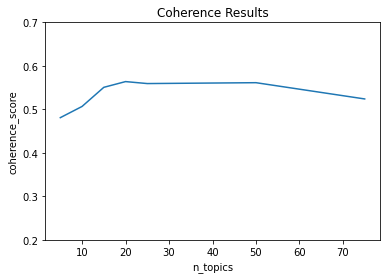

In [61]:
fig = plt.figure()
plt.plot(topics_param, coherence_results)
plt.title("Coherence Results")
plt.xlabel("n_topics")
plt.ylabel('coherence_score')
plt.ylim(0.2, 0.7)
plt.show()

In [62]:
for idx, i in enumerate(topics_param):
    save_model(model_list[idx], f'{i}_topics')

2020-08-19 21:01:26,785 : INFO : saving LdaState object under ../artefacts/model_5_topics.state, separately None
2020-08-19 21:01:26,795 : INFO : saved ../artefacts/model_5_topics.state
2020-08-19 21:01:26,810 : INFO : saving LdaModel object under ../artefacts/model_5_topics, separately ['expElogbeta', 'sstats']
2020-08-19 21:01:26,811 : INFO : storing np array 'expElogbeta' to ../artefacts/model_5_topics.expElogbeta.npy
2020-08-19 21:01:26,812 : INFO : not storing attribute state
2020-08-19 21:01:26,813 : INFO : not storing attribute dispatcher
2020-08-19 21:01:26,813 : INFO : not storing attribute id2word
2020-08-19 21:01:26,815 : INFO : saved ../artefacts/model_5_topics
2020-08-19 21:01:26,815 : INFO : saving LdaState object under ../artefacts/model_10_topics.state, separately None
2020-08-19 21:01:26,820 : INFO : saved ../artefacts/model_10_topics.state
2020-08-19 21:01:26,829 : INFO : saving LdaModel object under ../artefacts/model_10_topics, separately ['expElogbeta', 'sstats']
2

In [67]:
model = model_list[topics_param.index(15)]
top_topics = model.top_topics(corpus, texts=docs, coherence='c_v')

pprint(top_topics)

2020-08-19 21:28:17,264 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2020-08-19 21:28:17,492 : INFO : 1 batches submitted to accumulate stats from 64 documents (4228 virtual)
2020-08-19 21:28:17,497 : INFO : 2 batches submitted to accumulate stats from 128 documents (8643 virtual)
2020-08-19 21:28:17,500 : INFO : 3 batches submitted to accumulate stats from 192 documents (13021 virtual)
2020-08-19 21:28:17,504 : INFO : 4 batches submitted to accumulate stats from 256 documents (16963 virtual)
2020-08-19 21:28:17,507 : INFO : 5 batches submitted to accumulate stats from 320 documents (21163 virtual)
2020-08-19 21:28:17,511 : INFO : 6 batches submitted to accumulate stats from 384 documents (25298 virtual)
2020-08-19 21:28:17,515 : INFO : 7 batches submitted to accumulate stats from 448 documents (29786 virtual)
2020-08-19 21:28:17,522 : INFO : 8 batches submitted to accumulate stats from 512 documents (34425

2020-08-19 21:28:19,548 : INFO : 74 batches submitted to accumulate stats from 4736 documents (319155 virtual)
2020-08-19 21:28:19,557 : INFO : 75 batches submitted to accumulate stats from 4800 documents (323808 virtual)
2020-08-19 21:28:19,719 : INFO : 76 batches submitted to accumulate stats from 4864 documents (328546 virtual)
2020-08-19 21:28:19,782 : INFO : 77 batches submitted to accumulate stats from 4928 documents (332889 virtual)
2020-08-19 21:28:19,862 : INFO : 78 batches submitted to accumulate stats from 4992 documents (337002 virtual)
2020-08-19 21:28:19,879 : INFO : 79 batches submitted to accumulate stats from 5056 documents (341353 virtual)
2020-08-19 21:28:19,948 : INFO : 80 batches submitted to accumulate stats from 5120 documents (345413 virtual)
2020-08-19 21:28:20,003 : INFO : 81 batches submitted to accumulate stats from 5184 documents (349774 virtual)
2020-08-19 21:28:20,016 : INFO : 82 batches submitted to accumulate stats from 5248 documents (354090 virtual)
2

2020-08-19 21:28:22,655 : INFO : 148 batches submitted to accumulate stats from 9472 documents (641947 virtual)
2020-08-19 21:28:22,663 : INFO : 149 batches submitted to accumulate stats from 9536 documents (646398 virtual)
2020-08-19 21:28:22,672 : INFO : 150 batches submitted to accumulate stats from 9600 documents (650352 virtual)
2020-08-19 21:28:22,679 : INFO : 151 batches submitted to accumulate stats from 9664 documents (654665 virtual)
2020-08-19 21:28:22,686 : INFO : 152 batches submitted to accumulate stats from 9728 documents (658976 virtual)
2020-08-19 21:28:22,819 : INFO : 153 batches submitted to accumulate stats from 9792 documents (663026 virtual)
2020-08-19 21:28:22,846 : INFO : 154 batches submitted to accumulate stats from 9856 documents (667127 virtual)
2020-08-19 21:28:22,868 : INFO : 155 batches submitted to accumulate stats from 9920 documents (671211 virtual)
2020-08-19 21:28:22,891 : INFO : 156 batches submitted to accumulate stats from 9984 documents (675439 v

2020-08-19 21:28:26,541 : INFO : 221 batches submitted to accumulate stats from 14144 documents (956973 virtual)
2020-08-19 21:28:26,579 : INFO : 222 batches submitted to accumulate stats from 14208 documents (961378 virtual)
2020-08-19 21:28:26,652 : INFO : 223 batches submitted to accumulate stats from 14272 documents (965835 virtual)
2020-08-19 21:28:26,803 : INFO : 224 batches submitted to accumulate stats from 14336 documents (970664 virtual)
2020-08-19 21:28:26,923 : INFO : 225 batches submitted to accumulate stats from 14400 documents (974426 virtual)
2020-08-19 21:28:26,961 : INFO : 226 batches submitted to accumulate stats from 14464 documents (978906 virtual)
2020-08-19 21:28:26,992 : INFO : 227 batches submitted to accumulate stats from 14528 documents (983043 virtual)
2020-08-19 21:28:27,026 : INFO : 228 batches submitted to accumulate stats from 14592 documents (987417 virtual)
2020-08-19 21:28:27,095 : INFO : 229 batches submitted to accumulate stats from 14656 documents 

2020-08-19 21:28:32,910 : INFO : 293 batches submitted to accumulate stats from 18752 documents (1262063 virtual)
2020-08-19 21:28:32,932 : INFO : 294 batches submitted to accumulate stats from 18816 documents (1266429 virtual)
2020-08-19 21:28:33,020 : INFO : 295 batches submitted to accumulate stats from 18880 documents (1271246 virtual)
2020-08-19 21:28:33,171 : INFO : 296 batches submitted to accumulate stats from 18944 documents (1275551 virtual)
2020-08-19 21:28:33,513 : INFO : 297 batches submitted to accumulate stats from 19008 documents (1279867 virtual)
2020-08-19 21:28:33,564 : INFO : 298 batches submitted to accumulate stats from 19072 documents (1284180 virtual)
2020-08-19 21:28:33,771 : INFO : 299 batches submitted to accumulate stats from 19136 documents (1288400 virtual)
2020-08-19 21:28:33,801 : INFO : 300 batches submitted to accumulate stats from 19200 documents (1292534 virtual)
2020-08-19 21:28:33,840 : INFO : 301 batches submitted to accumulate stats from 19264 do

2020-08-19 21:28:39,300 : INFO : 365 batches submitted to accumulate stats from 23360 documents (1566485 virtual)
2020-08-19 21:28:39,655 : INFO : 366 batches submitted to accumulate stats from 23424 documents (1570797 virtual)
2020-08-19 21:28:39,694 : INFO : 367 batches submitted to accumulate stats from 23488 documents (1575324 virtual)
2020-08-19 21:28:39,726 : INFO : 368 batches submitted to accumulate stats from 23552 documents (1579466 virtual)
2020-08-19 21:28:39,756 : INFO : 369 batches submitted to accumulate stats from 23616 documents (1583776 virtual)
2020-08-19 21:28:39,850 : INFO : 370 batches submitted to accumulate stats from 23680 documents (1588083 virtual)
2020-08-19 21:28:40,042 : INFO : 371 batches submitted to accumulate stats from 23744 documents (1592174 virtual)
2020-08-19 21:28:40,133 : INFO : 372 batches submitted to accumulate stats from 23808 documents (1596446 virtual)
2020-08-19 21:28:40,166 : INFO : 373 batches submitted to accumulate stats from 23872 do

2020-08-19 21:28:45,623 : INFO : 437 batches submitted to accumulate stats from 27968 documents (1866983 virtual)
2020-08-19 21:28:45,737 : INFO : 438 batches submitted to accumulate stats from 28032 documents (1870657 virtual)
2020-08-19 21:28:45,938 : INFO : 439 batches submitted to accumulate stats from 28096 documents (1875006 virtual)
2020-08-19 21:28:45,998 : INFO : 440 batches submitted to accumulate stats from 28160 documents (1878913 virtual)
2020-08-19 21:28:46,073 : INFO : 441 batches submitted to accumulate stats from 28224 documents (1883009 virtual)
2020-08-19 21:28:46,167 : INFO : 442 batches submitted to accumulate stats from 28288 documents (1886847 virtual)
2020-08-19 21:28:46,184 : INFO : 443 batches submitted to accumulate stats from 28352 documents (1890665 virtual)
2020-08-19 21:28:46,243 : INFO : 444 batches submitted to accumulate stats from 28416 documents (1894466 virtual)
2020-08-19 21:28:46,382 : INFO : 445 batches submitted to accumulate stats from 28480 do

[([(0.083950914, 'energy'),
   (0.021231575, 'system'),
   (0.021223264, 'power'),
   (0.01572327, 'efficiency'),
   (0.015402987, 'building'),
   (0.014118446, 'solar'),
   (0.0126686655, 'water'),
   (0.012106224, 'heat'),
   (0.011505687, 'technology'),
   (0.011366673, 'cost'),
   (0.0101744635, 'storage'),
   (0.009927606, 'battery'),
   (0.009457873, 'grid'),
   (0.0086050555, 'efficient'),
   (0.008545846, 'solution'),
   (0.008299471, 'consumption'),
   (0.007837865, 'low'),
   (0.0077430545, 'thermal'),
   (0.007653101, 'renewable'),
   (0.007582882, 'electricity')],
  0.6907166411942562),
 ([(0.046455774, 'research'),
   (0.02133999, 'researcher'),
   (0.017735494, 'training'),
   (0.013906556, 'science'),
   (0.011144662, 'skill'),
   (0.011049256, 'scientific'),
   (0.010739163, 'university'),
   (0.0096723605, 'european'),
   (0.009101051, 'knowledge'),
   (0.009011802, 'expertise'),
   (0.008447949, 'career'),
   (0.008430339, 'academic'),
   (0.008203719, 'development'),

In [71]:
model.show_topics()

2020-08-19 21:48:13,305 : INFO : topic #0 (0.101): 0.010*"quantum" + 0.009*"theory" + 0.009*"structure" + 0.009*"model" + 0.007*"field" + 0.007*"system" + 0.007*"dynamic" + 0.007*"study" + 0.007*"property" + 0.007*"physic"
2020-08-19 21:48:13,309 : INFO : topic #1 (0.099): 0.010*"mechanism" + 0.009*"gene" + 0.007*"evolution" + 0.007*"dna" + 0.007*"role" + 0.006*"understanding" + 0.006*"genetic" + 0.006*"function" + 0.006*"study" + 0.006*"molecular"
2020-08-19 21:48:13,311 : INFO : topic #2 (0.087): 0.021*"material" + 0.018*"process" + 0.012*"production" + 0.011*"chemical" + 0.009*"waste" + 0.008*"based" + 0.008*"high" + 0.008*"product" + 0.007*"metal" + 0.007*"industrial"
2020-08-19 21:48:13,315 : INFO : topic #3 (0.076): 0.017*"system" + 0.010*"technology" + 0.009*"design" + 0.008*"vehicle" + 0.008*"cost" + 0.008*"safety" + 0.007*"high" + 0.007*"transport" + 0.006*"manufacturing" + 0.006*"test"
2020-08-19 21:48:13,318 : INFO : topic #4 (0.082): 0.015*"brain" + 0.011*"human" + 0.009*"s

[(0,
  '0.010*"quantum" + 0.009*"theory" + 0.009*"structure" + 0.009*"model" + 0.007*"field" + 0.007*"system" + 0.007*"dynamic" + 0.007*"study" + 0.007*"property" + 0.007*"physic"'),
 (1,
  '0.010*"mechanism" + 0.009*"gene" + 0.007*"evolution" + 0.007*"dna" + 0.007*"role" + 0.006*"understanding" + 0.006*"genetic" + 0.006*"function" + 0.006*"study" + 0.006*"molecular"'),
 (2,
  '0.021*"material" + 0.018*"process" + 0.012*"production" + 0.011*"chemical" + 0.009*"waste" + 0.008*"based" + 0.008*"high" + 0.008*"product" + 0.007*"metal" + 0.007*"industrial"'),
 (3,
  '0.017*"system" + 0.010*"technology" + 0.009*"design" + 0.008*"vehicle" + 0.008*"cost" + 0.008*"safety" + 0.007*"high" + 0.007*"transport" + 0.006*"manufacturing" + 0.006*"test"'),
 (4,
  '0.015*"brain" + 0.011*"human" + 0.009*"social" + 0.008*"language" + 0.008*"individual" + 0.008*"learning" + 0.008*"child" + 0.007*"neural" + 0.007*"cognitive" + 0.006*"visual"'),
 (5,
  '0.014*"climate" + 0.013*"plant" + 0.013*"change" + 0.009

In [70]:
# https://github.com/bmabey/pyLDAvis/issues/127#issuecomment-408903130
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis, '../references/vis_15_topics.html')

## Further Improvements

In [40]:
from gensim.models import LdaMulticore

def train_lda_multicore(corpus, id2word, num_topics):
    return LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        chunksize=CHUNK_SIZE,
        alpha='asymmetric',
        eta=ETA,
        iterations=ITERATIONS,
        passes=PASSES,
        eval_every=EVAL_EVERY,
        random_state=RANDOM_STATE
    )

In [41]:
%%time 

model = train_lda_multicore(corpus, dictionary, 10)

2020-08-19 14:35:20,773 : INFO : using asymmetric alpha [0.20349778, 0.15460682, 0.124657474, 0.10442834, 0.08984803, 0.07884031, 0.070235424, 0.06332404, 0.057651002, 0.052910853]
2020-08-19 14:35:20,784 : INFO : using serial LDA version on this node
2020-08-19 14:35:20,809 : INFO : running online LDA training, 10 topics, 20 passes over the supplied corpus of 30084 documents, updating every 60000 documents, evaluating every ~0 documents, iterating 200x with a convergence threshold of 0.001000
2020-08-19 14:35:20,809 : INFO : training LDA model using 15 processes
2020-08-19 14:35:20,960 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #4000/30084, outstanding queue size 1
2020-08-19 14:35:21,109 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #8000/30084, outstanding queue size 2
2020-08-19 14:35:21,125 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #12000/30084, outstanding queue size 3
2020-08-19 14:35:21,136 : INFO : PROGRESS: pass 

2020-08-19 14:36:27,648 : INFO : topic #9 (0.053): 0.015*"system" + 0.008*"quantum" + 0.005*"technology" + 0.005*"based" + 0.005*"high" + 0.004*"data" + 0.004*"application" + 0.004*"network" + 0.003*"research" + 0.003*"design"
2020-08-19 14:36:27,649 : INFO : topic #8 (0.058): 0.014*"cell" + 0.006*"disease" + 0.006*"cancer" + 0.006*"patient" + 0.004*"treatment" + 0.004*"development" + 0.004*"study" + 0.004*"clinical" + 0.004*"system" + 0.004*"research"
2020-08-19 14:36:27,650 : INFO : topic #2 (0.125): 0.009*"technology" + 0.008*"energy" + 0.006*"system" + 0.006*"market" + 0.006*"cost" + 0.006*"material" + 0.005*"high" + 0.005*"based" + 0.005*"research" + 0.005*"power"
2020-08-19 14:36:27,651 : INFO : topic #1 (0.155): 0.004*"model" + 0.004*"research" + 0.004*"system" + 0.004*"data" + 0.004*"human" + 0.004*"study" + 0.004*"plant" + 0.003*"process" + 0.003*"approach" + 0.003*"based"
2020-08-19 14:36:27,652 : INFO : topic #0 (0.203): 0.006*"material" + 0.005*"research" + 0.004*"structure

2020-08-19 14:37:04,902 : INFO : PROGRESS: pass 7, dispatched chunk #3 = documents up to #16000/30084, outstanding queue size 4
2020-08-19 14:37:04,903 : INFO : PROGRESS: pass 7, dispatched chunk #4 = documents up to #20000/30084, outstanding queue size 5
2020-08-19 14:37:04,903 : INFO : PROGRESS: pass 7, dispatched chunk #5 = documents up to #24000/30084, outstanding queue size 6
2020-08-19 14:37:04,904 : INFO : PROGRESS: pass 7, dispatched chunk #6 = documents up to #28000/30084, outstanding queue size 7
2020-08-19 14:37:04,905 : INFO : PROGRESS: pass 7, dispatched chunk #7 = documents up to #30084/30084, outstanding queue size 8
2020-08-19 14:37:15,998 : INFO : topic #9 (0.053): 0.015*"system" + 0.010*"quantum" + 0.006*"technology" + 0.006*"application" + 0.005*"high" + 0.005*"based" + 0.004*"network" + 0.004*"data" + 0.004*"device" + 0.004*"optical"
2020-08-19 14:37:15,999 : INFO : topic #8 (0.058): 0.016*"cell" + 0.008*"disease" + 0.007*"patient" + 0.007*"cancer" + 0.005*"treatmen

2020-08-19 14:37:48,304 : INFO : topic diff=0.232247, rho=0.232363
2020-08-19 14:37:48,334 : INFO : PROGRESS: pass 11, dispatched chunk #0 = documents up to #4000/30084, outstanding queue size 1
2020-08-19 14:37:48,438 : INFO : PROGRESS: pass 11, dispatched chunk #1 = documents up to #8000/30084, outstanding queue size 2
2020-08-19 14:37:48,448 : INFO : PROGRESS: pass 11, dispatched chunk #2 = documents up to #12000/30084, outstanding queue size 3
2020-08-19 14:37:48,449 : INFO : PROGRESS: pass 11, dispatched chunk #3 = documents up to #16000/30084, outstanding queue size 4
2020-08-19 14:37:48,451 : INFO : PROGRESS: pass 11, dispatched chunk #4 = documents up to #20000/30084, outstanding queue size 5
2020-08-19 14:37:48,451 : INFO : PROGRESS: pass 11, dispatched chunk #5 = documents up to #24000/30084, outstanding queue size 6
2020-08-19 14:37:48,452 : INFO : PROGRESS: pass 11, dispatched chunk #6 = documents up to #28000/30084, outstanding queue size 7
2020-08-19 14:37:48,453 : INFO :

2020-08-19 14:38:28,651 : INFO : topic #2 (0.125): 0.012*"energy" + 0.010*"technology" + 0.008*"material" + 0.008*"system" + 0.008*"cost" + 0.008*"high" + 0.006*"power" + 0.005*"based" + 0.005*"process" + 0.005*"fuel"
2020-08-19 14:38:28,652 : INFO : topic #1 (0.155): 0.006*"model" + 0.006*"change" + 0.006*"plant" + 0.005*"climate" + 0.005*"understanding" + 0.005*"specie" + 0.004*"evolution" + 0.004*"study" + 0.004*"data" + 0.004*"process"
2020-08-19 14:38:28,653 : INFO : topic #0 (0.203): 0.009*"material" + 0.006*"structure" + 0.006*"property" + 0.005*"field" + 0.004*"molecular" + 0.004*"research" + 0.004*"protein" + 0.004*"process" + 0.004*"high" + 0.004*"dynamic"
2020-08-19 14:38:28,654 : INFO : topic diff=0.186098, rho=0.210720
2020-08-19 14:38:28,695 : INFO : PROGRESS: pass 15, dispatched chunk #0 = documents up to #4000/30084, outstanding queue size 1
2020-08-19 14:38:28,696 : INFO : PROGRESS: pass 15, dispatched chunk #1 = documents up to #8000/30084, outstanding queue size 2
20

2020-08-19 14:39:00,689 : INFO : PROGRESS: pass 18, dispatched chunk #7 = documents up to #30084/30084, outstanding queue size 8
2020-08-19 14:39:10,241 : INFO : topic #9 (0.053): 0.014*"system" + 0.011*"quantum" + 0.007*"application" + 0.006*"technology" + 0.006*"high" + 0.005*"based" + 0.005*"network" + 0.005*"optical" + 0.005*"device" + 0.004*"theory"
2020-08-19 14:39:10,242 : INFO : topic #8 (0.058): 0.018*"cell" + 0.010*"disease" + 0.009*"patient" + 0.008*"cancer" + 0.006*"clinical" + 0.006*"treatment" + 0.005*"drug" + 0.005*"development" + 0.005*"novel" + 0.004*"study"
2020-08-19 14:39:10,243 : INFO : topic #2 (0.125): 0.014*"energy" + 0.011*"technology" + 0.009*"system" + 0.009*"material" + 0.008*"cost" + 0.008*"high" + 0.007*"power" + 0.005*"process" + 0.005*"based" + 0.005*"fuel"
2020-08-19 14:39:10,244 : INFO : topic #1 (0.155): 0.007*"model" + 0.006*"change" + 0.006*"plant" + 0.005*"climate" + 0.005*"understanding" + 0.005*"specie" + 0.005*"evolution" + 0.004*"study" + 0.004

CPU times: user 3min 38s, sys: 1min 12s, total: 4min 51s
Wall time: 4min 1s


In [45]:
compute_coherence(model, docs, dictionary)

2020-08-19 14:59:32,290 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2020-08-19 14:59:32,479 : INFO : 1 batches submitted to accumulate stats from 64 documents (4228 virtual)
2020-08-19 14:59:32,484 : INFO : 2 batches submitted to accumulate stats from 128 documents (8643 virtual)
2020-08-19 14:59:32,488 : INFO : 3 batches submitted to accumulate stats from 192 documents (13021 virtual)
2020-08-19 14:59:32,491 : INFO : 4 batches submitted to accumulate stats from 256 documents (16963 virtual)
2020-08-19 14:59:32,494 : INFO : 5 batches submitted to accumulate stats from 320 documents (21163 virtual)
2020-08-19 14:59:32,499 : INFO : 6 batches submitted to accumulate stats from 384 documents (25298 virtual)
2020-08-19 14:59:32,505 : INFO : 7 batches submitted to accumulate stats from 448 documents (29786 virtual)
2020-08-19 14:59:32,512 : INFO : 8 batches submitted to accumulate stats from 512 documents (34425

2020-08-19 14:59:33,777 : INFO : 74 batches submitted to accumulate stats from 4736 documents (319155 virtual)
2020-08-19 14:59:33,784 : INFO : 75 batches submitted to accumulate stats from 4800 documents (323808 virtual)
2020-08-19 14:59:33,919 : INFO : 76 batches submitted to accumulate stats from 4864 documents (328546 virtual)
2020-08-19 14:59:33,932 : INFO : 77 batches submitted to accumulate stats from 4928 documents (332889 virtual)
2020-08-19 14:59:33,982 : INFO : 78 batches submitted to accumulate stats from 4992 documents (337002 virtual)
2020-08-19 14:59:34,022 : INFO : 79 batches submitted to accumulate stats from 5056 documents (341353 virtual)
2020-08-19 14:59:34,042 : INFO : 80 batches submitted to accumulate stats from 5120 documents (345413 virtual)
2020-08-19 14:59:34,047 : INFO : 81 batches submitted to accumulate stats from 5184 documents (349774 virtual)
2020-08-19 14:59:34,062 : INFO : 82 batches submitted to accumulate stats from 5248 documents (354090 virtual)
2

2020-08-19 14:59:35,744 : INFO : 148 batches submitted to accumulate stats from 9472 documents (641947 virtual)
2020-08-19 14:59:35,761 : INFO : 149 batches submitted to accumulate stats from 9536 documents (646398 virtual)
2020-08-19 14:59:35,783 : INFO : 150 batches submitted to accumulate stats from 9600 documents (650352 virtual)
2020-08-19 14:59:35,798 : INFO : 151 batches submitted to accumulate stats from 9664 documents (654665 virtual)
2020-08-19 14:59:35,829 : INFO : 152 batches submitted to accumulate stats from 9728 documents (658976 virtual)
2020-08-19 14:59:35,892 : INFO : 153 batches submitted to accumulate stats from 9792 documents (663026 virtual)
2020-08-19 14:59:35,923 : INFO : 154 batches submitted to accumulate stats from 9856 documents (667127 virtual)
2020-08-19 14:59:35,934 : INFO : 155 batches submitted to accumulate stats from 9920 documents (671211 virtual)
2020-08-19 14:59:35,980 : INFO : 156 batches submitted to accumulate stats from 9984 documents (675439 v

2020-08-19 14:59:37,615 : INFO : 221 batches submitted to accumulate stats from 14144 documents (956973 virtual)
2020-08-19 14:59:37,664 : INFO : 222 batches submitted to accumulate stats from 14208 documents (961378 virtual)
2020-08-19 14:59:37,684 : INFO : 223 batches submitted to accumulate stats from 14272 documents (965835 virtual)
2020-08-19 14:59:37,699 : INFO : 224 batches submitted to accumulate stats from 14336 documents (970664 virtual)
2020-08-19 14:59:37,712 : INFO : 225 batches submitted to accumulate stats from 14400 documents (974426 virtual)
2020-08-19 14:59:37,719 : INFO : 226 batches submitted to accumulate stats from 14464 documents (978906 virtual)
2020-08-19 14:59:37,738 : INFO : 227 batches submitted to accumulate stats from 14528 documents (983043 virtual)
2020-08-19 14:59:37,812 : INFO : 228 batches submitted to accumulate stats from 14592 documents (987417 virtual)
2020-08-19 14:59:37,833 : INFO : 229 batches submitted to accumulate stats from 14656 documents 

2020-08-19 14:59:39,382 : INFO : 293 batches submitted to accumulate stats from 18752 documents (1262148 virtual)
2020-08-19 14:59:39,393 : INFO : 294 batches submitted to accumulate stats from 18816 documents (1266570 virtual)
2020-08-19 14:59:39,409 : INFO : 295 batches submitted to accumulate stats from 18880 documents (1271351 virtual)
2020-08-19 14:59:39,437 : INFO : 296 batches submitted to accumulate stats from 18944 documents (1275689 virtual)
2020-08-19 14:59:39,468 : INFO : 297 batches submitted to accumulate stats from 19008 documents (1279991 virtual)
2020-08-19 14:59:39,486 : INFO : 298 batches submitted to accumulate stats from 19072 documents (1284292 virtual)
2020-08-19 14:59:39,540 : INFO : 299 batches submitted to accumulate stats from 19136 documents (1288551 virtual)
2020-08-19 14:59:39,638 : INFO : 300 batches submitted to accumulate stats from 19200 documents (1292668 virtual)
2020-08-19 14:59:39,654 : INFO : 301 batches submitted to accumulate stats from 19264 do

2020-08-19 14:59:43,309 : INFO : 365 batches submitted to accumulate stats from 23360 documents (1566567 virtual)
2020-08-19 14:59:43,428 : INFO : 366 batches submitted to accumulate stats from 23424 documents (1570953 virtual)
2020-08-19 14:59:43,446 : INFO : 367 batches submitted to accumulate stats from 23488 documents (1575459 virtual)
2020-08-19 14:59:43,469 : INFO : 368 batches submitted to accumulate stats from 23552 documents (1579626 virtual)
2020-08-19 14:59:43,583 : INFO : 369 batches submitted to accumulate stats from 23616 documents (1583918 virtual)
2020-08-19 14:59:43,616 : INFO : 370 batches submitted to accumulate stats from 23680 documents (1588222 virtual)
2020-08-19 14:59:43,657 : INFO : 371 batches submitted to accumulate stats from 23744 documents (1592300 virtual)
2020-08-19 14:59:43,713 : INFO : 372 batches submitted to accumulate stats from 23808 documents (1596592 virtual)
2020-08-19 14:59:43,736 : INFO : 373 batches submitted to accumulate stats from 23872 do

2020-08-19 14:59:47,558 : INFO : 437 batches submitted to accumulate stats from 27968 documents (1867132 virtual)
2020-08-19 14:59:47,594 : INFO : 438 batches submitted to accumulate stats from 28032 documents (1870819 virtual)
2020-08-19 14:59:47,660 : INFO : 439 batches submitted to accumulate stats from 28096 documents (1875127 virtual)
2020-08-19 14:59:47,691 : INFO : 440 batches submitted to accumulate stats from 28160 documents (1879051 virtual)
2020-08-19 14:59:47,780 : INFO : 441 batches submitted to accumulate stats from 28224 documents (1883133 virtual)
2020-08-19 14:59:47,925 : INFO : 442 batches submitted to accumulate stats from 28288 documents (1886915 virtual)
2020-08-19 14:59:47,984 : INFO : 443 batches submitted to accumulate stats from 28352 documents (1890785 virtual)
2020-08-19 14:59:48,026 : INFO : 444 batches submitted to accumulate stats from 28416 documents (1894446 virtual)
2020-08-19 14:59:48,063 : INFO : 445 batches submitted to accumulate stats from 28480 do

0.47056989952123873

In [33]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / 10
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2020-08-19 10:36:04,694 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2020-08-19 10:36:04,724 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2020-08-19 10:36:04,753 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2020-08-19 10:36:04,781 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2020-08-19 10:36:04,806 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2020-08-19 10:36:04,834 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2020-08-19 10:36:04,860 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2020-08-19 10:36:04,885 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2020-08-19 10:36:04,912 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2020-08-19 10:36:04,938 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2020-08-19 10:36:04,970 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2020-08-19 10:36:04

Average topic coherence: -1.6349.
[([(0.023069356, 'market'),
   (0.010776376, 'cost'),
   (0.010223895, 'technology'),
   (0.009999986, 'product'),
   (0.009230412, 'year'),
   (0.009043012, 'company'),
   (0.008952787, 'solution'),
   (0.007790148, 'business'),
   (0.006796899, 'time'),
   (0.0062244837, 'device'),
   (0.005800453, 'need'),
   (0.0055333925, 'million'),
   (0.00499023, 'phase'),
   (0.0047341306, 'industry'),
   (0.004722732, 'based'),
   (0.0046798917, 'first'),
   (0.0041996944, 'customer'),
   (0.00381321, 'high'),
   (0.0037663449, 'quality'),
   (0.0037240623, 'current')],
  -1.3777710668710257),
 ([(0.020860288, 'cell'),
   (0.011481104, 'disease'),
   (0.009442626, 'patient'),
   (0.007760659, 'cancer'),
   (0.007064126, 'treatment'),
   (0.006926316, 'clinical'),
   (0.005992437, 'protein'),
   (0.005726768, 'drug'),
   (0.005436834, 'novel'),
   (0.0053623132, 'development'),
   (0.00511099, 'human'),
   (0.0049721547, 'mechanism'),
   (0.004838884, 'study')

## pyLDAvis Visualization

In [34]:
import pyLDAvis
import pyLDAvis.gensim

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.save_html(vis, '../references/vis_10_topics.html')

## Save Model and Dictionary

In [30]:
def save_model(model: LdaModel, suffix: ''):
    path = '../artefacts/model'
    if suffix:
        path = path + '_' + suffix
    model.save(path)

In [31]:
save_model(model, suffix='10_topics')

2020-08-19 10:34:52,190 : INFO : saving LdaState object under ../artefacts/model_10_topics.state, separately None
2020-08-19 10:34:52,202 : INFO : saved ../artefacts/model_10_topics.state
2020-08-19 10:34:52,212 : INFO : saving LdaModel object under ../artefacts/model_10_topics, separately ['expElogbeta', 'sstats']
2020-08-19 10:34:52,213 : INFO : storing np array 'expElogbeta' to ../artefacts/model_10_topics.expElogbeta.npy
2020-08-19 10:34:52,214 : INFO : not storing attribute state
2020-08-19 10:34:52,214 : INFO : not storing attribute dispatcher
2020-08-19 10:34:52,214 : INFO : not storing attribute id2word
2020-08-19 10:34:52,215 : INFO : saved ../artefacts/model_10_topics


In [93]:
dictionary.save('../artefacts/dictionary')

2020-08-17 21:51:12,600 : INFO : saving Dictionary object under ../artefacts/dictionary, separately None
2020-08-17 21:51:12,624 : INFO : saved ../artefacts/dictionary


In [94]:
import pickle

In [95]:
with open('../artefacts/corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)

In [97]:
with open('../artefacts/docs.pkl', 'wb') as f:
    pickle.dump(docs, f)

## Load 

In [1]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import pickle

In [2]:
model = LdaModel.load('../artefacts/model')
dictionary = Dictionary.load('../artefacts/dictionary')
with open('../artefacts/corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)

In [3]:
num_topics = 100
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -5.1439.
[([(0.013923049, 'approach'),
   (0.0112670185, 'method'),
   (0.010245459, 'study'),
   (0.009675742, 'research'),
   (0.009476805, 'process'),
   (0.008991523, 'also'),
   (0.008671985, 'one'),
   (0.008403383, 'aim'),
   (0.008393633, 'however'),
   (0.0082366355, 'use'),
   (0.008076519, 'using'),
   (0.008017485, 'first'),
   (0.0077806045, 'understanding'),
   (0.0073402077, 'novel'),
   (0.007272466, 'field'),
   (0.0070812376, 'provide'),
   (0.006989351, 'model'),
   (0.0065460154, 'important'),
   (0.0064673363, 'result'),
   (0.0064464714, 'technique')],
  -1.375203842840395),
 ([(0.035450414, 'system'),
   (0.022716377, 'technology'),
   (0.015057406, 'based'),
   (0.014617012, 'design'),
   (0.013366538, 'development'),
   (0.011184716, 'application'),
   (0.009172131, 'objective'),
   (0.008608391, 'performance'),
   (0.008068554, 'develop'),
   (0.0078495145, 'innovative'),
   (0.007406224, 'high'),
   (0.007358001, 'concept'),
   (0.006

 ([(0.102523446, 'visual'),
   (0.05420128, 'deep'),
   (0.04770394, 'object'),
   (0.041518554, 'vision'),
   (0.04111741, 'printing'),
   (0.031610828, 'catheter'),
   (0.028047143, 'vein'),
   (0.024626464, 'renovation'),
   (0.02454793, 'acute'),
   (0.024082944, 'glucose'),
   (0.02380783, 'scene'),
   (0.018374944, 'rehabilitation'),
   (0.0146554345, 'meso'),
   (0.012691353, 'foot'),
   (0.012569267, 'spontaneous'),
   (0.012203974, 'electrode'),
   (0.011314383, 'pacemaker'),
   (0.011227247, 'degenerative'),
   (0.011212102, 'restoration'),
   (0.010266766, 'finalize')],
  -10.340749533635577),
 ([(0.20143752, 'space'),
   (0.048456617, 'satellite'),
   (0.044584505, 'pa'),
   (0.03506114, 'mission'),
   (0.031229777, 'lifting'),
   (0.027337896, 'firm'),
   (0.01264324, 'conjecture'),
   (0.012627676, 'route'),
   (0.012208109, 'orbit'),
   (0.012101938, 'shock'),
   (0.010774395, 'insertion'),
   (0.010730508, 'curve'),
   (0.009691154, 'georeferenced'),
   (0.009498349, 'l

In [5]:
import pyLDAvis
import pyLDAvis.gensim

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
84    -0.292344  0.055426       1        1  12.465569
35    -0.269651 -0.111480       2        1  11.687627
51    -0.159004 -0.169649       3        1   3.370281
8     -0.230741 -0.085826       4        1   3.361447
38    -0.163317 -0.171059       5        1   3.124230
...         ...       ...     ...      ...        ...
15     0.129342 -0.000191      96        1   0.228074
90     0.127631 -0.002453      97        1   0.222897
50     0.125843  0.005026      98        1   0.209248
12     0.132761 -0.005054      99        1   0.180009
16     0.146092 -0.000728     100        1   0.139710

[100 rows x 5 columns], topic_info=            Term          Freq         Total  Category  logprob  loglift
505         cell  16992.000000  16992.000000   Default  30.0000  30.0000
241         data  18124.000000  18124.000000   Default  29.0000  29.0000
1370      energy  14934.000000  14934.000000   Default  28.0000  28.0000
89      research  25782.000000  25782.000000   Default  27.0000  27.0000
100       system  28445.000000  28445.000000   Default  26.0000  26.0000
...          ...           ...           ...       ...      ...      ...
4427       grain    172.201405    263.861935  Topic100  -3.7096   6.1466
2302    attached     96.033316    193.338694  Topic100  -4.2936   5.8736
1357  altogether     75.107032    143.035927  Topic100  -4.5394   5.9292
5489  consistent     95.371792    476.914724  Topic100  -4.3005   4.9638
548         near     85.955033   1232.100405  Topic100  -4.4045   3.9107

[5455 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
7243      72  0.989461    100m
11682     25  0.990565    10th
13397      5  0.987711     10x
7227      23  0.978654    16th
6317      47  0.984653    18th
...      ...       ...     ...
12903     75  0.988964    zinc
2230      53  0.173021    zone
2230      91  0.825328    zone
12299     56  0.981768  zurich
7717      81  0.991888      µm

[14038 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[85, 36, 52, 9, 39, 50, 94, 47, 87, 81, 86, 90, 18, 73, 48, 41, 5, 78, 42, 21, 12, 62, 64, 80, 98, 3, 34, 19, 1, 56, 22, 82, 43, 7, 55, 66, 14, 57, 70, 28, 6, 58, 95, 68, 100, 33, 63, 49, 25, 92, 93, 30, 2, 24, 97, 65, 46, 79, 67, 15, 99, 75, 54, 31, 26, 96, 27, 77, 44, 40, 32, 45, 76, 74, 83, 72, 59, 20, 69, 61, 84, 71, 89, 38, 11, 35, 53, 8, 23, 37, 10, 4, 88, 60, 29, 16, 91, 51, 13, 17])

In [6]:
pyLDAvis.save_html(vis, '../references/vis.html')